In [1]:
import sys,os,json
import collections,math
import time,datetime,pytz
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')
# import foursq_helper as foursq
# from yelp_helper import *

############################################
########## Plot Style Declaration ##########
# Set the style globally
# Alternatives include bmh, fivethirtyeight, ggplot,
# dark_background, seaborn-deep, etc
# plt.style.use('ggplot')
plt.style.use('seaborn-white')

plt.rcParams['font.family'] = 'times new roman'
# plt.rcParams['font.serif'] = 'Ubuntu'
# plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.titlesize'] = 15
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

##########################################
########## data set declaration ##########
path_processed = "data/processed/"
path_final = "data/final/"

##################################
########## End of Setup ##########

##### Geographical Change #####
import geopy
from geopy import distance as geopy_distance
coords_1 = (52.2296756, 21.0122287)
coords_2 = (52.406374, 16.9251681)
print (geopy.distance.distance(coords_1, coords_2).km)

#!/usr/bin/env python3
import argparse
import os
import numpy as np
import time
import torch
from torch import optim
import visual_plt
import utils
from param_stamp import get_param_stamp, get_param_stamp_from_args
import evaluate
from data import get_multitask_experiment, get_multitask_experiment_multi_tasks
from encoder import Classifier
from vae_models import AutoEncoder
import callbacks as cb
from train import train_cl, train_cl_multi_tasks
from continual_learner import ContinualLearner
from exemplars import ExemplarHandler
from replayer import Replayer
from Gem import Gem
import copy

/home/users/ydkwon/anaconda2/envs/py354/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


279.35290160430094


In [2]:
def run_D1orD2(args, train_datasets, test_datasets, test_total_dataset, model=None):
    config = args.config
    classes_per_task = args.classes_per_task

    # Set default arguments
    args.lr_gen = args.lr if args.lr_gen is None else args.lr_gen
    args.g_iters = args.iters if args.g_iters is None else args.g_iters
    args.g_fc_lay = args.fc_lay if args.g_fc_lay is None else args.g_fc_lay
    args.g_fc_uni = args.fc_units if args.g_fc_uni is None else args.g_fc_uni
    # -if [log_per_task], reset all logs
    if args.log_per_task:
        args.prec_log = args.iters
        args.loss_log = args.iters
        args.sample_log = args.iters
    # -if [iCaRL] is selected, select all accompanying options
    if hasattr(args, "icarl") and args.icarl:
        args.use_exemplars = True
        args.add_exemplars = True
        args.bce = True
        args.bce_distill = True
    # -if XdG is selected but not the Task-IL scenario, give error
    if (not args.scenario == "task") and args.gating_prop > 0:
        raise ValueError("'XdG' is only compatible with the Task-IL scenario.")
    # -if EWC, SI or XdG is selected together with 'feedback', give error
    if args.feedback and (args.ewc or args.si or args.gating_prop > 0 or args.icarl):
        raise NotImplementedError("EWC, SI, XdG and iCaRL are not supported with feedback connections.")
    # -if binary classification loss is selected together with 'feedback', give error
    if args.feedback and args.bce:
        raise NotImplementedError("Binary classification loss not supported with feedback connections.")
    # -if XdG is selected together with both replay and EWC, give error (either one of them alone with XdG is fine)
    if args.gating_prop > 0 and (not args.replay == "none") and (args.ewc or args.si):
        raise NotImplementedError("XdG is not supported with both '{}' replay and EWC / SI.".format(args.replay))
        # --> problem is that applying different task-masks interferes with gradient calculation
        #    (should be possible to overcome by calculating backward step on EWC/SI-loss also for each mask separately)
    # -if 'BCEdistill' is selected for other than scenario=="class", give error
    if args.bce_distill and not args.scenario == "class":
        raise ValueError("BCE-distill can only be used for class-incremental learning.")
    # -create plots- and results-directories if needed
    if not os.path.isdir(args.r_dir):
        os.mkdir(args.r_dir)
    if args.pdf and not os.path.isdir(args.p_dir):
        os.mkdir(args.p_dir)

    scenario = args.scenario
    # If Task-IL scenario is chosen with single-headed output layer, set args.scenario to "domain"
    # (but note that when XdG is used, task-identity information is being used so the actual scenario is still Task-IL)
    if args.singlehead and args.scenario == "task":
        scenario = "domain"

    # If only want param-stamp, get it printed to screen and exit
    if hasattr(args, "get_stamp") and args.get_stamp:
        _ = get_param_stamp_from_args(args=args)
        exit()

    # Use cuda?
    cuda = torch.cuda.is_available() and args.cuda
    device = torch.device("cuda" if cuda else "cpu")

    # Set random seeds
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if cuda:
        torch.cuda.manual_seed(args.seed)

    # -------------------------------------------------------------------------------------------------#

    # ----------------#
    # ----- DATA -----#
    # ----------------#

    # Prepare data for chosen experiment
    # (train_datasets, test_datasets), config, classes_per_task = get_multitask_experiment(
    #     name=args.experiment, scenario=scenario, tasks=args.tasks, data_dir=args.d_dir,
    #     verbose=True, exception=True if args.seed == 0 else False,
    # )

    # -------------------------------------------------------------------------------------------------#

    # ------------------------------#
    # ----- MODEL (CLASSIFIER) -----#
    # ------------------------------#

    # Define main model (i.e., classifier, if requested with feedback connections)
    if model==None:
        if args.experiment == 'sensor':
            if args.gem == True:
                model = Gem(n_inputs=config['features'], n_outputs=config['classes'],
                            n_tasks=len(args.num_classes_per_task_l), args=args).to(device)
            else:
                model = Classifier(
                    num_features=config['features'], num_seq=config['seq'], classes=config['classes'],
                    fc_layers=args.fc_lay+1, fc_units=args.fc_units, fc_drop=args.fc_drop, fc_nl=args.fc_nl,
                    fc_bn=True if args.fc_bn == "yes" else False, excit_buffer=True if args.gating_prop > 0 else False,
                    binaryCE=args.bce, binaryCE_distill=args.bce_distill, experiment=args.experiment, cls_type=args.cls_type,
                    args=args
                ).to(device)
        else:
            if args.feedback:
                model = AutoEncoder(
                    image_size=config['features'], image_channels=config['seq'], classes=config['classes'],
                    fc_layers=args.fc_lay, fc_units=args.fc_units, z_dim=args.z_dim,
                    fc_drop=args.fc_drop, fc_bn=True if args.fc_bn == "yes" else False, fc_nl=args.fc_nl,
                    args=args
                ).to(device)
                model.lamda_pl = 1.  # --> to make that this VAE is also trained to classify
            else:
                model = Classifier(
                    num_features=config['features'], num_seq=config['seq'], classes=config['classes'],
                    fc_layers=args.fc_lay, fc_units=args.fc_units, fc_drop=args.fc_drop, fc_nl=args.fc_nl,
                    fc_bn=True if args.fc_bn == "yes" else False, excit_buffer=True if args.gating_prop > 0 else False,
                    binaryCE=args.bce, binaryCE_distill=args.bce_distill, experiment=args.experiment,
                    args=args
                ).to(device)

    # Define optimizer (only include parameters that "requires_grad")
    model.optim_list = [{'params': filter(lambda p: p.requires_grad, model.parameters()), 'lr': args.lr}]
    model.optim_type = args.optimizer
    if model.optim_type in ("adam", "adam_reset"):
        model.optimizer = optim.Adam(model.optim_list, betas=(0.9, 0.999))
    elif model.optim_type == "sgd":
        model.optimizer = optim.SGD(model.optim_list)
    else:
        raise ValueError("Unrecognized optimizer, '{}' is not currently a valid option".format(args.optimizer))

    # -------------------------------------------------------------------------------------------------#

    # ----------------------------------#
    # ----- CL-STRATEGY: EXEMPLARS -----#
    # ----------------------------------#

    # Store in model whether, how many and in what way to store exemplars
    if isinstance(model, ExemplarHandler) and (args.use_exemplars or args.add_exemplars or args.replay == "exemplars"):
        model.memory_budget = args.budget
        model.norm_exemplars = args.norm_exemplars
        model.herding = args.herding

    # -------------------------------------------------------------------------------------------------#

    # -----------------------------------#
    # ----- CL-STRATEGY: ALLOCATION -----#
    # -----------------------------------#

    # Elastic Weight Consolidation (EWC)
    if isinstance(model, ContinualLearner):
        model.ewc_lambda = args.ewc_lambda if args.ewc else 0
        if args.ewc:
            model.fisher_n = args.fisher_n
            model.gamma = args.gamma
            model.online = args.online
            model.emp_FI = args.emp_fi

    # Synpatic Intelligence (SI)
    if isinstance(model, ContinualLearner):
        model.si_c = args.si_c if args.si else 0
        if args.si:
            model.epsilon = args.epsilon

    # XdG: create for every task a "mask" for each hidden fully connected layer
    if isinstance(model, ContinualLearner) and args.gating_prop > 0:
        mask_dict = {}
        excit_buffer_list = []
        for task_id in range(args.tasks):
            mask_dict[task_id + 1] = {}
            for i in range(model.fcE.layers):
                layer = getattr(model.fcE, "fcLayer{}".format(i + 1)).linear
                if task_id == 0:
                    excit_buffer_list.append(layer.excit_buffer)
                n_units = len(layer.excit_buffer)
                gated_units = np.random.choice(n_units, size=int(args.gating_prop * n_units), replace=False)
                mask_dict[task_id + 1][i] = gated_units
        model.mask_dict = mask_dict
        model.excit_buffer_list = excit_buffer_list

    # -------------------------------------------------------------------------------------------------#

    # -------------------------------#
    # ----- CL-STRATEGY: REPLAY -----#
    # -------------------------------#

    # Use distillation loss (i.e., soft targets) for replayed data? (and set temperature)
    if isinstance(model, Replayer):
        model.replay_targets = "soft" if args.distill else "hard"
        model.KD_temp = args.temp

    # If needed, specify separate model for the generator
    train_gen = True if (args.replay == "generative" and not args.feedback) else False
    if train_gen:
        # -specify architecture
        generator = AutoEncoder(
            image_size=config['features'], image_channels=config['seq'],
            fc_layers=args.g_fc_lay, fc_units=args.g_fc_uni, z_dim=args.g_z_dim, classes=config['classes'],
            fc_drop=args.fc_drop, fc_bn=True if args.fc_bn == "yes" else False, fc_nl=args.fc_nl,
        ).to(device)
        # -set optimizer(s)
        generator.optim_list = [
            {'params': filter(lambda p: p.requires_grad, generator.parameters()), 'lr': args.lr_gen}]
        generator.optim_type = args.optimizer
        if generator.optim_type in ("adam", "adam_reset"):
            generator.optimizer = optim.Adam(generator.optim_list, betas=(0.9, 0.999))
        elif generator.optim_type == "sgd":
            generator.optimizer = optim.SGD(generator.optim_list)
    else:
        generator = None

    # -------------------------------------------------------------------------------------------------#

    # ---------------------#
    # ----- REPORTING -----#
    # ---------------------#

    # Get parameter-stamp (and print on screen)
#     if args.cls_type != 'mlp':
#         model.name_lstm = "LSTM([{} X {} X {}])".format(config['features'], config['seq'], config['classes'])
#         param_stamp = get_param_stamp(
#             args, model.name_lstm, verbose=True, replay=True if (not args.replay == "none") else False,
#             replay_model_name=generator.name if (args.replay == "generative" and not args.feedback) else None,
#         )
#     else:
    param_stamp = get_param_stamp(
        args, model.name, verbose=True, replay=True if (not args.replay == "none") else False,
        replay_model_name=generator.name if (args.replay == "generative" and not args.feedback) else None,
    )

    # Print some model-characteristics on the screen
    # -main model
    print("\n")
    utils.print_model_info(model, title="MAIN MODEL")
    # -generator
    if generator is not None:
        utils.print_model_info(generator, title="GENERATOR")

    # Prepare for plotting in visdom
    # -define [precision_dict] to keep track of performance during training for storing and for later plotting in pdf
    precision_dict = evaluate.initiate_precision_dict(args.tasks)
    precision_dict_exemplars = evaluate.initiate_precision_dict(args.tasks) if args.use_exemplars else None
    # -visdom-settings
    if args.visdom:
        env_name = "{exp}{tasks}-{scenario}".format(exp=args.experiment, tasks=args.tasks, scenario=args.scenario)
        graph_name = "{fb}{replay}{syn}{ewc}{xdg}{icarl}{bud}".format(
            fb="1M-" if args.feedback else "", replay="{}{}".format(args.replay, "D" if args.distill else ""),
            syn="-si{}".format(args.si_c) if args.si else "",
            ewc="-ewc{}{}".format(args.ewc_lambda,
                                  "-O{}".format(args.gamma) if args.online else "") if args.ewc else "",
            xdg="" if args.gating_prop == 0 else "-XdG{}".format(args.gating_prop),
            icarl="-iCaRL" if (args.use_exemplars and args.add_exemplars and args.bce and args.bce_distill) else "",
            bud="-bud{}".format(args.budget) if (
                    args.use_exemplars or args.add_exemplars or args.replay == "exemplars"
            ) else "",
        )
        visdom = {'env': env_name, 'graph': graph_name}
        if args.use_exemplars:
            visdom_exemplars = {'env': env_name, 'graph': "{}-EX".format(graph_name)}
    else:
        visdom = visdom_exemplars = None

    # -------------------------------------------------------------------------------------------------#

    # ---------------------#
    # ----- CALLBACKS -----#
    # ---------------------#

    # Callbacks for reporting on and visualizing loss
    generator_loss_cbs = [
        cb._VAE_loss_cb(log=args.loss_log, visdom=visdom, model=model if args.feedback else generator, tasks=args.tasks,
                        iters_per_task=args.iters if args.feedback else args.g_iters,
                        replay=False if args.replay == "none" else True)
    ] if (train_gen or args.feedback) else [None]
    solver_loss_cbs = [
        cb._solver_loss_cb(log=args.loss_log, visdom=visdom, model=model, tasks=args.tasks,
                           iters_per_task=args.iters, replay=False if args.replay == "none" else True)
    ] if (not args.feedback) else [None]

    # Callbacks for evaluating and plotting generated / reconstructed samples
    sample_cbs = [
        cb._sample_cb(log=args.sample_log, visdom=visdom, config=config, test_datasets=test_datasets,
                      sample_size=args.sample_n, iters_per_task=args.iters if args.feedback else args.g_iters)
    ] if (train_gen or args.feedback) else [None]

    # Callbacks for reporting and visualizing accuracy
    # -visdom (i.e., after each [prec_log]
#     eval_cb = cb._eval_cb(
#         log=args.prec_log, test_datasets=test_datasets, visdom=visdom, precision_dict=None, iters_per_task=args.iters,
#         test_size=args.prec_n, classes_per_task=classes_per_task, scenario=scenario,
#     )
    # -pdf / reporting: summary plots (i.e, only after each task)
    eval_cb_full = cb._eval_cb(
        log=args.prec_log, test_datasets=test_datasets, precision_dict=precision_dict,
        iters_per_task=args.iters, classes_per_task=classes_per_task, scenario=scenario,
        num_classes_per_task_l=args.num_classes_per_task_l, experiment=args.experiment
    )
    # -with exemplars (both for visdom & reporting / pdf)
    eval_cb_exemplars = cb._eval_cb(
        log=args.prec_log, test_datasets=test_datasets, visdom=visdom_exemplars, classes_per_task=classes_per_task,
        precision_dict=precision_dict_exemplars, scenario=scenario, iters_per_task=args.iters,
        with_exemplars=True,
        num_classes_per_task_l=args.num_classes_per_task_l, experiment=args.experiment
    ) if args.use_exemplars else None
    # -collect them in <lists>
#     eval_cbs = [eval_cb, eval_cb_full]
    eval_cbs = [eval_cb_full]
    eval_cbs_exemplars = [eval_cb_exemplars]

    # -------------------------------------------------------------------------------------------------#

    # --------------------#
    # ----- TRAINING -----#
    # --------------------#

    print("--> Training:")
    # Keep track of training-time
    start = time.time()
    # Train model
    if len(train_datasets) <= 3:
        train_cl(
            model, train_datasets, replay_mode=args.replay, scenario=scenario, classes_per_task=classes_per_task,
            iters=args.iters, batch_size=args.batch,
            generator=generator, gen_iters=args.g_iters, gen_loss_cbs=generator_loss_cbs,
            sample_cbs=sample_cbs, eval_cbs=eval_cbs, loss_cbs=generator_loss_cbs if args.feedback else solver_loss_cbs,
            eval_cbs_exemplars=eval_cbs_exemplars, use_exemplars=args.use_exemplars, add_exemplars=args.add_exemplars,
            num_classes_per_task_l=args.num_classes_per_task_l, experiment=args.experiment, config=config, args=args
        )
    else:
        train_cl_multi_tasks(
            model, train_datasets, replay_mode=args.replay, scenario=scenario, classes_per_task=classes_per_task,
            iters=args.iters, batch_size=args.batch,
            generator=generator, gen_iters=args.g_iters, gen_loss_cbs=generator_loss_cbs,
            sample_cbs=sample_cbs, eval_cbs=eval_cbs, loss_cbs=generator_loss_cbs if args.feedback else solver_loss_cbs,
            eval_cbs_exemplars=eval_cbs_exemplars, use_exemplars=args.use_exemplars, add_exemplars=args.add_exemplars,
            num_classes_per_task_l=args.num_classes_per_task_l, experiment=args.experiment, config=config, args=args
        )
    # Get total training-time in seconds, and write to file
    training_time = time.time() - start
    time_file = open("{}/time-{}.txt".format(args.r_dir, param_stamp), 'w')
    time_file.write('{}\n'.format(training_time))
    time_file.close()

    # -------------------------------------------------------------------------------------------------#

    # ----------------------#
    # ----- EVALUATION -----#
    # ----------------------#

#     print("\n\n--> Evaluation ({}-incremental learning scenario):".format(args.scenario))

#     # Evaluate precision of final model on full test-set
#     precs = [evaluate.validate(
#         model, test_datasets[i], verbose=False, test_size=None, task=i + 1, with_exemplars=False,
#         allowed_classes=list(range(classes_per_task * i, classes_per_task * (i + 1))) if scenario == "task" else None
#     ) for i in range(args.tasks)]
#     print("\n Precision on test-set (softmax classification):")
#     for i in range(args.tasks):
#         print(" - Task {}: {:.4f}".format(i + 1, precs[i]))
#     average_precs = sum(precs) / args.tasks
#     test_total_prec = evaluate.validate(
#         model, test_total_dataset, verbose=False, test_size=None, task=2, with_exemplars=False,
#         allowed_classes=list(range(classes_per_task * i, classes_per_task * (i + 1))) if scenario == "task" else None
#     )
#     print('=> average precision over all {} tasks: {:.4f}'.format(args.tasks, average_precs))

#     # -with exemplars
#     if args.use_exemplars:
#         precs = [evaluate.validate(
#             model, test_datasets[i], verbose=False, test_size=None, task=i + 1, with_exemplars=True,
#             allowed_classes=list(
#                 range(classes_per_task * i, classes_per_task * (i + 1))) if scenario == "task" else None
#         ) for i in range(args.tasks)]
#         print("\n Precision on test-set (classification using exemplars):")
#         for i in range(args.tasks):
#             print(" - Task {}: {:.4f}".format(i + 1, precs[i]))
#         average_precs_ex = sum(precs) / args.tasks
#         print('=> average precision over all {} tasks: {:.4f}'.format(args.tasks, average_precs_ex))
#     print("\n")

    # -------------------------------------------------------------------------------------------------#

    # ------------------#
    # ----- OUTPUT -----#
    # ------------------#

    # Average precision on full test set
#     output_file = open("{}/prec-{}.txt".format(args.r_dir, param_stamp), 'w')
#     output_file.write('{}\n'.format(average_precs_ex if args.use_exemplars else average_precs))
#     output_file.close()
#     # -precision-dict
#     file_name = "{}/dict-{}".format(args.r_dir, param_stamp)
#     utils.save_object(precision_dict_exemplars if args.use_exemplars else precision_dict, file_name)

#     # Average precision on full test set not evaluated using exemplars (i.e., using softmax on final layer)
#     if args.use_exemplars:
#         output_file = open("{}/prec_noex-{}.txt".format(args.r_dir, param_stamp), 'w')
#         output_file.write('{}\n'.format(average_precs))
#         output_file.close()
#         # -precision-dict:
#         file_name = "{}/dict_noex-{}".format(args.r_dir, param_stamp)
#         utils.save_object(precision_dict, file_name)

    # -------------------------------------------------------------------------------------------------#

    # --------------------#
    # ----- PLOTTING -----#
    # --------------------#

    # If requested, generate pdf
    if args.pdf:
        # -open pdf
        pp = visual_plt.open_pdf("{}/{}.pdf".format(args.p_dir, param_stamp))

        # -show samples and reconstructions (either from main model or from separate generator)
        if args.feedback or args.replay == "generative":
            evaluate.show_samples(model if args.feedback else generator, config, size=args.sample_n, pdf=pp)
            for i in range(args.tasks):
                evaluate.show_reconstruction(model if args.feedback else generator, test_datasets[i], config, pdf=pp,
                                             task=i + 1)

        # -show metrics reflecting progression during training
        figure_list = []  # -> create list to store all figures to be plotted
        # -generate all figures (and store them in [figure_list])
        figure = visual_plt.plot_lines(
            precision_dict["all_tasks"], x_axes=precision_dict["x_task"],
            line_names=['task {}'.format(i + 1) for i in range(args.tasks)]
        )
        figure_list.append(figure)
        figure = visual_plt.plot_lines(
            [precision_dict["average"]], x_axes=precision_dict["x_task"],
            line_names=['average all tasks so far']
        )
        figure_list.append(figure)
        if args.use_exemplars:
            figure = visual_plt.plot_lines(
                precision_dict_exemplars["all_tasks"], x_axes=precision_dict_exemplars["x_task"],
                line_names=['task {}'.format(i + 1) for i in range(args.tasks)]
            )
            figure_list.append(figure)
        # -add figures to pdf (and close this pdf).
        for figure in figure_list:
            pp.savefig(figure)

        # -close pdf
        pp.close()
    print("precision_dict: ", precision_dict)
    # return model, precs[0] if args.D1orD2=='D1' else test_total_prec
    #return model, np.max(precision_dict['all_tasks'][0]) if args.D1orD2=='D1' else np.max(precision_dict['test_total_prec'])
    return model, precision_dict, precision_dict_exemplars


class MyArgs():
    def __init__(self):
        self.get_stamp=False # help='print param_stamp & exit')
        self.seed=0 # help='random seed (for each random_module used)')
        self.cuda=False # help="don't use GPUs")
        self.d_dir='./datasets' # help="default: %(default)s")
        self.p_dir='./plots' # help="default: %(default)s")
        self.r_dir='./results' # help="default: %(default)s")

        # expirimental task parameters
        self.experiment='sensor' # choices=['permMNIST', 'splitMNIST', 'sensor'])
        self.cls_type='mlp'
        self.scenario='class' # choices=['task', 'domain', 'class'])
        self.tasks=2 # help='number of tasks')
        self.dataset='opportunity' # ['opportunity', 'pamap2', 'hhar', etc.]
        self.patience = 20 # early-stopping parameter. can stand patience times of non-increase of performance.

        # specify loss functions to be used
        self.bce=False # help="use binary (instead of multi_class) classication loss")
        self.bce_distill=False # help='distilled loss on previous classes for new'' examples (only if __bce & __scenario="class")')

        # model architecture parameters
        self.fc_lay=3# help="# of fully_connected layers")
        self.fc_units=400 # help="# of units in first fc_layers")
        self.input_drop=0.2 # help="dropout probability for inputs")
        self.fc_drop=0.5 # help="dropout probability for fc_units")
        self.fc_bn='no'# help="use batch_norm in the fc_layers (no|yes)")
        self.fc_nl='relu' # choices=["relu", "leakyrelu","sigmoid","tanh"])
        self.singlehead=False# help="for Task_IL: use a 'single_headed' output layer   "" (instead of a 'multi_headed' one)")

        # training hyperparameters / initialization
        self.iters=500 # help="# batches to optimize solver")
        self.lr=0.001 # help="learning rate")
        self.lr2=0.001 # help="learning rate after D1")
        self.batch=32 # help="batch_size")
        self.optimizer='adam' # choices=['adam', 'adam_reset', 'sgd'], default='adam')

        # "memory replay" parameters
        self.feedback=False # help="equip model with feedback connections")
        self.z_dim=100 # help='size of latent representation (default: 100)')
        self.replay='none' # replay_choices = ['offline', 'exact', 'generative', 'none', 'current', 'exemplars']
        self.distill=False# help="use distillation for replay?")
        self.temp=2 #', type=float, default=2., dest='temp', # help="temperature for distillation")
        # _generative model parameters (if separate model)
        self.g_z_dim=100 #', type=int, default=100, # help='size of latent representation (default: 100)')
        self.g_fc_lay=None #', type=int, # help='[fc_layers] in generator (default: same as classifier)')
        self.g_fc_uni=None #', type=int, # help='[fc_units] in generator (default: same as classifier)')
        # _ hyper_parameters for generative model (if separate model)
        self.g_iters=None #', type=int, # help="# batches to train generator (default: as classifier)")
        self.lr_gen=None #', type=float, # help="learning rate generator (default: lr)")

        # "memory allocation" parameters
        self.ewc=False #', action='store_true', # help="use 'EWC' (Kirkpatrick et al, 2017)")
        self.ewc_lambda=5000 #', type=float, default=5000.,dest="ewc_lambda", # help="__> EWC: regularisation strength")
        self.fisher_n=None #', type=int, # help="__> EWC: sample size estimating Fisher Information")
        self.online=False #', action='store_true', # help="__> EWC: perform 'online EWC'")
        self.gamma=1.0 #', type=float, default=1., # help="__> EWC: forgetting coefficient (for 'online EWC')")
        self.emp_fi=False #', action='store_true', # help="__> EWC: estimate FI with provided labels")
        self.si=False #', action='store_true', # help="use 'Synaptic Intelligence' (Zenke, Poole et al, 2017)")
        self.si_c=0.1 #', type=float, default=0.1, dest="si_c", # help="__> SI: regularisation strength")
        self.epsilon=0.1 #', type=float, default=0.1, dest="epsilon", # help="__> SI: dampening parameter")
        self.gating_prop=0.0 #', --xdg type=float, default=0., dest="gating_prop",# help="XdG: prop neurons per layer to gate")

        # exemplar parameters
        self.icarl=False #', action='store_true', # help="bce_distill, use_exemplars & add_exemplars")
        self.use_exemplars=False #', action='store_true', # help="use exemplars for classification")
        self.add_exemplars=False #', action='store_true', # help="add exemplars to current task dataset")
        self.budget=2000 #', type=int, default=2000, dest="budget", # help="how many exemplars can be stored?")
        self.herding=False #', action='store_true', # help="use herding to select exemplars (instead of random)")
        self.norm_exemplars=False #', action='store_true', # help="normalize features/averages of exemplars")
        self.gem=False
        self.n_memories=None
        self.memory_strength=None
        
        
        # evaluation parameters
        self.pdf=False #', action='store_true', # help="generate pdf with results")
        self.visdom=False #', action='store_true', # help="use visdom for on_the_fly plots")
        self.log_per_task=False #', action='store_true', # help="set all visdom_logs to [iters]")
        self.loss_log=200 #', type=int, default=200, metavar="N", # help="# iters after which to plot loss")
        self.prec_log=200 #', type=int, default=200, metavar="N", # help="# iters after which to plot precision")
        self.prec_n=1024 #', type=int, default=1024, # help="# samples for evaluating solver's precision")
        self.sample_log=500 #', type=int, default=500, metavar="N", # help="# iters after which to plot samples")
        self.sample_n= 64 #', type=int, default=64, # help="# images to show")

    def set_params_dataset(self, experiment, cls_type, scenario, tasks, dataset=None, d_dir=None, seed=None):
        self.experiment = experiment
        self.cls_type = cls_type
        self.scenario = scenario
        self.tasks = tasks
        self.d_dir = d_dir
        self.seed = seed
        self.dataset = dataset

    def set_params_D1(self, fc_lay, fc_units, fc_nl, lr, batch):
        self.fc_lay = fc_lay
        self.fc_units = fc_units
        self.fc_nl = fc_nl
        self.lr = lr
        self.batch = batch

    def set_params_D2_ewc(self, lr2, ewc_lambda, batch):
        self.ewc = True
        self.lr2 = lr2
        self.ewc_lambda = ewc_lambda
        self.batch = batch
        
    def set_params_D2_ewc_online(self, lr2, batch, ewc_lambda, gamma):
        self.ewc = True
        self.online = True
        self.lr2 = lr2
        self.ewc_lambda = ewc_lambda
        self.gamma = gamma
        self.batch = batch
    
    def set_params_D1_si(self, lr2, batch):
        self.lr2 = lr2
        self.batch = batch
        self.si = True
    
    def set_params_D2_si(self, lr2, batch, si_c, si_epsilon):
        self.lr2 = lr2
        self.batch = batch
        self.si = True
        self.si_c = si_c
        self.epsilon = si_epsilon
        
    def set_params_D2_lwf(self, lr2, batch):
        self.lr2 = lr2
        self.batch = batch
        self.replay = 'current'
        self.distill = True
        
    def set_params_D2_icarl(self, lr2, batch, budget):
        self.lr2 = lr2
        self.batch = batch
        self.icarl = True
        self.norm_exemplars = True
        self.herding = True
        self.budget = budget
    
    def set_params_D2_gem(self, lr2, batch, n_memories, memory_strength):
        self.lr2 = lr2
        self.batch = batch
        self.gem = True
        self.n_memories = n_memories
        self.memory_strength = memory_strength
    
    def set_params_train(self, iters):
        self.iters = iters

    def set_params_eval(self, prec_log, patience = 20):
        self.prec_log = prec_log
        self.patience = patience

In [3]:
def getYLabelName(name):
    if name == 'acc':
        return 'Accuracy'
    elif name == 'weighted_f1':
        return 'Weighted F1'
    elif name == 'macro_f1':
        return 'Macro F1'
    elif name == 'micro_f1':
        return 'Micro F1'
    elif name == 'weighted_prec':
        return 'Weighted Precision'
    elif name == 'macro_prec':
        return 'Macro Precision'
    elif name == 'micro_prec':
        return 'Micro Precision'
    elif name == 'weighted_rec':
        return 'Weighted Recall'
    elif name == 'macro_rec':
        return 'Macro Recall'
    elif name == 'micro_rec':
        return 'Micro Recall'
    else:
        return ''

def plot_all_metrics(precision_dict_list, epoch=20, fname = 'hhar_ewc_online_half_9-16'):
    metrics_list = ['acc','weighted_f1','macro_f1','micro_f1','weighted_prec','macro_prec','micro_prec','weighted_rec','macro_rec','micro_rec']
    x = [i+1 for i in range(2*epoch)]
    print('precision_dict_list:', precision_dict_list)
    for metrics in metrics_list:
        y1 = precision_dict_list[0]['per_task_'+metrics][0]
        y2_d1 = precision_dict_list[1]['per_task_'+metrics][0] # d1 acc
        y2_d2 = precision_dict_list[1]['per_task_'+metrics][1] # d2 acc
        y2_d1_d2 = precision_dict_list[1]['all_tasks_'+metrics] # d1_d2 acc
        y2 = [y2_d1, y2_d2, y2_d1_d2]
        if metrics == 'weighted_f1':
            print('weighted f1 scores')
            print('y1 max: ', np.max(y1))
            print('y2 d1 max: ', np.max(y2_d1))
            print('y2 d2 max: ', np.max(y2_d2))
            print('y2 d1&d2 max: ', np.max(y2_d1_d2))
        # class 0: open door
        # args_D2:  {'batch': 64, 'ewc_lambda': 10000000, 'lr2': 1e-05}
        # acc_D1_D2_max:  0.3246831623415812
        plotMovingDistChurnProba4(rX=x,rY=[y1,y2],rStdErrN='depends',
            rFileName='../plots/'+fname, rLogAxis='no',
            rXLabel='Epoch',rYLabel=getYLabelName(metrics),epoch=epoch)

def plotMovingDistChurnProba4(rX,rY,rStdErrN,rFileName,rLogAxis,rXLabel,rYLabel,epoch):
    x = rX
    y1 = rY[0]
    y2 = rY[1]
    y2_d1 = [] # d1 acc
    y2_d2 = [] # d2 acc
    y2_d1_d2 = [] # d1_d2 acc
    for i in range(0, epoch):
        y2_d1.append(y2[0][i])
        y2_d2.append(y2[1][i])
        y2_d1_d2.append(y2[2][i])
#     plt.plot(x, Y[4], linestyle='-.', color='C4', marker='s', markersize=10,markerfacecolor='none', zorder=3, label='$k = 50$')
#     plt.plot(x, Y[3], linestyle=':', color='C3', marker='v', markersize=10,markerfacecolor='none', zorder=3, label='$k = 40$')
#     plt.plot(x, Y[2], linestyle=':', color='C2', marker='$*$', markersize=10,markerfacecolor='none', zorder=3, label='$k = 30$')
#     plt.plot(x, Y[1], linestyle='-.', color='C1', marker='^', markersize=10,markerfacecolor='none', zorder=3, label='$k = 20$')
#     plt.plot(x, Y[0], linestyle=':', color='C0', marker='o', markersize=10,markerfacecolor='none', zorder=3, label='$k = 10$')    
    #plt.plot(x, Y[4], linestyle='-.', color='C4', marker='s', markersize=10, zorder=3, label='$k = 50$')
    #plt.plot(x[10:], y2_d1_d2, linestyle=':', color='C3', marker='v', markersize=10, zorder=3, label='$k = 40$')
    plt.plot(x[epoch:], y2_d1_d2, linestyle='-.', color='C2', marker='$*$', markersize=15, zorder=3, label='$D1 \cup D2$')
    plt.plot(x[epoch:], y2_d2, linestyle=':', color='C1', marker='^', markersize=9, zorder=3, label='$D2$')
    plt.plot(x, y1+y2_d1, linestyle=':', color='C0', marker='o', markersize=9, zorder=3, label='$D1$')

#     plt.axis([-5, 205, 0.1, 0.6])
    if rLogAxis == 'x':
        plt.xscale('log')
#         plt.axis([4, 210, 0.1, 0.6])
    elif rLogAxis == 'y':
        plt.yscale('log')
    elif rLogAxis == 'xy':
        plt.xscale('log')
        plt.yscale('log')
    else:
        pass
    
    plt.grid(True, which="both", ls=":")
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.ylabel(rYLabel)
    plt.xlabel(rXLabel)
#     leg = plt.legend()
    legend_properties = {'weight':'bold'}
    
    leg = plt.legend(loc='best', numpoints=1, ncol=1, fancybox=True, borderpad=1, framealpha=0.0, prop=legend_properties)
#     leg.get_frame().set_linewidth(1)
#     leg.get_frame().set_edgecolor('b')
#     leg.get_frame().set_facecolor('white')

    xmin, xmax, ymin, ymax = plt.axis()
    # plt.axis([8, 102, 0.0, 1.01])
#     plt.xticks(x, ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], rotation=90)
#     plt.xticks(x, ['0%', '20%','40%', '60%', '80%', '100%'])
    plt.xticks(np.arange(1, 2*epoch, step=5))
#     plt.xticks(['1', '2','3', '4'])
#     plt.axis([5, 220, 0.15, 0.55])
#     plt.axis([0, , 0.6, 0.8])
    if (len(rFileName) > 10) and (rFileName != 'not now'):
        plt.savefig(rFileName + '.pdf', bbox_inches='tight')
    plt.show()
    

    
def getStdOrStdErr(desc, df, rStdErrN):
    if isinstance(rStdErrN, str):
        if rStdErrN == 'sd':
            e = desc.iloc[2, :]
        else:
            e = desc.iloc[2, :] / math.sqrt(df.shape[0])
    else:
        e = desc.iloc[2, :] / math.sqrt(rStdErrN)
    return e

def plotWithErrorBarMultiTasks(rXLabel,rYLabel,rX,rY,rStdErrN,rFileName,rLogAxis):
    x = rX
    df_l = []
    desc_l = []
    y_l = []
    e_l = []
    for i, l_l in enumerate(rY):
        df = pd.DataFrame(l_l)
        desc = df.describe()
        df_l.append(df)
        desc_l.append(desc)
        print('idx: ', i, ' desc: ', desc)

        y = desc.iloc[1, :]
        e = getStdOrStdErr(desc, df, rStdErrN)
        y_l.append(y)
        e_l.append(e)
    
    plt.errorbar(x, y_l[0], yerr=e_l[0], linestyle=':', color='C0', label=None)
    plt.plot(x, y_l[0], linestyle=':', color='C0', label='Alg. 0', marker='o', markersize=10, zorder=3)
    plt.errorbar(x, y_l[1], yerr=e_l[1], linestyle=':', color='C1', label=None)
    plt.plot(x, y_l[1], linestyle=':', color='C1', label='Alg. 1', marker='o', markersize=10, zorder=3)
#     plt.errorbar(x, y[0], yerr=e[0], linestyle=':', color='C0', label=None)
#     plt.plot(x, y[0], linestyle=':', color='C0', , label='Alg. 1', marker='o', markersize=10, zorder=3)
#     plt.errorbar(x, y[0], yerr=e[0], linestyle=':', color='C0', label=None)
#     plt.plot(x, y[0], linestyle=':', color='C0', , label='Alg. 1', marker='o', markersize=10, zorder=3)

    if rLogAxis == 'x':
        plt.xscale('log')
    elif rLogAxis == 'y':
        plt.yscale('log')
    elif rLogAxis == 'xy':
        plt.xscale('log')
        plt.yscale('log')
    
    plt.grid(True, which="both", ls=":")
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.ylabel(rYLabel)
    plt.xlabel(rXLabel)
    plt.legend(loc='best', numpoints=1, ncol=1, fancybox=True)
    xmin, xmax, ymin, ymax = plt.axis()
    # plt.axis([8, 102, 0.0, 1.01])
    plt.xticks(list(range(1, len(x)+1)))
    #plt.xticks(x, ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'], rotation=90)
    if (len(rFileName) > 10) and (rFileName != 'not now'):
        plt.savefig(rFileName + '.pdf', bbox_inches='tight')
    plt.show()

##### n_classes = 6
class_D2_list_task1_hhar = [
    [0],
    [1],
    [2],
    [3],
    [4],
    [5]
]

class_D2_list_task2_hhar = [
    [0,1,2],[0,1,3],[0,1,4],[0,1,5],
    [0,2,3],[0,2,4],[0,2,5],
    [0,3,4],[0,3,5],
    [0,4,5],
    [1,2,3],[1,2,4],[1,2,5],
    [1,3,4],[1,3,5],
    [1,4,5],
    [2,3,4],[2,3,5],[2,4,5],
    [3,4,5]
]

##### n_classes = 12
class_D2_list_task1_pamap2 = [
    [0],
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
    [7],
    [8],
    [9],
    [10],
    [11]
]

class_D2_list_task2_pamap2 = [
    [0,1,2,3,4,5],
    [6,7,8,9,10,11],
    [1,2,3,4,5,6],
    [0,2,4,6,8,10],
    [1,3,5,7,9,11],
    [0,3,6,9,1,4],
    [1,4,7,10,2,5],
    [2,5,8,11,3,6],
    [1,2,3,9,10,11],
    [4,5,6,9,10,11]
]

##### n_classes = 11
class_D2_list_task1_skoda = [
    [0],
    [1],
    [2],
    [3],
    [4],
    [5],
    [6],
    [7],
    [8],
    [9],
    [10]
]

class_D2_list_task2_skoda = [
    [0,1,2,3,4],
    [6,7,8,9,10],
    [1,2,3,4,5],
    [0,2,4,6,8],
    [1,3,5,7,9],
    [0,3,6,9,1],
    [1,4,7,10,2],
    [2,5,8,3,6],
    [1,2,3,9,10],
    [4,5,6,9,10]
]

# script for testing

In [4]:
##### fixed params used in the code with its names #####
experiment='sensor'
scenario='class'
optimizer = 'adam'
fc_nl_l = ['relu'] 
datasets_l=['hhar-noaug', 'pamap2','skoda','opp_thomas']

##### specify all params which will be fixed after D1 #####
fc_lay_l =[1,2] 
fc_units_l =[32,64]
lr_l = [0.01,0.001]
batch_l = [32]

##### specify all params which will be changing all the time D1, D2 #####
lr2_l = [0.001,0.0001]

##### specify algorithm-specific params #####
##### EWC: from 10^3 to 10^7 #####
ewc_lambda_l = [1000, 5000, 10000, 100000, 1000000, 10000000]
# from 10^2 to 10^10
# ewc_lambda_l = [100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000, 10000000000]

##### Online EWC #####
ewc_online_lambda_l = [1000, 5000, 10000, 100000, 1000000, 10000000]
ewc_online_gamma_l = [0.2, 0.6, 1.0]

##### SI #####
si_c_l = [0.01, 0.1, 1.0, 10, 100, 1000]
si_epsilon_l = [0.1]


##### LwF #####
# no parameter... just put 'current' into replay variable, invoke param_D2_lwf function


##### icarl #####
# budget_l = [2000, 4000, 8000, 16000] # total # of examples summed up with all classes. default 2000
budget_l = [2000] # for total number of stored data 

##### GEM #####
budget_l = [1000] # for each stored data per class

##### ref: XDG
gating_prop_l = [0.0]


# Experiment Type: (N-1) + 1

## Data: noaug_hhar

In [5]:
class_D2_list = class_D2_list_task1_hhar

In [6]:
for i, v in train_datasets[0]:
    print(i)
    print(i.shape)
    print(v)
    print(type(v))
    break

In [ ]:
##### n_tasks #####
num_tasks = 2
precision_dict_list = [{} for i in range(num_tasks)]
arg = MyArgs()
arg.set_params_dataset(dataset='hhar-noaug', tasks=num_tasks, 
                       experiment='sensor', scenario='class', cls_type='lstm', seed=0)
epoch = 30
for class_D2_l in class_D2_list:

    # load dataset
    # Prepare data for chosen experiment
    arg.class_D2_l = class_D2_l
    (train_datasets,test_datasets,test_total_dataset),config,classes_per_task,num_classes_per_task_l=get_multitask_experiment(
        name=experiment, scenario=scenario, tasks=num_tasks, data_dir=arg.d_dir,
        verbose=True, exception=True if arg.seed == 0 else False, dataset=arg.dataset, class_D2_l=class_D2_l)
    
    test_datasets.append(test_total_dataset)
    arg.config = config
    arg.classes_per_task = classes_per_task
    arg.num_classes_per_task_l = num_classes_per_task_l
    arg.D1orD2 = 1

    args_D1 = {}
    acc_D1_max = -0.1
    for fc_lay in fc_lay_l:
        for fc_units in fc_units_l:
            for fc_nl in fc_nl_l:
                for lr in lr_l:
                    for batch in batch_l:
                        # setup args for experiment D1
                        print("args fc_lay: %d fc_units: %d fc_nl: %s lr: %f batch: %d" % (fc_lay, fc_units, fc_nl, lr, batch))
                        iter_per_epoch = int(len(train_datasets[0])/batch+1)
                        total_iters = iter_per_epoch * epoch
                        arg.set_params_train(total_iters)
                        arg.set_params_eval(iter_per_epoch)
                        arg.set_params_D1(fc_lay, fc_units, fc_nl, lr, batch)
                        model,precision_dict,precision_dict_exemplars=run_D1orD2(arg, train_datasets, test_datasets, test_total_dataset, None)
                        acc_D1_temp = np.max(precision_dict['per_task_weighted_f1'][0])
                        # compare with the best accuracy, store the arguments to args_D1 and store the best model
                        if acc_D1_temp > acc_D1_max:
                            acc_D1_max = acc_D1_temp
                            args_D1['fc_lay'] = fc_lay
                            args_D1['fc_units'] = fc_units
                            args_D1['fc_nl'] = fc_nl
                            args_D1['lr'] = lr
                            args_D1['batch'] = batch
                            model_D1 = copy.deepcopy(model)
                            precision_dict_list[0] = precision_dict
    print('saved_model epoch: ', model_D1.epoch)
    print("args_D1: ", args_D1)
    print("acc_D1_max: ", acc_D1_max)

    arg.D1orD2 = 2
    args_D2 = {}
    acc_D1_D2_max = -0.1
    for lr2 in lr2_l:
        for ewc_lambda in ewc_lambda_l:
            for batch in batch_l:
                print("args lr2: %f ewc_lambda: %d batch: %d" %(lr2, ewc_lambda, batch))
                iter_per_epoch = int(len(train_datasets[1])/batch+1)
                total_iters = iter_per_epoch * epoch
                arg.set_params_train(total_iters)
                arg.set_params_eval(int(iter_per_epoch/2))
                arg.set_params_D2_ewc(lr2, ewc_lambda, batch)
                # train on D1 with args_D1 or load model_D1
                model = copy.deepcopy(model_D1)
                # train on D2
                model,precision_dict,precision_dict_exemplars=run_D1orD2(arg, train_datasets, test_datasets, test_total_dataset, model)
                # calculate the best accuracy on D1 U D2, D2, D1
                acc_D1_D2_temp = np.max(precision_dict['all_tasks_weighted_f1'])
                # compare the best accuracy on D1 U D2, D2, D1 // store the arguments to args_D2 and store the best model
                if acc_D1_D2_temp > acc_D1_D2_max:
                    acc_D1_D2_max = acc_D1_D2_temp
                    args_D2['lr2'] = lr2
                    args_D2['ewc_lambda'] = ewc_lambda
                    args_D2['batch'] = batch
                    model_D2 = copy.deepcopy(model)
                    precision_dict_list[1] = precision_dict
    print("")
    print("=======================================")
    print("============ All Finished =============")
    print("=======================================")
    print('saved_model epoch: ', model_D2.epoch)
    print("args_D1: ", args_D1)
    print("acc_D1_max: ", acc_D1_max)
    print("args_D2: ", args_D2)
    print("acc_D1_D2_max: ", acc_D1_D2_max)
    plot_all_metrics(precision_dict_list, epoch)

==== Adding One More Classes ====
class dict D1:  {1, 2, 3, 4, 5}
class dict D2:  {0}
Count of train labels :  Counter({3: 11438, 1: 10238, 0: 9753, 4: 9735, 2: 9647, 5: 8592})
class: 0 , counts: 9753
class: 1 , counts: 10238
class: 2 , counts: 9647
class: 3 , counts: 11438
class: 4 , counts: 9735
class: 5 , counts: 8592
Count of test labels :  Counter({1: 1505, 2: 1446, 3: 1343, 0: 1208, 4: 1125, 5: 1094})
class: 0 , counts: 1208
class: 1 , counts: 1505
class: 2 , counts: 1446
class: 3 , counts: 1343
class: 4 , counts: 1125
class: 5 , counts: 1094
permu:  [5 0 1 2 3 4]
total data size of test_total is 7721
total data size of train_D1 is 49650
total data size of test_D1 is 6513
total data size of train_D2 is 9753
total data size of test_D2 is 1208


  0%|          | 0/46560 [00:00<?, ?it/s]

args fc_lay: 1 fc_units: 32 fc_nl: relu lr: 0.010000 batch: 32

 --> task:          sensor2-class
 --> model:         LSTM([20 X 120]_c6)
 --> hyper-params:  i46560-lr0.01-b32-adam
sensor2-class--LSTM([20 X 120]_c6)--i46560-lr0.01-b32-adam


Model-name: "LSTM([20 X 120]_c6)"
----------------------------------------MAIN MODEL----------------------------------------
Classifier(
  (flatten): Flatten()
  (lstm): LSTM(120, 32, batch_first=True)
  (lstm_fc): Linear(in_features=32, out_features=6, bias=True)
)
------------------------------------------------------------------------------------------
--> this network has 19910 parameters (~0.0 million)
      of which: - learnable: 19910 (~0.0 million)
                - fixed: 0 (~0.0 million)
------------------------------------------------------------------------------------------


--> Training:


  <SOLVER>   | Task: 1/2 | training loss: 0.215 | training precision: 0.938 |:   3%|▎         | 1551/46560 [07:05<3:27:06,  3.62it/s] 

Epoch 1 best model saved with weighted f1: 0.5487434467403524


  <SOLVER>   | Task: 1/2 | training loss: 0.162 | training precision: 0.906 |:   7%|▋         | 3104/46560 [15:21<3:49:20,  3.16it/s] 

Epoch 2 best model saved with weighted f1: 0.6384651361944651


  <SOLVER>   | Task: 1/2 | training loss: 0.0312 | training precision: 1.0 |:  23%|██▎       | 10864/46560 [51:45<2:39:15,  3.74it/s]  

Epoch 7 best model saved with weighted f1: 0.6921073011301062


  <SOLVER>   | Task: 1/2 | training loss: 0.0877 | training precision: 0.969 |:  30%|███       | 13969/46560 [1:05:21<19:22:35,  2.14s/it]

Epoch 9 best model saved with weighted f1: 0.6969758189200911


  <SOLVER>   | Task: 1/2 | training loss: 0.0241 | training precision: 1.0 |:  57%|█████▋    | 26385/46560 [1:53:04<15:46:00,  2.81s/it]  

Epoch 17 best model saved with weighted f1: 0.6988234713075259


  <SOLVER>   | Task: 1/2 | training loss: 0.0547 | training precision: 0.969 |:  60%|██████    | 27936/46560 [1:58:56<1:20:24,  3.86it/s]

Epoch 18 best model saved with weighted f1: 0.7092783887495521


  <SOLVER>   | Task: 1/2 | training loss: 0.084 | training precision: 0.938 |: 100%|██████████| 46560/46560 [3:04:53<00:00,  4.20it/s]   
  0%|          | 0/46560 [00:00<?, ?it/s]

precision_dict:  {'x_task': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'per_task_macro_f1': [[0.5623915613519225, 0.6510014018606913, 0.5489575400912742, 0.5886835435024301, 0.6375337307618674, 0.553034217228223, 0.6937749140481865, 0.6506928654089671, 0.6949382172611905, 0.6690917515074976, 0.619112791070466, 0.6806461181589861, 0.6748871172796831, 0.5684589481615125, 0.6680194142799539, 0.5343053168759627, 0.6993781558503621, 0.7114681212173088, 0.7008335425576637, 0.6364491534821206, 0.6692161499794751, 0.6186952824256319, 0.5302768212158143, 0.6873027733386771, 0.68714934987612, 0.6463343614170244, 0.6174387122188144, 0.632331439120283, 0.6797689666160159, 0.48603360825493613], []], 'all_tasks_micro_f1': [], 'all_tasks_macro_rec': [], 'per_task_weighted_f1': [[0.5487434467403524, 0.6384651361944651, 0.5234861289245035, 0.57126696644369, 0.6313607992605408, 0.5406740013073179, 0.6921073011301062, 0.6485904802866591, 0.6969758189200911

  <SOLVER>   | Task: 1/2 | training loss: 0.232 | training precision: 0.875 |:   3%|▎         | 1553/46560 [04:34<24:26:07,  1.95s/it]

Epoch 1 best model saved with weighted f1: 0.5440453627899878


  <SOLVER>   | Task: 1/2 | training loss: 0.0484 | training precision: 1.0 |:   7%|▋         | 3104/46560 [08:49<2:46:15,  4.36it/s]  

Epoch 2 best model saved with weighted f1: 0.6387922053214139


  <SOLVER>   | Task: 1/2 | training loss: 0.036 | training precision: 1.0 |:  13%|█▎        | 6208/46560 [18:20<1:49:58,  6.12it/s]    

Epoch 4 best model saved with weighted f1: 0.6694902081298956


  <SOLVER>   | Task: 1/2 | training loss: 0.166 | training precision: 0.906 |:  20%|██        | 9312/46560 [27:38<2:15:10,  4.59it/s]  

Epoch 6 best model saved with weighted f1: 0.6711817961675753


  <SOLVER>   | Task: 1/2 | training loss: 0.002 | training precision: 1.0 |:  27%|██▋       | 12417/46560 [37:43<9:25:29,  1.01it/s]   

Epoch 8 best model saved with weighted f1: 0.7050418088587685


  <SOLVER>   | Task: 1/2 | training loss: 0.0457 | training precision: 0.969 |:  43%|████▎     | 20176/46560 [1:02:36<1:45:10,  4.18it/s]

Epoch 13 best model saved with weighted f1: 0.7291120536553745


  <SOLVER>   | Task: 1/2 | training loss: 0.00958 | training precision: 1.0 |:  60%|██████    | 27937/46560 [1:28:57<11:05:51,  2.15s/it] 

Epoch 18 best model saved with weighted f1: 0.7502289983645419


  <SOLVER>   | Task: 1/2 | training loss: 0.018 | training precision: 1.0 |:  80%|████████  | 37248/46560 [2:00:45<44:27,  3.49it/s]     

Epoch 24 best model saved with weighted f1: 0.7506924275071353


  <SOLVER>   | Task: 1/2 | training loss: 0.00521 | training precision: 1.0 |:  97%|█████████▋| 45009/46560 [2:28:47<59:16,  2.29s/it]   

Epoch 29 best model saved with weighted f1: 0.750695791113305


  <SOLVER>   | Task: 1/2 | training loss: 0.00324 | training precision: 1.0 |: 100%|██████████| 46560/46560 [2:34:14<00:00,  5.03it/s] 
  0%|          | 0/46560 [00:00<?, ?it/s]

precision_dict:  {'x_task': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'per_task_macro_f1': [[0.5525381745421303, 0.6410208322411504, 0.5519214533589698, 0.675266331153334, 0.6395479044392266, 0.6784324379495932, 0.6693337712086048, 0.7078294701267015, 0.648694623512738, 0.6246231845789254, 0.6215500472837517, 0.6828642884043863, 0.7317557624823008, 0.5194033692364304, 0.5881435059496322, 0.7193493917399748, 0.7038929769266782, 0.7539295889773407, 0.7364025908789309, 0.6928768254463715, 0.6282820181150864, 0.6376241842985955, 0.6862079308585451, 0.7550935977640612, 0.642780365062545, 0.6699287853115766, 0.5423651366639592, 0.6502577304157688, 0.754382136139475, 0.6114652433784482], []], 'all_tasks_micro_f1': [], 'all_tasks_macro_rec': [], 'per_task_weighted_f1': [[0.5440453627899878, 0.6387922053214139, 0.5307636040318883, 0.6694902081298956, 0.6278594545468272, 0.6711817961675753, 0.6577699456151873, 0.7050418088587685, 0.63406702034783

  <SOLVER>   | Task: 1/2 | training loss: 0.126 | training precision: 0.969 |:   3%|▎         | 1552/46560 [07:49<4:25:23,  2.83it/s] 

Epoch 1 best model saved with weighted f1: 0.6404777140632322


  <SOLVER>   | Task: 1/2 | training loss: 0.161 | training precision: 0.938 |:  10%|█         | 4656/46560 [25:44<4:15:45,  2.73it/s]  

Epoch 3 best model saved with weighted f1: 0.7118287557639357


  <SOLVER>   | Task: 1/2 | training loss: 0.278 | training precision: 0.906 |:  57%|█████▋    | 26384/46560 [2:11:43<1:08:29,  4.91it/s]  

Epoch 17 best model saved with weighted f1: 0.7125943537975765


  <SOLVER>   | Task: 1/2 | training loss: 0.0629 | training precision: 0.969 |: 100%|██████████| 46560/46560 [3:42:49<00:00,  3.48it/s]   
  <SOLVER>   | Task: 1/2 | training loss: 1.61 | training precision: 0.125 |:   0%|          | 1/46560 [00:00<1:59:26,  6.50it/s]

precision_dict:  {'x_task': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'per_task_macro_f1': [[0.641304487116779, 0.5854071822420638, 0.71198378956167, 0.5803253584262096, 0.5454299733206367, 0.6266228861145514, 0.6136243625736053, 0.642188469720578, 0.5853546188758341, 0.5208718446585493, 0.6389574373408051, 0.6646806080475167, 0.5412615579207494, 0.6029159794502584, 0.6865602522221712, 0.5377796551026052, 0.7164456759632191, 0.6380945790684711, 0.6393516706949527, 0.5597281957133997, 0.5312850715453482, 0.6104553948169533, 0.594271459099496, 0.5710309692432387, 0.570893356541928, 0.6456489812447229, 0.5787684643055175, 0.5407805875070497, 0.5412809874207902, 0.5363384202188628], []], 'all_tasks_micro_f1': [], 'all_tasks_macro_rec': [], 'per_task_weighted_f1': [[0.6404777140632322, 0.5827532411711869, 0.7118287557639357, 0.5642588690269257, 0.5299801121008839, 0.6203925430003783, 0.6123728192619422, 0.6347647669469311, 0.5729552067239682

  <SOLVER>   | Task: 1/2 | training loss: 0.0494 | training precision: 1.0 |:   3%|▎         | 1553/46560 [05:28<22:53:44,  1.83s/it] 

Epoch 1 best model saved with weighted f1: 0.5923194827889849


  <SOLVER>   | Task: 1/2 | training loss: 0.0275 | training precision: 1.0 |:   7%|▋         | 3105/46560 [11:28<17:48:21,  1.48s/it]  

Epoch 2 best model saved with weighted f1: 0.732736221029032


  <SOLVER>   | Task: 1/2 | training loss: 0.0531 | training precision: 0.969 |:  17%|█▋        | 7760/46560 [28:53<2:06:45,  5.10it/s] 

Epoch 5 best model saved with weighted f1: 0.7429457627284407


  <SOLVER>   | Task: 1/2 | training loss: 0.0345 | training precision: 0.969 |:  83%|████████▎ | 38800/46560 [2:36:35<23:03,  5.61it/s]   

Early stopping on epoch 25


  <SOLVER>   | Task: 1/2 | training loss: 0.000302 | training precision: 1.0 |:  87%|████████▋ | 40352/46560 [2:43:29<28:49,  3.59it/s]  

Early stopping on epoch 26


  <SOLVER>   | Task: 1/2 | training loss: 0.000563 | training precision: 1.0 |:  90%|█████████ | 41904/46560 [2:50:20<23:21,  3.32it/s]  

Early stopping on epoch 27


  <SOLVER>   | Task: 1/2 | training loss: 0.0225 | training precision: 0.969 |:  93%|█████████▎| 43457/46560 [2:56:56<2:05:09,  2.42s/it]

Early stopping on epoch 28


  <SOLVER>   | Task: 1/2 | training loss: 0.0254 | training precision: 0.969 |:  97%|█████████▋| 45009/46560 [3:03:20<49:43,  1.92s/it]  

Early stopping on epoch 29


  <SOLVER>   | Task: 1/2 | training loss: 0.000173 | training precision: 1.0 |: 100%|██████████| 46560/46560 [3:10:08<00:00,  4.08it/s]
  0%|          | 0/46560 [00:00<?, ?it/s]

Early stopping on epoch 30
precision_dict:  {'x_task': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'per_task_macro_f1': [[0.6098555859009662, 0.7370435333347786, 0.5558971814723581, 0.641376621320692, 0.7486414943368418, 0.6610995834935995, 0.5070945773520242, 0.6643780216807098, 0.6419831673175654, 0.5769587054383737, 0.5667677492142891, 0.5420652493096398, 0.5392010285256092, 0.7121965572888307, 0.5798994541332072, 0.5785238685726533, 0.5453251059921873, 0.6237559272423162, 0.5566930542887564, 0.5396715852823947, 0.5281699446981193, 0.6804041366310734, 0.6409471960177554, 0.6707978823205641, 0.5727861958642559, 0.6214512328363242, 0.5983094015474292, 0.5241321190115369, 0.5707636429588067, 0.6715764710117003], []], 'all_tasks_micro_f1': [], 'all_tasks_macro_rec': [], 'per_task_weighted_f1': [[0.5923194827889849, 0.732736221029032, 0.5358836806336951, 0.6194985640285009, 0.7429457627284407, 0.6478328379709519, 0.4779423746076918, 0.65645

  <SOLVER>   | Task: 1/2 | training loss: 0.238 | training precision: 0.938 |:   3%|▎         | 1552/46560 [11:37<7:02:42,  1.77it/s]  

Epoch 1 best model saved with weighted f1: 0.6828079222940793


  <SOLVER>   | Task: 1/2 | training loss: 0.0808 | training precision: 0.969 |:  33%|███▎      | 15520/46560 [2:16:35<5:20:35,  1.61it/s] 

Epoch 10 best model saved with weighted f1: 0.6986386802796434


  <SOLVER>   | Task: 1/2 | training loss: 0.019 | training precision: 1.0 |:  43%|████▎     | 20176/46560 [2:59:04<2:52:06,  2.55it/s]    

Epoch 13 best model saved with weighted f1: 0.7233887281913028


  <SOLVER>   | Task: 1/2 | training loss: 0.0589 | training precision: 1.0 |:  47%|████▋     | 21728/46560 [3:13:03<2:20:40,  2.94it/s]   

Epoch 14 best model saved with weighted f1: 0.7349889082876414


  <SOLVER>   | Task: 1/2 | training loss: 0.0328 | training precision: 1.0 |:  70%|███████   | 32592/46560 [4:45:38<2:15:02,  1.72it/s]   

Epoch 21 best model saved with weighted f1: 0.7499322606430183


  <SOLVER>   | Task: 1/2 | training loss: 0.0481 | training precision: 1.0 |: 100%|██████████| 46560/46560 [6:43:09<00:00,  1.92it/s]     
  0%|          | 0/46560 [00:00<?, ?it/s]

precision_dict:  {'x_task': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'per_task_macro_f1': [[0.6804423975023568, 0.6615401456395461, 0.5584990680212633, 0.6541628513273111, 0.6743653666560624, 0.6115084376324007, 0.5660125820142131, 0.5669046734331952, 0.5282604903577715, 0.6955294470833323, 0.5544875528404685, 0.6809897857946832, 0.7247008855684045, 0.738105154907884, 0.7297642372193017, 0.562726961412505, 0.7085174454603405, 0.7342264727189171, 0.6068682174069423, 0.5849712285623399, 0.7548472691857527, 0.6781733457720799, 0.6409898179355841, 0.6971112283464368, 0.695037157478891, 0.7388342307103931, 0.532043826103038, 0.5707010384371155, 0.6863302780145435, 0.5856362439575784], []], 'all_tasks_micro_f1': [], 'all_tasks_macro_rec': [], 'per_task_weighted_f1': [[0.6828079222940793, 0.6572815576361225, 0.5414049551482832, 0.6474060025404351, 0.6775438029274841, 0.5963829622707431, 0.5514899020625056, 0.5388228223316901, 0.50545933611121

  <SOLVER>   | Task: 1/2 | training loss: 0.256 | training precision: 0.875 |:   3%|▎         | 1552/46560 [10:12<5:02:15,  2.48it/s] 

Epoch 1 best model saved with weighted f1: 0.6202076777770109


  <SOLVER>   | Task: 1/2 | training loss: 0.0667 | training precision: 0.969 |:  20%|██        | 9312/46560 [1:00:07<4:08:05,  2.50it/s]

Epoch 6 best model saved with weighted f1: 0.6573921443596105


  <SOLVER>   | Task: 1/2 | training loss: 0.00162 | training precision: 1.0 |:  53%|█████▎    | 24832/46560 [2:39:30<2:33:14,  2.36it/s]  

Epoch 16 best model saved with weighted f1: 0.6989739319406374


  <SOLVER>   | Task: 1/2 | training loss: 0.000252 | training precision: 1.0 |: 100%|██████████| 46560/46560 [5:05:17<00:00,  2.54it/s]   
  0%|          | 0/46560 [00:00<?, ?it/s]

precision_dict:  {'x_task': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'per_task_macro_f1': [[0.6288363907716257, 0.618519031065915, 0.555194964787297, 0.4810505811780275, 0.49085197405073255, 0.6649920902205627, 0.5930003082355719, 0.5715236816980512, 0.5445058064357033, 0.48899844902275563, 0.6063669813465943, 0.6669762342083013, 0.5856809090685169, 0.525932038596985, 0.576438657923102, 0.7033011085449778, 0.5932239380306722, 0.5510225414464361, 0.5004036601321961, 0.5658374175513539, 0.6631377130794014, 0.5998972310693449, 0.5614091397578517, 0.5546604578508976, 0.5417063154435665, 0.5669286425258212, 0.5663162886352165, 0.575102890447914, 0.5511762812532492, 0.5807671334515725], []], 'all_tasks_micro_f1': [], 'all_tasks_macro_rec': [], 'per_task_weighted_f1': [[0.6202076777770109, 0.6109882305650196, 0.5401858979100742, 0.45184739248762956, 0.4681925195375591, 0.6573921443596105, 0.5668934741812243, 0.5475159259597683, 0.516146903807

  <SOLVER>   | Task: 1/2 | training loss: 0.179 | training precision: 0.938 |:   3%|▎         | 1552/46560 [13:30<6:35:06,  1.90it/s] 

Epoch 1 best model saved with weighted f1: 0.6490292871985843


  <SOLVER>   | Task: 1/2 | training loss: 0.0239 | training precision: 1.0 |:  10%|█         | 4656/46560 [45:34<9:26:49,  1.23it/s]   

Epoch 3 best model saved with weighted f1: 0.6623082247361026


  <SOLVER>   | Task: 1/2 | training loss: 0.00754 | training precision: 1.0 |:  17%|█▋        | 7760/46560 [1:18:39<6:15:08,  1.72it/s]  

Epoch 5 best model saved with weighted f1: 0.6959992549094474


  <SOLVER>   | Task: 1/2 | training loss: 0.0337 | training precision: 1.0 |:  20%|██        | 9312/46560 [1:34:45<6:16:48,  1.65it/s]   

Epoch 6 best model saved with weighted f1: 0.7225628817735296


  <SOLVER>   | Task: 1/2 | training loss: 0.158 | training precision: 0.938 |:  30%|███       | 13968/46560 [2:22:23<5:44:28,  1.58it/s]  

Epoch 9 best model saved with weighted f1: 0.7278627028431265


  <SOLVER>   | Task: 1/2 | training loss: 0.0328 | training precision: 0.969 |:  34%|███▍      | 15775/46560 [2:41:05<4:55:27,  1.74it/s] 

# Data: Skoda

In [5]:
class_D2_list = class_D2_list_task1_skoda

The shape of the train dataset is [[ 0.95774457 -0.80785272 -0.62090393 ... -0.82398156 -0.8817801
   0.59414878]
 [ 0.95774457 -0.80785272 -0.68247287 ... -0.82398156 -0.8817801
   0.63852889]
 [ 0.88395822 -0.80785272 -0.68247287 ... -0.73677349 -0.86303238
   0.59414878]
 ...
 [-0.73934137 -0.37654066 -0.77482628 ...  0.74576359 -0.41308717
   0.46100845]
 [-0.73934137 -0.37654066 -0.74404181 ...  0.74576359 -0.43183489
   0.46100845]
 [-0.70244819 -0.37654066 -0.77482628 ...  0.78936762 -0.43183489
   0.50538856]], and the labels is [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
The shape of the val dataset is [[-1.85943780e-01 -5.92196690e-01 -6.82472871e-01 ...  2.22515209e-01
  -6.00564342e-01  5.49768669e-01]
 [-1.47791758e-03 -2.46248469e-01 -7.44041811e-01 ... -8.27130148e-02
  -7.31798363e-01  4.16628339e-01]
 [ 2.93667462e-01 -6.79806954e-01 -7.44041811e-01 ... -5.18753334e-01
  -8.63032384e-01  4.61008449e-01]
 ...
 [-9.60700401e-01  1.47899980e+00 -6.20903930e-01 ...  5.277434

  0%|          | 0/9420 [00:00<?, ?it/s]

total data size of train_D1 is 10039
total data size of test_D1 is 1190
total data size of train_D2 is 3078
total data size of test_D2 is 266
args fc_lay: 1 fc_units: 32 fc_nl: relu lr: 0.010000 batch: 32

 --> task:          sensor2-class
 --> model:         LSTM([33 X 60]_c11)
 --> hyper-params:  i9420-lr0.01-b32-adam
sensor2-class--LSTM([33 X 60]_c11)--i9420-lr0.01-b32-adam


Model-name: "LSTM([33 X 60]_c11)"
----------------------------------------MAIN MODEL----------------------------------------
Classifier(
  (flatten): Flatten()
  (lstm_input_dropout): Dropout(p=0.2)
  (lstm): LSTM(60, 32, batch_first=True)
  (lstm_fc): Linear(in_features=32, out_features=11, bias=True)
)
------------------------------------------------------------------------------------------
--> this network has 12395 parameters (~0.0 million)
      of which: - learnable: 12395 (~0.0 million)
                - fixed: 0 (~0.0 million)
----------------------------------------------------------------------------

  <SOLVER>   | Task: 1/2 | training loss: 0.457 | training precision: 0.875 |:   3%|▎         | 318/9420 [00:12<09:45, 15.54it/s]

Epoch 1 best model saved with weighted f1: 0.7805333890933615


  <SOLVER>   | Task: 1/2 | training loss: 0.31 | training precision: 0.875 |:   7%|▋         | 631/9420 [00:24<08:40, 16.89it/s] 

Epoch 2 best model saved with weighted f1: 0.7987205802119058


  <SOLVER>   | Task: 1/2 | training loss: 0.254 | training precision: 0.906 |:  10%|█         | 946/9420 [00:37<07:50, 18.01it/s]

Epoch 3 best model saved with weighted f1: 0.8401988088835594


  <SOLVER>   | Task: 1/2 | training loss: 0.241 | training precision: 0.938 |:  13%|█▎        | 1261/9420 [00:49<07:17, 18.63it/s]

Epoch 4 best model saved with weighted f1: 0.8603847425020386


  <SOLVER>   | Task: 1/2 | training loss: 0.204 | training precision: 0.906 |:  20%|██        | 1889/9420 [01:15<06:43, 18.68it/s] 

Epoch 6 best model saved with weighted f1: 0.8720997123734351


  <SOLVER>   | Task: 1/2 | training loss: 0.0969 | training precision: 0.938 |:  23%|██▎       | 2199/9420 [01:36<22:22,  5.38it/s]

Epoch 7 best model saved with weighted f1: 0.889438870740047


  <SOLVER>   | Task: 1/2 | training loss: 0.195 | training precision: 0.875 |:  27%|██▋       | 2515/9420 [02:04<14:46,  7.79it/s] 

Epoch 8 best model saved with weighted f1: 0.9264947809081304


  <SOLVER>   | Task: 1/2 | training loss: 0.153 | training precision: 0.906 |:  40%|████      | 3770/9420 [03:52<15:21,  6.13it/s] 

Epoch 12 best model saved with weighted f1: 0.9327555399521005


  <SOLVER>   | Task: 1/2 | training loss: 0.065 | training precision: 0.969 |:  60%|██████    | 5652/9420 [06:24<04:48, 13.08it/s] 

Epoch 18 best model saved with weighted f1: 0.936174523304156


  <SOLVER>   | Task: 1/2 | training loss: 0.0537 | training precision: 1.0 |:  70%|███████   | 6596/9420 [07:41<06:43,  7.00it/s]  

Epoch 21 best model saved with weighted f1: 0.9429992805373123


  <SOLVER>   | Task: 1/2 | training loss: 0.0715 | training precision: 0.969 |:  90%|█████████ | 8480/9420 [10:10<01:59,  7.87it/s]

Epoch 27 best model saved with weighted f1: 0.953079380054813


  <SOLVER>   | Task: 1/2 | training loss: 0.161 | training precision: 0.938 |:  93%|█████████▎| 8793/9420 [10:34<00:59, 10.61it/s] 

Epoch 28 best model saved with weighted f1: 0.9563731308138239


  <SOLVER>   | Task: 1/2 | training loss: 0.0985 | training precision: 0.938 |: 100%|██████████| 9420/9420 [11:24<00:00, 13.77it/s]
  <SOLVER>   | Task: 1/2 | training loss: 2.27 | training precision: 0.0938 |:   0%|          | 0/9420 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7831932773109244, 0.8134453781512605, 0.8546218487394958, 0.8613445378151261, 0.8495798319327731, 0.8739495798319328, 0.9016806722689076, 0.926890756302521, 0.8907563025210085, 0.907563025210084, 0.9092436974789916, 0.9327731092436975, 0.9260504201680673, 0.9100840336134454, 0.9042016806722689, 0.8957983193277311, 0.9109243697478991, 0.9361344537815126, 0.9134453781512605, 0.9319327731092437, 0.9428571428571428, 0.9193277310924369, 0.9252100840336135, 0.9369747899159664, 0.9327731092436975, 0.8907563025210085, 0.9529411764705882, 0.9563025210084034, 0.8941176470588236, 0.9218487394957983], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7831932773109244, 0.8134453781512605, 0.8546218487394958, 0.8613445378151261, 0.8495798319327731, 0.8739495798319328, 0.9016806722689076, 0.926890756302521, 0.8907563025210085, 0.907563025210084, 0.9092436974789916, 0.9327731092436975, 0.9260504201680673, 0.9100840336134454, 

  <SOLVER>   | Task: 1/2 | training loss: 0.657 | training precision: 0.844 |:   3%|▎         | 316/9420 [00:19<09:50, 15.42it/s]

Epoch 1 best model saved with weighted f1: 0.7298872081793069


  <SOLVER>   | Task: 1/2 | training loss: 0.534 | training precision: 0.75 |:   7%|▋         | 630/9420 [00:41<15:53,  9.22it/s] 

Epoch 2 best model saved with weighted f1: 0.7980922214376336


  <SOLVER>   | Task: 1/2 | training loss: 0.405 | training precision: 0.844 |:  10%|█         | 945/9420 [01:04<16:08,  8.75it/s]

Epoch 3 best model saved with weighted f1: 0.8345350306010595


  <SOLVER>   | Task: 1/2 | training loss: 0.424 | training precision: 0.812 |:  13%|█▎        | 1259/9420 [01:24<14:00,  9.71it/s]

Epoch 4 best model saved with weighted f1: 0.8369693916366494


  <SOLVER>   | Task: 1/2 | training loss: 0.129 | training precision: 1.0 |:  17%|█▋        | 1572/9420 [01:47<11:20, 11.54it/s]  

Epoch 5 best model saved with weighted f1: 0.8815780117888719


  <SOLVER>   | Task: 1/2 | training loss: 0.186 | training precision: 0.906 |:  20%|██        | 1887/9420 [02:09<15:14,  8.24it/s]

Epoch 6 best model saved with weighted f1: 0.8875093400850289


  <SOLVER>   | Task: 1/2 | training loss: 0.302 | training precision: 0.812 |:  23%|██▎       | 2202/9420 [02:31<12:29,  9.64it/s] 

Epoch 7 best model saved with weighted f1: 0.8907308966603593


  <SOLVER>   | Task: 1/2 | training loss: 0.237 | training precision: 0.906 |:  27%|██▋       | 2515/9420 [02:53<10:30, 10.96it/s] 

Epoch 8 best model saved with weighted f1: 0.8980317247804939


  <SOLVER>   | Task: 1/2 | training loss: 0.124 | training precision: 0.969 |:  30%|███       | 2827/9420 [03:17<11:32,  9.52it/s] 

Epoch 9 best model saved with weighted f1: 0.9093520892101036


  <SOLVER>   | Task: 1/2 | training loss: 0.157 | training precision: 0.938 |:  33%|███▎      | 3143/9420 [03:40<15:00,  6.97it/s] 

Epoch 10 best model saved with weighted f1: 0.9170899320737079


  <SOLVER>   | Task: 1/2 | training loss: 0.148 | training precision: 0.938 |:  37%|███▋      | 3455/9420 [04:01<10:30,  9.47it/s] 

Epoch 11 best model saved with weighted f1: 0.9406532807747044


  <SOLVER>   | Task: 1/2 | training loss: 0.0811 | training precision: 0.938 |:  47%|████▋     | 4397/9420 [05:07<08:56,  9.36it/s]

Epoch 14 best model saved with weighted f1: 0.9436803291959798


  <SOLVER>   | Task: 1/2 | training loss: 0.127 | training precision: 0.938 |:  53%|█████▎    | 5025/9420 [05:50<06:33, 11.17it/s] 

Epoch 16 best model saved with weighted f1: 0.9519225644413389


  <SOLVER>   | Task: 1/2 | training loss: 0.152 | training precision: 0.906 |:  73%|███████▎  | 6911/9420 [07:50<04:30,  9.27it/s] 

Epoch 22 best model saved with weighted f1: 0.9571090025336184


  <SOLVER>   | Task: 1/2 | training loss: 0.113 | training precision: 0.938 |:  77%|███████▋  | 7225/9420 [08:11<03:33, 10.26it/s] 

Epoch 23 best model saved with weighted f1: 0.9572260307005848


  <SOLVER>   | Task: 1/2 | training loss: 0.033 | training precision: 1.0 |:  87%|████████▋ | 8168/9420 [09:12<01:49, 11.45it/s]   

Epoch 26 best model saved with weighted f1: 0.9586827311462907


  <SOLVER>   | Task: 1/2 | training loss: 0.0351 | training precision: 1.0 |:  93%|█████████▎| 8794/9420 [09:53<01:10,  8.89it/s]  

Epoch 28 best model saved with weighted f1: 0.9598515147144855


  <SOLVER>   | Task: 1/2 | training loss: 0.0143 | training precision: 1.0 |: 100%|██████████| 9420/9420 [10:36<00:00, 14.81it/s]  
  <SOLVER>   | Task: 1/2 | training loss: 2.04 | training precision: 0.344 |:   0%|          | 2/9420 [00:00<09:26, 16.62it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7487394957983193, 0.8117647058823529, 0.8369747899159664, 0.8394957983193277, 0.8957983193277311, 0.892436974789916, 0.8974789915966387, 0.9109243697478991, 0.9142857142857143, 0.9176470588235294, 0.9411764705882353, 0.9302521008403362, 0.9411764705882353, 0.9470588235294117, 0.9176470588235294, 0.9521008403361344, 0.9420168067226891, 0.946218487394958, 0.9495798319327731, 0.9470588235294117, 0.9369747899159664, 0.9571428571428572, 0.957983193277311, 0.9537815126050421, 0.9487394957983193, 0.9588235294117647, 0.9571428571428572, 0.9605042016806723, 0.9588235294117647, 0.9563025210084034], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7487394957983193, 0.8117647058823529, 0.8369747899159664, 0.8394957983193277, 0.8957983193277311, 0.892436974789916, 0.8974789915966387, 0.9109243697478991, 0.9142857142857143, 0.9176470588235294, 0.9411764705882353, 0.9302521008403362, 0.9411764705882353, 0.9470588235294117, 

  <SOLVER>   | Task: 1/2 | training loss: 0.569 | training precision: 0.781 |:   3%|▎         | 314/9420 [00:23<10:52, 13.95it/s]

Epoch 1 best model saved with weighted f1: 0.795045983157741


  <SOLVER>   | Task: 1/2 | training loss: 0.212 | training precision: 0.938 |:   7%|▋         | 630/9420 [00:47<17:32,  8.35it/s]

Epoch 2 best model saved with weighted f1: 0.8046808342838175


  <SOLVER>   | Task: 1/2 | training loss: 0.16 | training precision: 0.906 |:  13%|█▎        | 1257/9420 [01:39<20:06,  6.77it/s]  

Epoch 4 best model saved with weighted f1: 0.8831575608865405


  <SOLVER>   | Task: 1/2 | training loss: 0.143 | training precision: 0.938 |:  20%|██        | 1884/9420 [02:29<09:01, 13.92it/s] 

Epoch 6 best model saved with weighted f1: 0.8972511020480324


  <SOLVER>   | Task: 1/2 | training loss: 0.166 | training precision: 0.938 |:  27%|██▋       | 2515/9420 [03:16<11:56,  9.64it/s] 

Epoch 8 best model saved with weighted f1: 0.9256181435611206


  <SOLVER>   | Task: 1/2 | training loss: 0.0346 | training precision: 1.0 |:  30%|███       | 2829/9420 [03:40<13:32,  8.11it/s]  

Epoch 9 best model saved with weighted f1: 0.9367939045273053


  <SOLVER>   | Task: 1/2 | training loss: 0.391 | training precision: 0.844 |:  43%|████▎     | 4084/9420 [05:17<12:30,  7.11it/s] 

Epoch 13 best model saved with weighted f1: 0.9402785273962113


  <SOLVER>   | Task: 1/2 | training loss: 0.0556 | training precision: 0.969 |:  63%|██████▎   | 5967/9420 [07:47<08:59,  6.40it/s]

Epoch 19 best model saved with weighted f1: 0.947022718131445


  <SOLVER>   | Task: 1/2 | training loss: 0.0738 | training precision: 0.969 |:  80%|████████  | 7539/9420 [10:02<04:04,  7.68it/s]

Epoch 24 best model saved with weighted f1: 0.9528300393342362


  <SOLVER>   | Task: 1/2 | training loss: 0.0794 | training precision: 0.969 |: 100%|██████████| 9420/9420 [12:37<00:00, 12.44it/s]
  <SOLVER>   | Task: 1/2 | training loss: 2.26 | training precision: 0.156 |:   0%|          | 2/9420 [00:00<09:29, 16.54it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7983193277310925, 0.8210084033613445, 0.8184873949579832, 0.8873949579831932, 0.8840336134453781, 0.9016806722689076, 0.8890756302521008, 0.9252100840336135, 0.9369747899159664, 0.9050420168067227, 0.9025210084033614, 0.9319327731092437, 0.9403361344537815, 0.9285714285714286, 0.926890756302521, 0.9201680672268907, 0.9252100840336135, 0.915126050420168, 0.9470588235294117, 0.9436974789915966, 0.9310924369747899, 0.9184873949579831, 0.9260504201680673, 0.9529411764705882, 0.9403361344537815, 0.9411764705882353, 0.9470588235294117, 0.9142857142857143, 0.9394957983193277, 0.9302521008403362], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7983193277310925, 0.8210084033613445, 0.8184873949579832, 0.8873949579831932, 0.8840336134453781, 0.9016806722689076, 0.8890756302521008, 0.9252100840336135, 0.9369747899159664, 0.9050420168067227, 0.9025210084033614, 0.9319327731092437, 0.9403361344537815, 0.9285714285714286

  <SOLVER>   | Task: 1/2 | training loss: 0.606 | training precision: 0.781 |:   3%|▎         | 315/9420 [00:22<17:35,  8.63it/s]

Epoch 1 best model saved with weighted f1: 0.7512187522158854


  <SOLVER>   | Task: 1/2 | training loss: 0.362 | training precision: 0.844 |:   7%|▋         | 629/9420 [00:45<24:07,  6.07it/s]

Epoch 2 best model saved with weighted f1: 0.8234691576811598


  <SOLVER>   | Task: 1/2 | training loss: 0.466 | training precision: 0.812 |:  10%|█         | 944/9420 [01:09<19:30,  7.24it/s]

Epoch 3 best model saved with weighted f1: 0.8754410123866478


  <SOLVER>   | Task: 1/2 | training loss: 0.319 | training precision: 0.844 |:  13%|█▎        | 1258/9420 [01:35<20:27,  6.65it/s]

Epoch 4 best model saved with weighted f1: 0.9041088189639385


  <SOLVER>   | Task: 1/2 | training loss: 0.101 | training precision: 1.0 |:  23%|██▎       | 2199/9420 [02:42<28:47,  4.18it/s]   

Epoch 7 best model saved with weighted f1: 0.9399311362748319


  <SOLVER>   | Task: 1/2 | training loss: 0.199 | training precision: 0.938 |:  30%|███       | 2828/9420 [03:27<13:48,  7.96it/s] 

Epoch 9 best model saved with weighted f1: 0.94697416911587


  <SOLVER>   | Task: 1/2 | training loss: 0.286 | training precision: 0.906 |:  33%|███▎      | 3144/9420 [03:52<11:27,  9.12it/s] 

Epoch 10 best model saved with weighted f1: 0.9511954916130443


  <SOLVER>   | Task: 1/2 | training loss: 0.212 | training precision: 0.844 |:  57%|█████▋    | 5338/9420 [06:49<04:26, 15.29it/s] 

Epoch 17 best model saved with weighted f1: 0.9571042912123692


  <SOLVER>   | Task: 1/2 | training loss: 0.175 | training precision: 0.906 |:  60%|██████    | 5652/9420 [07:13<04:11, 14.96it/s] 

Epoch 18 best model saved with weighted f1: 0.9613404599643675


  <SOLVER>   | Task: 1/2 | training loss: 0.107 | training precision: 0.938 |:  70%|███████   | 6597/9420 [08:30<05:38,  8.33it/s] 

Epoch 21 best model saved with weighted f1: 0.9703940518555293


  <SOLVER>   | Task: 1/2 | training loss: 0.162 | training precision: 0.906 |:  90%|█████████ | 8481/9420 [10:55<01:57,  7.96it/s] 

Epoch 27 best model saved with weighted f1: 0.971488878021017


  <SOLVER>   | Task: 1/2 | training loss: 0.0291 | training precision: 1.0 |: 100%|██████████| 9420/9420 [12:12<00:00, 12.86it/s]  
  <SOLVER>   | Task: 1/2 | training loss: 2.34 | training precision: 0.0312 |:   0%|          | 0/9420 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7621848739495798, 0.8277310924369747, 0.8823529411764706, 0.9050420168067227, 0.9042016806722689, 0.9058823529411765, 0.9411764705882353, 0.9109243697478991, 0.9470588235294117, 0.9512605042016806, 0.9352941176470588, 0.938655462184874, 0.9319327731092437, 0.9470588235294117, 0.9512605042016806, 0.9546218487394958, 0.9571428571428572, 0.9613445378151261, 0.9487394957983193, 0.9529411764705882, 0.9705882352941176, 0.9554621848739496, 0.9554621848739496, 0.965546218487395, 0.9647058823529412, 0.9487394957983193, 0.9714285714285714, 0.9621848739495799, 0.9680672268907563, 0.965546218487395], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7621848739495798, 0.8277310924369747, 0.8823529411764706, 0.9050420168067227, 0.9042016806722689, 0.9058823529411765, 0.9411764705882353, 0.9109243697478991, 0.9470588235294117, 0.9512605042016806, 0.9352941176470588, 0.938655462184874, 0.9319327731092437, 0.9470588235294117, 

  <SOLVER>   | Task: 1/2 | training loss: 0.939 | training precision: 0.625 |:   3%|▎         | 316/9420 [00:45<37:36,  4.03it/s]

Epoch 1 best model saved with weighted f1: 0.6517904916664071


  <SOLVER>   | Task: 1/2 | training loss: 0.326 | training precision: 0.844 |:   7%|▋         | 629/9420 [01:27<43:19,  3.38it/s]

Epoch 2 best model saved with weighted f1: 0.7322446762138882


  <SOLVER>   | Task: 1/2 | training loss: 0.553 | training precision: 0.688 |:  10%|▉         | 941/9420 [02:10<16:57,  8.33it/s]

Epoch 3 best model saved with weighted f1: 0.7752756304080347


  <SOLVER>   | Task: 1/2 | training loss: 0.486 | training precision: 0.781 |:  13%|█▎        | 1256/9420 [02:56<16:20,  8.32it/s]

Epoch 4 best model saved with weighted f1: 0.8131452488860222


  <SOLVER>   | Task: 1/2 | training loss: 0.258 | training precision: 0.875 |:  17%|█▋        | 1571/9420 [03:37<30:10,  4.33it/s] 

Epoch 5 best model saved with weighted f1: 0.8513527315794575


  <SOLVER>   | Task: 1/2 | training loss: 0.119 | training precision: 0.969 |:  23%|██▎       | 2199/9420 [05:00<35:30,  3.39it/s] 

Epoch 7 best model saved with weighted f1: 0.8924553469738628


  <SOLVER>   | Task: 1/2 | training loss: 0.138 | training precision: 0.969 |:  27%|██▋       | 2513/9420 [05:46<34:11,  3.37it/s] 

Epoch 8 best model saved with weighted f1: 0.930003674433323


  <SOLVER>   | Task: 1/2 | training loss: 0.0731 | training precision: 0.969 |:  37%|███▋      | 3455/9420 [08:07<25:39,  3.88it/s]

Epoch 11 best model saved with weighted f1: 0.932988784084291


  <SOLVER>   | Task: 1/2 | training loss: 0.0797 | training precision: 0.938 |:  57%|█████▋    | 5340/9420 [12:28<09:37,  7.07it/s]

Epoch 17 best model saved with weighted f1: 0.9427960749886845


  <SOLVER>   | Task: 1/2 | training loss: 0.0646 | training precision: 1.0 |:  67%|██████▋   | 6281/9420 [14:41<21:30,  2.43it/s]  

Epoch 20 best model saved with weighted f1: 0.9520905224974858


  <SOLVER>   | Task: 1/2 | training loss: 0.138 | training precision: 0.938 |:  80%|████████  | 7537/9420 [17:39<05:51,  5.35it/s] 

Epoch 24 best model saved with weighted f1: 0.9542869341449495


  <SOLVER>   | Task: 1/2 | training loss: 0.326 | training precision: 0.938 |:  83%|████████▎ | 7850/9420 [18:25<05:29,  4.76it/s] 

Epoch 25 best model saved with weighted f1: 0.9554587055478587


  <SOLVER>   | Task: 1/2 | training loss: 0.136 | training precision: 0.969 |:  93%|█████████▎| 8793/9420 [20:39<03:06,  3.37it/s] 

Epoch 28 best model saved with weighted f1: 0.9663412501255629


  <SOLVER>   | Task: 1/2 | training loss: 0.0291 | training precision: 1.0 |: 100%|██████████| 9420/9420 [22:09<00:00,  7.08it/s]  
  <SOLVER>   | Task: 1/2 | training loss: 2.26 | training precision: 0.156 |:   0%|          | 2/9420 [00:00<11:40, 13.44it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6672268907563025, 0.753781512605042, 0.7932773109243697, 0.8302521008403362, 0.8529411764705882, 0.8420168067226891, 0.8932773109243698, 0.9310924369747899, 0.915126050420168, 0.8823529411764706, 0.9336134453781513, 0.9193277310924369, 0.9109243697478991, 0.907563025210084, 0.9184873949579831, 0.9193277310924369, 0.9428571428571428, 0.9252100840336135, 0.9033613445378151, 0.9521008403361344, 0.9369747899159664, 0.9478991596638655, 0.9394957983193277, 0.9546218487394958, 0.9554621848739496, 0.9336134453781513, 0.9495798319327731, 0.9663865546218487, 0.9537815126050421, 0.9563025210084034], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6672268907563025, 0.753781512605042, 0.7932773109243697, 0.8302521008403362, 0.8529411764705882, 0.8420168067226891, 0.8932773109243698, 0.9310924369747899, 0.915126050420168, 0.8823529411764706, 0.9336134453781513, 0.9193277310924369, 0.9109243697478991, 0.907563025210084, 0.

  <SOLVER>   | Task: 1/2 | training loss: 0.669 | training precision: 0.688 |:   3%|▎         | 315/9420 [00:39<40:17,  3.77it/s]

Epoch 1 best model saved with weighted f1: 0.7144676998838813


  <SOLVER>   | Task: 1/2 | training loss: 0.377 | training precision: 0.812 |:   7%|▋         | 630/9420 [01:18<29:52,  4.90it/s]

Epoch 2 best model saved with weighted f1: 0.7327229585552439


  <SOLVER>   | Task: 1/2 | training loss: 0.221 | training precision: 0.969 |:  10%|█         | 943/9420 [02:00<36:36,  3.86it/s]

Epoch 3 best model saved with weighted f1: 0.7982879464830529


  <SOLVER>   | Task: 1/2 | training loss: 0.211 | training precision: 0.938 |:  13%|█▎        | 1257/9420 [02:42<42:20,  3.21it/s]

Epoch 4 best model saved with weighted f1: 0.865155985254633


  <SOLVER>   | Task: 1/2 | training loss: 0.28 | training precision: 0.906 |:  20%|██        | 1885/9420 [04:09<27:23,  4.58it/s]  

Epoch 6 best model saved with weighted f1: 0.8832760291594683


  <SOLVER>   | Task: 1/2 | training loss: 0.2 | training precision: 0.906 |:  23%|██▎       | 2199/9420 [04:50<32:35,  3.69it/s]   

Epoch 7 best model saved with weighted f1: 0.885174206732146


  <SOLVER>   | Task: 1/2 | training loss: 0.0854 | training precision: 0.938 |:  27%|██▋       | 2513/9420 [05:30<19:09,  6.01it/s]

Epoch 8 best model saved with weighted f1: 0.9203359090153912


  <SOLVER>   | Task: 1/2 | training loss: 0.182 | training precision: 0.938 |:  37%|███▋      | 3454/9420 [07:39<14:22,  6.92it/s] 

Epoch 11 best model saved with weighted f1: 0.9293563277409674


  <SOLVER>   | Task: 1/2 | training loss: 0.203 | training precision: 0.875 |:  40%|████      | 3769/9420 [08:22<28:56,  3.25it/s] 

Epoch 12 best model saved with weighted f1: 0.9330781934386325


  <SOLVER>   | Task: 1/2 | training loss: 0.147 | training precision: 0.938 |:  50%|█████     | 4711/9420 [10:29<24:03,  3.26it/s] 

Epoch 15 best model saved with weighted f1: 0.9347023564807229


  <SOLVER>   | Task: 1/2 | training loss: 0.0344 | training precision: 1.0 |:  53%|█████▎    | 5025/9420 [11:12<21:19,  3.44it/s]  

Epoch 16 best model saved with weighted f1: 0.9348225600180182


  <SOLVER>   | Task: 1/2 | training loss: 0.0202 | training precision: 1.0 |:  57%|█████▋    | 5339/9420 [11:54<19:58,  3.41it/s]  

Epoch 17 best model saved with weighted f1: 0.9638280846693589


  <SOLVER>   | Task: 1/2 | training loss: 0.0658 | training precision: 1.0 |:  83%|████████▎ | 7851/9420 [17:18<07:40,  3.41it/s]  

Epoch 25 best model saved with weighted f1: 0.9646433952397874


  <SOLVER>   | Task: 1/2 | training loss: 0.0489 | training precision: 0.969 |: 100%|██████████| 9420/9420 [20:38<00:00,  7.61it/s]
  <SOLVER>   | Task: 1/2 | training loss: 2.28 | training precision: 0.219 |:   0%|          | 1/9420 [00:00<22:32,  6.97it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7361344537815127, 0.7546218487394958, 0.8168067226890756, 0.8798319327731092, 0.8680672268907563, 0.8974789915966387, 0.9008403361344538, 0.9260504201680673, 0.9168067226890756, 0.9117647058823529, 0.9285714285714286, 0.9378151260504202, 0.9361344537815126, 0.9235294117647059, 0.9453781512605042, 0.9378151260504202, 0.9638655462184874, 0.9630252100840336, 0.9453781512605042, 0.9537815126050421, 0.9487394957983193, 0.9487394957983193, 0.9588235294117647, 0.9478991596638655, 0.9647058823529412, 0.9630252100840336, 0.9571428571428572, 0.9571428571428572, 0.9596638655462185, 0.9495798319327731], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7361344537815127, 0.7546218487394958, 0.8168067226890756, 0.8798319327731092, 0.8680672268907563, 0.8974789915966387, 0.9008403361344538, 0.9260504201680673, 0.9168067226890756, 0.9117647058823529, 0.9285714285714286, 0.9378151260504202, 0.9361344537815126, 0.92352941176470

  <SOLVER>   | Task: 1/2 | training loss: 0.683 | training precision: 0.688 |:   3%|▎         | 315/9420 [00:50<56:20,  2.69it/s]

Epoch 1 best model saved with weighted f1: 0.7190151385420034


  <SOLVER>   | Task: 1/2 | training loss: 0.509 | training precision: 0.875 |:   7%|▋         | 629/9420 [01:41<27:14,  5.38it/s]

Epoch 2 best model saved with weighted f1: 0.7738872319679032


  <SOLVER>   | Task: 1/2 | training loss: 0.393 | training precision: 0.75 |:  13%|█▎        | 1256/9420 [03:28<27:10,  5.01it/s] 

Epoch 4 best model saved with weighted f1: 0.8260907692395095


  <SOLVER>   | Task: 1/2 | training loss: 0.29 | training precision: 0.906 |:  20%|██        | 1884/9420 [05:17<22:36,  5.56it/s]   

Epoch 6 best model saved with weighted f1: 0.8535515912469922


  <SOLVER>   | Task: 1/2 | training loss: 0.25 | training precision: 0.844 |:  23%|██▎       | 2198/9420 [06:18<28:56,  4.16it/s]  

Epoch 7 best model saved with weighted f1: 0.8564936733847258


  <SOLVER>   | Task: 1/2 | training loss: 0.175 | training precision: 0.875 |:  27%|██▋       | 2513/9420 [07:16<40:45,  2.82it/s] 

Epoch 8 best model saved with weighted f1: 0.8802112873796969


  <SOLVER>   | Task: 1/2 | training loss: 0.342 | training precision: 0.812 |:  37%|███▋      | 3455/9420 [09:59<32:01,  3.10it/s] 

Epoch 11 best model saved with weighted f1: 0.9019761949267209


  <SOLVER>   | Task: 1/2 | training loss: 0.213 | training precision: 0.906 |:  53%|█████▎    | 5025/9420 [14:27<20:11,  3.63it/s] 

Epoch 16 best model saved with weighted f1: 0.9201658186510305


  <SOLVER>   | Task: 1/2 | training loss: 0.381 | training precision: 0.906 |: 100%|██████████| 9420/9420 [28:10<00:00,  5.57it/s] 
  0%|          | 0/9420 [00:00<?, ?it/s]

Epoch 30 best model saved with weighted f1: 0.9372295898153922
precision_dict:  {'per_task_weighted_rec': [[0.7394957983193278, 0.7848739495798319, 0.7840336134453781, 0.8277310924369747, 0.8403361344537815, 0.8689075630252101, 0.8714285714285714, 0.8957983193277311, 0.8504201680672269, 0.8848739495798319, 0.9025210084033614, 0.8647058823529412, 0.8857142857142857, 0.8546218487394958, 0.8638655462184874, 0.9201680672268907, 0.8941176470588236, 0.8689075630252101, 0.8941176470588236, 0.8915966386554622, 0.9193277310924369, 0.9025210084033614, 0.8865546218487395, 0.8983193277310925, 0.892436974789916, 0.8991596638655462, 0.8840336134453781, 0.9134453781512605, 0.8848739495798319, 0.9369747899159664], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7394957983193278, 0.7848739495798319, 0.7840336134453781, 0.8277310924369747, 0.8403361344537815, 0.8689075630252101, 0.8714285714285714, 0.8957983193277311, 0.8504201680672269, 0.8848739495798319, 0.902521008403

  <SOLVER>   | Task: 1/2 | training loss: 0.391 | training precision: 0.844 |:   3%|▎         | 315/9420 [01:02<56:09,  2.70it/s]

Epoch 1 best model saved with weighted f1: 0.7654972577968998


  <SOLVER>   | Task: 1/2 | training loss: 0.443 | training precision: 0.844 |:   7%|▋         | 629/9420 [01:59<47:15,  3.10it/s]

Epoch 2 best model saved with weighted f1: 0.8550458820733097


  <SOLVER>   | Task: 1/2 | training loss: 0.194 | training precision: 0.875 |:  17%|█▋        | 1571/9420 [04:50<37:13,  3.51it/s] 

Epoch 5 best model saved with weighted f1: 0.8784865785031746


  <SOLVER>   | Task: 1/2 | training loss: 0.205 | training precision: 0.938 |:  20%|██        | 1884/9420 [05:46<21:56,  5.72it/s] 

Epoch 6 best model saved with weighted f1: 0.9147472419523225


  <SOLVER>   | Task: 1/2 | training loss: 0.132 | training precision: 0.906 |:  23%|██▎       | 2199/9420 [06:44<47:07,  2.55it/s]  

Epoch 7 best model saved with weighted f1: 0.9237201581436947


  <SOLVER>   | Task: 1/2 | training loss: 0.139 | training precision: 0.938 |:  30%|███       | 2827/9420 [08:44<20:59,  5.24it/s] 

Epoch 9 best model saved with weighted f1: 0.9406606181753893


  <SOLVER>   | Task: 1/2 | training loss: 0.419 | training precision: 0.906 |:  40%|████      | 3769/9420 [11:40<18:50,  5.00it/s] 

Epoch 12 best model saved with weighted f1: 0.9429110714555113


  <SOLVER>   | Task: 1/2 | training loss: 0.0637 | training precision: 1.0 |:  43%|████▎     | 4082/9420 [12:35<20:20,  4.37it/s]  

Epoch 13 best model saved with weighted f1: 0.9538680293786299


  <SOLVER>   | Task: 1/2 | training loss: 0.126 | training precision: 0.906 |:  53%|█████▎    | 5024/9420 [15:13<11:11,  6.55it/s] 

Epoch 16 best model saved with weighted f1: 0.9614997004851167


  <SOLVER>   | Task: 1/2 | training loss: 0.168 | training precision: 0.938 |:  70%|███████   | 6594/9420 [19:50<08:31,  5.52it/s] 

Epoch 21 best model saved with weighted f1: 0.9714104370866417


  <SOLVER>   | Task: 1/2 | training loss: 0.288 | training precision: 0.906 |: 100%|██████████| 9420/9420 [28:12<00:00,  5.57it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.7823529411764706, 0.8596638655462185, 0.826890756302521, 0.8647058823529412, 0.8941176470588236, 0.9201680672268907, 0.9252100840336135, 0.9210084033613445, 0.9420168067226891, 0.9369747899159664, 0.926890756302521, 0.9428571428571428, 0.9537815126050421, 0.9512605042016806, 0.9168067226890756, 0.9613445378151261, 0.9571428571428572, 0.9563025210084034, 0.9596638655462185, 0.9369747899159664, 0.9714285714285714, 0.9588235294117647, 0.9621848739495799, 0.9621848739495799, 0.9630252100840336, 0.9436974789915966, 0.9697478991596639, 0.9596638655462185, 0.9663865546218487, 0.9529411764705882], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7823529411764706, 0.8596638655462185, 0.826890756302521, 0.8647058823529412, 0.8941176470588236, 0.9201680672268907, 0.9252100840336135, 0.9210084033613445, 0.9420168067226891, 0.9369747899159664, 0.926890756302521, 0.9428571428571428, 0.9537815126050421, 0.9512605042016806, 

  <SOLVER>   | Task: 2/2 | training loss: 1.07 | training precision: 0.875 |:   3%|▎         | 97/2910 [00:08<03:06, 15.10it/s] 

Epoch 2 best model saved with weighted f1: 0.95069033530572


  <SOLVER>   | Task: 2/2 | training loss: 0.728 | training precision: 0.844 |:   5%|▍         | 145/2910 [00:14<05:36,  8.21it/s]

Epoch 3 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.117 | training precision: 1.0 |:  38%|███▊      | 1104/2910 [01:45<01:55, 15.68it/s]  

Early stopping on epoch 23


  <SOLVER>   | Task: 2/2 | training loss: 0.221 | training precision: 0.969 |:  40%|███▉      | 1153/2910 [01:49<02:36, 11.21it/s]

Early stopping on epoch 24


  <SOLVER>   | Task: 2/2 | training loss: 0.0963 | training precision: 1.0 |:  41%|████▏     | 1203/2910 [01:54<02:24, 11.78it/s] 

Early stopping on epoch 25


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |:  43%|████▎     | 1250/2910 [01:58<02:26, 11.32it/s]  

Early stopping on epoch 26


  <SOLVER>   | Task: 2/2 | training loss: 0.0961 | training precision: 1.0 |:  45%|████▍     | 1297/2910 [02:03<02:42,  9.95it/s] 

Early stopping on epoch 27


  <SOLVER>   | Task: 2/2 | training loss: 0.304 | training precision: 0.938 |:  46%|████▌     | 1345/2910 [02:07<02:11, 11.92it/s]

Early stopping on epoch 28


  <SOLVER>   | Task: 2/2 | training loss: 0.0909 | training precision: 1.0 |:  48%|████▊     | 1395/2910 [02:11<02:00, 12.54it/s] 

Early stopping on epoch 29


  <SOLVER>   | Task: 2/2 | training loss: 0.0895 | training precision: 1.0 |:  50%|████▉     | 1441/2910 [02:16<02:46,  8.85it/s] 

Early stopping on epoch 30


  <SOLVER>   | Task: 2/2 | training loss: 0.0783 | training precision: 1.0 |:  51%|█████     | 1490/2910 [02:21<01:38, 14.44it/s] 

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.196 | training precision: 0.969 |:  53%|█████▎    | 1539/2910 [02:26<01:33, 14.67it/s]

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.287 | training precision: 0.938 |:  55%|█████▍    | 1587/2910 [02:31<01:54, 11.51it/s]

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.0874 | training precision: 1.0 |:  56%|█████▌    | 1636/2910 [02:34<01:04, 19.61it/s] 

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.0761 | training precision: 1.0 |:  58%|█████▊    | 1683/2910 [02:39<01:19, 15.49it/s] 

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.0767 | training precision: 1.0 |:  59%|█████▉    | 1729/2910 [02:43<01:27, 13.44it/s] 

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.151 | training precision: 0.969 |:  61%|██████    | 1777/2910 [02:48<01:43, 10.90it/s]

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.0701 | training precision: 1.0 |:  63%|██████▎   | 1825/2910 [02:53<01:56,  9.34it/s] 

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.0716 | training precision: 1.0 |:  64%|██████▍   | 1875/2910 [02:58<00:56, 18.25it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0999 | training precision: 0.969 |:  66%|██████▌   | 1921/2910 [03:04<01:35, 10.40it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0639 | training precision: 1.0 |:  68%|██████▊   | 1971/2910 [03:08<01:06, 14.17it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0646 | training precision: 1.0 |:  69%|██████▉   | 2019/2910 [03:13<00:52, 17.11it/s] 

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0634 | training precision: 1.0 |:  71%|███████   | 2066/2910 [03:16<01:18, 10.75it/s] 

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 0.969 |:  73%|███████▎  | 2113/2910 [03:21<01:24,  9.44it/s] 

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.06 | training precision: 1.0 |:  74%|███████▍  | 2163/2910 [03:25<00:45, 16.58it/s]   

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0825 | training precision: 1.0 |:  76%|███████▌  | 2210/2910 [03:30<01:02, 11.11it/s] 

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0544 | training precision: 1.0 |:  78%|███████▊  | 2257/2910 [03:35<01:02, 10.45it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0759 | training precision: 1.0 |:  79%|███████▉  | 2304/2910 [03:40<00:45, 13.23it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0679 | training precision: 1.0 |:  81%|████████  | 2355/2910 [03:44<00:32, 16.87it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0688 | training precision: 1.0 |:  83%|████████▎ | 2402/2910 [03:48<00:33, 15.22it/s]  

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0671 | training precision: 1.0 |:  84%|████████▍ | 2451/2910 [03:52<00:26, 17.47it/s]  

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.055 | training precision: 1.0 |:  86%|████████▌ | 2498/2910 [03:56<00:34, 11.88it/s]   

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0872 | training precision: 1.0 |:  88%|████████▊ | 2547/2910 [04:01<00:22, 16.08it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0519 | training precision: 1.0 |:  89%|████████▉ | 2595/2910 [04:05<00:19, 16.25it/s] 

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0474 | training precision: 1.0 |:  91%|█████████ | 2642/2910 [04:10<00:20, 13.11it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.135 | training precision: 0.969 |:  92%|█████████▏| 2690/2910 [04:15<00:21, 10.46it/s] 

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0449 | training precision: 1.0 |:  94%|█████████▍| 2739/2910 [04:20<00:12, 13.65it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0445 | training precision: 1.0 |:  96%|█████████▌| 2786/2910 [04:25<00:10, 11.64it/s]  

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0441 | training precision: 1.0 |:  97%|█████████▋| 2833/2910 [04:29<00:07,  9.96it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0499 | training precision: 1.0 |:  99%|█████████▉| 2882/2910 [04:34<00:01, 14.28it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0527 | training precision: 1.0 |: 100%|██████████| 2910/2910 [04:37<00:00, 10.50it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8394957983193277, 0.7016806722689075, 0.6210084033613446, 0.5798319327731093, 0.534453781512605, 0.5252100840336135, 0.5319327731092437, 0.5142857142857142, 0.4890756302521008, 0.526890756302521, 0.5302521008403361, 0.5403361344537815, 0.5025210084033613, 0.5050420168067227, 0.526890756302521, 0.5117647058823529, 0.4831932773109244, 0.5058823529411764, 0.5058823529411764, 0.48739495798319327, 0.4815126050420168, 0.49495798319327733, 0.5050420168067227, 0.5235294117647059, 0.4966386554621849, 0.49327731092436977, 0.4773109243697479, 0.4764705882352941, 0.4991596638655462, 0.49747899159663866, 0.46218487394957986, 0.48487394957983193, 0.46050420168067224, 0.48823529411764705, 0.4789915966386555, 0.43109243697478994, 0.4294117647058823, 0.43781512605042017, 0.4512605042016807, 0.44201680672268906, 0.4260504201680672, 0.4504201680672269, 0.4613445378151261, 0.4226890756302521, 0.41680672268907565, 0.4411764705882353, 0.426890756302521, 0.4, 0.

  <SOLVER>   | Task: 2/2 | training loss: 2.49 | training precision: 0.688 |:   3%|▎         | 95/2910 [00:08<03:16, 14.31it/s] 

Epoch 2 best model saved with weighted f1: 0.7990970654627539


  <SOLVER>   | Task: 2/2 | training loss: 1.33 | training precision: 0.812 |:   5%|▍         | 145/2910 [00:13<05:53,  7.82it/s] 

Epoch 3 best model saved with weighted f1: 0.962962962962963


  <SOLVER>   | Task: 2/2 | training loss: 0.998 | training precision: 0.875 |:   7%|▋         | 192/2910 [00:18<03:56, 11.49it/s]

Epoch 4 best model saved with weighted f1: 0.9866666666666666


  <SOLVER>   | Task: 2/2 | training loss: 0.715 | training precision: 0.906 |:   8%|▊         | 240/2910 [00:23<03:57, 11.26it/s]

Epoch 5 best model saved with weighted f1: 0.9924242424242424


  <SOLVER>   | Task: 2/2 | training loss: 0.691 | training precision: 0.938 |:  10%|▉         | 289/2910 [00:29<03:17, 13.25it/s]

Epoch 6 best model saved with weighted f1: 0.9962264150943396


  <SOLVER>   | Task: 2/2 | training loss: 0.358 | training precision: 1.0 |:  18%|█▊        | 529/2910 [00:52<06:32,  6.07it/s]  

Epoch 11 best model saved with weighted f1: 0.9981167608286251


  <SOLVER>   | Task: 2/2 | training loss: 0.298 | training precision: 1.0 |:  25%|██▍       | 722/2910 [01:11<02:21, 15.48it/s]  

Epoch 15 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.178 | training precision: 1.0 |:  58%|█████▊    | 1681/2910 [02:48<02:11,  9.33it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.175 | training precision: 1.0 |:  59%|█████▉    | 1729/2910 [02:53<01:26, 13.73it/s]  

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.194 | training precision: 1.0 |:  61%|██████    | 1778/2910 [02:58<01:13, 15.36it/s]  

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.157 | training precision: 1.0 |:  63%|██████▎   | 1826/2910 [03:02<01:17, 13.90it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  64%|██████▍   | 1872/2910 [03:07<01:19, 13.04it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.194 | training precision: 0.969 |:  66%|██████▌   | 1921/2910 [03:12<01:21, 12.19it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  68%|██████▊   | 1969/2910 [03:15<00:48, 19.24it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.161 | training precision: 1.0 |:  69%|██████▉   | 2017/2910 [03:20<01:30,  9.88it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  71%|███████   | 2066/2910 [03:26<00:59, 14.15it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.16 | training precision: 1.0 |:  73%|███████▎  | 2115/2910 [03:32<01:00, 13.12it/s]   

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.137 | training precision: 1.0 |:  74%|███████▍  | 2163/2910 [03:36<00:45, 16.34it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.172 | training precision: 0.969 |:  76%|███████▌  | 2212/2910 [03:39<00:34, 20.11it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  78%|███████▊  | 2256/2910 [03:44<01:04, 10.15it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.136 | training precision: 1.0 |:  79%|███████▉  | 2306/2910 [03:49<00:43, 13.82it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  81%|████████  | 2354/2910 [03:53<00:47, 11.77it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.132 | training precision: 1.0 |:  83%|████████▎ | 2403/2910 [03:58<00:34, 14.82it/s]  

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  84%|████████▍ | 2449/2910 [04:03<00:32, 14.27it/s]  

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  86%|████████▌ | 2499/2910 [04:08<00:27, 15.00it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  87%|████████▋ | 2544/2910 [04:12<00:30, 12.17it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.134 | training precision: 1.0 |:  89%|████████▉ | 2595/2910 [04:16<00:15, 20.09it/s]  

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.114 | training precision: 1.0 |:  91%|█████████ | 2643/2910 [04:20<00:17, 15.02it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.346 | training precision: 0.969 |:  92%|█████████▏| 2691/2910 [04:25<00:19, 11.20it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.114 | training precision: 1.0 |:  94%|█████████▍| 2739/2910 [04:30<00:12, 14.18it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.144 | training precision: 1.0 |:  96%|█████████▌| 2785/2910 [04:34<00:15,  7.98it/s]  

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.109 | training precision: 1.0 |:  97%|█████████▋| 2834/2910 [04:39<00:04, 16.07it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.113 | training precision: 1.0 |:  99%|█████████▉| 2881/2910 [04:44<00:02, 12.83it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |: 100%|██████████| 2910/2910 [04:47<00:00, 10.11it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.888235294117647, 0.8277310924369747, 0.7411764705882353, 0.7016806722689075, 0.6873949579831933, 0.6714285714285714, 0.6705882352941176, 0.6697478991596638, 0.6630252100840336, 0.6394957983193277, 0.626890756302521, 0.6521008403361345, 0.6285714285714286, 0.6327731092436975, 0.6260504201680672, 0.6285714285714286, 0.6294117647058823, 0.6235294117647059, 0.6252100840336134, 0.6176470588235294, 0.5974789915966386, 0.6067226890756302, 0.6100840336134454, 0.6050420168067226, 0.6008403361344538, 0.6134453781512605, 0.5957983193277311, 0.5899159663865546, 0.5302521008403361, 0.5764705882352941, 0.5369747899159664, 0.492436974789916, 0.5092436974789916, 0.49831932773109244, 0.526890756302521, 0.4899159663865546, 0.49747899159663866, 0.4991596638655462, 0.5092436974789916, 0.4907563025210084, 0.4647058823529412, 0.48403361344537815, 0.49495798319327733, 0.4647058823529412, 0.453781512605042, 0.4756302521008403, 0.4638655462184874, 0.45378151260504

  <SOLVER>   | Task: 2/2 | training loss: 2.22 | training precision: 0.781 |:   3%|▎         | 98/2910 [00:08<03:11, 14.68it/s] 

Epoch 2 best model saved with weighted f1: 0.7087378640776699


  <SOLVER>   | Task: 2/2 | training loss: 1.77 | training precision: 0.75 |:   5%|▍         | 145/2910 [00:14<05:01,  9.18it/s] 

Epoch 3 best model saved with weighted f1: 0.9402390438247012


  <SOLVER>   | Task: 2/2 | training loss: 1.37 | training precision: 0.812 |:   7%|▋         | 194/2910 [00:19<04:06, 11.02it/s]

Epoch 4 best model saved with weighted f1: 0.9548133595284872


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.906 |:   8%|▊         | 242/2910 [00:23<03:48, 11.69it/s] 

Epoch 5 best model saved with weighted f1: 0.9749518304431599


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.844 |:  15%|█▍        | 434/2910 [00:41<02:48, 14.70it/s] 

Epoch 9 best model saved with weighted f1: 0.9769230769230768


  <SOLVER>   | Task: 2/2 | training loss: 0.634 | training precision: 0.969 |:  17%|█▋        | 483/2910 [00:46<02:41, 15.02it/s]

Epoch 10 best model saved with weighted f1: 0.9866666666666666


  <SOLVER>   | Task: 2/2 | training loss: 0.515 | training precision: 1.0 |:  18%|█▊        | 529/2910 [00:51<04:48,  8.24it/s]  

Epoch 11 best model saved with weighted f1: 0.9943289224952742


  <SOLVER>   | Task: 2/2 | training loss: 0.269 | training precision: 1.0 |:  51%|█████     | 1490/2910 [02:22<02:01, 11.68it/s]  

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.581 | training precision: 0.969 |:  53%|█████▎    | 1538/2910 [02:26<01:16, 17.94it/s]

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.747 | training precision: 0.938 |:  55%|█████▍    | 1586/2910 [02:31<01:42, 12.86it/s]

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.269 | training precision: 1.0 |:  56%|█████▌    | 1634/2910 [02:35<01:13, 17.40it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.457 | training precision: 0.969 |:  58%|█████▊    | 1681/2910 [02:40<01:38, 12.51it/s]

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.259 | training precision: 1.0 |:  59%|█████▉    | 1731/2910 [02:44<01:29, 13.18it/s]  

Epoch 36 best model saved with weighted f1: 0.9981167608286251


  <SOLVER>   | Task: 2/2 | training loss: 0.447 | training precision: 0.969 |:  92%|█████████▏| 2690/2910 [04:18<00:13, 15.95it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.174 | training precision: 1.0 |:  94%|█████████▍| 2738/2910 [04:23<00:14, 12.06it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.219 | training precision: 0.969 |:  96%|█████████▌| 2784/2910 [04:28<00:07, 15.89it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.163 | training precision: 1.0 |:  97%|█████████▋| 2835/2910 [04:33<00:05, 13.99it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.18 | training precision: 1.0 |:  99%|█████████▉| 2880/2910 [04:36<00:01, 16.84it/s]   

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.167 | training precision: 1.0 |: 100%|██████████| 2910/2910 [04:39<00:00, 10.40it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.9159663865546218, 0.8596638655462185, 0.7773109243697479, 0.7672268907563026, 0.7310924369747899, 0.7428571428571429, 0.7210084033613445, 0.7201680672268908, 0.7, 0.6882352941176471, 0.6873949579831933, 0.6915966386554622, 0.6621848739495798, 0.6882352941176471, 0.6571428571428571, 0.6546218487394958, 0.6605042016806723, 0.6411764705882353, 0.6563025210084034, 0.5386554621848739, 0.6378151260504201, 0.6495798319327731, 0.6226890756302521, 0.607563025210084, 0.6151260504201681, 0.6252100840336134, 0.6134453781512605, 0.6142857142857143, 0.6176470588235294, 0.611764705882353, 0.6142857142857143, 0.6176470588235294, 0.6033613445378151, 0.6033613445378151, 0.6025210084033613, 0.5840336134453782, 0.5899159663865546, 0.5991596638655462, 0.5957983193277311, 0.5915966386554622, 0.5815126050420169, 0.5722689075630252, 0.5789915966386555, 0.5764705882352941, 0.5638655462184874, 0.5865546218487395, 0.5663865546218487, 0.5638655462184874, 0.5613445378

  <SOLVER>   | Task: 2/2 | training loss: 3.37 | training precision: 0.312 |:   7%|▋         | 196/2910 [00:18<02:44, 16.51it/s] 

Epoch 4 best model saved with weighted f1: 0.10676156583629892


  <SOLVER>   | Task: 2/2 | training loss: 2.84 | training precision: 0.406 |:   8%|▊         | 243/2910 [00:22<02:32, 17.55it/s]

Epoch 5 best model saved with weighted f1: 0.4624277456647399


  <SOLVER>   | Task: 2/2 | training loss: 2.86 | training precision: 0.75 |:  10%|▉         | 290/2910 [00:27<03:08, 13.91it/s] 

Epoch 6 best model saved with weighted f1: 0.714975845410628


  <SOLVER>   | Task: 2/2 | training loss: 2.39 | training precision: 0.75 |:  12%|█▏        | 338/2910 [00:31<02:40, 16.01it/s] 

Epoch 7 best model saved with weighted f1: 0.8459869848156182


  <SOLVER>   | Task: 2/2 | training loss: 2.63 | training precision: 0.594 |:  13%|█▎        | 386/2910 [00:37<03:18, 12.73it/s]

Epoch 8 best model saved with weighted f1: 0.9098360655737704


  <SOLVER>   | Task: 2/2 | training loss: 2.42 | training precision: 0.625 |:  15%|█▍        | 431/2910 [00:40<02:23, 17.24it/s]

Epoch 9 best model saved with weighted f1: 0.9186991869918699


  <SOLVER>   | Task: 2/2 | training loss: 1.82 | training precision: 0.688 |:  17%|█▋        | 482/2910 [00:45<03:44, 10.82it/s]

Epoch 10 best model saved with weighted f1: 0.923076923076923


  <SOLVER>   | Task: 2/2 | training loss: 2.26 | training precision: 0.688 |:  20%|█▉        | 577/2910 [00:54<02:42, 14.32it/s]

Epoch 12 best model saved with weighted f1: 0.931726907630522


  <SOLVER>   | Task: 2/2 | training loss: 1.73 | training precision: 0.812 |:  22%|██▏       | 626/2910 [00:59<02:40, 14.20it/s]

Epoch 13 best model saved with weighted f1: 0.95069033530572


  <SOLVER>   | Task: 2/2 | training loss: 1.4 | training precision: 0.875 |:  30%|██▉       | 866/2910 [01:21<02:26, 13.99it/s] 

Epoch 18 best model saved with weighted f1: 0.9568627450980391


  <SOLVER>   | Task: 2/2 | training loss: 1.38 | training precision: 0.875 |:  41%|████▏     | 1204/2910 [01:55<01:58, 14.46it/s] 

Epoch 25 best model saved with weighted f1: 0.958904109589041


  <SOLVER>   | Task: 2/2 | training loss: 1.07 | training precision: 0.906 |:  45%|████▍     | 1298/2910 [02:06<02:23, 11.25it/s] 

Epoch 27 best model saved with weighted f1: 0.9709864603481625


  <SOLVER>   | Task: 2/2 | training loss: 0.961 | training precision: 0.875 |:  61%|██████    | 1777/2910 [02:52<01:56,  9.77it/s]

Epoch 37 best model saved with weighted f1: 0.9749518304431599


  <SOLVER>   | Task: 2/2 | training loss: 0.618 | training precision: 0.969 |:  68%|██████▊   | 1969/2910 [03:13<01:48,  8.65it/s]

Epoch 41 best model saved with weighted f1: 0.9769230769230768


  <SOLVER>   | Task: 2/2 | training loss: 0.636 | training precision: 0.906 |:  79%|███████▉  | 2304/2910 [03:47<00:40, 15.03it/s]

Epoch 48 best model saved with weighted f1: 0.9827915869980881


  <SOLVER>   | Task: 2/2 | training loss: 0.725 | training precision: 0.906 |:  81%|████████  | 2354/2910 [03:52<00:37, 14.95it/s]

Epoch 49 best model saved with weighted f1: 0.9847328244274809


  <SOLVER>   | Task: 2/2 | training loss: 0.358 | training precision: 0.969 |: 100%|██████████| 2910/2910 [04:47<00:00, 10.13it/s]


precision_dict:  {'per_task_weighted_rec': [[0.9537815126050421, 0.9537815126050421, 0.9445378151260504, 0.9352941176470588, 0.9226890756302522, 0.8949579831932774, 0.8697478991596639, 0.846218487394958, 0.8411764705882353, 0.8428571428571429, 0.8394957983193277, 0.8285714285714286, 0.8126050420168067, 0.8252100840336134, 0.8109243697478992, 0.8109243697478992, 0.7932773109243697, 0.7823529411764706, 0.7924369747899159, 0.7831932773109244, 0.7848739495798319, 0.7773109243697479, 0.7672268907563026, 0.7680672268907563, 0.7521008403361344, 0.7588235294117647, 0.7285714285714285, 0.7403361344537815, 0.7361344537815127, 0.719327731092437, 0.7201680672268908, 0.719327731092437, 0.7226890756302521, 0.7067226890756303, 0.719327731092437, 0.7016806722689075, 0.692436974789916, 0.6907563025210084, 0.6907563025210084, 0.6915966386554622, 0.673109243697479, 0.6865546218487395, 0.6722689075630253, 0.6756302521008404, 0.6655462184873949, 0.6789915966386555, 0.6605042016806723, 0.6487394957983194, 0

  <SOLVER>   | Task: 2/2 | training loss: 4.17 | training precision: 0.0312 |:  12%|█▏        | 338/2910 [00:32<03:01, 14.19it/s]

Epoch 7 best model saved with weighted f1: 0.00749063670411985


  <SOLVER>   | Task: 2/2 | training loss: 3.92 | training precision: 0.0938 |:  13%|█▎        | 385/2910 [00:37<03:06, 13.54it/s]

Epoch 8 best model saved with weighted f1: 0.03690036900369004


  <SOLVER>   | Task: 2/2 | training loss: 4.37 | training precision: 0.125 |:  15%|█▍        | 433/2910 [00:42<04:04, 10.12it/s] 

Epoch 9 best model saved with weighted f1: 0.1


  <SOLVER>   | Task: 2/2 | training loss: 4.08 | training precision: 0.125 |:  17%|█▋        | 481/2910 [00:46<02:29, 16.24it/s] 

Epoch 10 best model saved with weighted f1: 0.18430034129692832


  <SOLVER>   | Task: 2/2 | training loss: 2.92 | training precision: 0.188 |:  18%|█▊        | 529/2910 [00:50<02:53, 13.72it/s] 

Epoch 11 best model saved with weighted f1: 0.22073578595317725


  <SOLVER>   | Task: 2/2 | training loss: 3.46 | training precision: 0.156 |:  20%|█▉        | 577/2910 [00:54<02:30, 15.55it/s] 

Epoch 12 best model saved with weighted f1: 0.2671009771986971


  <SOLVER>   | Task: 2/2 | training loss: 2.89 | training precision: 0.312 |:  22%|██▏       | 626/2910 [00:59<02:24, 15.81it/s] 

Epoch 13 best model saved with weighted f1: 0.3217665615141956


  <SOLVER>   | Task: 2/2 | training loss: 2.46 | training precision: 0.375 |:  23%|██▎       | 674/2910 [01:03<02:19, 16.02it/s]

Epoch 14 best model saved with weighted f1: 0.3730886850152905


  <SOLVER>   | Task: 2/2 | training loss: 3.22 | training precision: 0.25 |:  25%|██▍       | 720/2910 [01:07<02:50, 12.82it/s] 

Epoch 15 best model saved with weighted f1: 0.43067846607669613


  <SOLVER>   | Task: 2/2 | training loss: 2.45 | training precision: 0.469 |:  26%|██▋       | 768/2910 [01:13<04:14,  8.41it/s]

Epoch 16 best model saved with weighted f1: 0.4799999999999999


  <SOLVER>   | Task: 2/2 | training loss: 2.45 | training precision: 0.344 |:  28%|██▊       | 818/2910 [01:18<02:16, 15.38it/s]

Epoch 17 best model saved with weighted f1: 0.5263157894736842


  <SOLVER>   | Task: 2/2 | training loss: 1.88 | training precision: 0.531 |:  30%|██▉       | 865/2910 [01:22<02:10, 15.68it/s]

Epoch 18 best model saved with weighted f1: 0.5464480874316939


  <SOLVER>   | Task: 2/2 | training loss: 2.22 | training precision: 0.469 |:  31%|███▏      | 913/2910 [01:28<03:43,  8.92it/s]

Epoch 19 best model saved with weighted f1: 0.5582655826558266


  <SOLVER>   | Task: 2/2 | training loss: 1.94 | training precision: 0.594 |:  33%|███▎      | 962/2910 [01:33<02:23, 13.53it/s]

Epoch 20 best model saved with weighted f1: 0.5737265415549598


  <SOLVER>   | Task: 2/2 | training loss: 2.37 | training precision: 0.375 |:  35%|███▍      | 1009/2910 [01:38<02:09, 14.70it/s]

Epoch 21 best model saved with weighted f1: 0.6145833333333334


  <SOLVER>   | Task: 2/2 | training loss: 1.51 | training precision: 0.562 |:  36%|███▋      | 1057/2910 [01:43<02:17, 13.49it/s]

Epoch 22 best model saved with weighted f1: 0.635897435897436


  <SOLVER>   | Task: 2/2 | training loss: 1.31 | training precision: 0.688 |:  38%|███▊      | 1106/2910 [01:48<02:23, 12.55it/s]

Epoch 23 best model saved with weighted f1: 0.639386189258312


  <SOLVER>   | Task: 2/2 | training loss: 1.58 | training precision: 0.562 |:  40%|███▉      | 1153/2910 [01:53<02:08, 13.73it/s]

Epoch 24 best model saved with weighted f1: 0.6565656565656565


  <SOLVER>   | Task: 2/2 | training loss: 1.27 | training precision: 0.719 |:  41%|████▏     | 1202/2910 [01:57<01:53, 15.01it/s] 

Epoch 25 best model saved with weighted f1: 0.6599496221662469


  <SOLVER>   | Task: 2/2 | training loss: 1.21 | training precision: 0.688 |:  43%|████▎     | 1250/2910 [02:01<02:00, 13.77it/s] 

Epoch 26 best model saved with weighted f1: 0.67


  <SOLVER>   | Task: 2/2 | training loss: 1.42 | training precision: 0.594 |:  45%|████▍     | 1296/2910 [02:06<02:28, 10.90it/s] 

Epoch 27 best model saved with weighted f1: 0.6831683168316832


  <SOLVER>   | Task: 2/2 | training loss: 1.15 | training precision: 0.656 |:  46%|████▋     | 1348/2910 [02:10<01:24, 18.55it/s] 

Epoch 28 best model saved with weighted f1: 0.6864197530864199


  <SOLVER>   | Task: 2/2 | training loss: 0.918 | training precision: 0.781 |:  48%|████▊     | 1394/2910 [02:15<02:44,  9.24it/s]

Epoch 29 best model saved with weighted f1: 0.7024390243902439


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.781 |:  50%|████▉     | 1442/2910 [02:19<01:25, 17.17it/s] 

Epoch 30 best model saved with weighted f1: 0.7087378640776699


  <SOLVER>   | Task: 2/2 | training loss: 0.833 | training precision: 0.719 |:  51%|█████     | 1488/2910 [02:24<01:37, 14.64it/s]

Epoch 31 best model saved with weighted f1: 0.7303102625298329


  <SOLVER>   | Task: 2/2 | training loss: 1.51 | training precision: 0.625 |:  53%|█████▎    | 1538/2910 [02:29<01:40, 13.61it/s] 

Epoch 32 best model saved with weighted f1: 0.7570093457943925


  <SOLVER>   | Task: 2/2 | training loss: 0.945 | training precision: 0.719 |:  54%|█████▍    | 1585/2910 [02:34<01:39, 13.27it/s]

Epoch 33 best model saved with weighted f1: 0.7599067599067599


  <SOLVER>   | Task: 2/2 | training loss: 1.06 | training precision: 0.656 |:  56%|█████▌    | 1634/2910 [02:39<01:29, 14.31it/s] 

Epoch 34 best model saved with weighted f1: 0.7798165137614679


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.781 |:  58%|█████▊    | 1681/2910 [02:45<01:56, 10.53it/s] 

Epoch 35 best model saved with weighted f1: 0.7936507936507937


  <SOLVER>   | Task: 2/2 | training loss: 0.65 | training precision: 0.781 |:  59%|█████▉    | 1730/2910 [02:49<01:26, 13.65it/s] 

Epoch 36 best model saved with weighted f1: 0.8018018018018018


  <SOLVER>   | Task: 2/2 | training loss: 0.985 | training precision: 0.688 |:  61%|██████    | 1778/2910 [02:54<01:20, 14.11it/s]

Epoch 37 best model saved with weighted f1: 0.8098434004474273


  <SOLVER>   | Task: 2/2 | training loss: 0.358 | training precision: 1.0 |:  63%|██████▎   | 1826/2910 [02:59<01:33, 11.53it/s]  

Epoch 38 best model saved with weighted f1: 0.8177777777777777


  <SOLVER>   | Task: 2/2 | training loss: 0.587 | training precision: 0.812 |:  64%|██████▍   | 1872/2910 [03:03<01:06, 15.64it/s]

Epoch 39 best model saved with weighted f1: 0.8509719222462203


  <SOLVER>   | Task: 2/2 | training loss: 0.546 | training precision: 0.812 |:  68%|██████▊   | 1970/2910 [03:12<01:17, 12.08it/s]

Epoch 41 best model saved with weighted f1: 0.8728813559322034


  <SOLVER>   | Task: 2/2 | training loss: 0.753 | training precision: 0.844 |:  69%|██████▉   | 2016/2910 [03:16<00:55, 16.13it/s]

Epoch 42 best model saved with weighted f1: 0.8870292887029287


  <SOLVER>   | Task: 2/2 | training loss: 0.331 | training precision: 0.938 |:  74%|███████▍  | 2163/2910 [03:31<00:52, 14.11it/s]

Epoch 45 best model saved with weighted f1: 0.9098360655737704


  <SOLVER>   | Task: 2/2 | training loss: 0.377 | training precision: 0.938 |:  78%|███████▊  | 2257/2910 [03:42<01:10,  9.28it/s]

Epoch 47 best model saved with weighted f1: 0.9295774647887324


  <SOLVER>   | Task: 2/2 | training loss: 0.554 | training precision: 0.875 |:  79%|███████▉  | 2305/2910 [03:46<00:42, 14.20it/s]

Epoch 48 best model saved with weighted f1: 0.931726907630522


  <SOLVER>   | Task: 2/2 | training loss: 0.556 | training precision: 0.875 |:  81%|████████  | 2355/2910 [03:52<00:37, 14.87it/s]

Epoch 49 best model saved with weighted f1: 0.9423459244532804


  <SOLVER>   | Task: 2/2 | training loss: 0.178 | training precision: 0.969 |:  86%|████████▌ | 2497/2910 [04:05<00:29, 13.78it/s]

Epoch 52 best model saved with weighted f1: 0.9465346534653466


  <SOLVER>   | Task: 2/2 | training loss: 0.682 | training precision: 0.906 |:  87%|████████▋ | 2546/2910 [04:09<00:31, 11.62it/s]

Epoch 53 best model saved with weighted f1: 0.9548133595284872


  <SOLVER>   | Task: 2/2 | training loss: 0.355 | training precision: 0.938 |:  91%|█████████ | 2643/2910 [04:16<00:13, 19.30it/s]

Epoch 55 best model saved with weighted f1: 0.958904109589041


  <SOLVER>   | Task: 2/2 | training loss: 0.197 | training precision: 0.938 |:  94%|█████████▍| 2736/2910 [04:25<00:12, 14.35it/s]

Epoch 57 best model saved with weighted f1: 0.9709864603481625


  <SOLVER>   | Task: 2/2 | training loss: 0.26 | training precision: 0.906 |: 100%|██████████| 2910/2910 [04:44<00:00, 10.24it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.965546218487395, 0.965546218487395, 0.965546218487395, 0.9663865546218487, 0.965546218487395, 0.9647058823529412, 0.9647058823529412, 0.9647058823529412, 0.9638655462184874, 0.9613445378151261, 0.957983193277311, 0.9571428571428572, 0.9504201680672268, 0.9487394957983193, 0.9436974789915966, 0.9378151260504202, 0.9319327731092437, 0.9260504201680673, 0.9193277310924369, 0.9084033613445378, 0.8932773109243698, 0.888235294117647, 0.8764705882352941, 0.865546218487395, 0.8563025210084033, 0.8529411764705882, 0.8453781512605042, 0.838655462184874, 0.8319327731092437, 0.8260504201680672, 0.8176470588235294, 0.8109243697478992, 0.8008403361344538, 0.795798319327731, 0.788235294117647, 0.780672268907563, 0.7722689075630252, 0.7672268907563026, 0.7588235294117647, 0.7563025210084033, 0.7495798319327731, 0.7445378151260504, 0.7403361344537815, 0.7344537815126051, 0.7310924369747899, 0.7260504201680672, 0.7184873949579832, 0.7142857142857143, 0.7100

  <SOLVER>   | Task: 2/2 | training loss: 4.29 | training precision: 0.0312 |:  12%|█▏        | 339/2910 [00:30<02:51, 14.97it/s]

Epoch 7 best model saved with weighted f1: 0.00749063670411985


  <SOLVER>   | Task: 2/2 | training loss: 4.13 | training precision: 0.0312 |:  13%|█▎        | 385/2910 [00:34<04:06, 10.24it/s]

Epoch 8 best model saved with weighted f1: 0.022304832713754646


  <SOLVER>   | Task: 2/2 | training loss: 4.62 | training precision: 0.0312 |:  15%|█▍        | 434/2910 [00:39<02:51, 14.47it/s]

Epoch 9 best model saved with weighted f1: 0.06545454545454546


  <SOLVER>   | Task: 2/2 | training loss: 4.32 | training precision: 0.125 |:  16%|█▋        | 480/2910 [00:44<04:05,  9.90it/s] 

Epoch 10 best model saved with weighted f1: 0.13333333333333333


  <SOLVER>   | Task: 2/2 | training loss: 4.48 | training precision: 0.125 |:  18%|█▊        | 529/2910 [00:49<02:58, 13.36it/s] 

Epoch 11 best model saved with weighted f1: 0.20875420875420872


  <SOLVER>   | Task: 2/2 | training loss: 3.92 | training precision: 0.125 |:  20%|█▉        | 578/2910 [00:54<03:33, 10.92it/s] 

Epoch 12 best model saved with weighted f1: 0.23841059602649003


  <SOLVER>   | Task: 2/2 | training loss: 3.05 | training precision: 0.281 |:  22%|██▏       | 626/2910 [01:00<03:41, 10.31it/s] 

Epoch 13 best model saved with weighted f1: 0.2727272727272727


  <SOLVER>   | Task: 2/2 | training loss: 3.4 | training precision: 0.219 |:  23%|██▎       | 675/2910 [01:04<03:48,  9.79it/s] 

Epoch 14 best model saved with weighted f1: 0.32704402515723263


  <SOLVER>   | Task: 2/2 | training loss: 2.4 | training precision: 0.312 |:  25%|██▍       | 723/2910 [01:09<02:34, 14.18it/s] 

Epoch 15 best model saved with weighted f1: 0.35802469135802467


  <SOLVER>   | Task: 2/2 | training loss: 2.52 | training precision: 0.438 |:  26%|██▋       | 769/2910 [01:14<03:40,  9.73it/s]

Epoch 16 best model saved with weighted f1: 0.43067846607669613


  <SOLVER>   | Task: 2/2 | training loss: 2.23 | training precision: 0.375 |:  28%|██▊       | 818/2910 [01:19<03:10, 11.01it/s]

Epoch 17 best model saved with weighted f1: 0.47126436781609193


  <SOLVER>   | Task: 2/2 | training loss: 2.04 | training precision: 0.5 |:  30%|██▉       | 866/2910 [01:24<02:44, 12.45it/s]  

Epoch 18 best model saved with weighted f1: 0.4799999999999999


  <SOLVER>   | Task: 2/2 | training loss: 2.29 | training precision: 0.438 |:  31%|███▏      | 913/2910 [01:29<03:26,  9.67it/s]

Epoch 19 best model saved with weighted f1: 0.5181058495821728


  <SOLVER>   | Task: 2/2 | training loss: 2.05 | training precision: 0.5 |:  33%|███▎      | 962/2910 [01:34<02:15, 14.42it/s]  

Epoch 20 best model saved with weighted f1: 0.5737265415549598


  <SOLVER>   | Task: 2/2 | training loss: 1.89 | training precision: 0.469 |:  35%|███▍      | 1010/2910 [01:39<02:28, 12.79it/s]

Epoch 21 best model saved with weighted f1: 0.6073298429319371


  <SOLVER>   | Task: 2/2 | training loss: 1.54 | training precision: 0.531 |:  36%|███▋      | 1057/2910 [01:44<03:04, 10.04it/s]

Epoch 22 best model saved with weighted f1: 0.6323907455012854


  <SOLVER>   | Task: 2/2 | training loss: 2.38 | training precision: 0.469 |:  38%|███▊      | 1107/2910 [01:48<02:06, 14.31it/s]

Epoch 23 best model saved with weighted f1: 0.639386189258312


  <SOLVER>   | Task: 2/2 | training loss: 1.99 | training precision: 0.531 |:  40%|███▉      | 1154/2910 [01:52<02:11, 13.39it/s]

Epoch 24 best model saved with weighted f1: 0.6463104325699746


  <SOLVER>   | Task: 2/2 | training loss: 1.2 | training precision: 0.688 |:  43%|████▎     | 1249/2910 [02:00<02:24, 11.50it/s] 

Epoch 26 best model saved with weighted f1: 0.6633165829145727


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.688 |:  46%|████▌     | 1343/2910 [02:09<01:36, 16.18it/s] 

Epoch 28 best model saved with weighted f1: 0.6733167082294265


  <SOLVER>   | Task: 2/2 | training loss: 0.958 | training precision: 0.688 |:  48%|████▊     | 1393/2910 [02:13<01:40, 15.06it/s]

Epoch 29 best model saved with weighted f1: 0.6831683168316832


  <SOLVER>   | Task: 2/2 | training loss: 0.91 | training precision: 0.688 |:  49%|████▉     | 1440/2910 [02:18<02:13, 10.99it/s] 

Epoch 30 best model saved with weighted f1: 0.6896551724137931


  <SOLVER>   | Task: 2/2 | training loss: 0.82 | training precision: 0.688 |:  51%|█████     | 1491/2910 [02:22<01:41, 13.92it/s] 

Epoch 31 best model saved with weighted f1: 0.6992665036674817


  <SOLVER>   | Task: 2/2 | training loss: 1.13 | training precision: 0.656 |:  53%|█████▎    | 1537/2910 [02:26<01:16, 17.86it/s] 

Epoch 32 best model saved with weighted f1: 0.7087378640776699


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.719 |:  54%|█████▍    | 1585/2910 [02:30<01:29, 14.87it/s] 

Epoch 33 best model saved with weighted f1: 0.7333333333333334


  <SOLVER>   | Task: 2/2 | training loss: 0.573 | training precision: 0.781 |:  56%|█████▌    | 1632/2910 [02:35<01:39, 12.82it/s]

Epoch 34 best model saved with weighted f1: 0.7540983606557378


  <SOLVER>   | Task: 2/2 | training loss: 0.778 | training precision: 0.625 |:  58%|█████▊    | 1683/2910 [02:39<01:16, 16.06it/s]

Epoch 35 best model saved with weighted f1: 0.7599067599067599


  <SOLVER>   | Task: 2/2 | training loss: 0.801 | training precision: 0.75 |:  59%|█████▉    | 1731/2910 [02:43<01:13, 16.00it/s] 

Epoch 36 best model saved with weighted f1: 0.7798165137614679


  <SOLVER>   | Task: 2/2 | training loss: 0.475 | training precision: 0.812 |:  61%|██████    | 1779/2910 [02:48<01:04, 17.51it/s]

Epoch 37 best model saved with weighted f1: 0.7881548974943052


  <SOLVER>   | Task: 2/2 | training loss: 0.594 | training precision: 0.719 |:  63%|██████▎   | 1825/2910 [02:53<01:51,  9.70it/s]

Epoch 38 best model saved with weighted f1: 0.8044943820224719


  <SOLVER>   | Task: 2/2 | training loss: 0.823 | training precision: 0.812 |:  64%|██████▍   | 1873/2910 [02:57<01:08, 15.11it/s]

Epoch 39 best model saved with weighted f1: 0.8151447661469934


  <SOLVER>   | Task: 2/2 | training loss: 1.07 | training precision: 0.688 |:  66%|██████▌   | 1922/2910 [03:03<01:22, 11.96it/s] 

Epoch 40 best model saved with weighted f1: 0.8281938325991189


  <SOLVER>   | Task: 2/2 | training loss: 0.7 | training precision: 0.75 |:  68%|██████▊   | 1969/2910 [03:08<01:41,  9.23it/s]   

Epoch 41 best model saved with weighted f1: 0.8384279475982532


  <SOLVER>   | Task: 2/2 | training loss: 0.832 | training precision: 0.844 |:  69%|██████▉   | 2019/2910 [03:13<01:03, 13.99it/s]

Epoch 42 best model saved with weighted f1: 0.8459869848156182


  <SOLVER>   | Task: 2/2 | training loss: 0.533 | training precision: 0.875 |:  71%|███████   | 2067/2910 [03:18<01:09, 12.14it/s]

Epoch 43 best model saved with weighted f1: 0.860813704496788


  <SOLVER>   | Task: 2/2 | training loss: 0.752 | training precision: 0.906 |:  73%|███████▎  | 2113/2910 [03:23<00:54, 14.74it/s]

Epoch 44 best model saved with weighted f1: 0.8704883227176221


  <SOLVER>   | Task: 2/2 | training loss: 0.667 | training precision: 0.812 |:  74%|███████▍  | 2162/2910 [03:28<01:08, 10.93it/s]

Epoch 45 best model saved with weighted f1: 0.88


  <SOLVER>   | Task: 2/2 | training loss: 0.713 | training precision: 0.812 |:  76%|███████▌  | 2207/2910 [03:31<00:43, 16.18it/s]

Epoch 46 best model saved with weighted f1: 0.8823529411764706


  <SOLVER>   | Task: 2/2 | training loss: 0.402 | training precision: 0.906 |:  78%|███████▊  | 2256/2910 [03:36<00:40, 16.27it/s]

Epoch 47 best model saved with weighted f1: 0.8893528183716075


  <SOLVER>   | Task: 2/2 | training loss: 0.264 | training precision: 0.969 |:  79%|███████▉  | 2305/2910 [03:41<00:59, 10.23it/s]

Epoch 48 best model saved with weighted f1: 0.9008264462809917


  <SOLVER>   | Task: 2/2 | training loss: 0.538 | training precision: 0.844 |:  81%|████████  | 2353/2910 [03:45<00:55, 10.10it/s]

Epoch 49 best model saved with weighted f1: 0.9120654396728016


  <SOLVER>   | Task: 2/2 | training loss: 0.2 | training precision: 0.969 |:  84%|████████▍ | 2450/2910 [03:53<00:44, 10.30it/s]  

Epoch 51 best model saved with weighted f1: 0.920892494929006


  <SOLVER>   | Task: 2/2 | training loss: 0.561 | training precision: 0.969 |:  86%|████████▌ | 2497/2910 [03:57<00:30, 13.60it/s]

Epoch 52 best model saved with weighted f1: 0.9274193548387097


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 0.938 |:  87%|████████▋ | 2544/2910 [04:02<00:40,  9.01it/s]

Epoch 53 best model saved with weighted f1: 0.9465346534653466


  <SOLVER>   | Task: 2/2 | training loss: 0.195 | training precision: 0.969 |:  89%|████████▉ | 2594/2910 [04:07<00:26, 11.91it/s]

Epoch 54 best model saved with weighted f1: 0.9486166007905138


  <SOLVER>   | Task: 2/2 | training loss: 0.259 | training precision: 0.969 |:  91%|█████████ | 2642/2910 [04:12<00:21, 12.20it/s]

Epoch 55 best model saved with weighted f1: 0.9548133595284872


  <SOLVER>   | Task: 2/2 | training loss: 0.218 | training precision: 0.969 |:  94%|█████████▍| 2738/2910 [04:22<00:18,  9.29it/s]

Epoch 57 best model saved with weighted f1: 0.9609375000000001


  <SOLVER>   | Task: 2/2 | training loss: 0.25 | training precision: 0.906 |:  96%|█████████▌| 2784/2910 [04:26<00:12, 10.22it/s] 

Epoch 58 best model saved with weighted f1: 0.962962962962963


  <SOLVER>   | Task: 2/2 | training loss: 0.221 | training precision: 0.938 |:  97%|█████████▋| 2833/2910 [04:31<00:06, 12.07it/s]

Epoch 59 best model saved with weighted f1: 0.966990291262136


  <SOLVER>   | Task: 2/2 | training loss: 0.315 | training precision: 0.875 |: 100%|██████████| 2910/2910 [04:39<00:00, 10.41it/s]


precision_dict:  {'per_task_weighted_rec': [[0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.9647058823529412, 0.9638655462184874, 0.9613445378151261, 0.9596638655462185, 0.957983193277311, 0.9546218487394958, 0.9512605042016806, 0.9470588235294117, 0.9420168067226891, 0.9361344537815126, 0.9310924369747899, 0.9235294117647059, 0.9100840336134454, 0.8957983193277311, 0.8907563025210085, 0.880672268907563, 0.8697478991596639, 0.8630252100840337, 0.8563025210084033, 0.8529411764705882, 0.8487394957983193, 0.8420168067226891, 0.8327731092436975, 0.8260504201680672, 0.8210084033613445, 0.8100840336134454, 0.8050420168067227, 0.7974789915966387, 0.7915966386554621, 0.7815126050420168, 0.7773109243697479, 0.7714285714285715, 0.7663865546218488, 0.7621848739495798, 0.7579831932773109, 0.7495798319327731, 0.7420168067226891, 0.7403361344537815, 0.7302521008403361, 0.7243697478991596, 0.7168067226890756, 0.70

  <SOLVER>   | Task: 2/2 | training loss: 0.905 | training precision: 0.938 |:   3%|▎         | 99/2910 [00:09<03:11, 14.70it/s]

Epoch 2 best model saved with weighted f1: 0.95069033530572


  <SOLVER>   | Task: 2/2 | training loss: 0.513 | training precision: 0.938 |:   5%|▍         | 145/2910 [00:14<03:17, 14.03it/s]

Epoch 3 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.104 | training precision: 1.0 |:  38%|███▊      | 1105/2910 [01:47<02:54, 10.34it/s]  

Early stopping on epoch 23


  <SOLVER>   | Task: 2/2 | training loss: 0.125 | training precision: 1.0 |:  40%|███▉      | 1154/2910 [01:51<02:21, 12.42it/s]  

Early stopping on epoch 24


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  41%|████▏     | 1202/2910 [01:55<02:41, 10.60it/s]  

Early stopping on epoch 25


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |:  43%|████▎     | 1250/2910 [02:00<02:32, 10.87it/s]  

Early stopping on epoch 26


  <SOLVER>   | Task: 2/2 | training loss: 0.0827 | training precision: 1.0 |:  45%|████▍     | 1299/2910 [02:05<01:55, 13.98it/s] 

Early stopping on epoch 27


  <SOLVER>   | Task: 2/2 | training loss: 0.106 | training precision: 1.0 |:  46%|████▋     | 1346/2910 [02:09<01:44, 14.97it/s]  

Early stopping on epoch 28


  <SOLVER>   | Task: 2/2 | training loss: 0.0909 | training precision: 1.0 |:  48%|████▊     | 1394/2910 [02:14<01:47, 14.04it/s] 

Early stopping on epoch 29


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  50%|████▉     | 1441/2910 [02:18<01:29, 16.47it/s]  

Early stopping on epoch 30


  <SOLVER>   | Task: 2/2 | training loss: 0.0783 | training precision: 1.0 |:  51%|█████     | 1490/2910 [02:22<01:49, 12.99it/s] 

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.0737 | training precision: 1.0 |:  53%|█████▎    | 1539/2910 [02:27<01:35, 14.37it/s] 

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.0815 | training precision: 1.0 |:  54%|█████▍    | 1584/2910 [02:32<02:17,  9.67it/s] 

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.0861 | training precision: 1.0 |:  56%|█████▌    | 1634/2910 [02:38<01:56, 10.99it/s] 

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.0761 | training precision: 1.0 |:  58%|█████▊    | 1682/2910 [02:43<01:20, 15.23it/s] 

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.0772 | training precision: 1.0 |:  59%|█████▉    | 1728/2910 [02:47<01:21, 14.59it/s] 

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.151 | training precision: 0.969 |:  61%|██████    | 1778/2910 [02:51<01:31, 12.31it/s]

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.0775 | training precision: 1.0 |:  63%|██████▎   | 1824/2910 [02:56<01:10, 15.34it/s] 

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.0767 | training precision: 1.0 |:  64%|██████▍   | 1874/2910 [03:00<01:06, 15.63it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0999 | training precision: 0.969 |:  66%|██████▌   | 1922/2910 [03:04<01:18, 12.55it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0614 | training precision: 1.0 |:  68%|██████▊   | 1969/2910 [03:09<01:06, 14.16it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0698 | training precision: 1.0 |:  69%|██████▉   | 2017/2910 [03:14<01:16, 11.75it/s] 

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0634 | training precision: 1.0 |:  71%|███████   | 2065/2910 [03:18<01:14, 11.35it/s] 

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0716 | training precision: 1.0 |:  73%|███████▎  | 2112/2910 [03:22<01:01, 12.91it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0562 | training precision: 1.0 |:  74%|███████▍  | 2161/2910 [03:26<00:47, 15.84it/s] 

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.08 | training precision: 1.0 |:  76%|███████▌  | 2211/2910 [03:31<00:46, 15.01it/s]   

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0558 | training precision: 1.0 |:  78%|███████▊  | 2258/2910 [03:36<00:58, 11.15it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.071 | training precision: 1.0 |:  79%|███████▉  | 2306/2910 [03:40<00:45, 13.39it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0642 | training precision: 1.0 |:  81%|████████  | 2353/2910 [03:44<00:44, 12.54it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0688 | training precision: 1.0 |:  83%|████████▎ | 2402/2910 [03:49<00:38, 13.14it/s]  

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0544 | training precision: 1.0 |:  84%|████████▍ | 2449/2910 [03:53<00:58,  7.90it/s]  

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.055 | training precision: 1.0 |:  86%|████████▌ | 2499/2910 [03:58<00:26, 15.26it/s]   

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 0.969 |:  87%|████████▋ | 2545/2910 [04:03<00:41,  8.85it/s] 

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0472 | training precision: 1.0 |:  89%|████████▉ | 2593/2910 [04:09<00:25, 12.54it/s] 

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0497 | training precision: 1.0 |:  91%|█████████ | 2643/2910 [04:14<00:20, 12.93it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0497 | training precision: 1.0 |:  92%|█████████▏| 2691/2910 [04:18<00:13, 16.78it/s]  

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0449 | training precision: 1.0 |:  94%|█████████▍| 2738/2910 [04:22<00:12, 13.24it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0445 | training precision: 1.0 |:  96%|█████████▌| 2785/2910 [04:27<00:15,  8.33it/s]  

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0487 | training precision: 1.0 |:  97%|█████████▋| 2832/2910 [04:31<00:05, 14.48it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.049 | training precision: 1.0 |:  99%|█████████▉| 2882/2910 [04:36<00:02, 11.75it/s]   

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0527 | training precision: 1.0 |: 100%|██████████| 2910/2910 [04:39<00:00, 10.42it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8394957983193277, 0.7016806722689075, 0.6210084033613446, 0.5798319327731093, 0.534453781512605, 0.5252100840336135, 0.5319327731092437, 0.5142857142857142, 0.4890756302521008, 0.526890756302521, 0.5302521008403361, 0.5403361344537815, 0.5025210084033613, 0.5050420168067227, 0.526890756302521, 0.5117647058823529, 0.4831932773109244, 0.5058823529411764, 0.5058823529411764, 0.48739495798319327, 0.4815126050420168, 0.49495798319327733, 0.5050420168067227, 0.5235294117647059, 0.4966386554621849, 0.49327731092436977, 0.4773109243697479, 0.4764705882352941, 0.4991596638655462, 0.49747899159663866, 0.46218487394957986, 0.48487394957983193, 0.46050420168067224, 0.48823529411764705, 0.4789915966386555, 0.43109243697478994, 0.4294117647058823, 0.43781512605042017, 0.4512605042016807, 0.44201680672268906, 0.4260504201680672, 0.4504201680672269, 0.4613445378151261, 0.4226890756302521, 0.41680672268907565, 0.4411764705882353, 0.426890756302521, 0.4, 0.

  <SOLVER>   | Task: 2/2 | training loss: 1.6 | training precision: 0.844 |:   3%|▎         | 99/2910 [00:09<03:05, 15.16it/s]  

Epoch 2 best model saved with weighted f1: 0.7990970654627539


  <SOLVER>   | Task: 2/2 | training loss: 1.29 | training precision: 0.781 |:   5%|▌         | 146/2910 [00:13<03:14, 14.19it/s] 

Epoch 3 best model saved with weighted f1: 0.962962962962963


  <SOLVER>   | Task: 2/2 | training loss: 0.964 | training precision: 0.844 |:   7%|▋         | 193/2910 [00:18<04:04, 11.12it/s]

Epoch 4 best model saved with weighted f1: 0.9866666666666666


  <SOLVER>   | Task: 2/2 | training loss: 0.613 | training precision: 1.0 |:   8%|▊         | 243/2910 [00:24<02:46, 15.98it/s]  

Epoch 5 best model saved with weighted f1: 0.9924242424242424


  <SOLVER>   | Task: 2/2 | training loss: 0.75 | training precision: 0.938 |:  10%|█         | 291/2910 [00:28<03:10, 13.78it/s] 

Epoch 6 best model saved with weighted f1: 0.9962264150943396


  <SOLVER>   | Task: 2/2 | training loss: 0.628 | training precision: 0.969 |:  18%|█▊        | 529/2910 [00:52<03:21, 11.83it/s]

Epoch 11 best model saved with weighted f1: 0.9981167608286251


  <SOLVER>   | Task: 2/2 | training loss: 0.337 | training precision: 1.0 |:  25%|██▍       | 723/2910 [01:08<01:57, 18.65it/s]  

Epoch 15 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.181 | training precision: 1.0 |:  58%|█████▊    | 1682/2910 [02:43<01:44, 11.77it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.175 | training precision: 1.0 |:  59%|█████▉    | 1729/2910 [02:46<01:12, 16.26it/s]  

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.194 | training precision: 1.0 |:  61%|██████    | 1779/2910 [02:51<01:11, 15.79it/s]  

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.151 | training precision: 1.0 |:  63%|██████▎   | 1827/2910 [02:55<01:03, 16.95it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.176 | training precision: 1.0 |:  64%|██████▍   | 1875/2910 [02:59<00:57, 17.94it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.328 | training precision: 0.969 |:  66%|██████▌   | 1923/2910 [03:03<01:04, 15.20it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.172 | training precision: 1.0 |:  68%|██████▊   | 1970/2910 [03:08<00:58, 16.06it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.161 | training precision: 1.0 |:  69%|██████▉   | 2018/2910 [03:12<00:58, 15.32it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  71%|███████   | 2067/2910 [03:16<00:53, 15.81it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  73%|███████▎  | 2116/2910 [03:21<00:42, 18.77it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.137 | training precision: 1.0 |:  74%|███████▍  | 2163/2910 [03:25<00:44, 16.80it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.189 | training precision: 0.969 |:  76%|███████▌  | 2210/2910 [03:30<01:13,  9.58it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.133 | training precision: 1.0 |:  78%|███████▊  | 2257/2910 [03:35<00:57, 11.35it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.136 | training precision: 1.0 |:  79%|███████▉  | 2307/2910 [03:40<00:39, 15.13it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  81%|████████  | 2354/2910 [03:44<00:44, 12.41it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.133 | training precision: 1.0 |:  83%|████████▎ | 2403/2910 [03:48<00:38, 13.28it/s]  

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  84%|████████▍ | 2450/2910 [03:53<00:43, 10.63it/s]  

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.124 | training precision: 1.0 |:  86%|████████▌ | 2497/2910 [03:58<00:27, 14.79it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.388 | training precision: 0.969 |:  87%|████████▋ | 2545/2910 [04:02<00:25, 14.23it/s]

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.131 | training precision: 1.0 |:  89%|████████▉ | 2591/2910 [04:07<00:23, 13.68it/s]  

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.114 | training precision: 1.0 |:  91%|█████████ | 2642/2910 [04:13<00:18, 14.69it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.346 | training precision: 0.969 |:  92%|█████████▏| 2690/2910 [04:18<00:18, 12.21it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.114 | training precision: 1.0 |:  94%|█████████▍| 2738/2910 [04:23<00:11, 15.62it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.116 | training precision: 1.0 |:  96%|█████████▌| 2785/2910 [04:28<00:10, 11.57it/s]  

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.109 | training precision: 1.0 |:  97%|█████████▋| 2834/2910 [04:33<00:05, 14.87it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.108 | training precision: 1.0 |:  99%|█████████▉| 2883/2910 [04:37<00:01, 14.99it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |: 100%|██████████| 2910/2910 [04:40<00:00, 10.36it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.888235294117647, 0.8277310924369747, 0.7411764705882353, 0.7016806722689075, 0.6873949579831933, 0.6714285714285714, 0.6705882352941176, 0.6697478991596638, 0.6630252100840336, 0.6394957983193277, 0.626890756302521, 0.6521008403361345, 0.6285714285714286, 0.6327731092436975, 0.6260504201680672, 0.6285714285714286, 0.6294117647058823, 0.6235294117647059, 0.6252100840336134, 0.6176470588235294, 0.5974789915966386, 0.6067226890756302, 0.6100840336134454, 0.6050420168067226, 0.6008403361344538, 0.6134453781512605, 0.5957983193277311, 0.5899159663865546, 0.5302521008403361, 0.5764705882352941, 0.5369747899159664, 0.492436974789916, 0.5092436974789916, 0.49831932773109244, 0.526890756302521, 0.4899159663865546, 0.49747899159663866, 0.4991596638655462, 0.5092436974789916, 0.4907563025210084, 0.4647058823529412, 0.48403361344537815, 0.49495798319327733, 0.4647058823529412, 0.453781512605042, 0.4756302521008403, 0.4638655462184874, 0.45378151260504

  <SOLVER>   | Task: 2/2 | training loss: 2.12 | training precision: 0.75 |:   3%|▎         | 99/2910 [00:10<02:40, 17.53it/s]  

Epoch 2 best model saved with weighted f1: 0.7087378640776699


  <SOLVER>   | Task: 2/2 | training loss: 1.64 | training precision: 0.75 |:   5%|▌         | 147/2910 [00:14<03:00, 15.29it/s] 

Epoch 3 best model saved with weighted f1: 0.9402390438247012


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.844 |:   7%|▋         | 194/2910 [00:18<02:52, 15.76it/s]

Epoch 4 best model saved with weighted f1: 0.9548133595284872


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.906 |:   8%|▊         | 241/2910 [00:23<02:46, 16.00it/s] 

Epoch 5 best model saved with weighted f1: 0.9749518304431599


  <SOLVER>   | Task: 2/2 | training loss: 0.754 | training precision: 0.969 |:  15%|█▍        | 432/2910 [00:42<03:12, 12.87it/s]

Epoch 9 best model saved with weighted f1: 0.9769230769230768


  <SOLVER>   | Task: 2/2 | training loss: 0.593 | training precision: 0.969 |:  17%|█▋        | 483/2910 [00:47<02:57, 13.65it/s]

Epoch 10 best model saved with weighted f1: 0.9866666666666666


  <SOLVER>   | Task: 2/2 | training loss: 0.516 | training precision: 1.0 |:  18%|█▊        | 531/2910 [00:52<03:34, 11.10it/s]  

Epoch 11 best model saved with weighted f1: 0.9943289224952742


  <SOLVER>   | Task: 2/2 | training loss: 0.269 | training precision: 1.0 |:  51%|█████     | 1490/2910 [02:31<01:43, 13.74it/s]  

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.277 | training precision: 1.0 |:  53%|█████▎    | 1538/2910 [02:37<01:51, 12.26it/s]  

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.747 | training precision: 0.938 |:  55%|█████▍    | 1587/2910 [02:42<01:42, 12.86it/s]

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.269 | training precision: 1.0 |:  56%|█████▌    | 1634/2910 [02:47<01:42, 12.45it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.255 | training precision: 1.0 |:  58%|█████▊    | 1682/2910 [02:52<01:30, 13.53it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.259 | training precision: 1.0 |:  59%|█████▉    | 1730/2910 [02:56<01:28, 13.40it/s]  

Epoch 36 best model saved with weighted f1: 0.9981167608286251


  <SOLVER>   | Task: 2/2 | training loss: 0.447 | training precision: 0.969 |:  92%|█████████▏| 2691/2910 [04:26<00:13, 16.35it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.174 | training precision: 1.0 |:  94%|█████████▍| 2739/2910 [04:30<00:10, 16.19it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.182 | training precision: 1.0 |:  96%|█████████▌| 2786/2910 [04:35<00:09, 13.55it/s]  

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.16 | training precision: 1.0 |:  97%|█████████▋| 2834/2910 [04:40<00:07,  9.88it/s]   

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.167 | training precision: 1.0 |:  99%|█████████▉| 2881/2910 [04:46<00:02, 10.08it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.167 | training precision: 1.0 |: 100%|██████████| 2910/2910 [04:49<00:00, 10.04it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.9159663865546218, 0.8596638655462185, 0.7773109243697479, 0.7672268907563026, 0.7310924369747899, 0.7428571428571429, 0.7210084033613445, 0.7201680672268908, 0.7, 0.6882352941176471, 0.6873949579831933, 0.6915966386554622, 0.6621848739495798, 0.6882352941176471, 0.6571428571428571, 0.6546218487394958, 0.6605042016806723, 0.6411764705882353, 0.6563025210084034, 0.5386554621848739, 0.6378151260504201, 0.6495798319327731, 0.6226890756302521, 0.607563025210084, 0.6151260504201681, 0.6252100840336134, 0.6134453781512605, 0.6142857142857143, 0.6176470588235294, 0.611764705882353, 0.6142857142857143, 0.6176470588235294, 0.6033613445378151, 0.6033613445378151, 0.6025210084033613, 0.5840336134453782, 0.5899159663865546, 0.5991596638655462, 0.5957983193277311, 0.5915966386554622, 0.5815126050420169, 0.5722689075630252, 0.5789915966386555, 0.5764705882352941, 0.5638655462184874, 0.5865546218487395, 0.5663865546218487, 0.5638655462184874, 0.5613445378

  <SOLVER>   | Task: 2/2 | training loss: 3.78 | training precision: 0.344 |:   7%|▋         | 194/2910 [00:19<02:59, 15.13it/s] 

Epoch 4 best model saved with weighted f1: 0.10676156583629892


  <SOLVER>   | Task: 2/2 | training loss: 2.84 | training precision: 0.406 |:   8%|▊         | 243/2910 [00:23<02:59, 14.86it/s]

Epoch 5 best model saved with weighted f1: 0.4624277456647399


  <SOLVER>   | Task: 2/2 | training loss: 2.7 | training precision: 0.625 |:  10%|▉         | 290/2910 [00:27<02:45, 15.87it/s] 

Epoch 6 best model saved with weighted f1: 0.714975845410628


  <SOLVER>   | Task: 2/2 | training loss: 2.12 | training precision: 0.781 |:  12%|█▏        | 337/2910 [00:32<04:02, 10.62it/s]

Epoch 7 best model saved with weighted f1: 0.8459869848156182


  <SOLVER>   | Task: 2/2 | training loss: 2.02 | training precision: 0.781 |:  13%|█▎        | 385/2910 [00:38<05:30,  7.64it/s]

Epoch 8 best model saved with weighted f1: 0.9098360655737704


  <SOLVER>   | Task: 2/2 | training loss: 2.4 | training precision: 0.625 |:  15%|█▍        | 432/2910 [00:42<04:12,  9.80it/s] 

Epoch 9 best model saved with weighted f1: 0.9186991869918699


  <SOLVER>   | Task: 2/2 | training loss: 1.93 | training precision: 0.781 |:  16%|█▋        | 480/2910 [00:47<03:32, 11.43it/s]

Epoch 10 best model saved with weighted f1: 0.923076923076923


  <SOLVER>   | Task: 2/2 | training loss: 2.0 | training precision: 0.719 |:  20%|█▉        | 576/2910 [00:56<02:30, 15.53it/s] 

Epoch 12 best model saved with weighted f1: 0.931726907630522


  <SOLVER>   | Task: 2/2 | training loss: 1.73 | training precision: 0.812 |:  22%|██▏       | 626/2910 [01:01<04:02,  9.41it/s]

Epoch 13 best model saved with weighted f1: 0.95069033530572


  <SOLVER>   | Task: 2/2 | training loss: 1.5 | training precision: 0.906 |:  30%|██▉       | 867/2910 [01:24<02:18, 14.72it/s] 

Epoch 18 best model saved with weighted f1: 0.9568627450980391


  <SOLVER>   | Task: 2/2 | training loss: 0.971 | training precision: 0.906 |:  41%|████▏     | 1203/2910 [01:59<01:56, 14.61it/s]

Epoch 25 best model saved with weighted f1: 0.958904109589041


  <SOLVER>   | Task: 2/2 | training loss: 1.04 | training precision: 0.875 |:  45%|████▍     | 1299/2910 [02:07<01:45, 15.24it/s] 

Epoch 27 best model saved with weighted f1: 0.9709864603481625


  <SOLVER>   | Task: 2/2 | training loss: 0.961 | training precision: 0.875 |:  61%|██████    | 1777/2910 [02:54<02:06,  8.99it/s]

Epoch 37 best model saved with weighted f1: 0.9749518304431599


  <SOLVER>   | Task: 2/2 | training loss: 0.618 | training precision: 0.969 |:  68%|██████▊   | 1969/2910 [03:15<01:46,  8.85it/s]

Epoch 41 best model saved with weighted f1: 0.9769230769230768


  <SOLVER>   | Task: 2/2 | training loss: 0.636 | training precision: 0.906 |:  79%|███████▉  | 2303/2910 [03:46<00:38, 15.90it/s]

Epoch 48 best model saved with weighted f1: 0.9827915869980881


  <SOLVER>   | Task: 2/2 | training loss: 0.604 | training precision: 1.0 |:  81%|████████  | 2356/2910 [03:50<00:30, 18.00it/s]  

Epoch 49 best model saved with weighted f1: 0.9847328244274809


  <SOLVER>   | Task: 2/2 | training loss: 0.358 | training precision: 0.969 |: 100%|██████████| 2910/2910 [04:43<00:00, 10.27it/s]


precision_dict:  {'per_task_weighted_rec': [[0.9537815126050421, 0.9537815126050421, 0.9445378151260504, 0.9352941176470588, 0.9226890756302522, 0.8949579831932774, 0.8697478991596639, 0.846218487394958, 0.8411764705882353, 0.8428571428571429, 0.8394957983193277, 0.8285714285714286, 0.8126050420168067, 0.8252100840336134, 0.8109243697478992, 0.8109243697478992, 0.7932773109243697, 0.7823529411764706, 0.7924369747899159, 0.7831932773109244, 0.7848739495798319, 0.7773109243697479, 0.7672268907563026, 0.7680672268907563, 0.7521008403361344, 0.7588235294117647, 0.7285714285714285, 0.7403361344537815, 0.7361344537815127, 0.719327731092437, 0.7201680672268908, 0.719327731092437, 0.7226890756302521, 0.7067226890756303, 0.719327731092437, 0.7016806722689075, 0.692436974789916, 0.6907563025210084, 0.6907563025210084, 0.6915966386554622, 0.673109243697479, 0.6865546218487395, 0.6722689075630253, 0.6756302521008404, 0.6655462184873949, 0.6789915966386555, 0.6605042016806723, 0.6487394957983194, 0

  <SOLVER>   | Task: 2/2 | training loss: 5.06 | training precision: 0.0625 |:  12%|█▏        | 337/2910 [00:33<03:43, 11.50it/s]

Epoch 7 best model saved with weighted f1: 0.00749063670411985


  <SOLVER>   | Task: 2/2 | training loss: 4.08 | training precision: 0.0625 |:  13%|█▎        | 385/2910 [00:37<02:49, 14.91it/s]

Epoch 8 best model saved with weighted f1: 0.03690036900369004


  <SOLVER>   | Task: 2/2 | training loss: 4.37 | training precision: 0.125 |:  15%|█▍        | 433/2910 [00:42<03:08, 13.14it/s] 

Epoch 9 best model saved with weighted f1: 0.1


  <SOLVER>   | Task: 2/2 | training loss: 3.83 | training precision: 0.125 |:  16%|█▋        | 479/2910 [00:46<02:38, 15.37it/s] 

Epoch 10 best model saved with weighted f1: 0.18430034129692832


  <SOLVER>   | Task: 2/2 | training loss: 4.27 | training precision: 0.125 |:  18%|█▊        | 529/2910 [00:51<04:09,  9.53it/s] 

Epoch 11 best model saved with weighted f1: 0.22073578595317725


  <SOLVER>   | Task: 2/2 | training loss: 3.46 | training precision: 0.156 |:  20%|█▉        | 576/2910 [00:55<04:18,  9.03it/s] 

Epoch 12 best model saved with weighted f1: 0.2671009771986971


  <SOLVER>   | Task: 2/2 | training loss: 2.89 | training precision: 0.312 |:  21%|██▏       | 625/2910 [01:00<02:53, 13.18it/s] 

Epoch 13 best model saved with weighted f1: 0.3217665615141956


  <SOLVER>   | Task: 2/2 | training loss: 3.25 | training precision: 0.312 |:  23%|██▎       | 675/2910 [01:04<02:47, 13.37it/s]

Epoch 14 best model saved with weighted f1: 0.3730886850152905


  <SOLVER>   | Task: 2/2 | training loss: 2.37 | training precision: 0.406 |:  25%|██▍       | 723/2910 [01:08<02:42, 13.46it/s]

Epoch 15 best model saved with weighted f1: 0.43067846607669613


  <SOLVER>   | Task: 2/2 | training loss: 2.04 | training precision: 0.406 |:  26%|██▋       | 770/2910 [01:12<02:20, 15.24it/s]

Epoch 16 best model saved with weighted f1: 0.4799999999999999


  <SOLVER>   | Task: 2/2 | training loss: 2.45 | training precision: 0.344 |:  28%|██▊       | 818/2910 [01:16<02:00, 17.33it/s]

Epoch 17 best model saved with weighted f1: 0.5263157894736842


  <SOLVER>   | Task: 2/2 | training loss: 1.88 | training precision: 0.531 |:  30%|██▉       | 865/2910 [01:20<02:31, 13.47it/s]

Epoch 18 best model saved with weighted f1: 0.5464480874316939


  <SOLVER>   | Task: 2/2 | training loss: 2.36 | training precision: 0.375 |:  31%|███▏      | 915/2910 [01:25<02:14, 14.88it/s]

Epoch 19 best model saved with weighted f1: 0.5582655826558266


  <SOLVER>   | Task: 2/2 | training loss: 2.0 | training precision: 0.438 |:  33%|███▎      | 962/2910 [01:29<01:54, 17.04it/s] 

Epoch 20 best model saved with weighted f1: 0.5737265415549598


  <SOLVER>   | Task: 2/2 | training loss: 1.79 | training precision: 0.625 |:  35%|███▍      | 1010/2910 [01:33<02:37, 12.09it/s]

Epoch 21 best model saved with weighted f1: 0.6145833333333334


  <SOLVER>   | Task: 2/2 | training loss: 1.56 | training precision: 0.625 |:  36%|███▋      | 1056/2910 [01:38<02:49, 10.93it/s]

Epoch 22 best model saved with weighted f1: 0.635897435897436


  <SOLVER>   | Task: 2/2 | training loss: 2.25 | training precision: 0.469 |:  38%|███▊      | 1107/2910 [01:43<02:23, 12.53it/s]

Epoch 23 best model saved with weighted f1: 0.639386189258312


  <SOLVER>   | Task: 2/2 | training loss: 1.58 | training precision: 0.562 |:  40%|███▉      | 1153/2910 [01:47<01:54, 15.38it/s]

Epoch 24 best model saved with weighted f1: 0.6565656565656565


  <SOLVER>   | Task: 2/2 | training loss: 1.36 | training precision: 0.656 |:  41%|████      | 1200/2910 [01:51<01:59, 14.28it/s] 

Epoch 25 best model saved with weighted f1: 0.6599496221662469


  <SOLVER>   | Task: 2/2 | training loss: 1.21 | training precision: 0.688 |:  43%|████▎     | 1250/2910 [01:56<02:55,  9.46it/s] 

Epoch 26 best model saved with weighted f1: 0.67


  <SOLVER>   | Task: 2/2 | training loss: 1.3 | training precision: 0.688 |:  45%|████▍     | 1297/2910 [02:01<02:00, 13.40it/s]  

Epoch 27 best model saved with weighted f1: 0.6831683168316832


  <SOLVER>   | Task: 2/2 | training loss: 1.63 | training precision: 0.688 |:  46%|████▌     | 1345/2910 [02:06<01:40, 15.55it/s] 

Epoch 28 best model saved with weighted f1: 0.6864197530864199


  <SOLVER>   | Task: 2/2 | training loss: 0.918 | training precision: 0.781 |:  48%|████▊     | 1394/2910 [02:11<02:09, 11.67it/s]

Epoch 29 best model saved with weighted f1: 0.7024390243902439


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.781 |:  50%|████▉     | 1442/2910 [02:15<01:34, 15.58it/s] 

Epoch 30 best model saved with weighted f1: 0.7087378640776699


  <SOLVER>   | Task: 2/2 | training loss: 0.841 | training precision: 0.781 |:  51%|█████▏    | 1492/2910 [02:20<01:47, 13.19it/s]

Epoch 31 best model saved with weighted f1: 0.7303102625298329


  <SOLVER>   | Task: 2/2 | training loss: 1.12 | training precision: 0.75 |:  53%|█████▎    | 1537/2910 [02:24<02:07, 10.74it/s]  

Epoch 32 best model saved with weighted f1: 0.7570093457943925


  <SOLVER>   | Task: 2/2 | training loss: 0.945 | training precision: 0.719 |:  54%|█████▍    | 1585/2910 [02:29<01:54, 11.53it/s]

Epoch 33 best model saved with weighted f1: 0.7599067599067599


  <SOLVER>   | Task: 2/2 | training loss: 0.549 | training precision: 0.844 |:  56%|█████▌    | 1633/2910 [02:33<02:17,  9.29it/s]

Epoch 34 best model saved with weighted f1: 0.7798165137614679


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.781 |:  58%|█████▊    | 1682/2910 [02:38<01:26, 14.21it/s] 

Epoch 35 best model saved with weighted f1: 0.7936507936507937


  <SOLVER>   | Task: 2/2 | training loss: 0.65 | training precision: 0.781 |:  59%|█████▉    | 1730/2910 [02:43<01:37, 12.06it/s] 

Epoch 36 best model saved with weighted f1: 0.8018018018018018


  <SOLVER>   | Task: 2/2 | training loss: 0.47 | training precision: 0.875 |:  61%|██████    | 1779/2910 [02:47<01:08, 16.58it/s] 

Epoch 37 best model saved with weighted f1: 0.8098434004474273


  <SOLVER>   | Task: 2/2 | training loss: 0.358 | training precision: 1.0 |:  63%|██████▎   | 1827/2910 [02:51<01:00, 17.87it/s]  

Epoch 38 best model saved with weighted f1: 0.8177777777777777


  <SOLVER>   | Task: 2/2 | training loss: 0.587 | training precision: 0.812 |:  64%|██████▍   | 1872/2910 [02:56<01:49,  9.47it/s]

Epoch 39 best model saved with weighted f1: 0.8509719222462203


  <SOLVER>   | Task: 2/2 | training loss: 0.737 | training precision: 0.781 |:  68%|██████▊   | 1969/2910 [03:06<01:30, 10.45it/s]

Epoch 41 best model saved with weighted f1: 0.8728813559322034


  <SOLVER>   | Task: 2/2 | training loss: 0.831 | training precision: 0.75 |:  69%|██████▉   | 2018/2910 [03:10<01:18, 11.40it/s] 

Epoch 42 best model saved with weighted f1: 0.8870292887029287


  <SOLVER>   | Task: 2/2 | training loss: 0.652 | training precision: 0.812 |:  74%|███████▍  | 2162/2910 [03:22<00:54, 13.62it/s]

Epoch 45 best model saved with weighted f1: 0.9098360655737704


  <SOLVER>   | Task: 2/2 | training loss: 0.25 | training precision: 0.875 |:  78%|███████▊  | 2258/2910 [03:33<00:51, 12.55it/s] 

Epoch 47 best model saved with weighted f1: 0.9295774647887324


  <SOLVER>   | Task: 2/2 | training loss: 0.248 | training precision: 0.969 |:  79%|███████▉  | 2305/2910 [03:37<00:45, 13.42it/s]

Epoch 48 best model saved with weighted f1: 0.931726907630522


  <SOLVER>   | Task: 2/2 | training loss: 0.344 | training precision: 0.938 |:  81%|████████  | 2353/2910 [03:43<01:06,  8.37it/s]

Epoch 49 best model saved with weighted f1: 0.9423459244532804


  <SOLVER>   | Task: 2/2 | training loss: 0.328 | training precision: 0.906 |:  86%|████████▌ | 2498/2910 [03:57<00:27, 14.82it/s]

Epoch 52 best model saved with weighted f1: 0.9465346534653466


  <SOLVER>   | Task: 2/2 | training loss: 0.682 | training precision: 0.906 |:  87%|████████▋ | 2545/2910 [04:01<00:32, 11.14it/s]

Epoch 53 best model saved with weighted f1: 0.9548133595284872


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 1.0 |:  91%|█████████ | 2640/2910 [04:10<00:18, 14.38it/s]  

Epoch 55 best model saved with weighted f1: 0.958904109589041


  <SOLVER>   | Task: 2/2 | training loss: 0.211 | training precision: 0.969 |:  94%|█████████▍| 2738/2910 [04:20<00:12, 14.12it/s]

Epoch 57 best model saved with weighted f1: 0.9709864603481625


  <SOLVER>   | Task: 2/2 | training loss: 0.26 | training precision: 0.906 |: 100%|██████████| 2910/2910 [04:37<00:00, 10.48it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.965546218487395, 0.965546218487395, 0.965546218487395, 0.9663865546218487, 0.965546218487395, 0.9647058823529412, 0.9647058823529412, 0.9647058823529412, 0.9638655462184874, 0.9613445378151261, 0.957983193277311, 0.9571428571428572, 0.9504201680672268, 0.9487394957983193, 0.9436974789915966, 0.9378151260504202, 0.9319327731092437, 0.9260504201680673, 0.9193277310924369, 0.9084033613445378, 0.8932773109243698, 0.888235294117647, 0.8764705882352941, 0.865546218487395, 0.8563025210084033, 0.8529411764705882, 0.8453781512605042, 0.838655462184874, 0.8319327731092437, 0.8260504201680672, 0.8176470588235294, 0.8109243697478992, 0.8008403361344538, 0.795798319327731, 0.788235294117647, 0.780672268907563, 0.7722689075630252, 0.7672268907563026, 0.7588235294117647, 0.7563025210084033, 0.7495798319327731, 0.7445378151260504, 0.7403361344537815, 0.7344537815126051, 0.7310924369747899, 0.7260504201680672, 0.7184873949579832, 0.7142857142857143, 0.7100

  <SOLVER>   | Task: 2/2 | training loss: 4.58 | training precision: 0.0625 |:  12%|█▏        | 338/2910 [00:32<02:54, 14.73it/s]

Epoch 7 best model saved with weighted f1: 0.00749063670411985


  <SOLVER>   | Task: 2/2 | training loss: 4.13 | training precision: 0.0312 |:  13%|█▎        | 386/2910 [00:37<02:51, 14.70it/s]

Epoch 8 best model saved with weighted f1: 0.022304832713754646


  <SOLVER>   | Task: 2/2 | training loss: 4.36 | training precision: 0.0625 |:  15%|█▍        | 432/2910 [00:42<02:46, 14.87it/s]

Epoch 9 best model saved with weighted f1: 0.06545454545454546


  <SOLVER>   | Task: 2/2 | training loss: 3.25 | training precision: 0.125 |:  17%|█▋        | 482/2910 [00:46<02:50, 14.21it/s] 

Epoch 10 best model saved with weighted f1: 0.13333333333333333


  <SOLVER>   | Task: 2/2 | training loss: 3.15 | training precision: 0.156 |:  18%|█▊        | 528/2910 [00:51<02:55, 13.56it/s] 

Epoch 11 best model saved with weighted f1: 0.20875420875420872


  <SOLVER>   | Task: 2/2 | training loss: 3.61 | training precision: 0.156 |:  20%|█▉        | 577/2910 [00:55<04:22,  8.89it/s] 

Epoch 12 best model saved with weighted f1: 0.23841059602649003


  <SOLVER>   | Task: 2/2 | training loss: 2.46 | training precision: 0.406 |:  21%|██▏       | 624/2910 [00:59<02:25, 15.70it/s] 

Epoch 13 best model saved with weighted f1: 0.2727272727272727


  <SOLVER>   | Task: 2/2 | training loss: 2.53 | training precision: 0.312 |:  23%|██▎       | 674/2910 [01:04<02:26, 15.29it/s]

Epoch 14 best model saved with weighted f1: 0.32704402515723263


  <SOLVER>   | Task: 2/2 | training loss: 2.32 | training precision: 0.344 |:  25%|██▍       | 721/2910 [01:08<02:25, 15.05it/s]

Epoch 15 best model saved with weighted f1: 0.35802469135802467


  <SOLVER>   | Task: 2/2 | training loss: 2.52 | training precision: 0.438 |:  26%|██▋       | 769/2910 [01:13<04:25,  8.08it/s]

Epoch 16 best model saved with weighted f1: 0.43067846607669613


  <SOLVER>   | Task: 2/2 | training loss: 2.23 | training precision: 0.375 |:  28%|██▊       | 817/2910 [01:18<02:47, 12.52it/s]

Epoch 17 best model saved with weighted f1: 0.47126436781609193


  <SOLVER>   | Task: 2/2 | training loss: 2.04 | training precision: 0.5 |:  30%|██▉       | 866/2910 [01:23<02:07, 16.01it/s]  

Epoch 18 best model saved with weighted f1: 0.4799999999999999


  <SOLVER>   | Task: 2/2 | training loss: 1.61 | training precision: 0.469 |:  31%|███▏      | 913/2910 [01:27<01:48, 18.41it/s]

Epoch 19 best model saved with weighted f1: 0.5181058495821728


  <SOLVER>   | Task: 2/2 | training loss: 2.05 | training precision: 0.5 |:  33%|███▎      | 961/2910 [01:32<01:57, 16.62it/s]  

Epoch 20 best model saved with weighted f1: 0.5737265415549598


  <SOLVER>   | Task: 2/2 | training loss: 1.89 | training precision: 0.469 |:  35%|███▍      | 1009/2910 [01:37<02:59, 10.62it/s]

Epoch 21 best model saved with weighted f1: 0.6073298429319371


  <SOLVER>   | Task: 2/2 | training loss: 1.83 | training precision: 0.5 |:  36%|███▋      | 1057/2910 [01:42<03:16,  9.45it/s]  

Epoch 22 best model saved with weighted f1: 0.6323907455012854


  <SOLVER>   | Task: 2/2 | training loss: 2.38 | training precision: 0.469 |:  38%|███▊      | 1106/2910 [01:46<02:10, 13.77it/s]

Epoch 23 best model saved with weighted f1: 0.639386189258312


  <SOLVER>   | Task: 2/2 | training loss: 1.6 | training precision: 0.562 |:  40%|███▉      | 1153/2910 [01:50<02:24, 12.15it/s] 

Epoch 24 best model saved with weighted f1: 0.6463104325699746


  <SOLVER>   | Task: 2/2 | training loss: 1.64 | training precision: 0.5 |:  43%|████▎     | 1250/2910 [02:01<03:07,  8.83it/s]  

Epoch 26 best model saved with weighted f1: 0.6633165829145727


  <SOLVER>   | Task: 2/2 | training loss: 1.16 | training precision: 0.625 |:  46%|████▋     | 1347/2910 [02:10<02:08, 12.17it/s] 

Epoch 28 best model saved with weighted f1: 0.6733167082294265


  <SOLVER>   | Task: 2/2 | training loss: 0.958 | training precision: 0.688 |:  48%|████▊     | 1394/2910 [02:14<02:10, 11.64it/s]

Epoch 29 best model saved with weighted f1: 0.6831683168316832


  <SOLVER>   | Task: 2/2 | training loss: 1.52 | training precision: 0.5 |:  50%|████▉     | 1443/2910 [02:19<01:48, 13.50it/s]   

Epoch 30 best model saved with weighted f1: 0.6896551724137931


  <SOLVER>   | Task: 2/2 | training loss: 0.869 | training precision: 0.75 |:  51%|█████     | 1489/2910 [02:23<01:49, 12.93it/s] 

Epoch 31 best model saved with weighted f1: 0.6992665036674817


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.688 |:  53%|█████▎    | 1537/2910 [02:29<03:13,  7.09it/s] 

Epoch 32 best model saved with weighted f1: 0.7087378640776699


  <SOLVER>   | Task: 2/2 | training loss: 1.07 | training precision: 0.625 |:  54%|█████▍    | 1583/2910 [02:35<02:02, 10.87it/s] 

Epoch 33 best model saved with weighted f1: 0.7333333333333334


  <SOLVER>   | Task: 2/2 | training loss: 0.527 | training precision: 0.812 |:  56%|█████▌    | 1633/2910 [02:40<02:12,  9.66it/s]

Epoch 34 best model saved with weighted f1: 0.7540983606557378


  <SOLVER>   | Task: 2/2 | training loss: 1.12 | training precision: 0.719 |:  58%|█████▊    | 1682/2910 [02:45<01:36, 12.75it/s] 

Epoch 35 best model saved with weighted f1: 0.7599067599067599


  <SOLVER>   | Task: 2/2 | training loss: 0.694 | training precision: 0.75 |:  59%|█████▉    | 1729/2910 [02:49<01:21, 14.41it/s] 

Epoch 36 best model saved with weighted f1: 0.7798165137614679


  <SOLVER>   | Task: 2/2 | training loss: 1.04 | training precision: 0.688 |:  61%|██████    | 1777/2910 [02:54<01:19, 14.17it/s] 

Epoch 37 best model saved with weighted f1: 0.7881548974943052


  <SOLVER>   | Task: 2/2 | training loss: 0.594 | training precision: 0.719 |:  63%|██████▎   | 1826/2910 [03:00<01:41, 10.64it/s]

Epoch 38 best model saved with weighted f1: 0.8044943820224719


  <SOLVER>   | Task: 2/2 | training loss: 0.823 | training precision: 0.812 |:  64%|██████▍   | 1873/2910 [03:05<01:14, 13.88it/s]

Epoch 39 best model saved with weighted f1: 0.8151447661469934


  <SOLVER>   | Task: 2/2 | training loss: 0.795 | training precision: 0.688 |:  66%|██████▌   | 1921/2910 [03:10<01:12, 13.64it/s]

Epoch 40 best model saved with weighted f1: 0.8281938325991189


  <SOLVER>   | Task: 2/2 | training loss: 0.512 | training precision: 0.812 |:  68%|██████▊   | 1969/2910 [03:14<01:21, 11.54it/s]

Epoch 41 best model saved with weighted f1: 0.8384279475982532


  <SOLVER>   | Task: 2/2 | training loss: 0.832 | training precision: 0.844 |:  69%|██████▉   | 2019/2910 [03:18<00:48, 18.52it/s]

Epoch 42 best model saved with weighted f1: 0.8459869848156182


  <SOLVER>   | Task: 2/2 | training loss: 0.277 | training precision: 0.906 |:  71%|███████   | 2065/2910 [03:22<00:59, 14.10it/s]

Epoch 43 best model saved with weighted f1: 0.860813704496788


  <SOLVER>   | Task: 2/2 | training loss: 0.752 | training precision: 0.906 |:  73%|███████▎  | 2113/2910 [03:27<01:43,  7.72it/s]

Epoch 44 best model saved with weighted f1: 0.8704883227176221


  <SOLVER>   | Task: 2/2 | training loss: 0.308 | training precision: 0.938 |:  74%|███████▍  | 2160/2910 [03:31<00:44, 16.71it/s]

Epoch 45 best model saved with weighted f1: 0.88


  <SOLVER>   | Task: 2/2 | training loss: 0.59 | training precision: 0.781 |:  76%|███████▌  | 2210/2910 [03:37<01:11,  9.74it/s] 

Epoch 46 best model saved with weighted f1: 0.8823529411764706


  <SOLVER>   | Task: 2/2 | training loss: 0.375 | training precision: 0.938 |:  78%|███████▊  | 2259/2910 [03:41<00:37, 17.25it/s]

Epoch 47 best model saved with weighted f1: 0.8893528183716075


  <SOLVER>   | Task: 2/2 | training loss: 0.386 | training precision: 0.938 |:  79%|███████▉  | 2307/2910 [03:46<00:41, 14.66it/s]

Epoch 48 best model saved with weighted f1: 0.9008264462809917


  <SOLVER>   | Task: 2/2 | training loss: 0.538 | training precision: 0.844 |:  81%|████████  | 2353/2910 [03:50<00:40, 13.78it/s]

Epoch 49 best model saved with weighted f1: 0.9120654396728016


  <SOLVER>   | Task: 2/2 | training loss: 0.296 | training precision: 0.938 |:  84%|████████▍ | 2450/2910 [04:00<00:29, 15.42it/s]

Epoch 51 best model saved with weighted f1: 0.920892494929006


  <SOLVER>   | Task: 2/2 | training loss: 0.38 | training precision: 0.906 |:  86%|████████▌ | 2498/2910 [04:05<00:35, 11.71it/s] 

Epoch 52 best model saved with weighted f1: 0.9274193548387097


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 0.938 |:  87%|████████▋ | 2544/2910 [04:09<00:39,  9.21it/s]

Epoch 53 best model saved with weighted f1: 0.9465346534653466


  <SOLVER>   | Task: 2/2 | training loss: 0.222 | training precision: 0.938 |:  89%|████████▉ | 2594/2910 [04:15<00:30, 10.48it/s]

Epoch 54 best model saved with weighted f1: 0.9486166007905138


  <SOLVER>   | Task: 2/2 | training loss: 0.259 | training precision: 0.969 |:  91%|█████████ | 2642/2910 [04:20<00:27,  9.76it/s]

Epoch 55 best model saved with weighted f1: 0.9548133595284872


  <SOLVER>   | Task: 2/2 | training loss: 0.365 | training precision: 0.969 |:  94%|█████████▍| 2738/2910 [04:29<00:12, 13.35it/s]

Epoch 57 best model saved with weighted f1: 0.9609375000000001


  <SOLVER>   | Task: 2/2 | training loss: 0.121 | training precision: 1.0 |:  96%|█████████▌| 2785/2910 [04:34<00:08, 14.76it/s]  

Epoch 58 best model saved with weighted f1: 0.962962962962963


  <SOLVER>   | Task: 2/2 | training loss: 0.221 | training precision: 0.938 |:  97%|█████████▋| 2833/2910 [04:38<00:05, 14.04it/s]

Epoch 59 best model saved with weighted f1: 0.966990291262136


  <SOLVER>   | Task: 2/2 | training loss: 0.315 | training precision: 0.875 |: 100%|██████████| 2910/2910 [04:46<00:00, 10.15it/s]


precision_dict:  {'per_task_weighted_rec': [[0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.965546218487395, 0.9647058823529412, 0.9638655462184874, 0.9613445378151261, 0.9596638655462185, 0.957983193277311, 0.9546218487394958, 0.9512605042016806, 0.9470588235294117, 0.9420168067226891, 0.9361344537815126, 0.9310924369747899, 0.9235294117647059, 0.9100840336134454, 0.8957983193277311, 0.8907563025210085, 0.880672268907563, 0.8697478991596639, 0.8630252100840337, 0.8563025210084033, 0.8529411764705882, 0.8487394957983193, 0.8420168067226891, 0.8327731092436975, 0.8260504201680672, 0.8210084033613445, 0.8100840336134454, 0.8050420168067227, 0.7974789915966387, 0.7915966386554621, 0.7815126050420168, 0.7773109243697479, 0.7714285714285715, 0.7663865546218488, 0.7621848739495798, 0.7579831932773109, 0.7495798319327731, 0.7420168067226891, 0.7403361344537815, 0.7302521008403361, 0.7243697478991596, 0.7168067226890756, 0.70

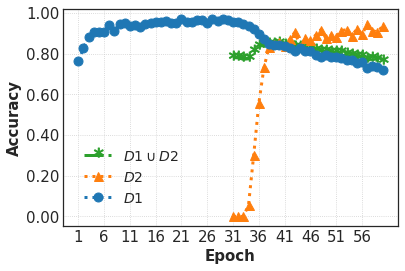

weighted f1 scores
y1 max:  0.971488878021017
y2 d1 max:  0.9541972015319531
y2 d2 max:  0.9847328244274809
y2 d1&d2 max:  0.8510560634514918


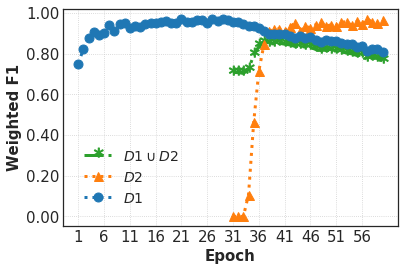

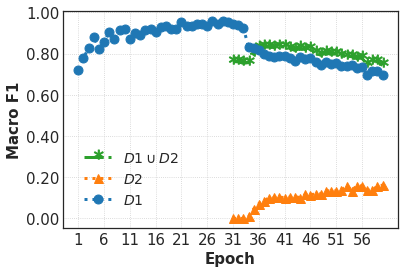

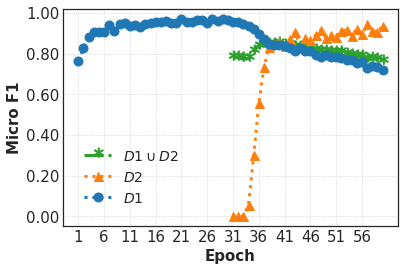

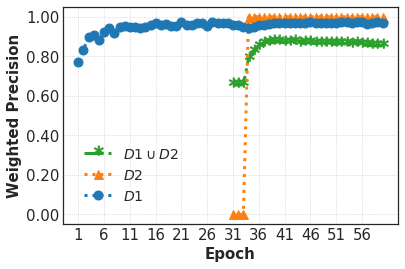

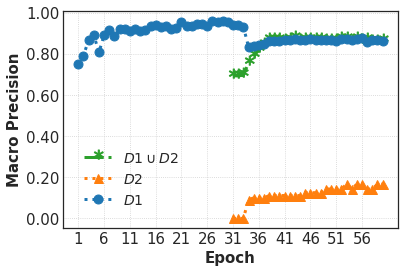

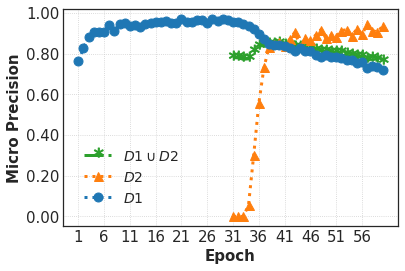

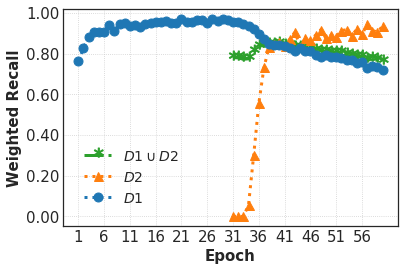

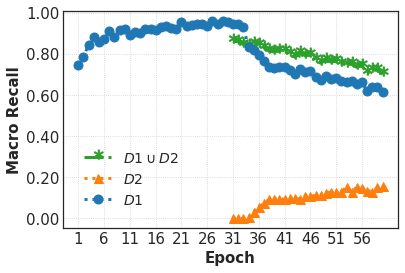

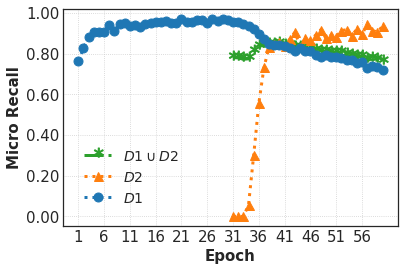

The shape of the train dataset is [[ 0.95774457 -0.80785272 -0.62090393 ... -0.82398156 -0.8817801
   0.59414878]
 [ 0.95774457 -0.80785272 -0.68247287 ... -0.82398156 -0.8817801
   0.63852889]
 [ 0.88395822 -0.80785272 -0.68247287 ... -0.73677349 -0.86303238
   0.59414878]
 ...
 [-0.73934137 -0.37654066 -0.77482628 ...  0.74576359 -0.41308717
   0.46100845]
 [-0.73934137 -0.37654066 -0.74404181 ...  0.74576359 -0.43183489
   0.46100845]
 [-0.70244819 -0.37654066 -0.77482628 ...  0.78936762 -0.43183489
   0.50538856]], and the labels is [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
The shape of the val dataset is [[-1.85943780e-01 -5.92196690e-01 -6.82472871e-01 ...  2.22515209e-01
  -6.00564342e-01  5.49768669e-01]
 [-1.47791758e-03 -2.46248469e-01 -7.44041811e-01 ... -8.27130148e-02
  -7.31798363e-01  4.16628339e-01]
 [ 2.93667462e-01 -6.79806954e-01 -7.44041811e-01 ... -5.18753334e-01
  -8.63032384e-01  4.61008449e-01]
 ...
 [-9.60700401e-01  1.47899980e+00 -6.20903930e-01 ...  5.277434

  <SOLVER>   | Task: 1/2 | training loss: 2.29 | training precision: 0.0938 |:   0%|          | 0/11220 [00:00<?, ?it/s]

total data size of train_D1 is 11939
total data size of test_D1 is 1330
total data size of train_D2 is 1178
total data size of test_D2 is 126
args fc_lay: 1 fc_units: 32 fc_nl: relu lr: 0.010000 batch: 32

 --> task:          sensor2-class
 --> model:         LSTM([33 X 60]_c11)
 --> hyper-params:  i11220-lr0.01-b32-adam
 --> EWC:           EWC10000000-N
sensor2-class--LSTM([33 X 60]_c11)--i11220-lr0.01-b32-adam--EWC10000000-N


Model-name: "LSTM([33 X 60]_c11)"
----------------------------------------MAIN MODEL----------------------------------------
Classifier(
  (flatten): Flatten()
  (lstm_input_dropout): Dropout(p=0.2)
  (lstm): LSTM(60, 32, batch_first=True)
  (lstm_fc): Linear(in_features=32, out_features=11, bias=True)
)
------------------------------------------------------------------------------------------
--> this network has 12395 parameters (~0.0 million)
      of which: - learnable: 12395 (~0.0 million)
                - fixed: 0 (~0.0 million)
-------------------------

  <SOLVER>   | Task: 1/2 | training loss: 1.03 | training precision: 0.594 |:   3%|▎         | 376/11220 [00:27<24:43,  7.31it/s] 

Epoch 1 best model saved with weighted f1: 0.6859503923677543


  <SOLVER>   | Task: 1/2 | training loss: 0.686 | training precision: 0.812 |:   7%|▋         | 750/11220 [00:54<08:31, 20.49it/s]

Epoch 2 best model saved with weighted f1: 0.78768015224717


  <SOLVER>   | Task: 1/2 | training loss: 0.564 | training precision: 0.812 |:  17%|█▋        | 1872/11220 [02:14<20:23,  7.64it/s]

Epoch 5 best model saved with weighted f1: 0.8244724526329239


  <SOLVER>   | Task: 1/2 | training loss: 0.354 | training precision: 0.906 |:  20%|██        | 2247/11220 [02:43<15:00,  9.96it/s]

Epoch 6 best model saved with weighted f1: 0.8331733483250887


  <SOLVER>   | Task: 1/2 | training loss: 0.471 | training precision: 0.812 |:  27%|██▋       | 2994/11220 [03:34<20:23,  6.72it/s]

Epoch 8 best model saved with weighted f1: 0.8378831480364995


  <SOLVER>   | Task: 1/2 | training loss: 0.298 | training precision: 0.906 |:  33%|███▎      | 3744/11220 [04:25<08:58, 13.89it/s]

Epoch 10 best model saved with weighted f1: 0.8641008763525568


  <SOLVER>   | Task: 1/2 | training loss: 0.32 | training precision: 0.812 |:  97%|█████████▋| 10849/11220 [13:18<00:41,  8.91it/s] 

Epoch 29 best model saved with weighted f1: 0.866453536911325


  <SOLVER>   | Task: 1/2 | training loss: 0.377 | training precision: 0.812 |: 100%|██████████| 11220/11220 [13:48<00:00, 13.54it/s]
  <SOLVER>   | Task: 1/2 | training loss: 2.29 | training precision: 0.156 |:   0%|          | 2/11220 [00:00<12:41, 14.73it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6774436090225564, 0.7924812030075188, 0.750375939849624, 0.7781954887218046, 0.8233082706766918, 0.8368421052631579, 0.8270676691729323, 0.8345864661654135, 0.8323308270676691, 0.8616541353383459, 0.8270676691729323, 0.8270676691729323, 0.8548872180451128, 0.8413533834586466, 0.8466165413533835, 0.8466165413533835, 0.8556390977443609, 0.8473684210526315, 0.8443609022556391, 0.8406015037593985, 0.849624060150376, 0.8210526315789474, 0.856390977443609, 0.8406015037593985, 0.843609022556391, 0.8586466165413534, 0.8593984962406015, 0.8488721804511278, 0.8646616541353384, 0.8428571428571429], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6774436090225564, 0.7924812030075188, 0.750375939849624, 0.7781954887218046, 0.8233082706766918, 0.8368421052631579, 0.8270676691729323, 0.8345864661654135, 0.8323308270676691, 0.8616541353383459, 0.8270676691729323, 0.8270676691729323, 0.8548872180451128, 0.8413533834586466, 0

  <SOLVER>   | Task: 1/2 | training loss: 1.09 | training precision: 0.688 |:   3%|▎         | 376/11220 [00:24<21:18,  8.48it/s] 

Epoch 1 best model saved with weighted f1: 0.6609006375359304


  <SOLVER>   | Task: 1/2 | training loss: 0.702 | training precision: 0.812 |:   7%|▋         | 750/11220 [00:53<19:50,  8.79it/s]

Epoch 2 best model saved with weighted f1: 0.763783344691608


  <SOLVER>   | Task: 1/2 | training loss: 0.652 | training precision: 0.75 |:  10%|█         | 1126/11220 [01:18<17:18,  9.72it/s] 

Epoch 3 best model saved with weighted f1: 0.7671409876824017


  <SOLVER>   | Task: 1/2 | training loss: 0.365 | training precision: 0.812 |:  13%|█▎        | 1498/11220 [01:45<22:33,  7.18it/s]

Epoch 4 best model saved with weighted f1: 0.8188386152047744


  <SOLVER>   | Task: 1/2 | training loss: 0.365 | training precision: 0.875 |:  17%|█▋        | 1872/11220 [02:13<19:58,  7.80it/s]

Epoch 5 best model saved with weighted f1: 0.82936803755136


  <SOLVER>   | Task: 1/2 | training loss: 0.393 | training precision: 0.812 |:  20%|██        | 2247/11220 [02:39<16:27,  9.08it/s]

Epoch 6 best model saved with weighted f1: 0.8358392900538905


  <SOLVER>   | Task: 1/2 | training loss: 0.304 | training precision: 0.844 |:  30%|███       | 3370/11220 [03:54<11:16, 11.61it/s]

Epoch 9 best model saved with weighted f1: 0.8583277198620406


  <SOLVER>   | Task: 1/2 | training loss: 0.312 | training precision: 0.875 |:  37%|███▋      | 4117/11220 [04:47<11:56,  9.91it/s]

Epoch 11 best model saved with weighted f1: 0.8612900443448968


  <SOLVER>   | Task: 1/2 | training loss: 0.336 | training precision: 0.906 |:  50%|█████     | 5612/11220 [06:33<16:47,  5.57it/s] 

Epoch 15 best model saved with weighted f1: 0.8820202259328686


  <SOLVER>   | Task: 1/2 | training loss: 0.382 | training precision: 0.844 |:  77%|███████▋  | 8606/11220 [09:55<04:06, 10.62it/s] 

Epoch 23 best model saved with weighted f1: 0.8840950169568762


  <SOLVER>   | Task: 1/2 | training loss: 0.127 | training precision: 0.938 |:  90%|█████████ | 10101/11220 [11:35<01:39, 11.28it/s]

Epoch 27 best model saved with weighted f1: 0.8853755657829773


  <SOLVER>   | Task: 1/2 | training loss: 0.266 | training precision: 0.875 |: 100%|██████████| 11220/11220 [12:48<00:00, 14.59it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.2 | training precision: 0.344 |:   0%|          | 2/11220 [00:00<14:13, 13.14it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6533834586466165, 0.7631578947368421, 0.7609022556390977, 0.8165413533834587, 0.8285714285714286, 0.8360902255639098, 0.8067669172932331, 0.8263157894736842, 0.8541353383458646, 0.8428571428571429, 0.8593984962406015, 0.8556390977443609, 0.8586466165413534, 0.8308270676691729, 0.8796992481203008, 0.8548872180451128, 0.862406015037594, 0.8533834586466166, 0.862406015037594, 0.8631578947368421, 0.8751879699248121, 0.8781954887218045, 0.8819548872180452, 0.8766917293233083, 0.8744360902255639, 0.8751879699248121, 0.8834586466165414, 0.8789473684210526, 0.8706766917293233, 0.8751879699248121], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6533834586466165, 0.7631578947368421, 0.7609022556390977, 0.8165413533834587, 0.8285714285714286, 0.8360902255639098, 0.8067669172932331, 0.8263157894736842, 0.8541353383458646, 0.8428571428571429, 0.8593984962406015, 0.8556390977443609, 0.8586466165413534, 0.8308270676691729

  <SOLVER>   | Task: 1/2 | training loss: 1.15 | training precision: 0.531 |:   3%|▎         | 375/11220 [00:32<23:22,  7.73it/s] 

Epoch 1 best model saved with weighted f1: 0.7050814647453174


  <SOLVER>   | Task: 1/2 | training loss: 0.542 | training precision: 0.844 |:   7%|▋         | 750/11220 [01:02<21:06,  8.27it/s]

Epoch 2 best model saved with weighted f1: 0.7802718622226469


  <SOLVER>   | Task: 1/2 | training loss: 0.771 | training precision: 0.75 |:  10%|█         | 1124/11220 [01:30<20:22,  8.26it/s] 

Epoch 3 best model saved with weighted f1: 0.8062107480539698


  <SOLVER>   | Task: 1/2 | training loss: 0.482 | training precision: 0.875 |:  13%|█▎        | 1496/11220 [01:59<14:34, 11.12it/s]

Epoch 4 best model saved with weighted f1: 0.8376349179250789


  <SOLVER>   | Task: 1/2 | training loss: 0.336 | training precision: 0.781 |:  27%|██▋       | 2994/11220 [03:59<15:29,  8.85it/s]

Epoch 8 best model saved with weighted f1: 0.8612535844834961


  <SOLVER>   | Task: 1/2 | training loss: 0.266 | training precision: 0.906 |:  33%|███▎      | 3743/11220 [05:02<11:06, 11.21it/s] 

Epoch 10 best model saved with weighted f1: 0.8638641828684166


  <SOLVER>   | Task: 1/2 | training loss: 0.297 | training precision: 0.875 |:  50%|█████     | 5610/11220 [07:34<05:30, 16.99it/s] 

Epoch 15 best model saved with weighted f1: 0.8665653278217554


  <SOLVER>   | Task: 1/2 | training loss: 0.413 | training precision: 0.844 |:  60%|██████    | 6733/11220 [09:05<11:39,  6.41it/s] 

Epoch 18 best model saved with weighted f1: 0.8677533448600134


  <SOLVER>   | Task: 1/2 | training loss: 0.396 | training precision: 0.844 |:  63%|██████▎   | 7106/11220 [09:36<05:22, 12.76it/s] 

Epoch 19 best model saved with weighted f1: 0.8697251581582205


  <SOLVER>   | Task: 1/2 | training loss: 0.12 | training precision: 0.938 |:  77%|███████▋  | 8604/11220 [11:42<07:54,  5.51it/s]  

Epoch 23 best model saved with weighted f1: 0.8736475227143732


  <SOLVER>   | Task: 1/2 | training loss: 0.549 | training precision: 0.719 |:  87%|████████▋ | 9726/11220 [13:15<03:16,  7.61it/s] 

Epoch 26 best model saved with weighted f1: 0.8766940008542681


  <SOLVER>   | Task: 1/2 | training loss: 0.452 | training precision: 0.812 |:  90%|████████▉ | 10097/11220 [13:46<01:19, 14.15it/s] 

Epoch 27 best model saved with weighted f1: 0.8840014473506221


  <SOLVER>   | Task: 1/2 | training loss: 0.331 | training precision: 0.938 |: 100%|██████████| 11220/11220 [15:25<00:00, 12.13it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.37 | training precision: 0.0625 |:   0%|          | 2/11220 [00:00<13:30, 13.84it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7045112781954888, 0.7894736842105263, 0.8052631578947368, 0.843609022556391, 0.7872180451127819, 0.8240601503759398, 0.8458646616541353, 0.8556390977443609, 0.8330827067669173, 0.862406015037594, 0.8345864661654135, 0.8338345864661654, 0.8421052631578947, 0.8473684210526315, 0.8654135338345864, 0.8511278195488722, 0.8368421052631579, 0.8654135338345864, 0.8699248120300752, 0.8586466165413534, 0.8368421052631579, 0.856390977443609, 0.8706766917293233, 0.8646616541353384, 0.869172932330827, 0.8744360902255639, 0.8819548872180452, 0.8766917293233083, 0.8518796992481203, 0.869172932330827], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7045112781954888, 0.7894736842105263, 0.8052631578947368, 0.843609022556391, 0.7872180451127819, 0.8240601503759398, 0.8458646616541353, 0.8556390977443609, 0.8330827067669173, 0.862406015037594, 0.8345864661654135, 0.8338345864661654, 0.8421052631578947, 0.8473684210526315, 0.8

  <SOLVER>   | Task: 1/2 | training loss: 0.634 | training precision: 0.75 |:   3%|▎         | 375/11220 [00:29<30:49,  5.86it/s] 

Epoch 1 best model saved with weighted f1: 0.6659204362907163


  <SOLVER>   | Task: 1/2 | training loss: 0.531 | training precision: 0.781 |:   7%|▋         | 749/11220 [00:57<23:05,  7.56it/s]

Epoch 2 best model saved with weighted f1: 0.7456358900280787


  <SOLVER>   | Task: 1/2 | training loss: 0.396 | training precision: 0.875 |:  10%|█         | 1124/11220 [01:28<23:36,  7.13it/s]

Epoch 3 best model saved with weighted f1: 0.7816424141977933


  <SOLVER>   | Task: 1/2 | training loss: 0.294 | training precision: 0.938 |:  13%|█▎        | 1498/11220 [01:57<23:11,  6.99it/s]

Epoch 4 best model saved with weighted f1: 0.8382289680493663


  <SOLVER>   | Task: 1/2 | training loss: 0.238 | training precision: 0.875 |:  20%|██        | 2247/11220 [02:54<18:12,  8.22it/s]

Epoch 6 best model saved with weighted f1: 0.8424545614430369


  <SOLVER>   | Task: 1/2 | training loss: 0.526 | training precision: 0.812 |:  23%|██▎       | 2621/11220 [03:24<22:17,  6.43it/s]

Epoch 7 best model saved with weighted f1: 0.8722471603115354


  <SOLVER>   | Task: 1/2 | training loss: 0.282 | training precision: 0.844 |:  33%|███▎      | 3741/11220 [04:54<14:26,  8.63it/s] 

Epoch 10 best model saved with weighted f1: 0.8724201199950954


  <SOLVER>   | Task: 1/2 | training loss: 0.224 | training precision: 0.906 |:  53%|█████▎    | 5987/11220 [07:59<10:01,  8.69it/s] 

Epoch 16 best model saved with weighted f1: 0.8818591208752985


  <SOLVER>   | Task: 1/2 | training loss: 0.201 | training precision: 0.875 |:  63%|██████▎   | 7108/11220 [09:25<09:34,  7.15it/s] 

Epoch 19 best model saved with weighted f1: 0.8862177010711668


  <SOLVER>   | Task: 1/2 | training loss: 0.45 | training precision: 0.844 |:  70%|███████   | 7855/11220 [10:27<08:49,  6.36it/s]  

Epoch 21 best model saved with weighted f1: 0.9040210226731167


  <SOLVER>   | Task: 1/2 | training loss: 0.145 | training precision: 0.906 |:  93%|█████████▎| 10474/11220 [14:00<01:33,  7.97it/s] 

Epoch 28 best model saved with weighted f1: 0.9065174534959834


  <SOLVER>   | Task: 1/2 | training loss: 0.164 | training precision: 0.938 |: 100%|██████████| 11220/11220 [15:00<00:00, 12.45it/s] 
  0%|          | 0/11220 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6646616541353384, 0.7458646616541353, 0.7849624060150376, 0.8413533834586466, 0.806015037593985, 0.8428571428571429, 0.8714285714285714, 0.8526315789473684, 0.843609022556391, 0.8714285714285714, 0.868421052631579, 0.8699248120300752, 0.8511278195488722, 0.8556390977443609, 0.8669172932330828, 0.8796992481203008, 0.8631578947368421, 0.8766917293233083, 0.8842105263157894, 0.8699248120300752, 0.9022556390977443, 0.8857142857142857, 0.8699248120300752, 0.8924812030075188, 0.8842105263157894, 0.8902255639097745, 0.8819548872180452, 0.9045112781954887, 0.8894736842105263, 0.8924812030075188], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6646616541353384, 0.7458646616541353, 0.7849624060150376, 0.8413533834586466, 0.806015037593985, 0.8428571428571429, 0.8714285714285714, 0.8526315789473684, 0.843609022556391, 0.8714285714285714, 0.868421052631579, 0.8699248120300752, 0.8511278195488722, 0.8556390977443609, 0.

  <SOLVER>   | Task: 1/2 | training loss: 0.88 | training precision: 0.594 |:   3%|▎         | 376/11220 [00:52<32:19,  5.59it/s] 

Epoch 1 best model saved with weighted f1: 0.6276391300668278


  <SOLVER>   | Task: 1/2 | training loss: 0.658 | training precision: 0.688 |:   7%|▋         | 749/11220 [01:46<46:19,  3.77it/s]

Epoch 2 best model saved with weighted f1: 0.7330999532458794


  <SOLVER>   | Task: 1/2 | training loss: 0.591 | training precision: 0.75 |:  10%|█         | 1123/11220 [02:40<49:03,  3.43it/s] 

Epoch 3 best model saved with weighted f1: 0.7379236912072508


  <SOLVER>   | Task: 1/2 | training loss: 0.336 | training precision: 0.906 |:  13%|█▎        | 1496/11220 [03:33<17:36,  9.20it/s]

Epoch 4 best model saved with weighted f1: 0.7725888068162452


  <SOLVER>   | Task: 1/2 | training loss: 0.207 | training precision: 0.938 |:  17%|█▋        | 1871/11220 [04:29<52:53,  2.95it/s]

Epoch 5 best model saved with weighted f1: 0.7874277161149441


  <SOLVER>   | Task: 1/2 | training loss: 0.314 | training precision: 0.844 |:  20%|██        | 2245/11220 [05:26<47:17,  3.16it/s]

Epoch 6 best model saved with weighted f1: 0.8015585406464442


  <SOLVER>   | Task: 1/2 | training loss: 0.448 | training precision: 0.812 |:  23%|██▎       | 2618/11220 [06:20<21:08,  6.78it/s]

Epoch 7 best model saved with weighted f1: 0.8268039130738684


  <SOLVER>   | Task: 1/2 | training loss: 0.339 | training precision: 0.875 |:  30%|███       | 3367/11220 [08:11<24:37,  5.32it/s]

Epoch 9 best model saved with weighted f1: 0.8268109505428086


  <SOLVER>   | Task: 1/2 | training loss: 0.367 | training precision: 0.844 |:  37%|███▋      | 4115/11220 [10:01<40:28,  2.93it/s]

Epoch 11 best model saved with weighted f1: 0.8330897049133253


  <SOLVER>   | Task: 1/2 | training loss: 0.376 | training precision: 0.844 |:  47%|████▋     | 5237/11220 [12:51<31:32,  3.16it/s]

Epoch 14 best model saved with weighted f1: 0.8468391157601237


  <SOLVER>   | Task: 1/2 | training loss: 0.306 | training precision: 0.906 |:  53%|█████▎    | 5985/11220 [14:40<28:13,  3.09it/s] 

Epoch 16 best model saved with weighted f1: 0.8512297308026034


  <SOLVER>   | Task: 1/2 | training loss: 0.121 | training precision: 1.0 |:  60%|██████    | 6732/11220 [16:29<08:25,  8.88it/s]  

Epoch 18 best model saved with weighted f1: 0.8729117744861062


  <SOLVER>   | Task: 1/2 | training loss: 0.288 | training precision: 0.875 |: 100%|██████████| 11220/11220 [28:22<00:00,  6.59it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.34 | training precision: 0.0625 |:   0%|          | 0/11220 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6390977443609023, 0.7338345864661654, 0.7323308270676692, 0.7676691729323308, 0.7917293233082707, 0.8007518796992481, 0.8285714285714286, 0.7917293233082707, 0.8293233082706767, 0.812781954887218, 0.8285714285714286, 0.8210526315789474, 0.8270676691729323, 0.8443609022556391, 0.8067669172932331, 0.8481203007518797, 0.8338345864661654, 0.8699248120300752, 0.8601503759398497, 0.8473684210526315, 0.8533834586466166, 0.8511278195488722, 0.8699248120300752, 0.8315789473684211, 0.8654135338345864, 0.8526315789473684, 0.8481203007518797, 0.8443609022556391, 0.8586466165413534, 0.868421052631579], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6390977443609023, 0.7338345864661654, 0.7323308270676692, 0.7676691729323308, 0.7917293233082707, 0.8007518796992481, 0.8285714285714286, 0.7917293233082707, 0.8293233082706767, 0.812781954887218, 0.8285714285714286, 0.8210526315789474, 0.8270676691729323, 0.8443609022556391,

  <SOLVER>   | Task: 1/2 | training loss: 0.899 | training precision: 0.594 |:   3%|▎         | 376/11220 [00:36<23:58,  7.54it/s]

Epoch 1 best model saved with weighted f1: 0.6135717294103935


  <SOLVER>   | Task: 1/2 | training loss: 0.552 | training precision: 0.812 |:   7%|▋         | 748/11220 [01:26<28:09,  6.20it/s]

Epoch 2 best model saved with weighted f1: 0.746356672355435


  <SOLVER>   | Task: 1/2 | training loss: 0.523 | training precision: 0.812 |:  13%|█▎        | 1498/11220 [03:09<27:32,  5.88it/s]

Epoch 4 best model saved with weighted f1: 0.757052752302372


  <SOLVER>   | Task: 1/2 | training loss: 0.345 | training precision: 0.906 |:  17%|█▋        | 1871/11220 [04:04<1:14:38,  2.09it/s]

Epoch 5 best model saved with weighted f1: 0.7828482527467867


  <SOLVER>   | Task: 1/2 | training loss: 0.303 | training precision: 0.875 |:  20%|██        | 2244/11220 [04:57<16:35,  9.01it/s]  

Epoch 6 best model saved with weighted f1: 0.7903039200672842


  <SOLVER>   | Task: 1/2 | training loss: 0.279 | training precision: 0.969 |:  23%|██▎       | 2619/11220 [05:49<54:39,  2.62it/s]

Epoch 7 best model saved with weighted f1: 0.8335936921810332


  <SOLVER>   | Task: 1/2 | training loss: 0.338 | training precision: 0.938 |:  27%|██▋       | 2993/11220 [06:41<44:07,  3.11it/s]

Epoch 8 best model saved with weighted f1: 0.8515083574079366


  <SOLVER>   | Task: 1/2 | training loss: 0.447 | training precision: 0.812 |:  40%|████      | 4489/11220 [09:55<30:16,  3.71it/s]

Epoch 12 best model saved with weighted f1: 0.8595724749165855


  <SOLVER>   | Task: 1/2 | training loss: 0.348 | training precision: 0.875 |:  53%|█████▎    | 5986/11220 [13:13<14:26,  6.04it/s]

Epoch 16 best model saved with weighted f1: 0.8619309780549749


  <SOLVER>   | Task: 1/2 | training loss: 0.289 | training precision: 0.844 |:  63%|██████▎   | 7106/11220 [15:38<10:04,  6.81it/s]

Epoch 19 best model saved with weighted f1: 0.870876133571363


  <SOLVER>   | Task: 1/2 | training loss: 0.173 | training precision: 0.938 |:  87%|████████▋ | 9725/11220 [21:32<08:22,  2.98it/s] 

Epoch 26 best model saved with weighted f1: 0.8769783666948034


  <SOLVER>   | Task: 1/2 | training loss: 0.351 | training precision: 0.844 |:  97%|█████████▋| 10847/11220 [24:04<02:11,  2.84it/s]

Epoch 29 best model saved with weighted f1: 0.8785926277469236


  <SOLVER>   | Task: 1/2 | training loss: 0.256 | training precision: 0.844 |: 100%|██████████| 11220/11220 [24:53<00:00,  7.51it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.3 | training precision: 0.0312 |:   0%|          | 1/11220 [00:00<22:12,  8.42it/s]

Epoch 30 best model saved with weighted f1: 0.8804072658117782
precision_dict:  {'per_task_weighted_rec': [[0.6218045112781955, 0.7518796992481203, 0.7218045112781954, 0.7586466165413533, 0.793984962406015, 0.7969924812030075, 0.8330827067669173, 0.850375939849624, 0.8360902255639098, 0.8308270676691729, 0.8398496240601504, 0.8578947368421053, 0.850375939849624, 0.8285714285714286, 0.8466165413533835, 0.8601503759398497, 0.8526315789473684, 0.8443609022556391, 0.8706766917293233, 0.8676691729323308, 0.856390977443609, 0.862406015037594, 0.8669172932330828, 0.856390977443609, 0.8639097744360902, 0.8759398496240601, 0.8706766917293233, 0.869172932330827, 0.8781954887218045, 0.8789473684210526], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6218045112781955, 0.7518796992481203, 0.7218045112781954, 0.7586466165413533, 0.793984962406015, 0.7969924812030075, 0.8330827067669173, 0.850375939849624, 0.8360902255639098, 0.8308270676691729, 0.8398496240601504, 0.

  <SOLVER>   | Task: 1/2 | training loss: 0.837 | training precision: 0.656 |:   3%|▎         | 374/11220 [01:06<32:08,  5.62it/s]

Epoch 1 best model saved with weighted f1: 0.6068560971075875


  <SOLVER>   | Task: 1/2 | training loss: 0.628 | training precision: 0.688 |:   7%|▋         | 749/11220 [02:16<1:06:57,  2.61it/s]

Epoch 2 best model saved with weighted f1: 0.7266542014241426


  <SOLVER>   | Task: 1/2 | training loss: 0.541 | training precision: 0.844 |:  10%|█         | 1122/11220 [03:24<24:37,  6.83it/s] 

Epoch 3 best model saved with weighted f1: 0.7600590922257309


  <SOLVER>   | Task: 1/2 | training loss: 0.48 | training precision: 0.781 |:  17%|█▋        | 1871/11220 [05:34<1:00:42,  2.57it/s] 

Epoch 5 best model saved with weighted f1: 0.8240938688409413


  <SOLVER>   | Task: 1/2 | training loss: 0.46 | training precision: 0.875 |:  27%|██▋       | 2993/11220 [08:47<59:26,  2.31it/s]   

Epoch 8 best model saved with weighted f1: 0.8267739575385536


  <SOLVER>   | Task: 1/2 | training loss: 0.212 | training precision: 0.938 |:  30%|███       | 3367/11220 [09:50<49:07,  2.66it/s]

Epoch 9 best model saved with weighted f1: 0.8595025090018517


  <SOLVER>   | Task: 1/2 | training loss: 0.283 | training precision: 0.875 |:  53%|█████▎    | 5985/11220 [17:30<26:59,  3.23it/s] 

Epoch 16 best model saved with weighted f1: 0.8620432135856652


  <SOLVER>   | Task: 1/2 | training loss: 0.638 | training precision: 0.781 |:  73%|███████▎  | 8229/11220 [24:23<16:35,  3.00it/s] 

Epoch 22 best model saved with weighted f1: 0.8724403370005891


  <SOLVER>   | Task: 1/2 | training loss: 0.375 | training precision: 0.844 |: 100%|██████████| 11220/11220 [33:59<00:00,  5.50it/s] 
  0%|          | 0/11220 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6300751879699248, 0.7293233082706767, 0.7721804511278195, 0.7563909774436091, 0.8210526315789474, 0.8045112781954887, 0.793984962406015, 0.8233082706766918, 0.8541353383458646, 0.825563909774436, 0.8300751879699249, 0.8323308270676691, 0.8526315789473684, 0.8466165413533835, 0.850375939849624, 0.8593984962406015, 0.8488721804511278, 0.8353383458646616, 0.8511278195488722, 0.8473684210526315, 0.8473684210526315, 0.8721804511278195, 0.8451127819548873, 0.843609022556391, 0.8541353383458646, 0.8481203007518797, 0.8466165413533835, 0.8541353383458646, 0.8413533834586466, 0.8112781954887218], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6300751879699248, 0.7293233082706767, 0.7721804511278195, 0.7563909774436091, 0.8210526315789474, 0.8045112781954887, 0.793984962406015, 0.8233082706766918, 0.8541353383458646, 0.825563909774436, 0.8300751879699249, 0.8323308270676691, 0.8526315789473684, 0.8466165413533835, 0.

  <SOLVER>   | Task: 1/2 | training loss: 0.737 | training precision: 0.688 |:   3%|▎         | 375/11220 [01:07<54:54,  3.29it/s]

Epoch 1 best model saved with weighted f1: 0.662790407386475


  <SOLVER>   | Task: 1/2 | training loss: 0.576 | training precision: 0.875 |:   7%|▋         | 748/11220 [02:19<32:44,  5.33it/s]  

Epoch 2 best model saved with weighted f1: 0.7152958362658978


  <SOLVER>   | Task: 1/2 | training loss: 0.443 | training precision: 0.844 |:  10%|█         | 1123/11220 [03:24<58:57,  2.85it/s] 

Epoch 3 best model saved with weighted f1: 0.7777899036039111


  <SOLVER>   | Task: 1/2 | training loss: 0.566 | training precision: 0.781 |:  13%|█▎        | 1497/11220 [04:30<1:07:55,  2.39it/s]

Epoch 4 best model saved with weighted f1: 0.8046888576906511


  <SOLVER>   | Task: 1/2 | training loss: 0.476 | training precision: 0.781 |:  17%|█▋        | 1871/11220 [05:43<53:16,  2.92it/s]  

Epoch 5 best model saved with weighted f1: 0.8343956656788771


  <SOLVER>   | Task: 1/2 | training loss: 0.609 | training precision: 0.719 |:  20%|██        | 2245/11220 [06:49<46:45,  3.20it/s]

Epoch 6 best model saved with weighted f1: 0.8410255135347068


  <SOLVER>   | Task: 1/2 | training loss: 0.297 | training precision: 0.875 |:  23%|██▎       | 2620/11220 [07:54<37:13,  3.85it/s]

Epoch 7 best model saved with weighted f1: 0.8722973225498266


  <SOLVER>   | Task: 1/2 | training loss: 0.313 | training precision: 0.875 |:  37%|███▋      | 4115/11220 [12:24<41:51,  2.83it/s] 

Epoch 11 best model saved with weighted f1: 0.8770960892746773


  <SOLVER>   | Task: 1/2 | training loss: 0.303 | training precision: 0.875 |:  40%|████      | 4489/11220 [13:34<42:50,  2.62it/s] 

Epoch 12 best model saved with weighted f1: 0.8806041356926556


  <SOLVER>   | Task: 1/2 | training loss: 0.188 | training precision: 0.938 |:  43%|████▎     | 4863/11220 [14:44<38:17,  2.77it/s] 

Epoch 13 best model saved with weighted f1: 0.8873588537426362


  <SOLVER>   | Task: 1/2 | training loss: 0.321 | training precision: 0.875 |:  53%|█████▎    | 5985/11220 [18:09<29:37,  2.95it/s] 

Epoch 16 best model saved with weighted f1: 0.8912679323474784


  <SOLVER>   | Task: 1/2 | training loss: 0.263 | training precision: 0.906 |:  57%|█████▋    | 6359/11220 [19:17<26:00,  3.11it/s] 

Epoch 17 best model saved with weighted f1: 0.9001940983355889


  <SOLVER>   | Task: 1/2 | training loss: 0.317 | training precision: 0.844 |:  83%|████████▎ | 9351/11220 [27:48<14:04,  2.21it/s] 

Epoch 25 best model saved with weighted f1: 0.9036408996657517


  <SOLVER>   | Task: 1/2 | training loss: 0.151 | training precision: 0.938 |: 100%|██████████| 11220/11220 [32:59<00:00,  5.67it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.6533834586466165, 0.7135338345864661, 0.7849624060150376, 0.7969924812030075, 0.8398496240601504, 0.8406015037593985, 0.8699248120300752, 0.8601503759398497, 0.8676691729323308, 0.8699248120300752, 0.8759398496240601, 0.8781954887218045, 0.8857142857142857, 0.8842105263157894, 0.8804511278195488, 0.8887218045112782, 0.8977443609022556, 0.8759398496240601, 0.8879699248120301, 0.8706766917293233, 0.8887218045112782, 0.8879699248120301, 0.8894736842105263, 0.8804511278195488, 0.9015037593984963, 0.8887218045112782, 0.8924812030075188, 0.8917293233082707, 0.8887218045112782, 0.8736842105263158], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6533834586466165, 0.7135338345864661, 0.7849624060150376, 0.7969924812030075, 0.8398496240601504, 0.8406015037593985, 0.8699248120300752, 0.8601503759398497, 0.8676691729323308, 0.8699248120300752, 0.8759398496240601, 0.8781954887218045, 0.8857142857142857, 0.88421052631578

  <SOLVER>   | Task: 2/2 | training loss: 2.14 | training precision: 0.312 |:   3%|▎         | 37/1110 [00:04<01:35, 11.24it/s] 

Epoch 2 best model saved with weighted f1: 0.19999999999999998


  <SOLVER>   | Task: 2/2 | training loss: 1.43 | training precision: 0.688 |:   5%|▍         | 55/1110 [00:07<02:15,  7.80it/s]

Epoch 3 best model saved with weighted f1: 0.7272727272727273


  <SOLVER>   | Task: 2/2 | training loss: 1.06 | training precision: 0.906 |:   7%|▋         | 75/1110 [00:09<01:22, 12.52it/s]

Epoch 4 best model saved with weighted f1: 0.9137931034482758


  <SOLVER>   | Task: 2/2 | training loss: 0.837 | training precision: 0.938 |:   8%|▊         | 89/1110 [00:11<01:13, 13.95it/s]

Epoch 5 best model saved with weighted f1: 0.9879518072289156


  <SOLVER>   | Task: 2/2 | training loss: 0.71 | training precision: 0.969 |:  10%|▉         | 109/1110 [00:14<02:04,  8.03it/s] 

Epoch 6 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.212 | training precision: 1.0 |:  42%|████▏     | 471/1110 [00:58<00:56, 11.38it/s]  

Early stopping on epoch 26


  <SOLVER>   | Task: 2/2 | training loss: 0.196 | training precision: 1.0 |:  44%|████▍     | 490/1110 [01:00<00:44, 13.84it/s]

Early stopping on epoch 27


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  46%|████▌     | 506/1110 [01:03<01:10,  8.61it/s]

Early stopping on epoch 28


  <SOLVER>   | Task: 2/2 | training loss: 0.189 | training precision: 1.0 |:  47%|████▋     | 521/1110 [01:05<01:14,  7.96it/s]  

Early stopping on epoch 29


  <SOLVER>   | Task: 2/2 | training loss: 0.172 | training precision: 1.0 |:  49%|████▊     | 539/1110 [01:07<00:49, 11.54it/s]

Early stopping on epoch 30


  <SOLVER>   | Task: 2/2 | training loss: 0.153 | training precision: 1.0 |:  50%|█████     | 560/1110 [01:10<00:57,  9.64it/s]

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.167 | training precision: 1.0 |:  52%|█████▏    | 576/1110 [01:13<01:02,  8.60it/s]  

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.155 | training precision: 1.0 |:  54%|█████▎    | 594/1110 [01:15<01:01,  8.41it/s]

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.184 | training precision: 1.0 |:  55%|█████▌    | 615/1110 [01:18<00:39, 12.63it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.165 | training precision: 1.0 |:  57%|█████▋    | 631/1110 [01:20<00:49,  9.77it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.146 | training precision: 1.0 |:  58%|█████▊    | 647/1110 [01:22<00:51,  9.05it/s]  

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.152 | training precision: 1.0 |:  60%|██████    | 667/1110 [01:25<00:52,  8.40it/s]

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.146 | training precision: 1.0 |:  62%|██████▏   | 686/1110 [01:28<00:35, 11.91it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.121 | training precision: 1.0 |:  63%|██████▎   | 703/1110 [01:30<00:46,  8.70it/s]

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.129 | training precision: 1.0 |:  65%|██████▌   | 722/1110 [01:32<00:30, 12.92it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.133 | training precision: 1.0 |:  67%|██████▋   | 740/1110 [01:34<00:37,  9.97it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.122 | training precision: 1.0 |:  68%|██████▊   | 759/1110 [01:37<00:28, 12.36it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.12 | training precision: 1.0 |:  70%|██████▉   | 776/1110 [01:39<00:33, 10.05it/s]   

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.117 | training precision: 1.0 |:  72%|███████▏  | 795/1110 [01:41<00:23, 13.30it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  73%|███████▎  | 811/1110 [01:43<00:25, 11.69it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.109 | training precision: 1.0 |:  75%|███████▍  | 830/1110 [01:45<00:23, 11.83it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.16 | training precision: 1.0 |:  76%|███████▋  | 849/1110 [01:47<00:24, 10.85it/s]   

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.133 | training precision: 1.0 |:  78%|███████▊  | 863/1110 [01:49<00:21, 11.72it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.127 | training precision: 1.0 |:  80%|███████▉  | 883/1110 [01:51<00:27,  8.38it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.106 | training precision: 1.0 |:  81%|████████▏ | 903/1110 [01:54<00:18, 11.23it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.104 | training precision: 1.0 |:  83%|████████▎ | 922/1110 [01:56<00:15, 12.07it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0995 | training precision: 1.0 |:  84%|████████▍ | 937/1110 [01:58<00:18,  9.22it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.105 | training precision: 1.0 |:  86%|████████▌ | 956/1110 [02:00<00:15, 10.00it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0984 | training precision: 1.0 |:  88%|████████▊ | 975/1110 [02:02<00:10, 13.32it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0913 | training precision: 1.0 |:  89%|████████▉ | 993/1110 [02:04<00:10, 11.42it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0857 | training precision: 1.0 |:  91%|█████████ | 1011/1110 [02:07<00:09, 10.72it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0814 | training precision: 1.0 |:  93%|█████████▎| 1029/1110 [02:09<00:06, 12.58it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0876 | training precision: 1.0 |:  94%|█████████▍| 1048/1110 [02:11<00:04, 13.33it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0904 | training precision: 1.0 |:  96%|█████████▌| 1064/1110 [02:13<00:04,  9.85it/s] 

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |:  97%|█████████▋| 1081/1110 [02:16<00:03,  8.91it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0824 | training precision: 1.0 |:  99%|█████████▉| 1100/1110 [02:18<00:00, 10.16it/s] 

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0761 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:19<00:00,  7.94it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8548872180451128, 0.8142857142857143, 0.8150375939849624, 0.8263157894736842, 0.8067669172932331, 0.8105263157894737, 0.8082706766917294, 0.8090225563909774, 0.8285714285714286, 0.8368421052631579, 0.8353383458646616, 0.818796992481203, 0.8428571428571429, 0.8518796992481203, 0.8406015037593985, 0.8443609022556391, 0.8398496240601504, 0.8451127819548873, 0.843609022556391, 0.8421052631578947, 0.8473684210526315, 0.8481203007518797, 0.849624060150376, 0.8353383458646616, 0.8360902255639098, 0.8338345864661654, 0.8398496240601504, 0.8368421052631579, 0.8421052631578947, 0.837593984962406, 0.8330827067669173, 0.8383458646616542, 0.8308270676691729, 0.837593984962406, 0.8353383458646616, 0.8345864661654135, 0.8383458646616542, 0.8390977443609022, 0.8360902255639098, 0.8360902255639098, 0.8270676691729323, 0.8172932330827067, 0.8240601503759398, 0.8345864661654135, 0.825563909774436, 0.8225563909774436, 0.825563909774436, 0.8150375939849624, 0.

  <SOLVER>   | Task: 2/2 | training loss: 3.02 | training precision: 0.125 |:   3%|▎         | 38/1110 [00:04<01:42, 10.49it/s] 

Epoch 2 best model saved with weighted f1: 0.046511627906976744


  <SOLVER>   | Task: 2/2 | training loss: 2.3 | training precision: 0.375 |:   5%|▍         | 55/1110 [00:06<01:29, 11.76it/s] 

Epoch 3 best model saved with weighted f1: 0.32


  <SOLVER>   | Task: 2/2 | training loss: 1.92 | training precision: 0.562 |:   7%|▋         | 74/1110 [00:08<01:44,  9.92it/s]

Epoch 4 best model saved with weighted f1: 0.6


  <SOLVER>   | Task: 2/2 | training loss: 1.45 | training precision: 0.719 |:   8%|▊         | 91/1110 [00:10<01:32, 10.96it/s]

Epoch 5 best model saved with weighted f1: 0.7142857142857143


  <SOLVER>   | Task: 2/2 | training loss: 1.3 | training precision: 0.719 |:  10%|▉         | 109/1110 [00:13<01:26, 11.51it/s] 

Epoch 6 best model saved with weighted f1: 0.8333333333333333


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.875 |:  11%|█▏        | 127/1110 [00:15<01:29, 10.96it/s]

Epoch 7 best model saved with weighted f1: 0.8995633187772926


  <SOLVER>   | Task: 2/2 | training loss: 0.849 | training precision: 0.906 |:  13%|█▎        | 146/1110 [00:17<01:11, 13.54it/s]

Epoch 8 best model saved with weighted f1: 0.9367088607594937


  <SOLVER>   | Task: 2/2 | training loss: 0.783 | training precision: 0.969 |:  16%|█▌        | 179/1110 [00:20<01:18, 11.79it/s]

Epoch 10 best model saved with weighted f1: 0.9714285714285714


  <SOLVER>   | Task: 2/2 | training loss: 0.787 | training precision: 0.875 |:  18%|█▊        | 200/1110 [00:23<01:52,  8.09it/s]

Epoch 11 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.743 | training precision: 0.875 |:  20%|█▉        | 218/1110 [00:26<01:21, 10.94it/s]

Epoch 12 best model saved with weighted f1: 0.9879518072289156


  <SOLVER>   | Task: 2/2 | training loss: 0.602 | training precision: 0.969 |:  21%|██▏       | 236/1110 [00:28<01:08, 12.77it/s]

Epoch 13 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.583 | training precision: 0.969 |:  23%|██▎       | 254/1110 [00:30<01:11, 11.91it/s]

Epoch 14 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.193 | training precision: 1.0 |:  55%|█████▌    | 615/1110 [01:14<00:31, 15.49it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.188 | training precision: 1.0 |:  57%|█████▋    | 631/1110 [01:16<00:38, 12.42it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  59%|█████▊    | 651/1110 [01:18<00:37, 12.22it/s]

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.163 | training precision: 1.0 |:  60%|██████    | 667/1110 [01:20<00:37, 11.70it/s]  

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.157 | training precision: 1.0 |:  62%|██████▏   | 688/1110 [01:22<00:32, 12.92it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.142 | training precision: 1.0 |:  63%|██████▎   | 704/1110 [01:24<00:39, 10.27it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.149 | training precision: 1.0 |:  65%|██████▌   | 722/1110 [01:26<00:38, 10.00it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.173 | training precision: 0.969 |:  67%|██████▋   | 740/1110 [01:28<00:31, 11.76it/s]

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.126 | training precision: 1.0 |:  68%|██████▊   | 758/1110 [01:30<00:40,  8.73it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.127 | training precision: 1.0 |:  70%|███████   | 777/1110 [01:33<00:33, 10.06it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.12 | training precision: 1.0 |:  72%|███████▏  | 795/1110 [01:35<00:29, 10.58it/s]   

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.114 | training precision: 1.0 |:  73%|███████▎  | 813/1110 [01:37<00:25, 11.80it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.108 | training precision: 1.0 |:  75%|███████▍  | 829/1110 [01:39<00:35,  7.97it/s] 

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  76%|███████▋  | 848/1110 [01:42<00:25, 10.46it/s] 

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.09 | training precision: 1.0 |:  78%|███████▊  | 867/1110 [01:44<00:20, 12.12it/s]   

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.103 | training precision: 1.0 |:  80%|███████▉  | 883/1110 [01:46<00:21, 10.63it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0797 | training precision: 1.0 |:  81%|████████  | 901/1110 [01:48<00:19, 10.83it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0778 | training precision: 1.0 |:  83%|████████▎ | 920/1110 [01:50<00:18, 10.34it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0673 | training precision: 1.0 |:  85%|████████▍ | 938/1110 [01:53<00:15, 11.19it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0726 | training precision: 1.0 |:  86%|████████▌ | 955/1110 [01:55<00:16,  9.21it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0565 | training precision: 1.0 |:  88%|████████▊ | 974/1110 [01:57<00:13, 10.27it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0469 | training precision: 1.0 |:  89%|████████▉ | 992/1110 [01:59<00:10, 11.47it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0486 | training precision: 1.0 |:  91%|█████████ | 1009/1110 [02:01<00:07, 13.86it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0462 | training precision: 1.0 |:  93%|█████████▎| 1027/1110 [02:04<00:09,  9.20it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0452 | training precision: 1.0 |:  94%|█████████▍| 1045/1110 [02:06<00:06, 10.38it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0405 | training precision: 1.0 |:  96%|█████████▌| 1064/1110 [02:08<00:03, 12.77it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0358 | training precision: 1.0 |:  97%|█████████▋| 1082/1110 [02:10<00:02, 13.63it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.03 | training precision: 1.0 |:  99%|█████████▉| 1100/1110 [02:12<00:00, 10.57it/s]  

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0257 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:13<00:00,  8.32it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8714285714285714, 0.8661654135338346, 0.8669172932330828, 0.8669172932330828, 0.8714285714285714, 0.8706766917293233, 0.8661654135338346, 0.8744360902255639, 0.8714285714285714, 0.8751879699248121, 0.8729323308270677, 0.8639097744360902, 0.8654135338345864, 0.8639097744360902, 0.8639097744360902, 0.8639097744360902, 0.8586466165413534, 0.856390977443609, 0.8586466165413534, 0.8533834586466166, 0.8548872180451128, 0.8526315789473684, 0.850375939849624, 0.8428571428571429, 0.8398496240601504, 0.8383458646616542, 0.8368421052631579, 0.8338345864661654, 0.8315789473684211, 0.8293233082706767, 0.8270676691729323, 0.8270676691729323, 0.8218045112781955, 0.8210526315789474, 0.8120300751879699, 0.8105263157894737, 0.8022556390977443, 0.8015037593984963, 0.8022556390977443, 0.7947368421052632, 0.7924812030075188, 0.7842105263157895, 0.7857142857142857, 0.7819548872180451, 0.7774436090225564, 0.775187969924812, 0.7744360902255639, 0.7729323308270677

  <SOLVER>   | Task: 2/2 | training loss: 3.27 | training precision: 0.0625 |:   3%|▎         | 37/1110 [00:05<01:49,  9.80it/s]

Epoch 2 best model saved with weighted f1: 0.015748031496062992


  <SOLVER>   | Task: 2/2 | training loss: 2.57 | training precision: 0.219 |:   5%|▍         | 55/1110 [00:07<01:59,  8.80it/s] 

Epoch 3 best model saved with weighted f1: 0.2620689655172414


  <SOLVER>   | Task: 2/2 | training loss: 2.16 | training precision: 0.469 |:   7%|▋         | 73/1110 [00:10<01:52,  9.19it/s]

Epoch 4 best model saved with weighted f1: 0.4444444444444445


  <SOLVER>   | Task: 2/2 | training loss: 2.01 | training precision: 0.5 |:   8%|▊         | 92/1110 [00:12<01:22, 12.35it/s]  

Epoch 5 best model saved with weighted f1: 0.5681818181818182


  <SOLVER>   | Task: 2/2 | training loss: 1.5 | training precision: 0.719 |:  10%|▉         | 110/1110 [00:14<01:17, 12.90it/s] 

Epoch 6 best model saved with weighted f1: 0.7208121827411168


  <SOLVER>   | Task: 2/2 | training loss: 1.48 | training precision: 0.688 |:  11%|█▏        | 127/1110 [00:16<01:23, 11.71it/s]

Epoch 7 best model saved with weighted f1: 0.8


  <SOLVER>   | Task: 2/2 | training loss: 1.16 | training precision: 0.844 |:  13%|█▎        | 147/1110 [00:18<01:17, 12.38it/s]

Epoch 8 best model saved with weighted f1: 0.8387096774193548


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.875 |:  15%|█▍        | 165/1110 [00:20<01:13, 12.88it/s]

Epoch 9 best model saved with weighted f1: 0.8699551569506727


  <SOLVER>   | Task: 2/2 | training loss: 0.897 | training precision: 1.0 |:  16%|█▋        | 183/1110 [00:22<01:16, 12.08it/s]  

Epoch 10 best model saved with weighted f1: 0.8947368421052632


  <SOLVER>   | Task: 2/2 | training loss: 1.02 | training precision: 0.812 |:  18%|█▊        | 200/1110 [00:24<01:32,  9.87it/s] 

Epoch 11 best model saved with weighted f1: 0.9276595744680851


  <SOLVER>   | Task: 2/2 | training loss: 0.915 | training precision: 0.875 |:  20%|█▉        | 218/1110 [00:27<01:23, 10.62it/s]

Epoch 12 best model saved with weighted f1: 0.9367088607594937


  <SOLVER>   | Task: 2/2 | training loss: 0.809 | training precision: 0.875 |:  21%|██        | 235/1110 [00:29<01:42,  8.57it/s]

Epoch 13 best model saved with weighted f1: 0.9500000000000001


  <SOLVER>   | Task: 2/2 | training loss: 0.693 | training precision: 0.844 |:  23%|██▎       | 254/1110 [00:31<01:08, 12.54it/s]

Epoch 14 best model saved with weighted f1: 0.9672131147540983


  <SOLVER>   | Task: 2/2 | training loss: 0.648 | training precision: 0.938 |:  25%|██▍       | 272/1110 [00:33<01:08, 12.19it/s]

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.62 | training precision: 0.906 |:  26%|██▌       | 289/1110 [00:35<01:13, 11.11it/s] 

Epoch 16 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.582 | training precision: 1.0 |:  28%|██▊       | 307/1110 [00:38<01:34,  8.49it/s]  

Epoch 17 best model saved with weighted f1: 0.9960159362549801


  <SOLVER>   | Task: 2/2 | training loss: 0.485 | training precision: 0.938 |:  29%|██▉       | 327/1110 [00:40<01:00, 12.91it/s]

Epoch 18 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.109 | training precision: 1.0 |:  62%|██████▏   | 686/1110 [01:23<00:35, 11.89it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.0998 | training precision: 1.0 |:  64%|██████▎   | 705/1110 [01:26<00:34, 11.61it/s]

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0958 | training precision: 1.0 |:  65%|██████▌   | 722/1110 [01:28<00:32, 11.99it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0758 | training precision: 1.0 |:  67%|██████▋   | 740/1110 [01:29<00:30, 12.29it/s] 

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0765 | training precision: 1.0 |:  68%|██████▊   | 757/1110 [01:32<00:50,  7.03it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0622 | training precision: 1.0 |:  70%|███████   | 777/1110 [01:35<00:29, 11.11it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0525 | training precision: 1.0 |:  72%|███████▏  | 794/1110 [01:36<00:22, 14.15it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0749 | training precision: 1.0 |:  73%|███████▎  | 811/1110 [01:39<00:46,  6.40it/s]

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0416 | training precision: 1.0 |:  75%|███████▍  | 831/1110 [01:41<00:21, 13.20it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0508 | training precision: 1.0 |:  76%|███████▋  | 847/1110 [01:43<00:22, 11.74it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0384 | training precision: 1.0 |:  78%|███████▊  | 866/1110 [01:45<00:19, 12.69it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0627 | training precision: 1.0 |:  80%|███████▉  | 883/1110 [01:47<00:18, 12.15it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0348 | training precision: 1.0 |:  81%|████████▏ | 903/1110 [01:49<00:16, 12.25it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.045 | training precision: 1.0 |:  83%|████████▎ | 920/1110 [01:51<00:16, 11.41it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0233 | training precision: 1.0 |:  84%|████████▍ | 936/1110 [01:53<00:18,  9.17it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0561 | training precision: 1.0 |:  86%|████████▌ | 955/1110 [01:56<00:17,  8.80it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0299 | training precision: 1.0 |:  88%|████████▊ | 973/1110 [01:58<00:14,  9.57it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0333 | training precision: 1.0 |:  89%|████████▉ | 992/1110 [02:00<00:10, 11.07it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0179 | training precision: 1.0 |:  91%|█████████ | 1009/1110 [02:03<00:11,  8.50it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.022 | training precision: 1.0 |:  93%|█████████▎| 1028/1110 [02:05<00:08,  9.71it/s] 

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0241 | training precision: 1.0 |:  94%|█████████▍| 1048/1110 [02:07<00:04, 15.04it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.026 | training precision: 1.0 |:  96%|█████████▌| 1063/1110 [02:09<00:03, 11.79it/s] 

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0202 | training precision: 1.0 |:  97%|█████████▋| 1082/1110 [02:11<00:02, 12.85it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0213 | training precision: 1.0 |:  99%|█████████▉| 1101/1110 [02:13<00:00, 12.61it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0126 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:15<00:00,  8.22it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8774436090225564, 0.8774436090225564, 0.8774436090225564, 0.8751879699248121, 0.8766917293233083, 0.8751879699248121, 0.8774436090225564, 0.8781954887218045, 0.8789473684210526, 0.8804511278195488, 0.8789473684210526, 0.8796992481203008, 0.8796992481203008, 0.8781954887218045, 0.8774436090225564, 0.8781954887218045, 0.868421052631579, 0.8616541353383459, 0.862406015037594, 0.8556390977443609, 0.8571428571428571, 0.8533834586466166, 0.849624060150376, 0.843609022556391, 0.8390977443609022, 0.837593984962406, 0.8345864661654135, 0.8315789473684211, 0.8240601503759398, 0.8210526315789474, 0.8195488721804511, 0.8090225563909774, 0.8037593984962406, 0.8015037593984963, 0.7947368421052632, 0.7902255639097744, 0.7872180451127819, 0.7842105263157895, 0.7819548872180451, 0.7819548872180451, 0.7774436090225564, 0.7721804511278195, 0.7721804511278195, 0.7699248120300752, 0.7676691729323308, 0.7654135338345864, 0.7631578947368421, 0.7609022556390977, 

  <SOLVER>   | Task: 2/2 | training loss: 2.16 | training precision: 0.125 |:  13%|█▎        | 144/1110 [00:16<01:19, 12.20it/s] 

Epoch 8 best model saved with weighted f1: 0.03125


  <SOLVER>   | Task: 2/2 | training loss: 1.75 | training precision: 0.219 |:  15%|█▍        | 164/1110 [00:19<01:45,  8.93it/s] 

Epoch 9 best model saved with weighted f1: 0.0909090909090909


  <SOLVER>   | Task: 2/2 | training loss: 1.32 | training precision: 0.375 |:  16%|█▋        | 182/1110 [00:21<01:23, 11.16it/s]

Epoch 10 best model saved with weighted f1: 0.25


  <SOLVER>   | Task: 2/2 | training loss: 1.19 | training precision: 0.531 |:  18%|█▊        | 198/1110 [00:24<01:49,  8.33it/s]

Epoch 11 best model saved with weighted f1: 0.5088757396449703


  <SOLVER>   | Task: 2/2 | training loss: 0.836 | training precision: 0.781 |:  20%|█▉        | 217/1110 [00:26<01:17, 11.48it/s]

Epoch 12 best model saved with weighted f1: 0.6451612903225806


  <SOLVER>   | Task: 2/2 | training loss: 0.725 | training precision: 0.844 |:  21%|██▏       | 236/1110 [00:28<01:20, 10.84it/s]

Epoch 13 best model saved with weighted f1: 0.8898678414096917


  <SOLVER>   | Task: 2/2 | training loss: 0.516 | training precision: 0.844 |:  23%|██▎       | 254/1110 [00:30<01:08, 12.48it/s]

Epoch 14 best model saved with weighted f1: 0.9322033898305084


  <SOLVER>   | Task: 2/2 | training loss: 0.481 | training precision: 0.844 |:  24%|██▍       | 271/1110 [00:33<01:32,  9.05it/s]

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.46 | training precision: 0.906 |:  26%|██▌       | 291/1110 [00:35<01:14, 11.04it/s] 

Epoch 16 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.371 | training precision: 0.938 |:  28%|██▊       | 309/1110 [00:37<01:01, 12.96it/s]

Epoch 17 best model saved with weighted f1: 0.9960159362549801


  <SOLVER>   | Task: 2/2 | training loss: 0.242 | training precision: 1.0 |:  31%|███       | 344/1110 [00:41<01:03, 12.08it/s]  

Epoch 19 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.0507 | training precision: 1.0 |:  63%|██████▎   | 704/1110 [01:22<00:33, 12.28it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0565 | training precision: 1.0 |:  65%|██████▌   | 723/1110 [01:24<00:32, 11.89it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.049 | training precision: 1.0 |:  67%|██████▋   | 739/1110 [01:26<00:28, 12.94it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0351 | training precision: 1.0 |:  68%|██████▊   | 757/1110 [01:28<00:30, 11.65it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0367 | training precision: 1.0 |:  70%|██████▉   | 776/1110 [01:30<00:30, 11.07it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0311 | training precision: 1.0 |:  72%|███████▏  | 795/1110 [01:33<00:32,  9.74it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.024 | training precision: 1.0 |:  73%|███████▎  | 813/1110 [01:35<00:26, 11.16it/s] 

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.023 | training precision: 1.0 |:  75%|███████▍  | 829/1110 [01:37<00:28,  9.93it/s] 

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0367 | training precision: 1.0 |:  76%|███████▋  | 849/1110 [01:40<00:21, 11.98it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0321 | training precision: 1.0 |:  78%|███████▊  | 866/1110 [01:42<00:22, 10.92it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0349 | training precision: 1.0 |:  80%|███████▉  | 884/1110 [01:44<00:20, 10.82it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0233 | training precision: 1.0 |:  81%|████████▏ | 902/1110 [01:46<00:18, 11.44it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0347 | training precision: 1.0 |:  83%|████████▎ | 920/1110 [01:48<00:16, 11.53it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0169 | training precision: 1.0 |:  84%|████████▍ | 937/1110 [01:51<00:20,  8.25it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.042 | training precision: 1.0 |:  86%|████████▌ | 955/1110 [01:53<00:15,  9.94it/s]   

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0219 | training precision: 1.0 |:  88%|████████▊ | 974/1110 [01:55<00:11, 11.96it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.039 | training precision: 1.0 |:  89%|████████▉ | 992/1110 [01:57<00:09, 12.14it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0185 | training precision: 1.0 |:  91%|█████████ | 1009/1110 [01:59<00:11,  8.90it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0207 | training precision: 1.0 |:  93%|█████████▎| 1029/1110 [02:02<00:06, 11.90it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0219 | training precision: 1.0 |:  94%|█████████▍| 1047/1110 [02:04<00:05, 12.32it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0275 | training precision: 1.0 |:  96%|█████████▌| 1064/1110 [02:06<00:04, 10.02it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0202 | training precision: 1.0 |:  97%|█████████▋| 1081/1110 [02:08<00:02, 11.11it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0264 | training precision: 1.0 |:  99%|█████████▉| 1099/1110 [02:11<00:01,  9.14it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0107 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:12<00:00,  8.36it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8909774436090225, 0.8909774436090225, 0.8917293233082707, 0.8902255639097745, 0.8932330827067669, 0.8909774436090225, 0.8909774436090225, 0.8902255639097745, 0.8909774436090225, 0.8917293233082707, 0.8879699248120301, 0.8774436090225564, 0.8789473684210526, 0.8751879699248121, 0.868421052631579, 0.8616541353383459, 0.856390977443609, 0.8488721804511278, 0.8368421052631579, 0.8293233082706767, 0.8225563909774436, 0.8150375939849624, 0.8097744360902256, 0.8022556390977443, 0.7969924812030075, 0.7947368421052632, 0.7917293233082707, 0.7887218045112782, 0.7827067669172932, 0.7789473684210526, 0.7781954887218046, 0.775187969924812, 0.7744360902255639, 0.7729323308270677, 0.7706766917293233, 0.7691729323308271, 0.7661654135338346, 0.7631578947368421, 0.7609022556390977, 0.7586466165413533, 0.7578947368421053, 0.7556390977443609, 0.7533834586466165, 0.7518796992481203, 0.7518796992481203, 0.750375939849624, 0.750375939849624, 0.750375939849624, 0

  <SOLVER>   | Task: 2/2 | training loss: 1.57 | training precision: 0.0938 |:  15%|█▍        | 164/1110 [00:19<01:21, 11.55it/s]

Epoch 9 best model saved with weighted f1: 0.03125


  <SOLVER>   | Task: 2/2 | training loss: 1.25 | training precision: 0.188 |:  16%|█▋        | 181/1110 [00:21<01:31, 10.13it/s] 

Epoch 10 best model saved with weighted f1: 0.046511627906976744


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.375 |:  18%|█▊        | 199/1110 [00:24<01:34,  9.61it/s] 

Epoch 11 best model saved with weighted f1: 0.22535211267605632


  <SOLVER>   | Task: 2/2 | training loss: 0.705 | training precision: 0.625 |:  20%|█▉        | 217/1110 [00:26<01:38,  9.11it/s]

Epoch 12 best model saved with weighted f1: 0.56


  <SOLVER>   | Task: 2/2 | training loss: 0.616 | training precision: 0.75 |:  21%|██        | 235/1110 [00:28<01:25, 10.25it/s] 

Epoch 13 best model saved with weighted f1: 0.8


  <SOLVER>   | Task: 2/2 | training loss: 0.471 | training precision: 0.906 |:  23%|██▎       | 255/1110 [00:30<01:15, 11.33it/s]

Epoch 14 best model saved with weighted f1: 0.9411764705882353


  <SOLVER>   | Task: 2/2 | training loss: 0.384 | training precision: 0.938 |:  25%|██▍       | 273/1110 [00:33<01:13, 11.38it/s]

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.368 | training precision: 0.906 |:  26%|██▌       | 290/1110 [00:35<01:01, 13.23it/s]

Epoch 16 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.356 | training precision: 0.875 |:  28%|██▊       | 309/1110 [00:37<01:08, 11.75it/s]

Epoch 17 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.227 | training precision: 0.969 |:  29%|██▉       | 327/1110 [00:39<01:03, 12.42it/s]

Epoch 18 best model saved with weighted f1: 0.9960159362549801


  <SOLVER>   | Task: 2/2 | training loss: 0.188 | training precision: 1.0 |:  31%|███       | 344/1110 [00:41<01:20,  9.56it/s]  

Epoch 19 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.0496 | training precision: 1.0 |:  63%|██████▎   | 704/1110 [01:25<00:38, 10.42it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0555 | training precision: 1.0 |:  65%|██████▌   | 722/1110 [01:28<00:34, 11.34it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0304 | training precision: 1.0 |:  67%|██████▋   | 740/1110 [01:30<00:30, 12.21it/s] 

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.039 | training precision: 1.0 |:  68%|██████▊   | 758/1110 [01:32<00:34, 10.25it/s] 

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0491 | training precision: 1.0 |:  70%|███████   | 777/1110 [01:34<00:22, 14.66it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.041 | training precision: 1.0 |:  71%|███████▏  | 793/1110 [01:36<00:38,  8.22it/s] 

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0423 | training precision: 1.0 |:  73%|███████▎  | 812/1110 [01:38<00:29, 10.08it/s]

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0284 | training precision: 1.0 |:  75%|███████▍  | 831/1110 [01:40<00:21, 12.87it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0403 | training precision: 1.0 |:  76%|███████▋  | 847/1110 [01:42<00:23, 10.98it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0383 | training precision: 1.0 |:  78%|███████▊  | 865/1110 [01:45<00:26,  9.37it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.046 | training precision: 1.0 |:  80%|███████▉  | 883/1110 [01:47<00:22, 10.16it/s]   

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0249 | training precision: 1.0 |:  81%|████████▏ | 903/1110 [01:49<00:15, 13.32it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0393 | training precision: 1.0 |:  83%|████████▎ | 921/1110 [01:51<00:14, 13.05it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0187 | training precision: 1.0 |:  84%|████████▍ | 937/1110 [01:53<00:18,  9.24it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0293 | training precision: 1.0 |:  86%|████████▌ | 955/1110 [01:56<00:17,  8.82it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0316 | training precision: 1.0 |:  88%|████████▊ | 975/1110 [01:58<00:12, 11.13it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0241 | training precision: 1.0 |:  89%|████████▉ | 993/1110 [02:00<00:08, 14.18it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0258 | training precision: 1.0 |:  91%|█████████ | 1010/1110 [02:02<00:08, 12.24it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0265 | training precision: 1.0 |:  93%|█████████▎| 1028/1110 [02:04<00:06, 11.92it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0174 | training precision: 1.0 |:  94%|█████████▍| 1046/1110 [02:06<00:04, 14.20it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0337 | training precision: 1.0 |:  96%|█████████▌| 1064/1110 [02:08<00:03, 11.67it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0253 | training precision: 1.0 |:  97%|█████████▋| 1082/1110 [02:10<00:02, 12.53it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0182 | training precision: 1.0 |:  99%|█████████▉| 1100/1110 [02:12<00:00, 10.69it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0125 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:14<00:00,  8.28it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.893984962406015, 0.893984962406015, 0.893984962406015, 0.8932330827067669, 0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.8909774436090225, 0.8789473684210526, 0.8766917293233083, 0.8714285714285714, 0.8631578947368421, 0.8601503759398497, 0.8533834586466166, 0.843609022556391, 0.8345864661654135, 0.8270676691729323, 0.8195488721804511, 0.8157894736842105, 0.8075187969924812, 0.8037593984962406, 0.7977443609022556, 0.7962406015037594, 0.793233082706767, 0.7894736842105263, 0.7879699248120301, 0.7842105263157895, 0.7827067669172932, 0.7804511278195488, 0.7789473684210526, 0.7766917293233083, 0.7759398496240602, 0.7721804511278195, 0.7691729323308271, 0.7684210526315789, 0.7669172932330827, 0.7654135338345864, 0.762406015037594, 0.7609022556390977, 0.7578947368421053, 0.7578947368421053, 0.7578947368421053, 0.7578947368421053, 0.7563909774436091, 0.7563909774436091, 0

  <SOLVER>   | Task: 2/2 | training loss: 1.58 | training precision: 0.0938 |:  15%|█▍        | 165/1110 [00:18<01:10, 13.38it/s]

Epoch 9 best model saved with weighted f1: 0.03125


  <SOLVER>   | Task: 2/2 | training loss: 0.832 | training precision: 0.5 |:  18%|█▊        | 201/1110 [00:23<01:31,  9.91it/s]  

Epoch 11 best model saved with weighted f1: 0.23776223776223776


  <SOLVER>   | Task: 2/2 | training loss: 0.814 | training precision: 0.469 |:  20%|█▉        | 218/1110 [00:25<01:20, 11.14it/s]

Epoch 12 best model saved with weighted f1: 0.5176470588235293


  <SOLVER>   | Task: 2/2 | training loss: 0.492 | training precision: 0.844 |:  21%|██▏       | 236/1110 [00:27<01:14, 11.76it/s]

Epoch 13 best model saved with weighted f1: 0.7766990291262136


  <SOLVER>   | Task: 2/2 | training loss: 0.472 | training precision: 0.906 |:  23%|██▎       | 254/1110 [00:29<01:13, 11.64it/s]

Epoch 14 best model saved with weighted f1: 0.9367088607594937


  <SOLVER>   | Task: 2/2 | training loss: 0.356 | training precision: 0.969 |:  24%|██▍       | 271/1110 [00:31<01:27,  9.56it/s]

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.306 | training precision: 0.906 |:  26%|██▌       | 289/1110 [00:33<01:18, 10.42it/s]

Epoch 16 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.199 | training precision: 1.0 |:  28%|██▊       | 308/1110 [00:35<01:20, 10.02it/s]  

Epoch 17 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.156 | training precision: 1.0 |:  29%|██▉       | 325/1110 [00:38<01:35,  8.26it/s]  

Epoch 18 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.033 | training precision: 1.0 |:  62%|██████▏   | 684/1110 [01:21<00:34, 12.42it/s]   

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.043 | training precision: 1.0 |:  63%|██████▎   | 703/1110 [01:23<00:48,  8.32it/s] 

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0514 | training precision: 1.0 |:  65%|██████▍   | 721/1110 [01:26<00:37, 10.35it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.03 | training precision: 1.0 |:  67%|██████▋   | 740/1110 [01:28<00:30, 12.16it/s]   

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0482 | training precision: 1.0 |:  68%|██████▊   | 758/1110 [01:30<00:32, 10.96it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0399 | training precision: 1.0 |:  70%|██████▉   | 775/1110 [01:32<00:38,  8.61it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0335 | training precision: 1.0 |:  72%|███████▏  | 795/1110 [01:34<00:24, 12.91it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0418 | training precision: 1.0 |:  73%|███████▎  | 811/1110 [01:36<00:31,  9.52it/s]

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0272 | training precision: 1.0 |:  75%|███████▍  | 830/1110 [01:39<00:28,  9.87it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0403 | training precision: 1.0 |:  76%|███████▋  | 847/1110 [01:42<00:30,  8.66it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0246 | training precision: 1.0 |:  78%|███████▊  | 867/1110 [01:44<00:17, 13.68it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0321 | training precision: 1.0 |:  80%|███████▉  | 885/1110 [01:46<00:17, 12.98it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0245 | training precision: 1.0 |:  81%|████████▏ | 903/1110 [01:48<00:13, 14.81it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0393 | training precision: 1.0 |:  83%|████████▎ | 921/1110 [01:51<00:18, 10.02it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.031 | training precision: 1.0 |:  85%|████████▍ | 938/1110 [01:52<00:13, 12.54it/s] 

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0237 | training precision: 1.0 |:  86%|████████▌ | 955/1110 [01:54<00:13, 11.70it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0312 | training precision: 1.0 |:  88%|████████▊ | 974/1110 [01:56<00:10, 12.92it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.041 | training precision: 1.0 |:  89%|████████▉ | 992/1110 [01:59<00:13,  8.52it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0189 | training precision: 1.0 |:  91%|█████████ | 1011/1110 [02:01<00:08, 11.53it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0235 | training precision: 1.0 |:  93%|█████████▎| 1028/1110 [02:03<00:06, 11.73it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0175 | training precision: 1.0 |:  94%|█████████▍| 1046/1110 [02:05<00:06, 10.41it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0198 | training precision: 1.0 |:  96%|█████████▌| 1065/1110 [02:07<00:03, 12.21it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0251 | training precision: 1.0 |:  98%|█████████▊| 1083/1110 [02:09<00:02, 11.99it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0182 | training precision: 1.0 |:  99%|█████████▉| 1101/1110 [02:11<00:00, 13.12it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0123 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:13<00:00,  8.32it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8909774436090225, 0.8781954887218045, 0.8759398496240601, 0.8721804511278195, 0.8631578947368421, 0.8593984962406015, 0.8533834586466166, 0.843609022556391, 0.8338345864661654, 0.824812030075188, 0.8203007518796992, 0.8157894736842105, 0.8075187969924812, 0.8045112781954887, 0.7969924812030075, 0.7962406015037594, 0.7924812030075188, 0.7902255639097744, 0.7879699248120301, 0.7849624060150376, 0.7834586466165413, 0.7804511278195488, 0.7789473684210526, 0.7766917293233083, 0.775187969924812, 0.7729323308270677, 0.7706766917293233, 0.7684210526315789, 0.7669172932330827, 0.7669172932330827, 0.7631578947368421, 0.7609022556390977, 0.7586466165413533, 0.7578947368421053, 0.7578947368421053, 0.7578947368421053, 0.7563909774436091, 0.7563909774436091

  <SOLVER>   | Task: 2/2 | training loss: 1.84 | training precision: 0.625 |:   3%|▎         | 38/1110 [00:04<01:23, 12.87it/s] 

Epoch 2 best model saved with weighted f1: 0.19999999999999998


  <SOLVER>   | Task: 2/2 | training loss: 1.45 | training precision: 0.625 |:   5%|▍         | 54/1110 [00:06<01:48,  9.72it/s]

Epoch 3 best model saved with weighted f1: 0.7272727272727273


  <SOLVER>   | Task: 2/2 | training loss: 1.16 | training precision: 0.875 |:   7%|▋         | 73/1110 [00:09<01:58,  8.73it/s]

Epoch 4 best model saved with weighted f1: 0.9137931034482758


  <SOLVER>   | Task: 2/2 | training loss: 0.878 | training precision: 0.938 |:   8%|▊         | 93/1110 [00:11<01:15, 13.53it/s]

Epoch 5 best model saved with weighted f1: 0.9879518072289156


  <SOLVER>   | Task: 2/2 | training loss: 0.664 | training precision: 1.0 |:  10%|█         | 111/1110 [00:13<01:06, 14.93it/s]  

Epoch 6 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.24 | training precision: 1.0 |:  42%|████▏     | 470/1110 [00:56<01:07,  9.54it/s]   

Early stopping on epoch 26


  <SOLVER>   | Task: 2/2 | training loss: 0.188 | training precision: 1.0 |:  44%|████▍     | 488/1110 [00:58<00:45, 13.69it/s]

Early stopping on epoch 27


  <SOLVER>   | Task: 2/2 | training loss: 0.195 | training precision: 1.0 |:  46%|████▌     | 507/1110 [01:00<00:47, 12.81it/s]

Early stopping on epoch 28


  <SOLVER>   | Task: 2/2 | training loss: 0.192 | training precision: 1.0 |:  47%|████▋     | 524/1110 [01:02<00:49, 11.74it/s]  

Early stopping on epoch 29


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  49%|████▉     | 542/1110 [01:04<00:51, 11.13it/s]

Early stopping on epoch 30


  <SOLVER>   | Task: 2/2 | training loss: 0.156 | training precision: 1.0 |:  51%|█████     | 561/1110 [01:07<00:54, 10.08it/s]

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.158 | training precision: 1.0 |:  52%|█████▏    | 577/1110 [01:09<00:42, 12.48it/s]  

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  54%|█████▍    | 597/1110 [01:11<00:38, 13.44it/s]

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.184 | training precision: 1.0 |:  55%|█████▌    | 614/1110 [01:13<00:41, 11.95it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.155 | training precision: 1.0 |:  57%|█████▋    | 633/1110 [01:15<00:38, 12.33it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.13 | training precision: 1.0 |:  59%|█████▊    | 651/1110 [01:17<00:37, 12.27it/s]   

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.152 | training precision: 1.0 |:  60%|██████    | 667/1110 [01:20<00:51,  8.55it/s]

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  62%|██████▏   | 686/1110 [01:22<00:40, 10.57it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.147 | training precision: 1.0 |:  64%|██████▎   | 705/1110 [01:24<00:34, 11.68it/s]

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.129 | training precision: 1.0 |:  65%|██████▌   | 723/1110 [01:26<00:29, 12.96it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.159 | training precision: 1.0 |:  67%|██████▋   | 741/1110 [01:28<00:27, 13.28it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.124 | training precision: 1.0 |:  68%|██████▊   | 759/1110 [01:31<00:27, 12.64it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.111 | training precision: 1.0 |:  70%|██████▉   | 775/1110 [01:33<00:40,  8.29it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.117 | training precision: 1.0 |:  72%|███████▏  | 795/1110 [01:36<00:29, 10.52it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.107 | training precision: 1.0 |:  73%|███████▎  | 813/1110 [01:38<00:22, 13.46it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.111 | training precision: 1.0 |:  75%|███████▍  | 830/1110 [01:39<00:22, 12.57it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.18 | training precision: 1.0 |:  76%|███████▋  | 848/1110 [01:41<00:24, 10.91it/s]   

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.126 | training precision: 1.0 |:  78%|███████▊  | 867/1110 [01:43<00:17, 13.87it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.118 | training precision: 1.0 |:  80%|███████▉  | 885/1110 [01:46<00:17, 12.56it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.106 | training precision: 1.0 |:  81%|████████▏ | 903/1110 [01:48<00:15, 13.27it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.103 | training precision: 1.0 |:  83%|████████▎ | 919/1110 [01:50<00:18, 10.21it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0954 | training precision: 1.0 |:  85%|████████▍ | 939/1110 [01:52<00:12, 13.81it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.103 | training precision: 1.0 |:  86%|████████▌ | 954/1110 [01:55<00:18,  8.38it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0949 | training precision: 1.0 |:  88%|████████▊ | 973/1110 [01:57<00:15,  9.05it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0999 | training precision: 1.0 |:  89%|████████▉ | 992/1110 [02:00<00:11, 10.04it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0857 | training precision: 1.0 |:  91%|█████████ | 1010/1110 [02:02<00:08, 12.15it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0814 | training precision: 1.0 |:  93%|█████████▎| 1028/1110 [02:04<00:06, 12.74it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0811 | training precision: 1.0 |:  94%|█████████▍| 1046/1110 [02:05<00:04, 13.26it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0904 | training precision: 1.0 |:  96%|█████████▌| 1064/1110 [02:07<00:03, 11.71it/s] 

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |:  97%|█████████▋| 1081/1110 [02:09<00:02, 10.55it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0824 | training precision: 1.0 |:  99%|█████████▉| 1100/1110 [02:12<00:00, 12.43it/s] 

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0761 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:13<00:00,  8.32it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8548872180451128, 0.8142857142857143, 0.8150375939849624, 0.8263157894736842, 0.8067669172932331, 0.8105263157894737, 0.8082706766917294, 0.8090225563909774, 0.8285714285714286, 0.8368421052631579, 0.8353383458646616, 0.818796992481203, 0.8428571428571429, 0.8518796992481203, 0.8406015037593985, 0.8443609022556391, 0.8398496240601504, 0.8451127819548873, 0.843609022556391, 0.8421052631578947, 0.8473684210526315, 0.8481203007518797, 0.849624060150376, 0.8353383458646616, 0.8360902255639098, 0.8338345864661654, 0.8398496240601504, 0.8368421052631579, 0.8421052631578947, 0.837593984962406, 0.8330827067669173, 0.8383458646616542, 0.8308270676691729, 0.837593984962406, 0.8353383458646616, 0.8345864661654135, 0.8383458646616542, 0.8390977443609022, 0.8360902255639098, 0.8360902255639098, 0.8270676691729323, 0.8172932330827067, 0.8240601503759398, 0.8345864661654135, 0.825563909774436, 0.8225563909774436, 0.825563909774436, 0.8150375939849624, 0.

  <SOLVER>   | Task: 2/2 | training loss: 2.67 | training precision: 0.188 |:   4%|▎         | 39/1110 [00:05<01:28, 12.13it/s] 

Epoch 2 best model saved with weighted f1: 0.046511627906976744


  <SOLVER>   | Task: 2/2 | training loss: 2.25 | training precision: 0.406 |:   5%|▌         | 56/1110 [00:07<01:24, 12.43it/s]

Epoch 3 best model saved with weighted f1: 0.32


  <SOLVER>   | Task: 2/2 | training loss: 1.92 | training precision: 0.562 |:   7%|▋         | 74/1110 [00:09<01:29, 11.58it/s]

Epoch 4 best model saved with weighted f1: 0.6


  <SOLVER>   | Task: 2/2 | training loss: 1.58 | training precision: 0.594 |:   8%|▊         | 92/1110 [00:11<01:28, 11.45it/s]

Epoch 5 best model saved with weighted f1: 0.7142857142857143


  <SOLVER>   | Task: 2/2 | training loss: 1.15 | training precision: 0.844 |:  10%|▉         | 110/1110 [00:13<01:34, 10.54it/s]

Epoch 6 best model saved with weighted f1: 0.8333333333333333


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.875 |:  12%|█▏        | 128/1110 [00:15<01:25, 11.50it/s]

Epoch 7 best model saved with weighted f1: 0.8995633187772926


  <SOLVER>   | Task: 2/2 | training loss: 0.849 | training precision: 0.906 |:  13%|█▎        | 147/1110 [00:17<01:24, 11.46it/s]

Epoch 8 best model saved with weighted f1: 0.9367088607594937


  <SOLVER>   | Task: 2/2 | training loss: 0.793 | training precision: 0.906 |:  16%|█▋        | 181/1110 [00:21<01:39,  9.37it/s]

Epoch 10 best model saved with weighted f1: 0.9714285714285714


  <SOLVER>   | Task: 2/2 | training loss: 0.799 | training precision: 0.875 |:  18%|█▊        | 200/1110 [00:24<01:23, 10.88it/s]

Epoch 11 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.743 | training precision: 0.875 |:  20%|█▉        | 218/1110 [00:26<01:24, 10.62it/s]

Epoch 12 best model saved with weighted f1: 0.9879518072289156


  <SOLVER>   | Task: 2/2 | training loss: 0.667 | training precision: 0.969 |:  21%|██        | 235/1110 [00:28<01:37,  8.94it/s]

Epoch 13 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.583 | training precision: 0.969 |:  23%|██▎       | 253/1110 [00:31<01:29,  9.59it/s]

Epoch 14 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.223 | training precision: 0.969 |:  55%|█████▌    | 613/1110 [01:14<00:43, 11.34it/s]

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.188 | training precision: 1.0 |:  57%|█████▋    | 631/1110 [01:17<00:52,  9.11it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.171 | training precision: 1.0 |:  58%|█████▊    | 649/1110 [01:19<00:43, 10.67it/s]

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.163 | training precision: 1.0 |:  60%|██████    | 667/1110 [01:21<00:38, 11.45it/s]  

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.157 | training precision: 1.0 |:  62%|██████▏   | 685/1110 [01:24<00:46,  9.11it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.173 | training precision: 1.0 |:  64%|██████▎   | 705/1110 [01:27<00:45,  8.85it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.149 | training precision: 1.0 |:  65%|██████▍   | 721/1110 [01:29<00:42,  9.12it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.115 | training precision: 1.0 |:  67%|██████▋   | 739/1110 [01:31<00:40,  9.24it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.126 | training precision: 1.0 |:  68%|██████▊   | 758/1110 [01:33<00:34, 10.12it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.127 | training precision: 1.0 |:  70%|██████▉   | 776/1110 [01:36<00:28, 11.71it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.119 | training precision: 1.0 |:  71%|███████▏  | 793/1110 [01:38<00:36,  8.62it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.114 | training precision: 1.0 |:  73%|███████▎  | 811/1110 [01:40<00:29, 10.00it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0954 | training precision: 1.0 |:  75%|███████▍  | 832/1110 [01:43<00:20, 13.71it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.103 | training precision: 1.0 |:  76%|███████▋  | 847/1110 [01:44<00:24, 10.78it/s] 

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.09 | training precision: 1.0 |:  78%|███████▊  | 866/1110 [01:47<00:20, 12.12it/s]   

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0877 | training precision: 1.0 |:  80%|███████▉  | 884/1110 [01:49<00:19, 11.82it/s] 

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0797 | training precision: 1.0 |:  81%|████████▏ | 902/1110 [01:51<00:21,  9.64it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0778 | training precision: 1.0 |:  83%|████████▎ | 921/1110 [01:54<00:16, 11.43it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0756 | training precision: 1.0 |:  85%|████████▍ | 939/1110 [01:56<00:12, 13.19it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0662 | training precision: 1.0 |:  86%|████████▌ | 957/1110 [01:58<00:10, 14.63it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0621 | training precision: 1.0 |:  88%|████████▊ | 974/1110 [02:00<00:11, 11.91it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0534 | training precision: 1.0 |:  89%|████████▉ | 993/1110 [02:02<00:09, 11.82it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0486 | training precision: 1.0 |:  91%|█████████ | 1009/1110 [02:04<00:08, 11.77it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0382 | training precision: 1.0 |:  93%|█████████▎| 1028/1110 [02:06<00:06, 13.09it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0452 | training precision: 1.0 |:  94%|█████████▍| 1046/1110 [02:08<00:06, 10.42it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0431 | training precision: 1.0 |:  96%|█████████▌| 1064/1110 [02:11<00:03, 11.99it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0373 | training precision: 1.0 |:  97%|█████████▋| 1082/1110 [02:13<00:02,  9.49it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.03 | training precision: 1.0 |:  99%|█████████▉| 1100/1110 [02:16<00:01,  9.90it/s]  

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0257 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:17<00:00,  8.06it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8714285714285714, 0.8661654135338346, 0.8669172932330828, 0.8669172932330828, 0.8714285714285714, 0.8706766917293233, 0.8661654135338346, 0.8744360902255639, 0.8714285714285714, 0.8751879699248121, 0.8729323308270677, 0.8639097744360902, 0.8654135338345864, 0.8639097744360902, 0.8639097744360902, 0.8639097744360902, 0.8586466165413534, 0.856390977443609, 0.8586466165413534, 0.8533834586466166, 0.8548872180451128, 0.8526315789473684, 0.850375939849624, 0.8428571428571429, 0.8398496240601504, 0.8383458646616542, 0.8368421052631579, 0.8338345864661654, 0.8315789473684211, 0.8293233082706767, 0.8270676691729323, 0.8270676691729323, 0.8218045112781955, 0.8210526315789474, 0.8120300751879699, 0.8105263157894737, 0.8022556390977443, 0.8015037593984963, 0.8022556390977443, 0.7947368421052632, 0.7924812030075188, 0.7842105263157895, 0.7857142857142857, 0.7819548872180451, 0.7774436090225564, 0.775187969924812, 0.7744360902255639, 0.7729323308270677

  <SOLVER>   | Task: 2/2 | training loss: 3.27 | training precision: 0.0625 |:   3%|▎         | 37/1110 [00:04<01:42, 10.51it/s]

Epoch 2 best model saved with weighted f1: 0.015748031496062992


  <SOLVER>   | Task: 2/2 | training loss: 2.43 | training precision: 0.344 |:   5%|▌         | 57/1110 [00:06<01:09, 15.07it/s] 

Epoch 3 best model saved with weighted f1: 0.2620689655172414


  <SOLVER>   | Task: 2/2 | training loss: 2.16 | training precision: 0.469 |:   7%|▋         | 74/1110 [00:08<01:55,  8.94it/s]

Epoch 4 best model saved with weighted f1: 0.4444444444444445


  <SOLVER>   | Task: 2/2 | training loss: 1.88 | training precision: 0.594 |:   8%|▊         | 91/1110 [00:10<02:00,  8.47it/s]

Epoch 5 best model saved with weighted f1: 0.5681818181818182


  <SOLVER>   | Task: 2/2 | training loss: 1.5 | training precision: 0.719 |:  10%|█         | 111/1110 [00:12<01:16, 13.13it/s] 

Epoch 6 best model saved with weighted f1: 0.7208121827411168


  <SOLVER>   | Task: 2/2 | training loss: 1.34 | training precision: 0.75 |:  12%|█▏        | 128/1110 [00:15<01:21, 12.01it/s] 

Epoch 7 best model saved with weighted f1: 0.8


  <SOLVER>   | Task: 2/2 | training loss: 1.16 | training precision: 0.844 |:  13%|█▎        | 146/1110 [00:17<01:18, 12.25it/s]

Epoch 8 best model saved with weighted f1: 0.8387096774193548


  <SOLVER>   | Task: 2/2 | training loss: 1.12 | training precision: 0.812 |:  15%|█▍        | 164/1110 [00:19<01:24, 11.24it/s]

Epoch 9 best model saved with weighted f1: 0.8699551569506727


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.812 |:  16%|█▋        | 182/1110 [00:21<01:16, 12.11it/s] 

Epoch 10 best model saved with weighted f1: 0.8947368421052632


  <SOLVER>   | Task: 2/2 | training loss: 0.834 | training precision: 0.938 |:  18%|█▊        | 201/1110 [00:23<01:09, 12.99it/s]

Epoch 11 best model saved with weighted f1: 0.9276595744680851


  <SOLVER>   | Task: 2/2 | training loss: 0.852 | training precision: 0.906 |:  20%|█▉        | 217/1110 [00:25<01:34,  9.43it/s]

Epoch 12 best model saved with weighted f1: 0.9367088607594937


  <SOLVER>   | Task: 2/2 | training loss: 0.752 | training precision: 0.938 |:  21%|██▏       | 237/1110 [00:27<01:06, 13.09it/s]

Epoch 13 best model saved with weighted f1: 0.9500000000000001


  <SOLVER>   | Task: 2/2 | training loss: 0.693 | training precision: 0.844 |:  23%|██▎       | 253/1110 [00:29<01:21, 10.56it/s]

Epoch 14 best model saved with weighted f1: 0.9672131147540983


  <SOLVER>   | Task: 2/2 | training loss: 0.648 | training precision: 0.938 |:  25%|██▍       | 273/1110 [00:32<01:05, 12.76it/s]

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.62 | training precision: 0.906 |:  26%|██▌       | 289/1110 [00:34<01:24,  9.73it/s] 

Epoch 16 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.57 | training precision: 0.969 |:  28%|██▊       | 307/1110 [00:36<01:11, 11.22it/s] 

Epoch 17 best model saved with weighted f1: 0.9960159362549801


  <SOLVER>   | Task: 2/2 | training loss: 0.485 | training precision: 0.938 |:  29%|██▉       | 326/1110 [00:38<01:13, 10.70it/s]

Epoch 18 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.119 | training precision: 1.0 |:  62%|██████▏   | 685/1110 [01:20<00:49,  8.58it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.104 | training precision: 1.0 |:  63%|██████▎   | 704/1110 [01:22<00:37, 10.95it/s] 

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0958 | training precision: 1.0 |:  65%|██████▌   | 722/1110 [01:24<00:29, 13.15it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.079 | training precision: 1.0 |:  67%|██████▋   | 741/1110 [01:26<00:28, 12.83it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0675 | training precision: 1.0 |:  68%|██████▊   | 758/1110 [01:28<00:37,  9.30it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0622 | training precision: 1.0 |:  70%|██████▉   | 776/1110 [01:30<00:26, 12.72it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0525 | training precision: 1.0 |:  72%|███████▏  | 794/1110 [01:33<00:26, 11.77it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0493 | training precision: 1.0 |:  73%|███████▎  | 812/1110 [01:35<00:26, 11.11it/s]

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0414 | training precision: 1.0 |:  75%|███████▍  | 832/1110 [01:37<00:20, 13.41it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0508 | training precision: 1.0 |:  76%|███████▋  | 847/1110 [01:39<00:31,  8.47it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0384 | training precision: 1.0 |:  78%|███████▊  | 866/1110 [01:41<00:24,  9.83it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0627 | training precision: 1.0 |:  80%|███████▉  | 884/1110 [01:43<00:21, 10.43it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0316 | training precision: 1.0 |:  81%|████████  | 901/1110 [01:46<00:30,  6.79it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.045 | training precision: 1.0 |:  83%|████████▎ | 921/1110 [01:49<00:16, 11.30it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0308 | training precision: 1.0 |:  85%|████████▍ | 938/1110 [01:51<00:15, 11.31it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0501 | training precision: 1.0 |:  86%|████████▋ | 958/1110 [01:53<00:10, 14.46it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0352 | training precision: 1.0 |:  88%|████████▊ | 975/1110 [01:55<00:08, 15.97it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0333 | training precision: 1.0 |:  89%|████████▉ | 991/1110 [01:57<00:12,  9.32it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0234 | training precision: 1.0 |:  91%|█████████ | 1009/1110 [02:00<00:11,  9.00it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0262 | training precision: 1.0 |:  93%|█████████▎| 1027/1110 [02:02<00:09,  9.11it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0249 | training precision: 1.0 |:  94%|█████████▍| 1046/1110 [02:05<00:06,  9.76it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0282 | training precision: 1.0 |:  96%|█████████▌| 1064/1110 [02:07<00:04,  9.60it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0188 | training precision: 1.0 |:  97%|█████████▋| 1080/1110 [02:08<00:02, 12.08it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0164 | training precision: 1.0 |:  99%|█████████▉| 1100/1110 [02:11<00:00, 10.59it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0126 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:13<00:00,  8.31it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8774436090225564, 0.8774436090225564, 0.8774436090225564, 0.8751879699248121, 0.8766917293233083, 0.8751879699248121, 0.8774436090225564, 0.8781954887218045, 0.8789473684210526, 0.8804511278195488, 0.8789473684210526, 0.8796992481203008, 0.8796992481203008, 0.8781954887218045, 0.8774436090225564, 0.8781954887218045, 0.868421052631579, 0.8616541353383459, 0.862406015037594, 0.8556390977443609, 0.8571428571428571, 0.8533834586466166, 0.849624060150376, 0.843609022556391, 0.8390977443609022, 0.837593984962406, 0.8345864661654135, 0.8315789473684211, 0.8240601503759398, 0.8210526315789474, 0.8195488721804511, 0.8090225563909774, 0.8037593984962406, 0.8015037593984963, 0.7947368421052632, 0.7902255639097744, 0.7872180451127819, 0.7842105263157895, 0.7819548872180451, 0.7819548872180451, 0.7774436090225564, 0.7721804511278195, 0.7721804511278195, 0.7699248120300752, 0.7676691729323308, 0.7654135338345864, 0.7631578947368421, 0.7609022556390977, 

  <SOLVER>   | Task: 2/2 | training loss: 2.06 | training precision: 0.0938 |:  13%|█▎        | 147/1110 [00:18<01:10, 13.60it/s]

Epoch 8 best model saved with weighted f1: 0.03125


  <SOLVER>   | Task: 2/2 | training loss: 1.8 | training precision: 0.188 |:  15%|█▍        | 164/1110 [00:20<01:19, 11.87it/s]  

Epoch 9 best model saved with weighted f1: 0.0909090909090909


  <SOLVER>   | Task: 2/2 | training loss: 1.32 | training precision: 0.375 |:  16%|█▋        | 183/1110 [00:22<01:09, 13.29it/s]

Epoch 10 best model saved with weighted f1: 0.25


  <SOLVER>   | Task: 2/2 | training loss: 1.14 | training precision: 0.594 |:  18%|█▊        | 201/1110 [00:24<01:09, 13.07it/s]

Epoch 11 best model saved with weighted f1: 0.5088757396449703


  <SOLVER>   | Task: 2/2 | training loss: 0.96 | training precision: 0.688 |:  20%|█▉        | 218/1110 [00:26<01:13, 12.21it/s] 

Epoch 12 best model saved with weighted f1: 0.6451612903225806


  <SOLVER>   | Task: 2/2 | training loss: 0.612 | training precision: 0.938 |:  21%|██▏       | 237/1110 [00:28<01:07, 12.86it/s]

Epoch 13 best model saved with weighted f1: 0.8898678414096917


  <SOLVER>   | Task: 2/2 | training loss: 0.586 | training precision: 0.906 |:  23%|██▎       | 255/1110 [00:30<01:03, 13.46it/s]

Epoch 14 best model saved with weighted f1: 0.9322033898305084


  <SOLVER>   | Task: 2/2 | training loss: 0.433 | training precision: 0.906 |:  25%|██▍       | 274/1110 [00:32<00:56, 14.93it/s]

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.325 | training precision: 1.0 |:  26%|██▌       | 289/1110 [00:35<01:37,  8.40it/s]  

Epoch 16 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.242 | training precision: 1.0 |:  28%|██▊       | 308/1110 [00:37<01:07, 11.81it/s]  

Epoch 17 best model saved with weighted f1: 0.9960159362549801


  <SOLVER>   | Task: 2/2 | training loss: 0.242 | training precision: 1.0 |:  31%|███       | 345/1110 [00:41<00:56, 13.65it/s]  

Epoch 19 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.0507 | training precision: 1.0 |:  63%|██████▎   | 704/1110 [01:24<00:35, 11.29it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0476 | training precision: 1.0 |:  65%|██████▍   | 721/1110 [01:27<00:37, 10.34it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0304 | training precision: 1.0 |:  67%|██████▋   | 741/1110 [01:29<00:30, 12.30it/s] 

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0305 | training precision: 1.0 |:  68%|██████▊   | 760/1110 [01:31<00:28, 12.18it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0351 | training precision: 1.0 |:  70%|██████▉   | 776/1110 [01:33<00:29, 11.19it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0377 | training precision: 1.0 |:  71%|███████▏  | 793/1110 [01:35<00:29, 10.91it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0282 | training precision: 1.0 |:  73%|███████▎  | 812/1110 [01:38<00:24, 12.04it/s]

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0249 | training precision: 1.0 |:  75%|███████▍  | 831/1110 [01:40<00:22, 12.66it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0267 | training precision: 1.0 |:  76%|███████▋  | 849/1110 [01:42<00:20, 12.58it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0321 | training precision: 1.0 |:  78%|███████▊  | 865/1110 [01:43<00:19, 12.39it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0456 | training precision: 1.0 |:  80%|███████▉  | 883/1110 [01:46<00:27,  8.27it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0263 | training precision: 1.0 |:  81%|████████  | 901/1110 [01:48<00:26,  7.75it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0263 | training precision: 1.0 |:  83%|████████▎ | 919/1110 [01:51<00:18, 10.40it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0271 | training precision: 1.0 |:  85%|████████▍ | 938/1110 [01:53<00:14, 11.89it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0429 | training precision: 1.0 |:  86%|████████▌ | 956/1110 [01:55<00:12, 12.38it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0219 | training precision: 1.0 |:  88%|████████▊ | 973/1110 [01:57<00:15,  8.99it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0217 | training precision: 1.0 |:  89%|████████▉ | 993/1110 [01:59<00:08, 14.56it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0221 | training precision: 1.0 |:  91%|█████████ | 1011/1110 [02:02<00:07, 13.63it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0402 | training precision: 1.0 |:  93%|█████████▎| 1030/1110 [02:04<00:05, 14.37it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0219 | training precision: 1.0 |:  94%|█████████▍| 1047/1110 [02:05<00:05, 11.63it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0317 | training precision: 1.0 |:  96%|█████████▌| 1065/1110 [02:07<00:04, 11.02it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0202 | training precision: 1.0 |:  97%|█████████▋| 1082/1110 [02:09<00:02, 12.67it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0108 | training precision: 1.0 |:  99%|█████████▉| 1098/1110 [02:11<00:01, 10.64it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0107 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:13<00:00,  8.32it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8909774436090225, 0.8909774436090225, 0.8917293233082707, 0.8902255639097745, 0.8932330827067669, 0.8909774436090225, 0.8909774436090225, 0.8902255639097745, 0.8909774436090225, 0.8917293233082707, 0.8879699248120301, 0.8774436090225564, 0.8789473684210526, 0.8751879699248121, 0.868421052631579, 0.8616541353383459, 0.856390977443609, 0.8488721804511278, 0.8368421052631579, 0.8293233082706767, 0.8225563909774436, 0.8150375939849624, 0.8097744360902256, 0.8022556390977443, 0.7969924812030075, 0.7947368421052632, 0.7917293233082707, 0.7887218045112782, 0.7827067669172932, 0.7789473684210526, 0.7781954887218046, 0.775187969924812, 0.7744360902255639, 0.7729323308270677, 0.7706766917293233, 0.7691729323308271, 0.7661654135338346, 0.7631578947368421, 0.7609022556390977, 0.7586466165413533, 0.7578947368421053, 0.7556390977443609, 0.7533834586466165, 0.7518796992481203, 0.7518796992481203, 0.750375939849624, 0.750375939849624, 0.750375939849624, 0

  <SOLVER>   | Task: 2/2 | training loss: 1.57 | training precision: 0.0938 |:  15%|█▍        | 164/1110 [00:21<01:21, 11.58it/s]

Epoch 9 best model saved with weighted f1: 0.03125


  <SOLVER>   | Task: 2/2 | training loss: 1.25 | training precision: 0.188 |:  16%|█▋        | 182/1110 [00:23<01:26, 10.77it/s] 

Epoch 10 best model saved with weighted f1: 0.046511627906976744


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.375 |:  18%|█▊        | 200/1110 [00:26<01:22, 11.02it/s] 

Epoch 11 best model saved with weighted f1: 0.22535211267605632


  <SOLVER>   | Task: 2/2 | training loss: 0.804 | training precision: 0.562 |:  20%|█▉        | 218/1110 [00:28<01:02, 14.29it/s]

Epoch 12 best model saved with weighted f1: 0.56


  <SOLVER>   | Task: 2/2 | training loss: 0.51 | training precision: 0.875 |:  21%|██▏       | 236/1110 [00:30<01:10, 12.48it/s] 

Epoch 13 best model saved with weighted f1: 0.8


  <SOLVER>   | Task: 2/2 | training loss: 0.422 | training precision: 0.906 |:  23%|██▎       | 254/1110 [00:32<01:08, 12.41it/s]

Epoch 14 best model saved with weighted f1: 0.9411764705882353


  <SOLVER>   | Task: 2/2 | training loss: 0.37 | training precision: 0.969 |:  25%|██▍       | 272/1110 [00:34<01:18, 10.73it/s] 

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.368 | training precision: 0.906 |:  26%|██▌       | 290/1110 [00:36<01:02, 13.18it/s]

Epoch 16 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.202 | training precision: 1.0 |:  28%|██▊       | 308/1110 [00:38<01:09, 11.54it/s]  

Epoch 17 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.21 | training precision: 1.0 |:  30%|██▉       | 328/1110 [00:41<01:16, 10.29it/s]   

Epoch 18 best model saved with weighted f1: 0.9960159362549801


  <SOLVER>   | Task: 2/2 | training loss: 0.219 | training precision: 1.0 |:  31%|███       | 344/1110 [00:43<01:11, 10.68it/s]  

Epoch 19 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.0496 | training precision: 1.0 |:  63%|██████▎   | 704/1110 [01:28<00:46,  8.67it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0522 | training precision: 1.0 |:  65%|██████▌   | 722/1110 [01:30<00:31, 12.29it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0273 | training precision: 1.0 |:  67%|██████▋   | 740/1110 [01:33<00:41,  8.85it/s] 

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.039 | training precision: 1.0 |:  68%|██████▊   | 757/1110 [01:35<00:29, 11.88it/s] 

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0416 | training precision: 1.0 |:  70%|██████▉   | 775/1110 [01:37<00:28, 11.86it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0437 | training precision: 1.0 |:  72%|███████▏  | 794/1110 [01:39<00:26, 11.71it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0423 | training precision: 1.0 |:  73%|███████▎  | 812/1110 [01:42<00:29, 10.05it/s]

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0284 | training precision: 1.0 |:  75%|███████▍  | 830/1110 [01:44<00:23, 12.15it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0403 | training precision: 1.0 |:  76%|███████▋  | 848/1110 [01:46<00:23, 11.03it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0249 | training precision: 1.0 |:  78%|███████▊  | 866/1110 [01:47<00:16, 15.05it/s] 

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.046 | training precision: 1.0 |:  80%|███████▉  | 884/1110 [01:50<00:23,  9.46it/s]   

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0249 | training precision: 1.0 |:  81%|████████▏ | 902/1110 [01:52<00:17, 11.73it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0393 | training precision: 1.0 |:  83%|████████▎ | 921/1110 [01:54<00:16, 11.61it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0311 | training precision: 1.0 |:  85%|████████▍ | 938/1110 [01:56<00:13, 12.67it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.029 | training precision: 1.0 |:  86%|████████▌ | 955/1110 [01:59<00:15,  9.94it/s]   

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0217 | training precision: 1.0 |:  88%|████████▊ | 974/1110 [02:01<00:12, 11.18it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0258 | training precision: 1.0 |:  89%|████████▉ | 993/1110 [02:02<00:09, 12.64it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0258 | training precision: 1.0 |:  91%|█████████ | 1011/1110 [02:05<00:07, 12.63it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0236 | training precision: 1.0 |:  93%|█████████▎| 1029/1110 [02:07<00:05, 13.77it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0174 | training precision: 1.0 |:  94%|█████████▍| 1047/1110 [02:09<00:04, 13.34it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0337 | training precision: 1.0 |:  96%|█████████▌| 1065/1110 [02:11<00:03, 14.35it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0226 | training precision: 1.0 |:  97%|█████████▋| 1081/1110 [02:13<00:02, 11.41it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0299 | training precision: 1.0 |:  99%|█████████▉| 1099/1110 [02:16<00:01,  9.01it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0125 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:18<00:00,  8.00it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.893984962406015, 0.893984962406015, 0.893984962406015, 0.8932330827067669, 0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.8909774436090225, 0.8789473684210526, 0.8766917293233083, 0.8714285714285714, 0.8631578947368421, 0.8601503759398497, 0.8533834586466166, 0.843609022556391, 0.8345864661654135, 0.8270676691729323, 0.8195488721804511, 0.8157894736842105, 0.8075187969924812, 0.8037593984962406, 0.7977443609022556, 0.7962406015037594, 0.793233082706767, 0.7894736842105263, 0.7879699248120301, 0.7842105263157895, 0.7827067669172932, 0.7804511278195488, 0.7789473684210526, 0.7766917293233083, 0.7759398496240602, 0.7721804511278195, 0.7691729323308271, 0.7684210526315789, 0.7669172932330827, 0.7654135338345864, 0.762406015037594, 0.7609022556390977, 0.7578947368421053, 0.7578947368421053, 0.7578947368421053, 0.7578947368421053, 0.7563909774436091, 0.7563909774436091, 0

  <SOLVER>   | Task: 2/2 | training loss: 1.64 | training precision: 0.0 |:  15%|█▍        | 162/1110 [00:21<02:13,  7.11it/s]  

Epoch 9 best model saved with weighted f1: 0.03125


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.312 |:  18%|█▊        | 200/1110 [00:26<01:33,  9.78it/s] 

Epoch 11 best model saved with weighted f1: 0.23776223776223776


  <SOLVER>   | Task: 2/2 | training loss: 0.814 | training precision: 0.469 |:  20%|█▉        | 218/1110 [00:29<01:22, 10.76it/s]

Epoch 12 best model saved with weighted f1: 0.5176470588235293


  <SOLVER>   | Task: 2/2 | training loss: 0.492 | training precision: 0.844 |:  21%|██▏       | 236/1110 [00:31<01:07, 12.91it/s]

Epoch 13 best model saved with weighted f1: 0.7766990291262136


  <SOLVER>   | Task: 2/2 | training loss: 0.472 | training precision: 0.906 |:  23%|██▎       | 254/1110 [00:33<01:08, 12.42it/s]

Epoch 14 best model saved with weighted f1: 0.9367088607594937


  <SOLVER>   | Task: 2/2 | training loss: 0.356 | training precision: 0.969 |:  25%|██▍       | 272/1110 [00:35<01:06, 12.62it/s]

Epoch 15 best model saved with weighted f1: 0.9797570850202428


  <SOLVER>   | Task: 2/2 | training loss: 0.249 | training precision: 1.0 |:  26%|██▋       | 292/1110 [00:38<01:18, 10.37it/s]  

Epoch 16 best model saved with weighted f1: 0.9838709677419354


  <SOLVER>   | Task: 2/2 | training loss: 0.199 | training precision: 1.0 |:  28%|██▊       | 309/1110 [00:41<01:14, 10.70it/s]  

Epoch 17 best model saved with weighted f1: 0.9919999999999999


  <SOLVER>   | Task: 2/2 | training loss: 0.263 | training precision: 1.0 |:  29%|██▉       | 325/1110 [00:43<01:18,  9.99it/s]  

Epoch 18 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.0617 | training precision: 1.0 |:  62%|██████▏   | 687/1110 [01:30<00:37, 11.38it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.0504 | training precision: 1.0 |:  63%|██████▎   | 704/1110 [01:33<00:36, 11.07it/s]

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0585 | training precision: 1.0 |:  65%|██████▌   | 724/1110 [01:35<00:30, 12.68it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.03 | training precision: 1.0 |:  67%|██████▋   | 740/1110 [01:37<00:34, 10.78it/s]   

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0482 | training precision: 1.0 |:  68%|██████▊   | 758/1110 [01:39<00:30, 11.46it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0485 | training precision: 1.0 |:  70%|███████   | 778/1110 [01:41<00:27, 12.08it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0436 | training precision: 1.0 |:  72%|███████▏  | 794/1110 [01:44<00:37,  8.47it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.0291 | training precision: 1.0 |:  73%|███████▎  | 813/1110 [01:46<00:25, 11.86it/s]

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0272 | training precision: 1.0 |:  75%|███████▍  | 829/1110 [01:48<00:25, 10.96it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0396 | training precision: 1.0 |:  76%|███████▋  | 848/1110 [01:50<00:18, 14.12it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.033 | training precision: 1.0 |:  78%|███████▊  | 868/1110 [01:52<00:16, 14.34it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0432 | training precision: 1.0 |:  80%|███████▉  | 883/1110 [01:55<00:25,  8.86it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.0211 | training precision: 1.0 |:  81%|████████  | 901/1110 [01:57<00:29,  7.17it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0393 | training precision: 1.0 |:  83%|████████▎ | 921/1110 [01:59<00:14, 12.73it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0193 | training precision: 1.0 |:  85%|████████▍ | 939/1110 [02:01<00:11, 14.28it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0274 | training precision: 1.0 |:  86%|████████▌ | 957/1110 [02:03<00:11, 12.86it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0209 | training precision: 1.0 |:  88%|████████▊ | 974/1110 [02:06<00:15,  8.92it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.041 | training precision: 1.0 |:  89%|████████▉ | 991/1110 [02:08<00:10, 10.91it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0213 | training precision: 1.0 |:  91%|█████████ | 1009/1110 [02:11<00:10,  9.88it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0235 | training precision: 1.0 |:  93%|█████████▎| 1029/1110 [02:13<00:06, 12.41it/s]

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0249 | training precision: 1.0 |:  94%|█████████▍| 1045/1110 [02:15<00:05, 11.28it/s]

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0334 | training precision: 1.0 |:  96%|█████████▌| 1065/1110 [02:17<00:03, 13.02it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0251 | training precision: 1.0 |:  97%|█████████▋| 1082/1110 [02:19<00:02, 13.96it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0135 | training precision: 1.0 |:  99%|█████████▉| 1098/1110 [02:21<00:01,  9.06it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0123 | training precision: 1.0 |: 100%|██████████| 1110/1110 [02:24<00:00,  7.69it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.8932330827067669, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8924812030075188, 0.8909774436090225, 0.8781954887218045, 0.8759398496240601, 0.8721804511278195, 0.8631578947368421, 0.8593984962406015, 0.8533834586466166, 0.843609022556391, 0.8338345864661654, 0.824812030075188, 0.8203007518796992, 0.8157894736842105, 0.8075187969924812, 0.8045112781954887, 0.7969924812030075, 0.7962406015037594, 0.7924812030075188, 0.7902255639097744, 0.7879699248120301, 0.7849624060150376, 0.7834586466165413, 0.7804511278195488, 0.7789473684210526, 0.7766917293233083, 0.775187969924812, 0.7729323308270677, 0.7706766917293233, 0.7684210526315789, 0.7669172932330827, 0.7669172932330827, 0.7631578947368421, 0.7609022556390977, 0.7586466165413533, 0.7578947368421053, 0.7578947368421053, 0.7578947368421053, 0.7563909774436091, 0.7563909774436091

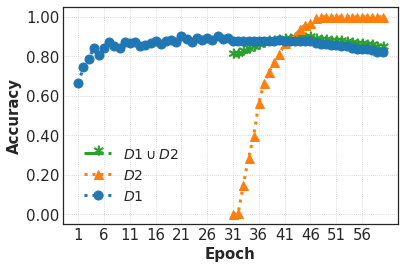

weighted f1 scores
y1 max:  0.9065174534959834
y2 d1 max:  0.8814227015586066
y2 d2 max:  1.0
y2 d1&d2 max:  0.8843689452203944


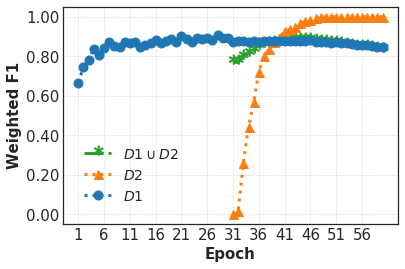

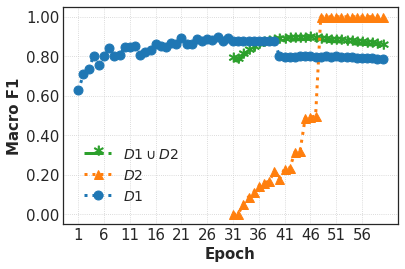

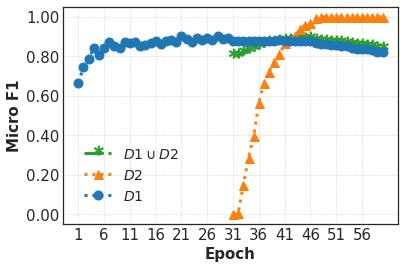

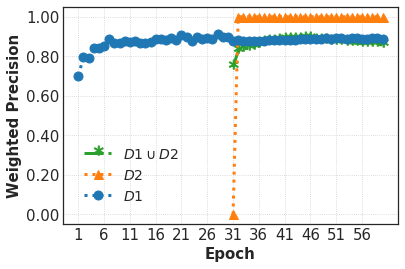

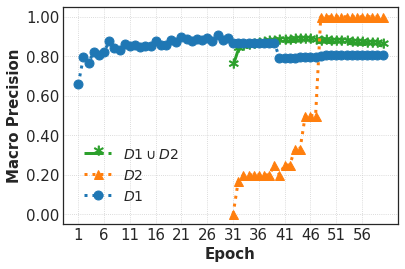

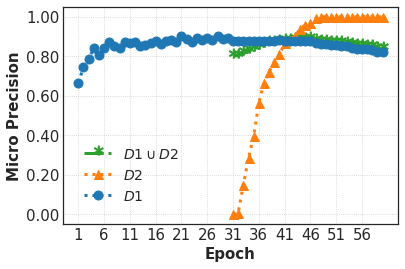

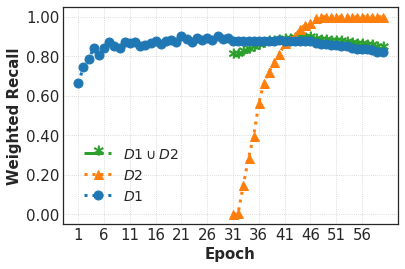

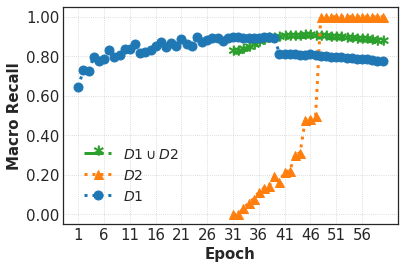

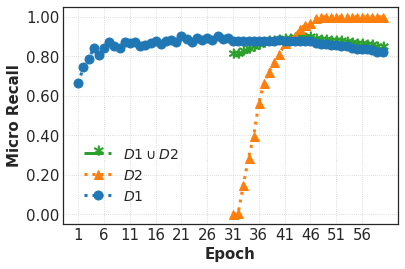

The shape of the train dataset is [[ 0.95774457 -0.80785272 -0.62090393 ... -0.82398156 -0.8817801
   0.59414878]
 [ 0.95774457 -0.80785272 -0.68247287 ... -0.82398156 -0.8817801
   0.63852889]
 [ 0.88395822 -0.80785272 -0.68247287 ... -0.73677349 -0.86303238
   0.59414878]
 ...
 [-0.73934137 -0.37654066 -0.77482628 ...  0.74576359 -0.41308717
   0.46100845]
 [-0.73934137 -0.37654066 -0.74404181 ...  0.74576359 -0.43183489
   0.46100845]
 [-0.70244819 -0.37654066 -0.77482628 ...  0.78936762 -0.43183489
   0.50538856]], and the labels is [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
The shape of the val dataset is [[-1.85943780e-01 -5.92196690e-01 -6.82472871e-01 ...  2.22515209e-01
  -6.00564342e-01  5.49768669e-01]
 [-1.47791758e-03 -2.46248469e-01 -7.44041811e-01 ... -8.27130148e-02
  -7.31798363e-01  4.16628339e-01]
 [ 2.93667462e-01 -6.79806954e-01 -7.44041811e-01 ... -5.18753334e-01
  -8.63032384e-01  4.61008449e-01]
 ...
 [-9.60700401e-01  1.47899980e+00 -6.20903930e-01 ...  5.277434

  <SOLVER>   | Task: 1/2 | training loss: 2.24 | training precision: 0.25 |:   0%|          | 1/11040 [00:00<20:22,  9.03it/s]

total data size of train_D1 is 11760
total data size of test_D1 is 1285
total data size of train_D2 is 1357
total data size of test_D2 is 171
args fc_lay: 1 fc_units: 32 fc_nl: relu lr: 0.010000 batch: 32

 --> task:          sensor2-class
 --> model:         LSTM([33 X 60]_c11)
 --> hyper-params:  i11040-lr0.01-b32-adam
 --> EWC:           EWC10000000-N
sensor2-class--LSTM([33 X 60]_c11)--i11040-lr0.01-b32-adam--EWC10000000-N


Model-name: "LSTM([33 X 60]_c11)"
----------------------------------------MAIN MODEL----------------------------------------
Classifier(
  (flatten): Flatten()
  (lstm_input_dropout): Dropout(p=0.2)
  (lstm): LSTM(60, 32, batch_first=True)
  (lstm_fc): Linear(in_features=32, out_features=11, bias=True)
)
------------------------------------------------------------------------------------------
--> this network has 12395 parameters (~0.0 million)
      of which: - learnable: 12395 (~0.0 million)
                - fixed: 0 (~0.0 million)
-------------------------

  <SOLVER>   | Task: 1/2 | training loss: 0.944 | training precision: 0.625 |:   3%|▎         | 370/11040 [00:23<16:11, 10.98it/s]

Epoch 1 best model saved with weighted f1: 0.7510503278461795


  <SOLVER>   | Task: 1/2 | training loss: 0.523 | training precision: 0.875 |:   7%|▋         | 739/11040 [00:45<20:58,  8.18it/s]

Epoch 2 best model saved with weighted f1: 0.811730778123094


  <SOLVER>   | Task: 1/2 | training loss: 0.337 | training precision: 0.875 |:  17%|█▋        | 1843/11040 [02:02<15:17, 10.02it/s]

Epoch 5 best model saved with weighted f1: 0.8192185166987012


  <SOLVER>   | Task: 1/2 | training loss: 0.391 | training precision: 0.812 |:  20%|██        | 2211/11040 [02:28<13:10, 11.17it/s] 

Epoch 6 best model saved with weighted f1: 0.8538050586926133


  <SOLVER>   | Task: 1/2 | training loss: 0.293 | training precision: 0.875 |:  40%|████      | 4416/11040 [05:05<06:39, 16.59it/s] 

Epoch 12 best model saved with weighted f1: 0.8599827447345555


  <SOLVER>   | Task: 1/2 | training loss: 0.262 | training precision: 0.906 |:  60%|██████    | 6627/11040 [07:41<06:57, 10.56it/s] 

Epoch 18 best model saved with weighted f1: 0.8663026209467584


  <SOLVER>   | Task: 1/2 | training loss: 0.428 | training precision: 0.844 |:  87%|████████▋ | 9571/11040 [11:08<02:40,  9.13it/s] 

Epoch 26 best model saved with weighted f1: 0.868258674306983


  <SOLVER>   | Task: 1/2 | training loss: 0.283 | training precision: 0.875 |: 100%|██████████| 11040/11040 [12:56<00:00, 14.22it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.24 | training precision: 0.25 |:   0%|          | 0/11040 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7540856031128405, 0.8038910505836576, 0.8093385214007782, 0.8007782101167316, 0.8140077821011673, 0.8521400778210116, 0.845136186770428, 0.8272373540856031, 0.8124513618677043, 0.8412451361867704, 0.843579766536965, 0.8521400778210116, 0.8474708171206226, 0.8108949416342413, 0.8498054474708171, 0.846692607003891, 0.8583657587548638, 0.863035019455253, 0.842023346303502, 0.863035019455253, 0.8280155642023346, 0.842023346303502, 0.8381322957198444, 0.8474708171206226, 0.8334630350194553, 0.867704280155642, 0.8529182879377432, 0.8669260700389105, 0.8443579766536965, 0.8536964980544747], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7540856031128405, 0.8038910505836576, 0.8093385214007782, 0.8007782101167316, 0.8140077821011673, 0.8521400778210116, 0.845136186770428, 0.8272373540856031, 0.8124513618677043, 0.8412451361867704, 0.843579766536965, 0.8521400778210116, 0.8474708171206226, 0.8108949416342413, 0.8498

  <SOLVER>   | Task: 1/2 | training loss: 0.883 | training precision: 0.719 |:   3%|▎         | 370/11040 [00:23<19:28,  9.13it/s]

Epoch 1 best model saved with weighted f1: 0.6716534588160403


  <SOLVER>   | Task: 1/2 | training loss: 0.696 | training precision: 0.656 |:   7%|▋         | 739/11040 [00:47<18:29,  9.29it/s]

Epoch 2 best model saved with weighted f1: 0.7478101772377581


  <SOLVER>   | Task: 1/2 | training loss: 0.522 | training precision: 0.844 |:  10%|█         | 1105/11040 [01:10<16:22, 10.12it/s]

Epoch 3 best model saved with weighted f1: 0.8145801075153775


  <SOLVER>   | Task: 1/2 | training loss: 0.505 | training precision: 0.75 |:  17%|█▋        | 1842/11040 [01:55<16:02,  9.55it/s] 

Epoch 5 best model saved with weighted f1: 0.8211673537214672


  <SOLVER>   | Task: 1/2 | training loss: 0.467 | training precision: 0.844 |:  20%|██        | 2210/11040 [02:18<16:08,  9.12it/s]

Epoch 6 best model saved with weighted f1: 0.8504763869686689


  <SOLVER>   | Task: 1/2 | training loss: 0.348 | training precision: 0.906 |:  27%|██▋       | 2945/11040 [03:08<16:38,  8.11it/s]

Epoch 8 best model saved with weighted f1: 0.8776652473681618


  <SOLVER>   | Task: 1/2 | training loss: 0.365 | training precision: 0.781 |:  33%|███▎      | 3683/11040 [03:55<08:41, 14.11it/s]

Epoch 10 best model saved with weighted f1: 0.8784001283090791


  <SOLVER>   | Task: 1/2 | training loss: 0.273 | training precision: 0.875 |:  57%|█████▋    | 6257/11040 [06:44<11:02,  7.23it/s] 

Epoch 17 best model saved with weighted f1: 0.8853030995538175


  <SOLVER>   | Task: 1/2 | training loss: 0.384 | training precision: 0.844 |:  80%|████████  | 8834/11040 [09:33<04:30,  8.17it/s] 

Epoch 24 best model saved with weighted f1: 0.886559326963385


  <SOLVER>   | Task: 1/2 | training loss: 0.264 | training precision: 0.875 |:  87%|████████▋ | 9569/11040 [10:22<01:49, 13.47it/s] 

Epoch 26 best model saved with weighted f1: 0.8866169865516708


  <SOLVER>   | Task: 1/2 | training loss: 0.238 | training precision: 0.906 |: 100%|██████████| 11040/11040 [11:58<00:00, 15.36it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 1.95 | training precision: 0.344 |:   0%|          | 2/11040 [00:00<09:52, 18.62it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6793774319066148, 0.7400778210116732, 0.8116731517509728, 0.8085603112840467, 0.8194552529182879, 0.8459143968871595, 0.8412451361867704, 0.8778210116731517, 0.8350194552529183, 0.8770428015564202, 0.8513618677042801, 0.867704280155642, 0.8747081712062257, 0.8739299610894942, 0.8498054474708171, 0.8575875486381322, 0.8848249027237354, 0.866147859922179, 0.8723735408560311, 0.8669260700389105, 0.8793774319066148, 0.8715953307392996, 0.8731517509727627, 0.8832684824902723, 0.8739299610894942, 0.8856031128404669, 0.8832684824902723, 0.8723735408560311, 0.8684824902723736, 0.8692607003891051], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6793774319066148, 0.7400778210116732, 0.8116731517509728, 0.8085603112840467, 0.8194552529182879, 0.8459143968871595, 0.8412451361867704, 0.8778210116731517, 0.8350194552529183, 0.8770428015564202, 0.8513618677042801, 0.867704280155642, 0.8747081712062257, 0.8739299610894942,

  <SOLVER>   | Task: 1/2 | training loss: 0.748 | training precision: 0.75 |:   3%|▎         | 370/11040 [00:29<23:06,  7.70it/s] 

Epoch 1 best model saved with weighted f1: 0.7502201694394856


  <SOLVER>   | Task: 1/2 | training loss: 0.401 | training precision: 0.875 |:  10%|█         | 1104/11040 [01:22<08:46, 18.87it/s]

Epoch 3 best model saved with weighted f1: 0.8097890080842871


  <SOLVER>   | Task: 1/2 | training loss: 0.198 | training precision: 0.906 |:  13%|█▎        | 1475/11040 [01:49<18:04,  8.82it/s]

Epoch 4 best model saved with weighted f1: 0.8303753766014677


  <SOLVER>   | Task: 1/2 | training loss: 0.158 | training precision: 0.938 |:  23%|██▎       | 2577/11040 [03:11<21:13,  6.65it/s]

Epoch 7 best model saved with weighted f1: 0.8721249262309343


  <SOLVER>   | Task: 1/2 | training loss: 0.275 | training precision: 0.875 |:  57%|█████▋    | 6258/11040 [07:58<12:04,  6.60it/s] 

Epoch 17 best model saved with weighted f1: 0.8736269248436326


  <SOLVER>   | Task: 1/2 | training loss: 0.316 | training precision: 0.875 |:  60%|██████    | 6626/11040 [08:25<07:54,  9.29it/s]

Epoch 18 best model saved with weighted f1: 0.875954229889216


  <SOLVER>   | Task: 1/2 | training loss: 0.377 | training precision: 0.844 |:  63%|██████▎   | 6994/11040 [08:53<11:21,  5.94it/s] 

Epoch 19 best model saved with weighted f1: 0.8765629269429709


  <SOLVER>   | Task: 1/2 | training loss: 0.305 | training precision: 0.812 |:  70%|██████▉   | 7727/11040 [09:57<04:06, 13.44it/s] 

Epoch 21 best model saved with weighted f1: 0.8874211591312965


  <SOLVER>   | Task: 1/2 | training loss: 0.236 | training precision: 0.906 |: 100%|██████████| 11040/11040 [14:35<00:00, 12.61it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.2 | training precision: 0.375 |:   0%|          | 2/11040 [00:00<09:50, 18.70it/s] 

precision_dict:  {'per_task_weighted_rec': [[0.757976653696498, 0.7260700389105058, 0.8062256809338522, 0.8373540856031129, 0.8155642023346303, 0.8249027237354085, 0.8708171206225681, 0.8684824902723736, 0.864591439688716, 0.8638132295719845, 0.8210116731517509, 0.866147859922179, 0.8544747081712062, 0.846692607003891, 0.8132295719844358, 0.8700389105058366, 0.8739299610894942, 0.8739299610894942, 0.8739299610894942, 0.8490272373540856, 0.8863813229571984, 0.843579766536965, 0.8747081712062257, 0.824124513618677, 0.843579766536965, 0.8669260700389105, 0.8428015564202335, 0.8715953307392996, 0.8700389105058366, 0.8552529182879377], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.757976653696498, 0.7260700389105058, 0.8062256809338522, 0.8373540856031129, 0.8155642023346303, 0.8249027237354085, 0.8708171206225681, 0.8684824902723736, 0.864591439688716, 0.8638132295719845, 0.8210116731517509, 0.866147859922179, 0.8544747081712062, 0.846692607003891, 0.81322

  <SOLVER>   | Task: 1/2 | training loss: 0.741 | training precision: 0.719 |:   3%|▎         | 369/11040 [00:28<19:31,  9.11it/s]

Epoch 1 best model saved with weighted f1: 0.7685289197485606


  <SOLVER>   | Task: 1/2 | training loss: 0.529 | training precision: 0.719 |:   7%|▋         | 739/11040 [00:56<14:41, 11.69it/s]

Epoch 2 best model saved with weighted f1: 0.806987926268501


  <SOLVER>   | Task: 1/2 | training loss: 0.371 | training precision: 0.844 |:  10%|█         | 1108/11040 [01:20<14:51, 11.14it/s]

Epoch 3 best model saved with weighted f1: 0.8160036122361721


  <SOLVER>   | Task: 1/2 | training loss: 0.246 | training precision: 0.938 |:  13%|█▎        | 1474/11040 [01:44<23:01,  6.92it/s]

Epoch 4 best model saved with weighted f1: 0.8572341544167104


  <SOLVER>   | Task: 1/2 | training loss: 0.356 | training precision: 0.906 |:  23%|██▎       | 2578/11040 [03:09<17:07,  8.24it/s] 

Epoch 7 best model saved with weighted f1: 0.8674606428256264


  <SOLVER>   | Task: 1/2 | training loss: 0.339 | training precision: 0.875 |:  30%|███       | 3316/11040 [04:09<13:28,  9.55it/s]

Epoch 9 best model saved with weighted f1: 0.8821514793980625


  <SOLVER>   | Task: 1/2 | training loss: 0.419 | training precision: 0.844 |:  33%|███▎      | 3682/11040 [04:34<10:27, 11.72it/s]

Epoch 10 best model saved with weighted f1: 0.8869979190229467


  <SOLVER>   | Task: 1/2 | training loss: 0.182 | training precision: 0.969 |:  47%|████▋     | 5154/11040 [06:22<11:53,  8.25it/s] 

Epoch 14 best model saved with weighted f1: 0.8902336368224699


  <SOLVER>   | Task: 1/2 | training loss: 0.318 | training precision: 0.938 |:  57%|█████▋    | 6257/11040 [07:40<10:27,  7.62it/s] 

Epoch 17 best model saved with weighted f1: 0.890660939343802


  <SOLVER>   | Task: 1/2 | training loss: 0.139 | training precision: 1.0 |:  67%|██████▋   | 7361/11040 [08:59<06:14,  9.82it/s]   

Epoch 20 best model saved with weighted f1: 0.9027715935305154


  <SOLVER>   | Task: 1/2 | training loss: 0.305 | training precision: 0.844 |:  90%|█████████ | 9938/11040 [12:15<02:31,  7.26it/s] 

Epoch 27 best model saved with weighted f1: 0.9072251575652027


  <SOLVER>   | Task: 1/2 | training loss: 0.162 | training precision: 0.938 |: 100%|██████████| 11040/11040 [13:38<00:00, 13.48it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.33 | training precision: 0.0312 |:   0%|          | 1/11040 [00:00<23:14,  7.92it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7595330739299611, 0.8023346303501946, 0.8070038910505837, 0.8583657587548638, 0.8505836575875486, 0.8365758754863813, 0.8638132295719845, 0.8614785992217899, 0.8809338521400778, 0.8871595330739299, 0.8723735408560311, 0.8824902723735408, 0.8778210116731517, 0.8879377431906614, 0.8793774319066148, 0.8824902723735408, 0.8894941634241245, 0.8824902723735408, 0.8871595330739299, 0.9019455252918288, 0.8856031128404669, 0.888715953307393, 0.8941634241245137, 0.8762645914396887, 0.8933852140077821, 0.8910505836575876, 0.9050583657587549, 0.8856031128404669, 0.8941634241245137, 0.8894941634241245], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7595330739299611, 0.8023346303501946, 0.8070038910505837, 0.8583657587548638, 0.8505836575875486, 0.8365758754863813, 0.8638132295719845, 0.8614785992217899, 0.8809338521400778, 0.8871595330739299, 0.8723735408560311, 0.8824902723735408, 0.8778210116731517, 0.887937743190661

  <SOLVER>   | Task: 1/2 | training loss: 0.697 | training precision: 0.656 |:   3%|▎         | 368/11040 [00:45<20:11,  8.81it/s]

Epoch 1 best model saved with weighted f1: 0.6277107351996976


  <SOLVER>   | Task: 1/2 | training loss: 0.816 | training precision: 0.625 |:   7%|▋         | 737/11040 [01:31<52:45,  3.26it/s]

Epoch 2 best model saved with weighted f1: 0.7685429303901268


  <SOLVER>   | Task: 1/2 | training loss: 0.55 | training precision: 0.875 |:  13%|█▎        | 1473/11040 [03:00<47:46,  3.34it/s] 

Epoch 4 best model saved with weighted f1: 0.8283043349920367


  <SOLVER>   | Task: 1/2 | training loss: 0.568 | training precision: 0.75 |:  17%|█▋        | 1841/11040 [03:50<33:08,  4.63it/s] 

Epoch 5 best model saved with weighted f1: 0.8292993603866595


  <SOLVER>   | Task: 1/2 | training loss: 0.541 | training precision: 0.812 |:  20%|██        | 2209/11040 [04:34<27:00,  5.45it/s]

Epoch 6 best model saved with weighted f1: 0.8357393613030466


  <SOLVER>   | Task: 1/2 | training loss: 0.36 | training precision: 0.844 |:  23%|██▎       | 2577/11040 [05:15<42:05,  3.35it/s]  

Epoch 7 best model saved with weighted f1: 0.8552326799996066


  <SOLVER>   | Task: 1/2 | training loss: 0.486 | training precision: 0.844 |:  30%|██▉       | 3311/11040 [06:53<13:06,  9.82it/s]

Epoch 9 best model saved with weighted f1: 0.8557304469693033


  <SOLVER>   | Task: 1/2 | training loss: 0.322 | training precision: 0.938 |:  47%|████▋     | 5153/11040 [10:54<28:58,  3.39it/s] 

Epoch 14 best model saved with weighted f1: 0.866883276358236


  <SOLVER>   | Task: 1/2 | training loss: 0.33 | training precision: 0.812 |:  50%|█████     | 5520/11040 [11:47<12:05,  7.61it/s]  

Epoch 15 best model saved with weighted f1: 0.8860526896800811


  <SOLVER>   | Task: 1/2 | training loss: 0.247 | training precision: 0.938 |: 100%|██████████| 11040/11040 [24:31<00:00,  7.50it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.33 | training precision: 0.0312 |:   0%|          | 1/11040 [00:00<33:10,  5.55it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6319066147859922, 0.7805447470817121, 0.7540856031128405, 0.8334630350194553, 0.8186770428015564, 0.8474708171206226, 0.8607003891050584, 0.8482490272373541, 0.8513618677042801, 0.8365758754863813, 0.8536964980544747, 0.8513618677042801, 0.8303501945525292, 0.863035019455253, 0.8856031128404669, 0.8575875486381322, 0.8793774319066148, 0.845136186770428, 0.8583657587548638, 0.8568093385214007, 0.8560311284046692, 0.8575875486381322, 0.8264591439688715, 0.8560311284046692, 0.8731517509727627, 0.8614785992217899, 0.8311284046692607, 0.8529182879377432, 0.8591439688715953, 0.867704280155642], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6319066147859922, 0.7805447470817121, 0.7540856031128405, 0.8334630350194553, 0.8186770428015564, 0.8474708171206226, 0.8607003891050584, 0.8482490272373541, 0.8513618677042801, 0.8365758754863813, 0.8536964980544747, 0.8513618677042801, 0.8303501945525292, 0.863035019455253, 

  <SOLVER>   | Task: 1/2 | training loss: 0.822 | training precision: 0.688 |:   3%|▎         | 369/11040 [00:47<34:08,  5.21it/s]

Epoch 1 best model saved with weighted f1: 0.6466048872068034


  <SOLVER>   | Task: 1/2 | training loss: 0.673 | training precision: 0.812 |:   7%|▋         | 737/11040 [01:32<23:25,  7.33it/s]

Epoch 2 best model saved with weighted f1: 0.7749579933126323


  <SOLVER>   | Task: 1/2 | training loss: 0.351 | training precision: 0.844 |:  10%|█         | 1104/11040 [02:16<11:30, 14.39it/s]

Epoch 3 best model saved with weighted f1: 0.805819920938145


  <SOLVER>   | Task: 1/2 | training loss: 0.32 | training precision: 0.875 |:  13%|█▎        | 1473/11040 [03:01<24:58,  6.38it/s] 

Epoch 4 best model saved with weighted f1: 0.8255631639405909


  <SOLVER>   | Task: 1/2 | training loss: 0.531 | training precision: 0.781 |:  20%|██        | 2209/11040 [04:40<47:03,  3.13it/s]

Epoch 6 best model saved with weighted f1: 0.8299175551500024


  <SOLVER>   | Task: 1/2 | training loss: 0.35 | training precision: 0.812 |:  23%|██▎       | 2577/11040 [05:31<27:15,  5.17it/s] 

Epoch 7 best model saved with weighted f1: 0.8651386733818671


  <SOLVER>   | Task: 1/2 | training loss: 0.25 | training precision: 0.906 |:  43%|████▎     | 4785/11040 [10:02<34:07,  3.06it/s] 

Epoch 13 best model saved with weighted f1: 0.8729239414025424


  <SOLVER>   | Task: 1/2 | training loss: 0.217 | training precision: 0.906 |:  60%|██████    | 6624/11040 [14:04<07:14, 10.16it/s] 

Epoch 18 best model saved with weighted f1: 0.8754922796861123


  <SOLVER>   | Task: 1/2 | training loss: 0.122 | training precision: 0.969 |:  67%|██████▋   | 7361/11040 [15:32<17:19,  3.54it/s] 

Epoch 20 best model saved with weighted f1: 0.8800442043010471


  <SOLVER>   | Task: 1/2 | training loss: 0.34 | training precision: 0.781 |:  70%|███████   | 7728/11040 [16:18<08:10,  6.75it/s]  

Epoch 21 best model saved with weighted f1: 0.8824530046760004


  <SOLVER>   | Task: 1/2 | training loss: 0.247 | training precision: 0.906 |:  77%|███████▋  | 8466/11040 [17:50<07:08,  6.00it/s] 

Epoch 23 best model saved with weighted f1: 0.8894317720372266


  <SOLVER>   | Task: 1/2 | training loss: 0.263 | training precision: 0.906 |: 100%|██████████| 11040/11040 [23:24<00:00,  7.86it/s] 
  0%|          | 0/11040 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6303501945525292, 0.7883268482490272, 0.8124513618677043, 0.824124513618677, 0.8140077821011673, 0.8319066147859923, 0.8638132295719845, 0.8428015564202335, 0.8614785992217899, 0.8490272373540856, 0.8443579766536965, 0.8505836575875486, 0.8715953307392996, 0.8684824902723736, 0.8591439688715953, 0.8583657587548638, 0.8684824902723736, 0.8754863813229572, 0.8700389105058366, 0.8785992217898833, 0.8817120622568093, 0.8754863813229572, 0.8879377431906614, 0.8785992217898833, 0.8871595330739299, 0.8638132295719845, 0.8809338521400778, 0.8801556420233463, 0.8607003891050584, 0.8692607003891051], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6303501945525292, 0.7883268482490272, 0.8124513618677043, 0.824124513618677, 0.8140077821011673, 0.8319066147859923, 0.8638132295719845, 0.8428015564202335, 0.8614785992217899, 0.8490272373540856, 0.8443579766536965, 0.8505836575875486, 0.8715953307392996, 0.8684824902723736

  <SOLVER>   | Task: 1/2 | training loss: 0.965 | training precision: 0.625 |:   3%|▎         | 369/11040 [01:07<1:08:04,  2.61it/s]

Epoch 1 best model saved with weighted f1: 0.6453417663818277


  <SOLVER>   | Task: 1/2 | training loss: 0.625 | training precision: 0.781 |:   7%|▋         | 736/11040 [02:06<22:19,  7.69it/s]  

Epoch 2 best model saved with weighted f1: 0.741634101067211


  <SOLVER>   | Task: 1/2 | training loss: 0.725 | training precision: 0.781 |:  10%|█         | 1104/11040 [03:11<21:01,  7.87it/s] 

Epoch 3 best model saved with weighted f1: 0.7812134735263152


  <SOLVER>   | Task: 1/2 | training loss: 0.653 | training precision: 0.781 |:  13%|█▎        | 1473/11040 [04:16<54:23,  2.93it/s]

Epoch 4 best model saved with weighted f1: 0.8102574944374327


  <SOLVER>   | Task: 1/2 | training loss: 0.337 | training precision: 0.844 |:  20%|██        | 2209/11040 [06:30<55:20,  2.66it/s]  

Epoch 6 best model saved with weighted f1: 0.8486555700468446


  <SOLVER>   | Task: 1/2 | training loss: 0.348 | training precision: 0.844 |:  37%|███▋      | 4049/11040 [11:33<40:08,  2.90it/s]  

Epoch 11 best model saved with weighted f1: 0.8636294214509559


  <SOLVER>   | Task: 1/2 | training loss: 0.299 | training precision: 0.875 |:  43%|████▎     | 4784/11040 [13:35<14:30,  7.18it/s] 

Epoch 13 best model saved with weighted f1: 0.865251616036228


  <SOLVER>   | Task: 1/2 | training loss: 0.198 | training precision: 0.938 |:  47%|████▋     | 5152/11040 [14:40<13:56,  7.04it/s] 

Epoch 14 best model saved with weighted f1: 0.8673762985820861


  <SOLVER>   | Task: 1/2 | training loss: 0.243 | training precision: 0.938 |:  57%|█████▋    | 6257/11040 [17:59<18:14,  4.37it/s] 

Epoch 17 best model saved with weighted f1: 0.8756562062630846


  <SOLVER>   | Task: 1/2 | training loss: 0.2 | training precision: 0.906 |:  87%|████████▋ | 9569/11040 [27:40<08:37,  2.85it/s]   

Epoch 26 best model saved with weighted f1: 0.8812251244123122


  <SOLVER>   | Task: 1/2 | training loss: 0.22 | training precision: 0.906 |: 100%|██████████| 11040/11040 [32:05<00:00,  5.73it/s]  
  0%|          | 0/11040 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6474708171206226, 0.7447470817120623, 0.7821011673151751, 0.8171206225680934, 0.8015564202334631, 0.8482490272373541, 0.8303501945525292, 0.843579766536965, 0.8389105058365759, 0.843579766536965, 0.8614785992217899, 0.842023346303502, 0.8638132295719845, 0.8669260700389105, 0.8536964980544747, 0.846692607003891, 0.8747081712062257, 0.8482490272373541, 0.845136186770428, 0.8552529182879377, 0.8194552529182879, 0.8342412451361868, 0.8552529182879377, 0.845136186770428, 0.8575875486381322, 0.8801556420233463, 0.8684824902723736, 0.863035019455253, 0.8599221789883269, 0.867704280155642], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6474708171206226, 0.7447470817120623, 0.7821011673151751, 0.8171206225680934, 0.8015564202334631, 0.8482490272373541, 0.8303501945525292, 0.843579766536965, 0.8389105058365759, 0.843579766536965, 0.8614785992217899, 0.842023346303502, 0.8638132295719845, 0.8669260700389105, 0.85369

  <SOLVER>   | Task: 1/2 | training loss: 0.737 | training precision: 0.75 |:   3%|▎         | 369/11040 [01:07<1:06:24,  2.68it/s]

Epoch 1 best model saved with weighted f1: 0.7289768577650065


  <SOLVER>   | Task: 1/2 | training loss: 0.334 | training precision: 0.906 |:   7%|▋         | 737/11040 [02:14<1:03:52,  2.69it/s]

Epoch 2 best model saved with weighted f1: 0.7773815838378174


  <SOLVER>   | Task: 1/2 | training loss: 0.454 | training precision: 0.844 |:  10%|█         | 1104/11040 [03:15<37:17,  4.44it/s] 

Epoch 3 best model saved with weighted f1: 0.818282893755251


  <SOLVER>   | Task: 1/2 | training loss: 0.545 | training precision: 0.75 |:  13%|█▎        | 1473/11040 [04:17<52:31,  3.04it/s]   

Epoch 4 best model saved with weighted f1: 0.8445037226080113


  <SOLVER>   | Task: 1/2 | training loss: 0.281 | training precision: 0.906 |:  17%|█▋        | 1841/11040 [05:19<46:27,  3.30it/s]

Epoch 5 best model saved with weighted f1: 0.8601040934850488


  <SOLVER>   | Task: 1/2 | training loss: 0.371 | training precision: 0.75 |:  23%|██▎       | 2577/11040 [07:24<36:35,  3.85it/s] 

Epoch 7 best model saved with weighted f1: 0.8750432327919795


  <SOLVER>   | Task: 1/2 | training loss: 0.32 | training precision: 0.906 |:  33%|███▎      | 3681/11040 [10:27<38:50,  3.16it/s]  

Epoch 10 best model saved with weighted f1: 0.8843297197402608


  <SOLVER>   | Task: 1/2 | training loss: 0.278 | training precision: 0.938 |:  57%|█████▋    | 6257/11040 [17:43<23:26,  3.40it/s] 

Epoch 17 best model saved with weighted f1: 0.8879770888376421


  <SOLVER>   | Task: 1/2 | training loss: 0.233 | training precision: 0.906 |:  70%|███████   | 7729/11040 [21:55<18:39,  2.96it/s] 

Epoch 21 best model saved with weighted f1: 0.8973971746968027


  <SOLVER>   | Task: 1/2 | training loss: 0.174 | training precision: 0.938 |:  83%|████████▎ | 9201/11040 [26:04<10:46,  2.84it/s] 

Epoch 25 best model saved with weighted f1: 0.9083924302808783


  <SOLVER>   | Task: 1/2 | training loss: 0.0992 | training precision: 0.969 |: 100%|██████████| 11040/11040 [31:04<00:00,  5.92it/s]


precision_dict:  {'per_task_weighted_rec': [[0.7260700389105058, 0.775875486381323, 0.8280155642023346, 0.8482490272373541, 0.8521400778210116, 0.8319066147859923, 0.8739299610894942, 0.8575875486381322, 0.8731517509727627, 0.8824902723735408, 0.8653696498054475, 0.8552529182879377, 0.8653696498054475, 0.8801556420233463, 0.8708171206225681, 0.8817120622568093, 0.8879377431906614, 0.8739299610894942, 0.8856031128404669, 0.8762645914396887, 0.8949416342412452, 0.8856031128404669, 0.8856031128404669, 0.8871595330739299, 0.9066147859922179, 0.890272373540856, 0.8871595330739299, 0.8926070038910506, 0.890272373540856, 0.9050583657587549], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7260700389105058, 0.775875486381323, 0.8280155642023346, 0.8482490272373541, 0.8521400778210116, 0.8319066147859923, 0.8739299610894942, 0.8575875486381322, 0.8731517509727627, 0.8824902723735408, 0.8653696498054475, 0.8552529182879377, 0.8653696498054475, 0.8801556420233463, 

  <SOLVER>   | Task: 2/2 | training loss: 1.96 | training precision: 0.0625 |:   3%|▎         | 42/1290 [00:10<04:06,  5.07it/s]

Epoch 2 best model saved with weighted f1: 0.05681818181818181


  <SOLVER>   | Task: 2/2 | training loss: 1.22 | training precision: 0.844 |:   5%|▍         | 64/1290 [00:16<05:00,  4.08it/s] 

Epoch 3 best model saved with weighted f1: 0.8896103896103895


  <SOLVER>   | Task: 2/2 | training loss: 0.699 | training precision: 1.0 |:   7%|▋         | 85/1290 [00:21<03:26,  5.83it/s]  

Epoch 4 best model saved with weighted f1: 0.9911504424778761


  <SOLVER>   | Task: 2/2 | training loss: 0.324 | training precision: 1.0 |:  11%|█▏        | 148/1290 [00:36<03:54,  4.87it/s]  

Epoch 7 best model saved with weighted f1: 0.9970674486803519


  <SOLVER>   | Task: 2/2 | training loss: 0.25 | training precision: 1.0 |:  15%|█▍        | 190/1290 [00:45<03:17,  5.57it/s]   

Epoch 9 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.0792 | training precision: 1.0 |:  47%|████▋     | 610/1290 [02:27<02:08,  5.31it/s] 

Early stopping on epoch 29


  <SOLVER>   | Task: 2/2 | training loss: 0.0759 | training precision: 1.0 |:  49%|████▉     | 630/1290 [02:32<01:58,  5.56it/s]

Early stopping on epoch 30


  <SOLVER>   | Task: 2/2 | training loss: 0.0777 | training precision: 1.0 |:  51%|█████     | 652/1290 [02:38<01:50,  5.77it/s] 

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 0.969 |:  52%|█████▏    | 673/1290 [02:44<02:22,  4.33it/s]

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.0767 | training precision: 1.0 |:  54%|█████▍    | 694/1290 [02:49<01:49,  5.43it/s] 

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.0935 | training precision: 1.0 |:  55%|█████▌    | 715/1290 [02:55<01:52,  5.09it/s] 

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.0723 | training precision: 1.0 |:  57%|█████▋    | 736/1290 [03:00<01:38,  5.63it/s]

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.0994 | training precision: 1.0 |:  59%|█████▊    | 757/1290 [03:05<01:45,  5.07it/s]

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.0674 | training precision: 1.0 |:  60%|██████    | 777/1290 [03:09<01:38,  5.22it/s]

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.0732 | training precision: 1.0 |:  62%|██████▏   | 799/1290 [03:15<01:40,  4.88it/s] 

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.071 | training precision: 1.0 |:  64%|██████▎   | 820/1290 [03:20<01:15,  6.19it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0622 | training precision: 1.0 |:  65%|██████▌   | 841/1290 [03:26<01:40,  4.48it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0774 | training precision: 1.0 |:  67%|██████▋   | 861/1290 [03:31<01:18,  5.46it/s]

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0625 | training precision: 1.0 |:  68%|██████▊   | 882/1290 [03:36<01:30,  4.49it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0622 | training precision: 1.0 |:  70%|███████   | 904/1290 [03:43<01:44,  3.69it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0556 | training precision: 1.0 |:  72%|███████▏  | 924/1290 [03:48<01:25,  4.26it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.059 | training precision: 1.0 |:  73%|███████▎  | 946/1290 [03:54<01:13,  4.66it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0573 | training precision: 1.0 |:  75%|███████▍  | 966/1290 [03:59<01:07,  4.82it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0642 | training precision: 1.0 |:  77%|███████▋  | 988/1290 [04:05<00:51,  5.84it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0564 | training precision: 1.0 |:  78%|███████▊  | 1008/1290 [04:10<01:02,  4.52it/s]

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0529 | training precision: 1.0 |:  80%|███████▉  | 1030/1290 [04:15<00:44,  5.84it/s]

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.097 | training precision: 0.969 |:  81%|████████▏ | 1051/1290 [04:20<00:44,  5.41it/s] 

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0511 | training precision: 1.0 |:  83%|████████▎ | 1072/1290 [04:25<00:34,  6.32it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0551 | training precision: 1.0 |:  85%|████████▍ | 1093/1290 [04:29<00:32,  6.04it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0552 | training precision: 1.0 |:  86%|████████▋ | 1114/1290 [04:34<00:30,  5.85it/s]

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0518 | training precision: 1.0 |:  88%|████████▊ | 1134/1290 [04:39<00:43,  3.61it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0517 | training precision: 1.0 |:  90%|████████▉ | 1155/1290 [04:45<00:32,  4.16it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0523 | training precision: 1.0 |:  91%|█████████ | 1177/1290 [04:51<00:23,  4.89it/s] 

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0468 | training precision: 1.0 |:  93%|█████████▎| 1198/1290 [04:57<00:19,  4.67it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.049 | training precision: 1.0 |:  94%|█████████▍| 1219/1290 [05:01<00:12,  5.83it/s] 

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0478 | training precision: 1.0 |:  96%|█████████▌| 1240/1290 [05:06<00:07,  6.92it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0782 | training precision: 1.0 |:  98%|█████████▊| 1261/1290 [05:10<00:04,  5.80it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0509 | training precision: 1.0 |:  99%|█████████▉| 1282/1290 [05:16<00:01,  4.81it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0529 | training precision: 1.0 |: 100%|██████████| 1290/1290 [05:17<00:00,  4.06it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8108949416342413, 0.8031128404669261, 0.7750972762645915, 0.7089494163424125, 0.7003891050583657, 0.6980544747081712, 0.691828793774319, 0.690272373540856, 0.688715953307393, 0.6793774319066148, 0.6809338521400778, 0.6863813229571984, 0.6964980544747081, 0.6972762645914397, 0.6949416342412451, 0.6964980544747081, 0.7003891050583657, 0.7073929961089495, 0.7003891050583657, 0.6980544747081712, 0.7050583657587549, 0.6980544747081712, 0.7019455252918287, 0.7035019455252919, 0.7050583657587549, 0.7019455252918287, 0.7058365758754864, 0.7042801556420234, 0.7042801556420234, 0.7027237354085603, 0.7050583657587549, 0.6856031128404669, 0.7019455252918287, 0.7058365758754864, 0.7003891050583657, 0.7019455252918287, 0.7011673151750972, 0.7011673151750972, 0.6926070038910506, 0.7011673151750972, 0.7050583657587549, 0.7011673151750972, 0.7019455252918287, 0.7019455252918287, 0.7027237354085603, 0.7035019455252919, 0.6988326848249027, 0.6988326848249027

  <SOLVER>   | Task: 2/2 | training loss: 2.01 | training precision: 0.406 |:   5%|▍         | 64/1290 [00:15<03:27,  5.92it/s] 

Epoch 3 best model saved with weighted f1: 0.22797927461139894


  <SOLVER>   | Task: 2/2 | training loss: 1.2 | training precision: 0.875 |:   7%|▋         | 85/1290 [00:20<03:46,  5.31it/s] 

Epoch 4 best model saved with weighted f1: 0.8406779661016949


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.969 |:   8%|▊         | 105/1290 [00:25<03:52,  5.09it/s] 

Epoch 5 best model saved with weighted f1: 0.9509202453987731


  <SOLVER>   | Task: 2/2 | training loss: 0.718 | training precision: 0.969 |:  10%|▉         | 127/1290 [00:30<03:25,  5.66it/s]

Epoch 6 best model saved with weighted f1: 0.9881656804733727


  <SOLVER>   | Task: 2/2 | training loss: 0.488 | training precision: 1.0 |:  13%|█▎        | 168/1290 [00:41<03:52,  4.82it/s]  

Epoch 8 best model saved with weighted f1: 0.9911504424778761


  <SOLVER>   | Task: 2/2 | training loss: 0.448 | training precision: 1.0 |:  15%|█▍        | 190/1290 [00:46<04:10,  4.38it/s]  

Epoch 9 best model saved with weighted f1: 0.9970674486803519


  <SOLVER>   | Task: 2/2 | training loss: 0.342 | training precision: 0.969 |:  23%|██▎       | 294/1290 [01:11<04:07,  4.03it/s]

Epoch 14 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.185 | training precision: 1.0 |:  55%|█████▌    | 715/1290 [02:55<01:41,  5.67it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.173 | training precision: 1.0 |:  57%|█████▋    | 736/1290 [03:00<01:37,  5.69it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.263 | training precision: 0.969 |:  59%|█████▊    | 757/1290 [03:04<01:22,  6.44it/s]

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  60%|██████    | 777/1290 [03:10<02:37,  3.25it/s]  

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.182 | training precision: 1.0 |:  62%|██████▏   | 799/1290 [03:15<01:31,  5.36it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.147 | training precision: 1.0 |:  63%|██████▎   | 819/1290 [03:20<02:04,  3.79it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.14 | training precision: 1.0 |:  65%|██████▌   | 841/1290 [03:26<01:25,  5.24it/s]   

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 0.969 |:  67%|██████▋   | 861/1290 [03:31<02:18,  3.10it/s]

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.133 | training precision: 1.0 |:  68%|██████▊   | 883/1290 [03:38<01:31,  4.43it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.152 | training precision: 1.0 |:  70%|███████   | 904/1290 [03:42<01:23,  4.62it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.137 | training precision: 1.0 |:  72%|███████▏  | 925/1290 [03:48<00:58,  6.22it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.121 | training precision: 1.0 |:  73%|███████▎  | 946/1290 [03:53<01:17,  4.44it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  75%|███████▍  | 966/1290 [03:59<01:21,  3.99it/s]  

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.124 | training precision: 1.0 |:  77%|███████▋  | 987/1290 [04:05<01:09,  4.36it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.117 | training precision: 1.0 |:  78%|███████▊  | 1009/1290 [04:11<00:53,  5.29it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.117 | training precision: 1.0 |:  80%|███████▉  | 1029/1290 [04:16<00:50,  5.13it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.159 | training precision: 0.969 |:  81%|████████▏ | 1051/1290 [04:22<00:44,  5.35it/s]

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.32 | training precision: 0.938 |:  83%|████████▎ | 1071/1290 [04:28<00:56,  3.87it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.105 | training precision: 1.0 |:  85%|████████▍ | 1094/1290 [04:33<00:31,  6.25it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0994 | training precision: 1.0 |:  86%|████████▋ | 1114/1290 [04:37<00:33,  5.29it/s]

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.115 | training precision: 1.0 |:  88%|████████▊ | 1135/1290 [04:42<00:31,  4.89it/s]  

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.102 | training precision: 1.0 |:  90%|████████▉ | 1155/1290 [04:47<00:32,  4.21it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0991 | training precision: 1.0 |:  91%|█████████ | 1177/1290 [04:52<00:18,  6.21it/s] 

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0935 | training precision: 1.0 |:  93%|█████████▎| 1198/1290 [04:58<00:18,  4.93it/s] 

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.124 | training precision: 1.0 |:  94%|█████████▍| 1219/1290 [05:04<00:12,  5.70it/s]  

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.091 | training precision: 1.0 |:  96%|█████████▌| 1239/1290 [05:10<00:12,  4.22it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  98%|█████████▊| 1261/1290 [05:14<00:03,  7.52it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0819 | training precision: 1.0 |:  99%|█████████▉| 1282/1290 [05:21<00:02,  3.96it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.12 | training precision: 1.0 |: 100%|██████████| 1290/1290 [05:23<00:00,  3.99it/s]   


precision_dict:  {'per_task_weighted_rec': [[0.8357976653696498, 0.8490272373540856, 0.8326848249027238, 0.8085603112840467, 0.7439688715953308, 0.7361867704280156, 0.7361867704280156, 0.7346303501945526, 0.7221789883268482, 0.7252918287937743, 0.7260700389105058, 0.7245136186770428, 0.7260700389105058, 0.7276264591439688, 0.7190661478599222, 0.7260700389105058, 0.7190661478599222, 0.7190661478599222, 0.7190661478599222, 0.7159533073929961, 0.7151750972762646, 0.7175097276264591, 0.7159533073929961, 0.7151750972762646, 0.7120622568093385, 0.709727626459144, 0.7120622568093385, 0.7159533073929961, 0.7143968871595331, 0.7151750972762646, 0.7136186770428016, 0.7089494163424125, 0.7151750972762646, 0.7128404669260701, 0.7128404669260701, 0.7136186770428016, 0.7105058365758755, 0.711284046692607, 0.7105058365758755, 0.7151750972762646, 0.7128404669260701, 0.7128404669260701, 0.7128404669260701, 0.7105058365758755, 0.7120622568093385, 0.708171206225681, 0.7136186770428016, 0.7073929961089495

  <SOLVER>   | Task: 2/2 | training loss: 2.41 | training precision: 0.25 |:   5%|▍         | 64/1290 [00:16<04:34,  4.47it/s]  

Epoch 3 best model saved with weighted f1: 0.023121387283236997


  <SOLVER>   | Task: 2/2 | training loss: 1.66 | training precision: 0.719 |:   7%|▋         | 85/1290 [00:21<03:29,  5.74it/s]

Epoch 4 best model saved with weighted f1: 0.7380073800738007


  <SOLVER>   | Task: 2/2 | training loss: 1.3 | training precision: 0.844 |:   8%|▊         | 105/1290 [00:27<04:56,  3.99it/s] 

Epoch 5 best model saved with weighted f1: 0.8484848484848483


  <SOLVER>   | Task: 2/2 | training loss: 0.945 | training precision: 0.906 |:  10%|▉         | 126/1290 [00:32<04:04,  4.76it/s]

Epoch 6 best model saved with weighted f1: 0.903846153846154


  <SOLVER>   | Task: 2/2 | training loss: 0.772 | training precision: 0.969 |:  11%|█▏        | 147/1290 [00:37<04:16,  4.46it/s]

Epoch 7 best model saved with weighted f1: 0.9345794392523363


  <SOLVER>   | Task: 2/2 | training loss: 0.663 | training precision: 1.0 |:  13%|█▎        | 169/1290 [00:43<03:36,  5.17it/s]  

Epoch 8 best model saved with weighted f1: 0.9698795180722891


  <SOLVER>   | Task: 2/2 | training loss: 0.662 | training precision: 0.969 |:  15%|█▍        | 190/1290 [00:47<02:44,  6.69it/s]

Epoch 9 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.521 | training precision: 1.0 |:  16%|█▋        | 211/1290 [00:51<03:25,  5.26it/s]  

Epoch 10 best model saved with weighted f1: 0.9821428571428572


  <SOLVER>   | Task: 2/2 | training loss: 0.501 | training precision: 0.969 |:  20%|█▉        | 253/1290 [01:01<02:51,  6.05it/s]

Epoch 12 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.403 | training precision: 1.0 |:  21%|██        | 274/1290 [01:05<02:59,  5.65it/s]  

Epoch 13 best model saved with weighted f1: 0.9970674486803519


  <SOLVER>   | Task: 2/2 | training loss: 0.202 | training precision: 1.0 |:  51%|█████     | 652/1290 [02:36<01:53,  5.61it/s]  

Epoch 31 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.298 | training precision: 0.969 |:  83%|████████▎ | 1071/1290 [04:22<00:55,  3.95it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.107 | training precision: 1.0 |:  85%|████████▍ | 1093/1290 [04:28<00:44,  4.40it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.097 | training precision: 1.0 |:  86%|████████▋ | 1114/1290 [04:33<00:37,  4.73it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.1 | training precision: 1.0 |:  88%|████████▊ | 1135/1290 [04:38<00:33,  4.64it/s]    

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0872 | training precision: 1.0 |:  90%|████████▉ | 1155/1290 [04:44<00:29,  4.52it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.097 | training precision: 1.0 |:  91%|█████████ | 1177/1290 [04:50<00:26,  4.22it/s]  

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0919 | training precision: 1.0 |:  93%|█████████▎| 1198/1290 [04:55<00:15,  6.11it/s] 

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.115 | training precision: 1.0 |:  94%|█████████▍| 1219/1290 [05:00<00:15,  4.50it/s]  

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0948 | training precision: 1.0 |:  96%|█████████▌| 1240/1290 [05:05<00:09,  5.33it/s] 

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.111 | training precision: 1.0 |:  98%|█████████▊| 1261/1290 [05:12<00:06,  4.27it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.102 | training precision: 1.0 |:  99%|█████████▉| 1281/1290 [05:17<00:02,  3.78it/s]  

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.099 | training precision: 1.0 |: 100%|██████████| 1290/1290 [05:19<00:00,  4.04it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8575875486381322, 0.866147859922179, 0.8715953307392996, 0.8521400778210116, 0.8007782101167316, 0.7797665369649806, 0.7673151750972763, 0.7509727626459144, 0.7385214007782102, 0.7385214007782102, 0.7408560311284047, 0.7346303501945526, 0.7354085603112841, 0.7354085603112841, 0.7268482490272373, 0.733852140077821, 0.7268482490272373, 0.7330739299610894, 0.7299610894941634, 0.7284046692607004, 0.7291828793774319, 0.7307392996108949, 0.7214007782101167, 0.7175097276264591, 0.7206225680933852, 0.7175097276264591, 0.7198443579766537, 0.7167315175097276, 0.7143968871595331, 0.7167315175097276, 0.7151750972762646, 0.7143968871595331, 0.7175097276264591, 0.7151750972762646, 0.7167315175097276, 0.7182879377431907, 0.7175097276264591, 0.7151750972762646, 0.7167315175097276, 0.7167315175097276, 0.7182879377431907, 0.7159533073929961, 0.7128404669260701, 0.7159533073929961, 0.7136186770428016, 0.711284046692607, 0.709727626459144, 0.6988326848249027,

  <SOLVER>   | Task: 2/2 | training loss: 2.85 | training precision: 0.0312 |:   8%|▊         | 106/1290 [00:26<03:34,  5.51it/s]

Epoch 5 best model saved with weighted f1: 0.1711229946524064


  <SOLVER>   | Task: 2/2 | training loss: 2.19 | training precision: 0.469 |:  10%|▉         | 127/1290 [00:30<02:55,  6.62it/s] 

Epoch 6 best model saved with weighted f1: 0.5809128630705394


  <SOLVER>   | Task: 2/2 | training loss: 1.88 | training precision: 0.531 |:  11%|█▏        | 147/1290 [00:35<04:46,  3.99it/s]

Epoch 7 best model saved with weighted f1: 0.6588235294117647


  <SOLVER>   | Task: 2/2 | training loss: 1.8 | training precision: 0.5 |:  13%|█▎        | 168/1290 [00:39<03:59,  4.69it/s]   

Epoch 8 best model saved with weighted f1: 0.7286245353159851


  <SOLVER>   | Task: 2/2 | training loss: 1.31 | training precision: 0.719 |:  15%|█▍        | 190/1290 [00:45<03:30,  5.24it/s]

Epoch 9 best model saved with weighted f1: 0.7472527472527472


  <SOLVER>   | Task: 2/2 | training loss: 1.31 | training precision: 0.75 |:  16%|█▋        | 211/1290 [00:50<03:58,  4.52it/s] 

Epoch 10 best model saved with weighted f1: 0.7697841726618705


  <SOLVER>   | Task: 2/2 | training loss: 1.1 | training precision: 0.844 |:  18%|█▊        | 232/1290 [00:56<03:04,  5.75it/s] 

Epoch 11 best model saved with weighted f1: 0.8367346938775511


  <SOLVER>   | Task: 2/2 | training loss: 1.13 | training precision: 0.75 |:  20%|█▉        | 252/1290 [01:00<02:54,  5.96it/s]  

Epoch 12 best model saved with weighted f1: 0.8637873754152825


  <SOLVER>   | Task: 2/2 | training loss: 0.945 | training precision: 0.906 |:  21%|██        | 274/1290 [01:05<03:10,  5.32it/s]

Epoch 13 best model saved with weighted f1: 0.9073482428115015


  <SOLVER>   | Task: 2/2 | training loss: 1.04 | training precision: 0.875 |:  23%|██▎       | 294/1290 [01:10<04:14,  3.91it/s] 

Epoch 14 best model saved with weighted f1: 0.9142857142857141


  <SOLVER>   | Task: 2/2 | training loss: 0.906 | training precision: 0.812 |:  24%|██▍       | 316/1290 [01:17<04:07,  3.93it/s]

Epoch 15 best model saved with weighted f1: 0.9278996865203761


  <SOLVER>   | Task: 2/2 | training loss: 0.803 | training precision: 0.938 |:  26%|██▌       | 337/1290 [01:21<02:45,  5.74it/s]

Epoch 16 best model saved with weighted f1: 0.9345794392523363


  <SOLVER>   | Task: 2/2 | training loss: 0.732 | training precision: 0.906 |:  28%|██▊       | 357/1290 [01:26<03:21,  4.64it/s]

Epoch 17 best model saved with weighted f1: 0.9411764705882353


  <SOLVER>   | Task: 2/2 | training loss: 0.683 | training precision: 0.938 |:  29%|██▉       | 379/1290 [01:32<03:20,  4.55it/s]

Epoch 18 best model saved with weighted f1: 0.9573170731707318


  <SOLVER>   | Task: 2/2 | training loss: 0.539 | training precision: 1.0 |:  31%|███       | 400/1290 [01:37<02:38,  5.63it/s]  

Epoch 19 best model saved with weighted f1: 0.9604863221884498


  <SOLVER>   | Task: 2/2 | training loss: 0.615 | training precision: 0.969 |:  33%|███▎      | 421/1290 [01:43<03:07,  4.64it/s]

Epoch 20 best model saved with weighted f1: 0.9636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 0.501 | training precision: 0.969 |:  34%|███▍      | 441/1290 [01:48<03:13,  4.38it/s]

Epoch 21 best model saved with weighted f1: 0.9667673716012083


  <SOLVER>   | Task: 2/2 | training loss: 0.538 | training precision: 0.938 |:  36%|███▌      | 462/1290 [01:54<03:34,  3.86it/s]

Epoch 22 best model saved with weighted f1: 0.972972972972973


  <SOLVER>   | Task: 2/2 | training loss: 0.332 | training precision: 1.0 |:  46%|████▌     | 589/1290 [02:25<02:20,  5.00it/s]  

Epoch 28 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.532 | training precision: 0.969 |:  50%|█████     | 651/1290 [02:43<02:10,  4.88it/s]

Epoch 31 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.0817 | training precision: 1.0 |:  83%|████████▎ | 1072/1290 [04:26<00:41,  5.21it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |:  85%|████████▍ | 1093/1290 [04:32<00:34,  5.73it/s]  

Epoch 52 best model saved with weighted f1: 0.9881656804733727


  <SOLVER>   | Task: 2/2 | training loss: 0.0967 | training precision: 1.0 |:  86%|████████▋ | 1114/1290 [04:37<00:38,  4.63it/s]  

Epoch 53 best model saved with weighted f1: 0.9911504424778761


  <SOLVER>   | Task: 2/2 | training loss: 0.0784 | training precision: 1.0 |: 100%|██████████| 1290/1290 [05:18<00:00,  4.05it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8964980544747082, 0.8996108949416343, 0.8964980544747082, 0.8980544747081712, 0.9003891050583658, 0.8809338521400778, 0.8700389105058366, 0.8684824902723736, 0.8490272373540856, 0.8389105058365759, 0.8272373540856031, 0.8116731517509728, 0.7961089494163424, 0.7922178988326848, 0.7782101167315175, 0.7665369649805448, 0.7587548638132295, 0.7478599221789883, 0.7447470817120623, 0.7330739299610894, 0.7330739299610894, 0.7330739299610894, 0.7315175097276264, 0.7245136186770428, 0.7245136186770428, 0.7229571984435798, 0.7214007782101167, 0.7206225680933852, 0.7221789883268482, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.7206225680933852, 0.7206225680933852, 0.7198443579766537, 0.7206225680933852, 0.7198443579766537, 0.7182879377431907, 0.7175097276264591, 0.7167315175097276, 0.7167315175097276, 0.7143968871595331, 0.7151750972762646, 0.7143968871595331, 0.7128404669260701, 0.7136186770428016, 0.7120622568093385, 0.7112840466926

  <SOLVER>   | Task: 2/2 | training loss: 3.56 | training precision: 0.0 |:  11%|█▏        | 147/1290 [00:33<03:38,  5.24it/s]   

Epoch 7 best model saved with weighted f1: 0.011627906976744186


  <SOLVER>   | Task: 2/2 | training loss: 3.18 | training precision: 0.0312 |:  13%|█▎        | 169/1290 [00:39<03:10,  5.89it/s]

Epoch 8 best model saved with weighted f1: 0.045714285714285714


  <SOLVER>   | Task: 2/2 | training loss: 2.58 | training precision: 0.0312 |:  15%|█▍        | 190/1290 [00:43<03:03,  6.00it/s]

Epoch 9 best model saved with weighted f1: 0.07865168539325842


  <SOLVER>   | Task: 2/2 | training loss: 2.09 | training precision: 0.281 |:  16%|█▋        | 211/1290 [00:48<03:23,  5.30it/s] 

Epoch 10 best model saved with weighted f1: 0.16129032258064516


  <SOLVER>   | Task: 2/2 | training loss: 1.78 | training precision: 0.344 |:  18%|█▊        | 232/1290 [00:53<02:41,  6.56it/s]

Epoch 11 best model saved with weighted f1: 0.3636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 1.44 | training precision: 0.281 |:  20%|█▉        | 252/1290 [00:57<03:15,  5.31it/s]

Epoch 12 best model saved with weighted f1: 0.46636771300448426


  <SOLVER>   | Task: 2/2 | training loss: 1.06 | training precision: 0.531 |:  21%|██        | 274/1290 [01:01<02:51,  5.92it/s] 

Epoch 13 best model saved with weighted f1: 0.5630252100840336


  <SOLVER>   | Task: 2/2 | training loss: 1.2 | training precision: 0.469 |:  23%|██▎       | 295/1290 [01:07<03:04,  5.39it/s]  

Epoch 14 best model saved with weighted f1: 0.6588235294117647


  <SOLVER>   | Task: 2/2 | training loss: 0.866 | training precision: 0.469 |:  24%|██▍       | 316/1290 [01:12<02:30,  6.47it/s]

Epoch 15 best model saved with weighted f1: 0.7142857142857143


  <SOLVER>   | Task: 2/2 | training loss: 0.538 | training precision: 0.781 |:  26%|██▌       | 337/1290 [01:17<02:20,  6.76it/s]

Epoch 16 best model saved with weighted f1: 0.7653429602888088


  <SOLVER>   | Task: 2/2 | training loss: 0.489 | training precision: 0.781 |:  28%|██▊       | 358/1290 [01:22<03:06,  4.99it/s]

Epoch 17 best model saved with weighted f1: 0.7915194346289752


  <SOLVER>   | Task: 2/2 | training loss: 0.483 | training precision: 0.875 |:  29%|██▉       | 379/1290 [01:27<02:55,  5.19it/s]

Epoch 18 best model saved with weighted f1: 0.9444444444444444


  <SOLVER>   | Task: 2/2 | training loss: 0.291 | training precision: 1.0 |:  31%|███       | 400/1290 [01:33<02:47,  5.33it/s]  

Epoch 19 best model saved with weighted f1: 0.9636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 0.467 | training precision: 0.906 |:  33%|███▎      | 421/1290 [01:39<03:39,  3.95it/s]

Epoch 20 best model saved with weighted f1: 0.9667673716012083


  <SOLVER>   | Task: 2/2 | training loss: 0.233 | training precision: 0.969 |:  38%|███▊      | 484/1290 [01:54<02:34,  5.21it/s]

Epoch 23 best model saved with weighted f1: 0.9698795180722891


  <SOLVER>   | Task: 2/2 | training loss: 0.159 | training precision: 1.0 |:  41%|████      | 525/1290 [02:03<03:09,  4.04it/s]  

Epoch 25 best model saved with weighted f1: 0.972972972972973


  <SOLVER>   | Task: 2/2 | training loss: 0.189 | training precision: 0.969 |:  42%|████▏     | 546/1290 [02:09<02:32,  4.87it/s]

Epoch 26 best model saved with weighted f1: 0.9760479041916168


  <SOLVER>   | Task: 2/2 | training loss: 0.172 | training precision: 0.969 |:  46%|████▌     | 589/1290 [02:20<02:32,  4.59it/s]

Epoch 28 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.0695 | training precision: 1.0 |:  57%|█████▋    | 736/1290 [02:52<01:37,  5.70it/s]  

Epoch 35 best model saved with weighted f1: 0.9821428571428572


  <SOLVER>   | Task: 2/2 | training loss: 0.06 | training precision: 1.0 |:  65%|██████▌   | 841/1290 [03:18<01:04,  6.99it/s]    

Epoch 40 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.125 | training precision: 0.969 |:  98%|█████████▊| 1261/1290 [04:58<00:05,  5.42it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.055 | training precision: 0.969 |:  99%|█████████▉| 1282/1290 [05:04<00:01,  4.16it/s] 

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0931 | training precision: 0.969 |: 100%|██████████| 1290/1290 [05:06<00:00,  4.21it/s]


precision_dict:  {'per_task_weighted_rec': [[0.9050583657587549, 0.9019455252918288, 0.9035019455252918, 0.9042801556420234, 0.9042801556420234, 0.9035019455252918, 0.9042801556420234, 0.9042801556420234, 0.9019455252918288, 0.8941634241245137, 0.8731517509727627, 0.8607003891050584, 0.8412451361867704, 0.8264591439688715, 0.8046692607003891, 0.7906614785992218, 0.7735408560311284, 0.7587548638132295, 0.7494163424124514, 0.7463035019455253, 0.7447470817120623, 0.7416342412451362, 0.7385214007782102, 0.7369649805447471, 0.7361867704280156, 0.7354085603112841, 0.733852140077821, 0.7315175097276264, 0.7307392996108949, 0.7307392996108949, 0.7299610894941634, 0.7291828793774319, 0.7284046692607004, 0.7276264591439688, 0.7276264591439688, 0.7260700389105058, 0.7260700389105058, 0.7260700389105058, 0.7252918287937743, 0.7237354085603113, 0.7237354085603113, 0.7221789883268482, 0.7214007782101167, 0.7221789883268482, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.71984435797665

  <SOLVER>   | Task: 2/2 | training loss: 2.76 | training precision: 0.0625 |:  13%|█▎        | 169/1290 [00:41<02:48,  6.65it/s]

Epoch 8 best model saved with weighted f1: 0.023121387283236997


  <SOLVER>   | Task: 2/2 | training loss: 2.6 | training precision: 0.125 |:  15%|█▍        | 190/1290 [00:46<03:08,  5.83it/s]  

Epoch 9 best model saved with weighted f1: 0.05681818181818181


  <SOLVER>   | Task: 2/2 | training loss: 1.92 | training precision: 0.188 |:  16%|█▋        | 211/1290 [00:50<02:48,  6.41it/s] 

Epoch 10 best model saved with weighted f1: 0.13114754098360656


  <SOLVER>   | Task: 2/2 | training loss: 1.84 | training precision: 0.312 |:  18%|█▊        | 232/1290 [00:54<03:02,  5.81it/s] 

Epoch 11 best model saved with weighted f1: 0.2639593908629442


  <SOLVER>   | Task: 2/2 | training loss: 1.56 | training precision: 0.219 |:  20%|█▉        | 252/1290 [00:59<04:58,  3.48it/s] 

Epoch 12 best model saved with weighted f1: 0.42396313364055294


  <SOLVER>   | Task: 2/2 | training loss: 1.12 | training precision: 0.469 |:  21%|██        | 274/1290 [01:05<03:08,  5.39it/s] 

Epoch 13 best model saved with weighted f1: 0.5065502183406114


  <SOLVER>   | Task: 2/2 | training loss: 0.652 | training precision: 0.719 |:  23%|██▎       | 295/1290 [01:11<02:56,  5.64it/s]

Epoch 14 best model saved with weighted f1: 0.6040816326530613


  <SOLVER>   | Task: 2/2 | training loss: 0.892 | training precision: 0.438 |:  24%|██▍       | 316/1290 [01:16<03:19,  4.88it/s]

Epoch 15 best model saved with weighted f1: 0.6640625


  <SOLVER>   | Task: 2/2 | training loss: 0.509 | training precision: 0.719 |:  26%|██▌       | 337/1290 [01:21<03:30,  4.52it/s]

Epoch 16 best model saved with weighted f1: 0.7286245353159851


  <SOLVER>   | Task: 2/2 | training loss: 0.616 | training precision: 0.469 |:  28%|██▊       | 357/1290 [01:26<03:41,  4.21it/s]

Epoch 17 best model saved with weighted f1: 0.7608695652173912


  <SOLVER>   | Task: 2/2 | training loss: 0.468 | training precision: 0.812 |:  29%|██▉       | 378/1290 [01:32<03:42,  4.10it/s]

Epoch 18 best model saved with weighted f1: 0.8859934853420196


  <SOLVER>   | Task: 2/2 | training loss: 0.278 | training precision: 0.969 |:  31%|███       | 400/1290 [01:38<03:15,  4.55it/s]

Epoch 19 best model saved with weighted f1: 0.9573170731707318


  <SOLVER>   | Task: 2/2 | training loss: 0.263 | training precision: 0.938 |:  33%|███▎      | 420/1290 [01:43<03:53,  3.72it/s]

Epoch 20 best model saved with weighted f1: 0.9636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 0.255 | training precision: 0.969 |:  34%|███▍      | 442/1290 [01:48<02:17,  6.17it/s]

Epoch 21 best model saved with weighted f1: 0.9667673716012083


  <SOLVER>   | Task: 2/2 | training loss: 0.19 | training precision: 1.0 |:  39%|███▉      | 504/1290 [02:04<02:35,  5.06it/s]   

Epoch 24 best model saved with weighted f1: 0.9698795180722891


  <SOLVER>   | Task: 2/2 | training loss: 0.141 | training precision: 1.0 |:  42%|████▏     | 547/1290 [02:14<02:18,  5.38it/s]  

Epoch 26 best model saved with weighted f1: 0.972972972972973


  <SOLVER>   | Task: 2/2 | training loss: 0.187 | training precision: 0.969 |:  44%|████▍     | 568/1290 [02:18<02:13,  5.41it/s]

Epoch 27 best model saved with weighted f1: 0.9760479041916168


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 0.969 |:  59%|█████▊    | 757/1290 [03:04<01:46,  5.01it/s] 

Epoch 36 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.0811 | training precision: 0.969 |:  60%|██████    | 777/1290 [03:09<02:06,  4.06it/s]

Epoch 37 best model saved with weighted f1: 0.9821428571428572


  <SOLVER>   | Task: 2/2 | training loss: 0.0811 | training precision: 1.0 |:  64%|██████▎   | 820/1290 [03:19<01:35,  4.93it/s]  

Epoch 39 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.0893 | training precision: 0.969 |:  96%|█████████▌| 1240/1290 [05:01<00:09,  5.04it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0203 | training precision: 1.0 |:  98%|█████████▊| 1260/1290 [05:07<00:06,  4.73it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0625 | training precision: 0.969 |:  99%|█████████▉| 1281/1290 [05:11<00:01,  5.74it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0879 | training precision: 0.969 |: 100%|██████████| 1290/1290 [05:12<00:00,  4.13it/s]


precision_dict:  {'per_task_weighted_rec': [[0.9042801556420234, 0.9035019455252918, 0.9042801556420234, 0.9042801556420234, 0.9050583657587549, 0.9042801556420234, 0.9042801556420234, 0.9042801556420234, 0.9027237354085603, 0.8964980544747082, 0.8770428015564202, 0.8638132295719845, 0.8498054474708171, 0.8303501945525292, 0.8093385214007782, 0.8007782101167316, 0.7859922178988327, 0.7704280155642024, 0.7509727626459144, 0.7478599221789883, 0.7439688715953308, 0.7408560311284047, 0.7385214007782102, 0.7361867704280156, 0.7354085603112841, 0.7354085603112841, 0.7346303501945526, 0.7307392996108949, 0.7307392996108949, 0.7299610894941634, 0.7299610894941634, 0.7291828793774319, 0.7291828793774319, 0.7284046692607004, 0.7268482490272373, 0.7268482490272373, 0.7260700389105058, 0.7260700389105058, 0.7260700389105058, 0.7252918287937743, 0.7229571984435798, 0.7221789883268482, 0.7214007782101167, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.7198443579766

  <SOLVER>   | Task: 2/2 | training loss: 1.96 | training precision: 0.0625 |:   3%|▎         | 43/1290 [00:09<03:15,  6.39it/s]

Epoch 2 best model saved with weighted f1: 0.05681818181818181


  <SOLVER>   | Task: 2/2 | training loss: 1.22 | training precision: 0.844 |:   5%|▍         | 64/1290 [00:16<04:08,  4.93it/s] 

Epoch 3 best model saved with weighted f1: 0.8896103896103895


  <SOLVER>   | Task: 2/2 | training loss: 0.685 | training precision: 1.0 |:   7%|▋         | 85/1290 [00:21<04:08,  4.85it/s]  

Epoch 4 best model saved with weighted f1: 0.9911504424778761


  <SOLVER>   | Task: 2/2 | training loss: 0.324 | training precision: 1.0 |:  11%|█▏        | 148/1290 [00:35<03:29,  5.46it/s]  

Epoch 7 best model saved with weighted f1: 0.9970674486803519


  <SOLVER>   | Task: 2/2 | training loss: 0.392 | training precision: 0.938 |:  15%|█▍        | 189/1290 [00:47<04:29,  4.09it/s]

Epoch 9 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.0792 | training precision: 1.0 |:  47%|████▋     | 610/1290 [02:32<01:56,  5.84it/s] 

Early stopping on epoch 29


  <SOLVER>   | Task: 2/2 | training loss: 0.0787 | training precision: 1.0 |:  49%|████▉     | 631/1290 [02:37<02:02,  5.39it/s]

Early stopping on epoch 30


  <SOLVER>   | Task: 2/2 | training loss: 0.0777 | training precision: 1.0 |:  51%|█████     | 652/1290 [02:43<01:56,  5.48it/s] 

Early stopping on epoch 31


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 0.969 |:  52%|█████▏    | 673/1290 [02:47<01:44,  5.92it/s]

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.0767 | training precision: 1.0 |:  54%|█████▍    | 694/1290 [02:52<02:09,  4.59it/s] 

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.0935 | training precision: 1.0 |:  55%|█████▌    | 715/1290 [02:58<01:55,  4.97it/s] 

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.0723 | training precision: 1.0 |:  57%|█████▋    | 736/1290 [03:03<01:30,  6.10it/s]

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.0684 | training precision: 1.0 |:  59%|█████▉    | 758/1290 [03:08<01:26,  6.16it/s]

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.0725 | training precision: 1.0 |:  60%|██████    | 779/1290 [03:13<01:25,  5.94it/s]

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.0739 | training precision: 1.0 |:  62%|██████▏   | 798/1290 [03:17<01:42,  4.81it/s] 

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.071 | training precision: 1.0 |:  64%|██████▎   | 820/1290 [03:23<01:24,  5.57it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.0622 | training precision: 1.0 |:  65%|██████▌   | 841/1290 [03:27<01:09,  6.48it/s]

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.0774 | training precision: 1.0 |:  67%|██████▋   | 861/1290 [03:33<01:31,  4.71it/s]

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.0615 | training precision: 1.0 |:  68%|██████▊   | 883/1290 [03:39<01:44,  3.88it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.0622 | training precision: 1.0 |:  70%|███████   | 904/1290 [03:43<01:32,  4.15it/s]

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.0569 | training precision: 1.0 |:  72%|███████▏  | 924/1290 [03:49<01:09,  5.26it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.059 | training precision: 1.0 |:  73%|███████▎  | 946/1290 [03:53<00:56,  6.08it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.0564 | training precision: 1.0 |:  75%|███████▍  | 967/1290 [03:57<01:00,  5.35it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.0619 | training precision: 1.0 |:  77%|███████▋  | 989/1290 [04:02<00:42,  7.09it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.0634 | training precision: 1.0 |:  78%|███████▊  | 1009/1290 [04:06<00:45,  6.13it/s]

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.0529 | training precision: 1.0 |:  80%|███████▉  | 1030/1290 [04:11<00:49,  5.23it/s]

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.097 | training precision: 0.969 |:  81%|████████▏ | 1051/1290 [04:16<00:46,  5.12it/s] 

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.0511 | training precision: 1.0 |:  83%|████████▎ | 1072/1290 [04:22<00:47,  4.56it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.0551 | training precision: 1.0 |:  85%|████████▍ | 1092/1290 [04:28<00:45,  4.34it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.0591 | training precision: 1.0 |:  86%|████████▋ | 1113/1290 [04:33<00:30,  5.74it/s]

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.0633 | training precision: 1.0 |:  88%|████████▊ | 1134/1290 [04:38<00:29,  5.24it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0512 | training precision: 1.0 |:  90%|████████▉ | 1156/1290 [04:43<00:24,  5.39it/s]

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0523 | training precision: 1.0 |:  91%|█████████ | 1177/1290 [04:48<00:22,  4.93it/s] 

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0468 | training precision: 1.0 |:  93%|█████████▎| 1198/1290 [04:53<00:14,  6.39it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.049 | training precision: 1.0 |:  94%|█████████▍| 1219/1290 [04:57<00:13,  5.35it/s] 

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0478 | training precision: 1.0 |:  96%|█████████▌| 1240/1290 [05:00<00:07,  6.37it/s]

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0541 | training precision: 1.0 |:  98%|█████████▊| 1262/1290 [05:04<00:03,  7.04it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0483 | training precision: 1.0 |:  99%|█████████▉| 1282/1290 [05:08<00:01,  6.95it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0529 | training precision: 1.0 |: 100%|██████████| 1290/1290 [05:08<00:00,  4.18it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8108949416342413, 0.8031128404669261, 0.7750972762645915, 0.7089494163424125, 0.7003891050583657, 0.6980544747081712, 0.691828793774319, 0.690272373540856, 0.688715953307393, 0.6793774319066148, 0.6809338521400778, 0.6863813229571984, 0.6964980544747081, 0.6972762645914397, 0.6949416342412451, 0.6964980544747081, 0.7003891050583657, 0.7073929961089495, 0.7003891050583657, 0.6980544747081712, 0.7050583657587549, 0.6980544747081712, 0.7019455252918287, 0.7035019455252919, 0.7050583657587549, 0.7019455252918287, 0.7058365758754864, 0.7042801556420234, 0.7042801556420234, 0.7027237354085603, 0.7050583657587549, 0.6856031128404669, 0.7019455252918287, 0.7058365758754864, 0.7003891050583657, 0.7019455252918287, 0.7011673151750972, 0.7011673151750972, 0.6926070038910506, 0.7011673151750972, 0.7050583657587549, 0.7011673151750972, 0.7019455252918287, 0.7019455252918287, 0.7027237354085603, 0.7035019455252919, 0.6988326848249027, 0.6988326848249027

  <SOLVER>   | Task: 2/2 | training loss: 1.96 | training precision: 0.656 |:   5%|▍         | 63/1290 [00:55<14:45,  1.39it/s] 

Epoch 3 best model saved with weighted f1: 0.22797927461139894


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.875 |:   7%|▋         | 84/1290 [01:14<11:55,  1.69it/s]

Epoch 4 best model saved with weighted f1: 0.8406779661016949


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.969 |:   8%|▊         | 105/1290 [01:30<14:00,  1.41it/s] 

Epoch 5 best model saved with weighted f1: 0.9509202453987731


  <SOLVER>   | Task: 2/2 | training loss: 0.712 | training precision: 1.0 |:  10%|▉         | 126/1290 [01:47<12:07,  1.60it/s]  

Epoch 6 best model saved with weighted f1: 0.9881656804733727


  <SOLVER>   | Task: 2/2 | training loss: 0.503 | training precision: 1.0 |:  13%|█▎        | 168/1290 [02:20<10:55,  1.71it/s]  

Epoch 8 best model saved with weighted f1: 0.9911504424778761


  <SOLVER>   | Task: 2/2 | training loss: 0.775 | training precision: 0.875 |:  15%|█▍        | 189/1290 [02:35<11:20,  1.62it/s]

Epoch 9 best model saved with weighted f1: 0.9970674486803519


  <SOLVER>   | Task: 2/2 | training loss: 0.342 | training precision: 0.969 |:  23%|██▎       | 294/1290 [04:11<12:42,  1.31it/s]

Epoch 14 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.176 | training precision: 1.0 |:  55%|█████▌    | 714/1290 [10:18<04:17,  2.24it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.16 | training precision: 1.0 |:  57%|█████▋    | 735/1290 [10:35<06:11,  1.49it/s]   

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.166 | training precision: 1.0 |:  59%|█████▊    | 756/1290 [10:56<07:05,  1.26it/s]  

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  60%|██████    | 777/1290 [11:12<05:41,  1.50it/s]  

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 1.0 |:  62%|██████▏   | 798/1290 [11:30<06:37,  1.24it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.147 | training precision: 1.0 |:  63%|██████▎   | 819/1290 [11:53<05:42,  1.37it/s]  

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  65%|██████▌   | 840/1290 [12:12<06:23,  1.17it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 0.969 |:  67%|██████▋   | 861/1290 [12:33<05:00,  1.43it/s]

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.14 | training precision: 1.0 |:  68%|██████▊   | 882/1290 [12:52<05:05,  1.34it/s]   

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.147 | training precision: 1.0 |:  70%|███████   | 903/1290 [13:12<04:34,  1.41it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.137 | training precision: 1.0 |:  72%|███████▏  | 925/1290 [13:30<02:44,  2.21it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.133 | training precision: 1.0 |:  73%|███████▎  | 945/1290 [13:47<03:37,  1.59it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  75%|███████▍  | 966/1290 [14:01<03:36,  1.50it/s]  

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.124 | training precision: 1.0 |:  77%|███████▋  | 987/1290 [14:20<03:55,  1.29it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.12 | training precision: 1.0 |:  78%|███████▊  | 1008/1290 [14:42<03:01,  1.56it/s]   

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.117 | training precision: 1.0 |:  80%|███████▉  | 1029/1290 [14:59<02:42,  1.61it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  81%|████████▏ | 1050/1290 [15:19<02:42,  1.47it/s]  

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.32 | training precision: 0.938 |:  83%|████████▎ | 1071/1290 [15:38<02:15,  1.61it/s] 

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.124 | training precision: 1.0 |:  85%|████████▍ | 1092/1290 [15:58<02:28,  1.34it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.126 | training precision: 1.0 |:  86%|████████▋ | 1113/1290 [16:16<02:03,  1.43it/s] 

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.108 | training precision: 1.0 |:  88%|████████▊ | 1134/1290 [16:38<01:57,  1.33it/s]  

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.102 | training precision: 1.0 |:  90%|████████▉ | 1155/1290 [16:59<01:46,  1.27it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.111 | training precision: 1.0 |:  91%|█████████ | 1176/1290 [17:17<01:21,  1.39it/s]  

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0984 | training precision: 1.0 |:  93%|█████████▎| 1197/1290 [17:32<00:55,  1.68it/s] 

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0955 | training precision: 1.0 |:  94%|█████████▍| 1218/1290 [17:53<00:57,  1.25it/s] 

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.091 | training precision: 1.0 |:  96%|█████████▌| 1239/1290 [18:13<00:36,  1.40it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0902 | training precision: 1.0 |:  98%|█████████▊| 1260/1290 [18:33<00:25,  1.16it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0937 | training precision: 1.0 |:  99%|█████████▉| 1281/1290 [18:54<00:07,  1.27it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.12 | training precision: 1.0 |: 100%|██████████| 1290/1290 [18:59<00:00,  1.13it/s]   


precision_dict:  {'per_task_weighted_rec': [[0.8357976653696498, 0.8490272373540856, 0.8326848249027238, 0.8085603112840467, 0.7439688715953308, 0.7361867704280156, 0.7361867704280156, 0.7346303501945526, 0.7221789883268482, 0.7252918287937743, 0.7260700389105058, 0.7245136186770428, 0.7260700389105058, 0.7276264591439688, 0.7190661478599222, 0.7260700389105058, 0.7190661478599222, 0.7190661478599222, 0.7190661478599222, 0.7159533073929961, 0.7151750972762646, 0.7175097276264591, 0.7159533073929961, 0.7151750972762646, 0.7120622568093385, 0.709727626459144, 0.7120622568093385, 0.7159533073929961, 0.7143968871595331, 0.7151750972762646, 0.7136186770428016, 0.7089494163424125, 0.7151750972762646, 0.7128404669260701, 0.7128404669260701, 0.7136186770428016, 0.7105058365758755, 0.711284046692607, 0.7105058365758755, 0.7151750972762646, 0.7128404669260701, 0.7128404669260701, 0.7128404669260701, 0.7105058365758755, 0.7120622568093385, 0.708171206225681, 0.7136186770428016, 0.7073929961089495

  <SOLVER>   | Task: 2/2 | training loss: 2.4 | training precision: 0.188 |:   5%|▍         | 63/1290 [00:58<12:33,  1.63it/s]  

Epoch 3 best model saved with weighted f1: 0.023121387283236997


  <SOLVER>   | Task: 2/2 | training loss: 1.66 | training precision: 0.719 |:   7%|▋         | 84/1290 [01:18<15:49,  1.27it/s]

Epoch 4 best model saved with weighted f1: 0.7380073800738007


  <SOLVER>   | Task: 2/2 | training loss: 1.3 | training precision: 0.844 |:   8%|▊         | 105/1290 [01:34<11:15,  1.75it/s] 

Epoch 5 best model saved with weighted f1: 0.8484848484848483


  <SOLVER>   | Task: 2/2 | training loss: 0.945 | training precision: 0.906 |:  10%|▉         | 126/1290 [01:53<13:37,  1.42it/s]

Epoch 6 best model saved with weighted f1: 0.903846153846154


  <SOLVER>   | Task: 2/2 | training loss: 0.772 | training precision: 0.969 |:  11%|█▏        | 147/1290 [02:11<12:53,  1.48it/s]

Epoch 7 best model saved with weighted f1: 0.9345794392523363


  <SOLVER>   | Task: 2/2 | training loss: 0.705 | training precision: 1.0 |:  13%|█▎        | 168/1290 [02:27<11:35,  1.61it/s]  

Epoch 8 best model saved with weighted f1: 0.9698795180722891


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.812 |:  15%|█▍        | 189/1290 [02:43<10:33,  1.74it/s] 

Epoch 9 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.521 | training precision: 1.0 |:  16%|█▋        | 210/1290 [03:06<14:50,  1.21it/s]  

Epoch 10 best model saved with weighted f1: 0.9821428571428572


  <SOLVER>   | Task: 2/2 | training loss: 0.501 | training precision: 0.969 |:  20%|█▉        | 253/1290 [03:39<07:04,  2.44it/s]

Epoch 12 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.433 | training precision: 1.0 |:  21%|██        | 273/1290 [04:00<12:26,  1.36it/s]  

Epoch 13 best model saved with weighted f1: 0.9970674486803519


  <SOLVER>   | Task: 2/2 | training loss: 0.438 | training precision: 0.938 |:  50%|█████     | 651/1290 [09:33<09:22,  1.14it/s]

Epoch 31 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.298 | training precision: 0.969 |:  83%|████████▎ | 1071/1290 [15:42<02:20,  1.56it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.134 | training precision: 1.0 |:  85%|████████▍ | 1092/1290 [16:01<02:26,  1.35it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.127 | training precision: 1.0 |:  86%|████████▋ | 1113/1290 [16:23<02:40,  1.10it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.1 | training precision: 1.0 |:  88%|████████▊ | 1134/1290 [16:41<02:00,  1.29it/s]    

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0872 | training precision: 1.0 |:  90%|████████▉ | 1155/1290 [16:56<01:17,  1.74it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.0993 | training precision: 1.0 |:  91%|█████████ | 1176/1290 [17:17<01:12,  1.57it/s] 

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.0924 | training precision: 1.0 |:  93%|█████████▎| 1197/1290 [17:36<01:00,  1.54it/s] 

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.0796 | training precision: 1.0 |:  94%|█████████▍| 1218/1290 [17:56<00:56,  1.28it/s] 

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.0844 | training precision: 1.0 |:  96%|█████████▌| 1239/1290 [18:18<00:35,  1.43it/s] 

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0771 | training precision: 1.0 |:  98%|█████████▊| 1260/1290 [18:35<00:21,  1.42it/s] 

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.102 | training precision: 1.0 |:  99%|█████████▉| 1281/1290 [18:59<00:07,  1.17it/s]  

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.099 | training precision: 1.0 |: 100%|██████████| 1290/1290 [19:04<00:00,  1.13it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8575875486381322, 0.866147859922179, 0.8715953307392996, 0.8521400778210116, 0.8007782101167316, 0.7797665369649806, 0.7673151750972763, 0.7509727626459144, 0.7385214007782102, 0.7385214007782102, 0.7408560311284047, 0.7346303501945526, 0.7354085603112841, 0.7354085603112841, 0.7268482490272373, 0.733852140077821, 0.7268482490272373, 0.7330739299610894, 0.7299610894941634, 0.7284046692607004, 0.7291828793774319, 0.7307392996108949, 0.7214007782101167, 0.7175097276264591, 0.7206225680933852, 0.7175097276264591, 0.7198443579766537, 0.7167315175097276, 0.7143968871595331, 0.7167315175097276, 0.7151750972762646, 0.7143968871595331, 0.7175097276264591, 0.7151750972762646, 0.7167315175097276, 0.7182879377431907, 0.7175097276264591, 0.7151750972762646, 0.7167315175097276, 0.7167315175097276, 0.7182879377431907, 0.7159533073929961, 0.7128404669260701, 0.7159533073929961, 0.7136186770428016, 0.711284046692607, 0.709727626459144, 0.6988326848249027,

  <SOLVER>   | Task: 2/2 | training loss: 2.65 | training precision: 0.312 |:   8%|▊         | 105/1290 [01:29<10:25,  1.90it/s] 

Epoch 5 best model saved with weighted f1: 0.1711229946524064


  <SOLVER>   | Task: 2/2 | training loss: 2.18 | training precision: 0.438 |:  10%|▉         | 126/1290 [01:50<15:24,  1.26it/s] 

Epoch 6 best model saved with weighted f1: 0.5809128630705394


  <SOLVER>   | Task: 2/2 | training loss: 1.88 | training precision: 0.531 |:  11%|█▏        | 147/1290 [02:08<15:05,  1.26it/s]

Epoch 7 best model saved with weighted f1: 0.6588235294117647


  <SOLVER>   | Task: 2/2 | training loss: 1.8 | training precision: 0.5 |:  13%|█▎        | 168/1290 [02:23<07:58,  2.34it/s]   

Epoch 8 best model saved with weighted f1: 0.7286245353159851


  <SOLVER>   | Task: 2/2 | training loss: 2.03 | training precision: 0.656 |:  15%|█▍        | 189/1290 [02:44<16:25,  1.12it/s]

Epoch 9 best model saved with weighted f1: 0.7472527472527472


  <SOLVER>   | Task: 2/2 | training loss: 1.18 | training precision: 0.75 |:  16%|█▋        | 210/1290 [03:03<13:23,  1.34it/s] 

Epoch 10 best model saved with weighted f1: 0.7697841726618705


  <SOLVER>   | Task: 2/2 | training loss: 1.11 | training precision: 0.75 |:  18%|█▊        | 231/1290 [03:22<14:43,  1.20it/s] 

Epoch 11 best model saved with weighted f1: 0.8367346938775511


  <SOLVER>   | Task: 2/2 | training loss: 1.13 | training precision: 0.75 |:  20%|█▉        | 252/1290 [03:42<12:29,  1.39it/s]  

Epoch 12 best model saved with weighted f1: 0.8637873754152825


  <SOLVER>   | Task: 2/2 | training loss: 0.854 | training precision: 0.906 |:  21%|██        | 273/1290 [04:04<13:24,  1.26it/s]

Epoch 13 best model saved with weighted f1: 0.9073482428115015


  <SOLVER>   | Task: 2/2 | training loss: 1.04 | training precision: 0.875 |:  23%|██▎       | 294/1290 [04:26<12:04,  1.38it/s] 

Epoch 14 best model saved with weighted f1: 0.9142857142857141


  <SOLVER>   | Task: 2/2 | training loss: 0.789 | training precision: 0.938 |:  24%|██▍       | 315/1290 [04:46<13:09,  1.24it/s]

Epoch 15 best model saved with weighted f1: 0.9278996865203761


  <SOLVER>   | Task: 2/2 | training loss: 0.73 | training precision: 0.906 |:  26%|██▌       | 336/1290 [05:08<12:54,  1.23it/s] 

Epoch 16 best model saved with weighted f1: 0.9345794392523363


  <SOLVER>   | Task: 2/2 | training loss: 0.732 | training precision: 0.906 |:  28%|██▊       | 357/1290 [05:26<11:43,  1.33it/s]

Epoch 17 best model saved with weighted f1: 0.9411764705882353


  <SOLVER>   | Task: 2/2 | training loss: 0.652 | training precision: 0.938 |:  29%|██▉       | 378/1290 [05:46<09:47,  1.55it/s]

Epoch 18 best model saved with weighted f1: 0.9573170731707318


  <SOLVER>   | Task: 2/2 | training loss: 0.696 | training precision: 0.906 |:  31%|███       | 399/1290 [06:03<09:52,  1.50it/s]

Epoch 19 best model saved with weighted f1: 0.9604863221884498


  <SOLVER>   | Task: 2/2 | training loss: 0.499 | training precision: 0.906 |:  33%|███▎      | 420/1290 [06:25<08:32,  1.70it/s]

Epoch 20 best model saved with weighted f1: 0.9636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 0.501 | training precision: 0.969 |:  34%|███▍      | 441/1290 [06:44<12:10,  1.16it/s]

Epoch 21 best model saved with weighted f1: 0.9667673716012083


  <SOLVER>   | Task: 2/2 | training loss: 0.538 | training precision: 0.938 |:  36%|███▌      | 462/1290 [07:04<10:23,  1.33it/s]

Epoch 22 best model saved with weighted f1: 0.972972972972973


  <SOLVER>   | Task: 2/2 | training loss: 0.321 | training precision: 1.0 |:  46%|████▌     | 588/1290 [09:06<09:51,  1.19it/s]  

Epoch 28 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.532 | training precision: 0.969 |:  50%|█████     | 651/1290 [10:03<08:09,  1.31it/s]

Epoch 31 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.458 | training precision: 0.906 |:  83%|████████▎ | 1071/1290 [16:27<02:05,  1.75it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.233 | training precision: 0.938 |:  85%|████████▍ | 1092/1290 [16:44<02:23,  1.38it/s]

Epoch 52 best model saved with weighted f1: 0.9881656804733727


  <SOLVER>   | Task: 2/2 | training loss: 0.211 | training precision: 0.969 |:  86%|████████▋ | 1113/1290 [17:04<02:30,  1.18it/s] 

Epoch 53 best model saved with weighted f1: 0.9911504424778761


  <SOLVER>   | Task: 2/2 | training loss: 0.0784 | training precision: 1.0 |: 100%|██████████| 1290/1290 [19:38<00:00,  1.09it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8964980544747082, 0.8996108949416343, 0.8964980544747082, 0.8980544747081712, 0.9003891050583658, 0.8809338521400778, 0.8700389105058366, 0.8684824902723736, 0.8490272373540856, 0.8389105058365759, 0.8272373540856031, 0.8116731517509728, 0.7961089494163424, 0.7922178988326848, 0.7782101167315175, 0.7665369649805448, 0.7587548638132295, 0.7478599221789883, 0.7447470817120623, 0.7330739299610894, 0.7330739299610894, 0.7330739299610894, 0.7315175097276264, 0.7245136186770428, 0.7245136186770428, 0.7229571984435798, 0.7214007782101167, 0.7206225680933852, 0.7221789883268482, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.7206225680933852, 0.7206225680933852, 0.7198443579766537, 0.7206225680933852, 0.7198443579766537, 0.7182879377431907, 0.7175097276264591, 0.7167315175097276, 0.7167315175097276, 0.7143968871595331, 0.7151750972762646, 0.7143968871595331, 0.7128404669260701, 0.7136186770428016, 0.7120622568093385, 0.7112840466926

  <SOLVER>   | Task: 2/2 | training loss: 3.65 | training precision: 0.0 |:  11%|█▏        | 147/1290 [02:06<17:06,  1.11it/s]   

Epoch 7 best model saved with weighted f1: 0.011627906976744186


  <SOLVER>   | Task: 2/2 | training loss: 3.13 | training precision: 0.0312 |:  13%|█▎        | 168/1290 [02:26<17:21,  1.08it/s]

Epoch 8 best model saved with weighted f1: 0.045714285714285714


  <SOLVER>   | Task: 2/2 | training loss: 2.84 | training precision: 0.125 |:  15%|█▍        | 189/1290 [02:46<12:27,  1.47it/s] 

Epoch 9 best model saved with weighted f1: 0.07865168539325842


  <SOLVER>   | Task: 2/2 | training loss: 2.03 | training precision: 0.156 |:  16%|█▋        | 210/1290 [03:02<09:57,  1.81it/s] 

Epoch 10 best model saved with weighted f1: 0.16129032258064516


  <SOLVER>   | Task: 2/2 | training loss: 1.64 | training precision: 0.25 |:  18%|█▊        | 231/1290 [03:21<11:56,  1.48it/s] 

Epoch 11 best model saved with weighted f1: 0.3636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 1.44 | training precision: 0.281 |:  20%|█▉        | 252/1290 [03:37<09:52,  1.75it/s]

Epoch 12 best model saved with weighted f1: 0.46636771300448426


  <SOLVER>   | Task: 2/2 | training loss: 1.32 | training precision: 0.375 |:  21%|██        | 273/1290 [03:57<12:24,  1.37it/s] 

Epoch 13 best model saved with weighted f1: 0.5630252100840336


  <SOLVER>   | Task: 2/2 | training loss: 1.02 | training precision: 0.375 |:  23%|██▎       | 294/1290 [04:13<08:21,  1.99it/s] 

Epoch 14 best model saved with weighted f1: 0.6588235294117647


  <SOLVER>   | Task: 2/2 | training loss: 0.832 | training precision: 0.5 |:  24%|██▍       | 315/1290 [04:31<10:13,  1.59it/s]  

Epoch 15 best model saved with weighted f1: 0.7142857142857143


  <SOLVER>   | Task: 2/2 | training loss: 0.642 | training precision: 0.625 |:  26%|██▌       | 336/1290 [04:49<10:19,  1.54it/s]

Epoch 16 best model saved with weighted f1: 0.7653429602888088


  <SOLVER>   | Task: 2/2 | training loss: 0.602 | training precision: 0.531 |:  28%|██▊       | 357/1290 [05:09<10:42,  1.45it/s]

Epoch 17 best model saved with weighted f1: 0.7915194346289752


  <SOLVER>   | Task: 2/2 | training loss: 0.474 | training precision: 0.844 |:  29%|██▉       | 378/1290 [05:29<12:08,  1.25it/s]

Epoch 18 best model saved with weighted f1: 0.9444444444444444


  <SOLVER>   | Task: 2/2 | training loss: 0.49 | training precision: 0.875 |:  31%|███       | 399/1290 [05:46<10:03,  1.48it/s] 

Epoch 19 best model saved with weighted f1: 0.9636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 0.265 | training precision: 0.969 |:  33%|███▎      | 420/1290 [06:00<07:00,  2.07it/s]

Epoch 20 best model saved with weighted f1: 0.9667673716012083


  <SOLVER>   | Task: 2/2 | training loss: 0.185 | training precision: 1.0 |:  37%|███▋      | 483/1290 [06:50<09:40,  1.39it/s]  

Epoch 23 best model saved with weighted f1: 0.9698795180722891


  <SOLVER>   | Task: 2/2 | training loss: 0.159 | training precision: 1.0 |:  41%|████      | 525/1290 [07:25<06:43,  1.90it/s]  

Epoch 25 best model saved with weighted f1: 0.972972972972973


  <SOLVER>   | Task: 2/2 | training loss: 0.189 | training precision: 0.969 |:  42%|████▏     | 546/1290 [07:43<08:55,  1.39it/s]

Epoch 26 best model saved with weighted f1: 0.9760479041916168


  <SOLVER>   | Task: 2/2 | training loss: 0.117 | training precision: 1.0 |:  46%|████▌     | 588/1290 [08:19<07:20,  1.59it/s]  

Epoch 28 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.0597 | training precision: 1.0 |:  57%|█████▋    | 735/1290 [10:23<05:52,  1.58it/s]  

Epoch 35 best model saved with weighted f1: 0.9821428571428572


  <SOLVER>   | Task: 2/2 | training loss: 0.0658 | training precision: 1.0 |:  65%|██████▌   | 840/1290 [11:49<05:02,  1.49it/s]  

Epoch 40 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.0249 | training precision: 1.0 |:  98%|█████████▊| 1260/1290 [17:42<00:25,  1.17it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0693 | training precision: 0.969 |:  99%|█████████▉| 1281/1290 [17:59<00:06,  1.49it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0931 | training precision: 0.969 |: 100%|██████████| 1290/1290 [18:04<00:00,  1.19it/s]


precision_dict:  {'per_task_weighted_rec': [[0.9050583657587549, 0.9019455252918288, 0.9035019455252918, 0.9042801556420234, 0.9042801556420234, 0.9035019455252918, 0.9042801556420234, 0.9042801556420234, 0.9019455252918288, 0.8941634241245137, 0.8731517509727627, 0.8607003891050584, 0.8412451361867704, 0.8264591439688715, 0.8046692607003891, 0.7906614785992218, 0.7735408560311284, 0.7587548638132295, 0.7494163424124514, 0.7463035019455253, 0.7447470817120623, 0.7416342412451362, 0.7385214007782102, 0.7369649805447471, 0.7361867704280156, 0.7354085603112841, 0.733852140077821, 0.7315175097276264, 0.7307392996108949, 0.7307392996108949, 0.7299610894941634, 0.7291828793774319, 0.7284046692607004, 0.7276264591439688, 0.7276264591439688, 0.7260700389105058, 0.7260700389105058, 0.7260700389105058, 0.7252918287937743, 0.7237354085603113, 0.7237354085603113, 0.7221789883268482, 0.7214007782101167, 0.7221789883268482, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.71984435797665

  <SOLVER>   | Task: 2/2 | training loss: 3.25 | training precision: 0.0312 |:  13%|█▎        | 168/1290 [02:30<13:14,  1.41it/s]

Epoch 8 best model saved with weighted f1: 0.023121387283236997


  <SOLVER>   | Task: 2/2 | training loss: 2.91 | training precision: 0.125 |:  15%|█▍        | 189/1290 [02:49<11:45,  1.56it/s] 

Epoch 9 best model saved with weighted f1: 0.05681818181818181


  <SOLVER>   | Task: 2/2 | training loss: 2.24 | training precision: 0.125 |:  16%|█▋        | 210/1290 [03:10<14:38,  1.23it/s] 

Epoch 10 best model saved with weighted f1: 0.13114754098360656


  <SOLVER>   | Task: 2/2 | training loss: 1.78 | training precision: 0.188 |:  18%|█▊        | 231/1290 [03:28<10:35,  1.67it/s] 

Epoch 11 best model saved with weighted f1: 0.2639593908629442


  <SOLVER>   | Task: 2/2 | training loss: 1.56 | training precision: 0.219 |:  20%|█▉        | 252/1290 [03:49<11:27,  1.51it/s] 

Epoch 12 best model saved with weighted f1: 0.42396313364055294


  <SOLVER>   | Task: 2/2 | training loss: 1.39 | training precision: 0.344 |:  21%|██        | 273/1290 [04:07<10:02,  1.69it/s] 

Epoch 13 best model saved with weighted f1: 0.5065502183406114


  <SOLVER>   | Task: 2/2 | training loss: 1.13 | training precision: 0.312 |:  23%|██▎       | 294/1290 [04:24<10:28,  1.58it/s] 

Epoch 14 best model saved with weighted f1: 0.6040816326530613


  <SOLVER>   | Task: 2/2 | training loss: 0.869 | training precision: 0.469 |:  24%|██▍       | 315/1290 [04:47<10:24,  1.56it/s]  

Epoch 15 best model saved with weighted f1: 0.6640625


  <SOLVER>   | Task: 2/2 | training loss: 0.64 | training precision: 0.625 |:  26%|██▌       | 336/1290 [05:04<09:46,  1.63it/s] 

Epoch 16 best model saved with weighted f1: 0.7286245353159851


  <SOLVER>   | Task: 2/2 | training loss: 0.616 | training precision: 0.469 |:  28%|██▊       | 357/1290 [05:20<10:14,  1.52it/s]

Epoch 17 best model saved with weighted f1: 0.7608695652173912


  <SOLVER>   | Task: 2/2 | training loss: 0.468 | training precision: 0.812 |:  29%|██▉       | 378/1290 [05:40<11:23,  1.33it/s]

Epoch 18 best model saved with weighted f1: 0.8859934853420196


  <SOLVER>   | Task: 2/2 | training loss: 0.478 | training precision: 0.844 |:  31%|███       | 399/1290 [05:59<10:26,  1.42it/s]

Epoch 19 best model saved with weighted f1: 0.9573170731707318


  <SOLVER>   | Task: 2/2 | training loss: 0.263 | training precision: 0.938 |:  33%|███▎      | 420/1290 [06:19<11:40,  1.24it/s]

Epoch 20 best model saved with weighted f1: 0.9636363636363636


  <SOLVER>   | Task: 2/2 | training loss: 0.241 | training precision: 1.0 |:  34%|███▍      | 441/1290 [06:40<10:55,  1.29it/s]  

Epoch 21 best model saved with weighted f1: 0.9667673716012083


  <SOLVER>   | Task: 2/2 | training loss: 0.19 | training precision: 1.0 |:  39%|███▉      | 504/1290 [07:34<08:13,  1.59it/s]   

Epoch 24 best model saved with weighted f1: 0.9698795180722891


  <SOLVER>   | Task: 2/2 | training loss: 0.171 | training precision: 0.969 |:  42%|████▏     | 546/1290 [08:18<10:29,  1.18it/s]

Epoch 26 best model saved with weighted f1: 0.972972972972973


  <SOLVER>   | Task: 2/2 | training loss: 0.166 | training precision: 0.969 |:  44%|████▍     | 567/1290 [08:39<09:20,  1.29it/s]

Epoch 27 best model saved with weighted f1: 0.9760479041916168


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 0.906 |:  59%|█████▊    | 756/1290 [11:27<06:41,  1.33it/s] 

Epoch 36 best model saved with weighted f1: 0.9791044776119403


  <SOLVER>   | Task: 2/2 | training loss: 0.0811 | training precision: 0.969 |:  60%|██████    | 777/1290 [11:48<05:25,  1.57it/s]

Epoch 37 best model saved with weighted f1: 0.9821428571428572


  <SOLVER>   | Task: 2/2 | training loss: 0.0647 | training precision: 1.0 |:  63%|██████▎   | 819/1290 [12:28<04:40,  1.68it/s]  

Epoch 39 best model saved with weighted f1: 0.9851632047477744


  <SOLVER>   | Task: 2/2 | training loss: 0.0452 | training precision: 1.0 |:  96%|█████████▌| 1239/1290 [18:43<00:43,  1.17it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0203 | training precision: 1.0 |:  98%|█████████▊| 1260/1290 [19:01<00:20,  1.45it/s]  

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.0625 | training precision: 0.969 |:  99%|█████████▉| 1281/1290 [19:23<00:06,  1.43it/s]

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.0879 | training precision: 0.969 |: 100%|██████████| 1290/1290 [19:28<00:00,  1.10it/s]


precision_dict:  {'per_task_weighted_rec': [[0.9042801556420234, 0.9035019455252918, 0.9042801556420234, 0.9042801556420234, 0.9050583657587549, 0.9042801556420234, 0.9042801556420234, 0.9042801556420234, 0.9027237354085603, 0.8964980544747082, 0.8770428015564202, 0.8638132295719845, 0.8498054474708171, 0.8303501945525292, 0.8093385214007782, 0.8007782101167316, 0.7859922178988327, 0.7704280155642024, 0.7509727626459144, 0.7478599221789883, 0.7439688715953308, 0.7408560311284047, 0.7385214007782102, 0.7361867704280156, 0.7354085603112841, 0.7354085603112841, 0.7346303501945526, 0.7307392996108949, 0.7307392996108949, 0.7299610894941634, 0.7299610894941634, 0.7291828793774319, 0.7291828793774319, 0.7284046692607004, 0.7268482490272373, 0.7268482490272373, 0.7260700389105058, 0.7260700389105058, 0.7260700389105058, 0.7252918287937743, 0.7229571984435798, 0.7221789883268482, 0.7214007782101167, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.7198443579766537, 0.7198443579766

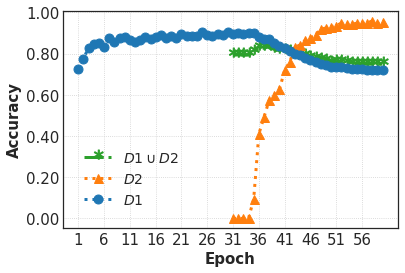

weighted f1 scores
y1 max:  0.9083924302808783
y2 d1 max:  0.9024283327615201
y2 d2 max:  0.9911504424778761
y2 d1&d2 max:  0.8339518755800889


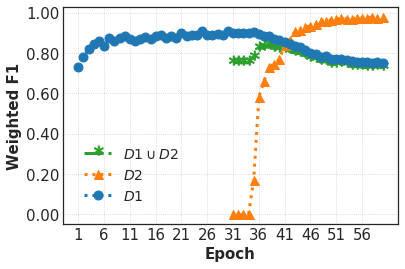

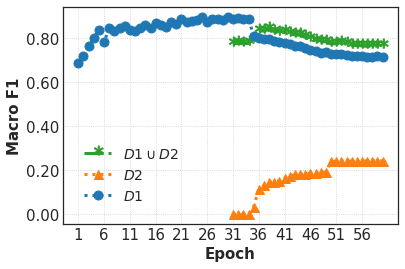

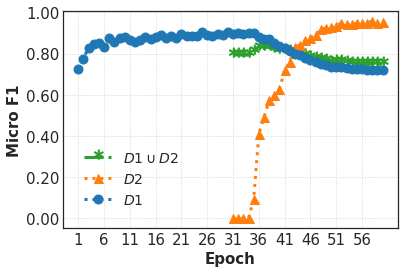

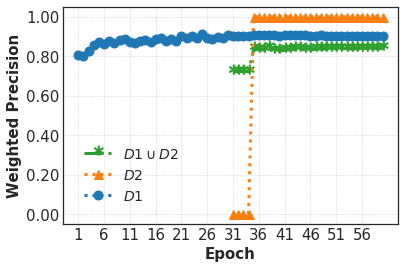

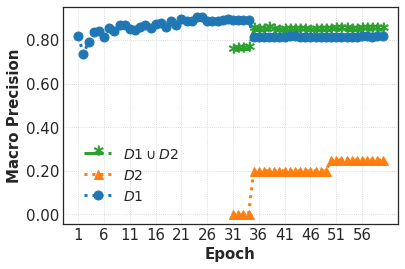

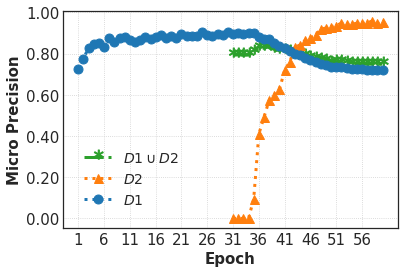

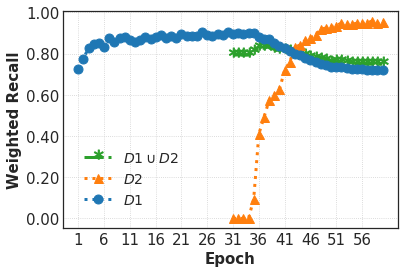

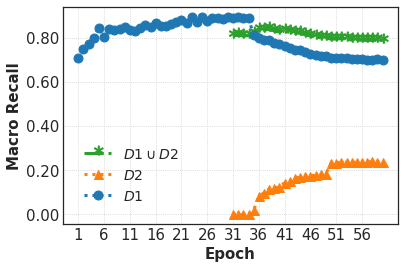

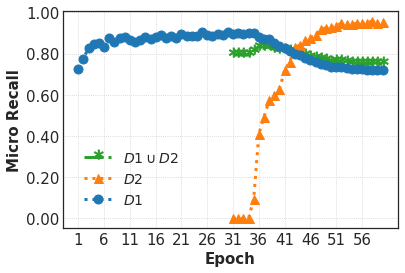

The shape of the train dataset is [[ 0.95774457 -0.80785272 -0.62090393 ... -0.82398156 -0.8817801
   0.59414878]
 [ 0.95774457 -0.80785272 -0.68247287 ... -0.82398156 -0.8817801
   0.63852889]
 [ 0.88395822 -0.80785272 -0.68247287 ... -0.73677349 -0.86303238
   0.59414878]
 ...
 [-0.73934137 -0.37654066 -0.77482628 ...  0.74576359 -0.41308717
   0.46100845]
 [-0.73934137 -0.37654066 -0.74404181 ...  0.74576359 -0.43183489
   0.46100845]
 [-0.70244819 -0.37654066 -0.77482628 ...  0.78936762 -0.43183489
   0.50538856]], and the labels is [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
The shape of the val dataset is [[-1.85943780e-01 -5.92196690e-01 -6.82472871e-01 ...  2.22515209e-01
  -6.00564342e-01  5.49768669e-01]
 [-1.47791758e-03 -2.46248469e-01 -7.44041811e-01 ... -8.27130148e-02
  -7.31798363e-01  4.16628339e-01]
 [ 2.93667462e-01 -6.79806954e-01 -7.44041811e-01 ... -5.18753334e-01
  -8.63032384e-01  4.61008449e-01]
 ...
 [-9.60700401e-01  1.47899980e+00 -6.20903930e-01 ...  5.277434

  0%|          | 0/11100 [00:00<?, ?it/s]


 --> model:         LSTM([33 X 60]_c11)
 --> hyper-params:  i11100-lr0.01-b32-adam
 --> EWC:           EWC10000000-N
sensor2-class--LSTM([33 X 60]_c11)--i11100-lr0.01-b32-adam--EWC10000000-N


Model-name: "LSTM([33 X 60]_c11)"
----------------------------------------MAIN MODEL----------------------------------------
Classifier(
  (flatten): Flatten()
  (lstm_input_dropout): Dropout(p=0.2)
  (lstm): LSTM(60, 32, batch_first=True)
  (lstm_fc): Linear(in_features=32, out_features=11, bias=True)
)
------------------------------------------------------------------------------------------
--> this network has 12395 parameters (~0.0 million)
      of which: - learnable: 12395 (~0.0 million)
                - fixed: 0 (~0.0 million)
------------------------------------------------------------------------------------------


--> Training:


  <SOLVER>   | Task: 1/2 | training loss: 0.612 | training precision: 0.75 |:   3%|▎         | 371/11100 [01:14<2:05:21,  1.43it/s]

Epoch 1 best model saved with weighted f1: 0.7546561070562213


  <SOLVER>   | Task: 1/2 | training loss: 0.625 | training precision: 0.812 |:   7%|▋         | 740/11100 [02:21<37:21,  4.62it/s]  

Epoch 2 best model saved with weighted f1: 0.7698518005216622


  <SOLVER>   | Task: 1/2 | training loss: 0.408 | training precision: 0.75 |:  10%|█         | 1110/11100 [03:30<31:21,  5.31it/s]  

Epoch 3 best model saved with weighted f1: 0.7885303261968348


  <SOLVER>   | Task: 1/2 | training loss: 0.226 | training precision: 0.938 |:  13%|█▎        | 1481/11100 [04:46<1:25:28,  1.88it/s]

Epoch 4 best model saved with weighted f1: 0.818770376257354


  <SOLVER>   | Task: 1/2 | training loss: 0.24 | training precision: 0.969 |:  17%|█▋        | 1849/11100 [05:54<16:31,  9.33it/s]   

Epoch 5 best model saved with weighted f1: 0.8287557144616052


  <SOLVER>   | Task: 1/2 | training loss: 0.509 | training precision: 0.812 |:  20%|██        | 2221/11100 [06:58<1:07:01,  2.21it/s]

Epoch 6 best model saved with weighted f1: 0.8292113076098836


  <SOLVER>   | Task: 1/2 | training loss: 0.264 | training precision: 0.844 |:  23%|██▎       | 2589/11100 [07:56<19:37,  7.23it/s]  

Epoch 7 best model saved with weighted f1: 0.8448350903443006


  <SOLVER>   | Task: 1/2 | training loss: 0.383 | training precision: 0.875 |:  30%|███       | 3331/11100 [10:25<1:21:45,  1.58it/s]

Epoch 9 best model saved with weighted f1: 0.849013970587577


  <SOLVER>   | Task: 1/2 | training loss: 0.219 | training precision: 0.906 |:  43%|████▎     | 4811/11100 [15:35<58:12,  1.80it/s]  

Epoch 13 best model saved with weighted f1: 0.8585805260977115


  <SOLVER>   | Task: 1/2 | training loss: 0.364 | training precision: 0.844 |:  50%|█████     | 5550/11100 [18:02<25:47,  3.59it/s] 

Epoch 15 best model saved with weighted f1: 0.8676272422490068


  <SOLVER>   | Task: 1/2 | training loss: 0.334 | training precision: 0.812 |:  53%|█████▎    | 5921/11100 [19:25<25:53,  3.33it/s] 

Epoch 16 best model saved with weighted f1: 0.878196607103505


  <SOLVER>   | Task: 1/2 | training loss: 0.247 | training precision: 0.938 |: 100%|██████████| 11100/11100 [37:13<00:00,  4.97it/s] 
  0%|          | 0/11100 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7358636715724245, 0.7753679318357862, 0.7916343919442292, 0.8195197521301317, 0.8319132455460883, 0.8303640588690937, 0.8450813323005422, 0.8326878388845856, 0.8512780790085205, 0.8280402788536019, 0.8357862122385747, 0.8086754453911696, 0.855151045701007, 0.8450813323005422, 0.8636715724244771, 0.8721920991479474, 0.8621223857474826, 0.8644461657629744, 0.8683191324554609, 0.8613477924089853, 0.855151045701007, 0.8497288923315259, 0.8613477924089853, 0.8505034856700232, 0.8636715724244771, 0.8536018590240124, 0.8559256390395042, 0.8528272656855151, 0.8512780790085205, 0.8505034856700232], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7358636715724245, 0.7753679318357862, 0.7916343919442292, 0.8195197521301317, 0.8319132455460883, 0.8303640588690937, 0.8450813323005422, 0.8326878388845856, 0.8512780790085205, 0.8280402788536019, 0.8357862122385747, 0.8086754453911696, 0.855151045701007, 0.8450813323005422,

  <SOLVER>   | Task: 1/2 | training loss: 0.786 | training precision: 0.812 |:   3%|▎         | 370/11100 [01:14<1:15:01,  2.38it/s]

Epoch 1 best model saved with weighted f1: 0.6697786746092788


  <SOLVER>   | Task: 1/2 | training loss: 0.569 | training precision: 0.844 |:   7%|▋         | 741/11100 [02:31<1:33:00,  1.86it/s]

Epoch 2 best model saved with weighted f1: 0.7621839254526225


  <SOLVER>   | Task: 1/2 | training loss: 0.705 | training precision: 0.719 |:  10%|█         | 1110/11100 [03:40<26:24,  6.31it/s]  

Epoch 3 best model saved with weighted f1: 0.800473126192168


  <SOLVER>   | Task: 1/2 | training loss: 0.498 | training precision: 0.844 |:  13%|█▎        | 1479/11100 [04:45<25:47,  6.22it/s]  

Epoch 4 best model saved with weighted f1: 0.8312551598886708


  <SOLVER>   | Task: 1/2 | training loss: 0.278 | training precision: 0.938 |:  17%|█▋        | 1850/11100 [06:03<38:46,  3.98it/s]  

Epoch 5 best model saved with weighted f1: 0.8445025087189668


  <SOLVER>   | Task: 1/2 | training loss: 0.333 | training precision: 0.875 |:  20%|██        | 2220/11100 [07:15<36:46,  4.02it/s]  

Epoch 6 best model saved with weighted f1: 0.8582831187966791


  <SOLVER>   | Task: 1/2 | training loss: 0.358 | training precision: 0.875 |:  23%|██▎       | 2591/11100 [08:26<41:42,  3.40it/s]  

Epoch 7 best model saved with weighted f1: 0.8632144079778249


  <SOLVER>   | Task: 1/2 | training loss: 0.33 | training precision: 0.812 |:  40%|████      | 4441/11100 [14:19<1:05:48,  1.69it/s] 

Epoch 12 best model saved with weighted f1: 0.8698397298722542


  <SOLVER>   | Task: 1/2 | training loss: 0.245 | training precision: 0.938 |:  43%|████▎     | 4810/11100 [15:32<28:39,  3.66it/s]  

Epoch 13 best model saved with weighted f1: 0.8705496371406521


  <SOLVER>   | Task: 1/2 | training loss: 0.329 | training precision: 0.875 |:  47%|████▋     | 5181/11100 [16:46<28:10,  3.50it/s]  

Epoch 14 best model saved with weighted f1: 0.8723581586118703


  <SOLVER>   | Task: 1/2 | training loss: 0.213 | training precision: 0.906 |:  53%|█████▎    | 5920/11100 [19:07<21:51,  3.95it/s] 

Epoch 16 best model saved with weighted f1: 0.8801122980688076


  <SOLVER>   | Task: 1/2 | training loss: 0.248 | training precision: 0.906 |:  60%|██████    | 6661/11100 [21:16<35:07,  2.11it/s]  

Epoch 18 best model saved with weighted f1: 0.8857743601467826


  <SOLVER>   | Task: 1/2 | training loss: 0.34 | training precision: 0.844 |:  80%|████████  | 8880/11100 [28:18<09:10,  4.03it/s]  

Epoch 24 best model saved with weighted f1: 0.8943298743455471


  <SOLVER>   | Task: 1/2 | training loss: 0.0921 | training precision: 1.0 |:  83%|████████▎ | 9249/11100 [29:22<04:03,  7.59it/s]  

Epoch 25 best model saved with weighted f1: 0.8945192999279079


  <SOLVER>   | Task: 1/2 | training loss: 0.29 | training precision: 0.938 |: 100%|██████████| 11100/11100 [35:08<00:00,  5.26it/s]  
  0%|          | 0/11100 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6878388845855926, 0.7645236250968241, 0.7823392718822618, 0.8280402788536019, 0.8412083656080558, 0.8567002323780015, 0.8621223857474826, 0.8543764523625097, 0.8450813323005422, 0.8613477924089853, 0.8567002323780015, 0.8675445391169636, 0.8675445391169636, 0.8698683191324554, 0.8683191324554609, 0.8776142525174283, 0.876839659178931, 0.8845855925639039, 0.8721920991479474, 0.8745158791634392, 0.8690937257939582, 0.8799380325329202, 0.8675445391169636, 0.8915569326103796, 0.8931061192873742, 0.8892331525948877, 0.8698683191324554, 0.8822618125484121, 0.8737412858249419, 0.8876839659178931], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6878388845855926, 0.7645236250968241, 0.7823392718822618, 0.8280402788536019, 0.8412083656080558, 0.8567002323780015, 0.8621223857474826, 0.8543764523625097, 0.8450813323005422, 0.8613477924089853, 0.8567002323780015, 0.8675445391169636, 0.8675445391169636, 0.869868319132455

  <SOLVER>   | Task: 1/2 | training loss: 0.887 | training precision: 0.625 |:   3%|▎         | 370/11100 [01:20<25:42,  6.96it/s]  

Epoch 1 best model saved with weighted f1: 0.7247133706164854


  <SOLVER>   | Task: 1/2 | training loss: 0.525 | training precision: 0.781 |:   7%|▋         | 741/11100 [02:56<2:14:46,  1.28it/s]

Epoch 2 best model saved with weighted f1: 0.7862808701941584


  <SOLVER>   | Task: 1/2 | training loss: 0.475 | training precision: 0.781 |:  10%|█         | 1110/11100 [04:28<27:26,  6.07it/s]  

Epoch 3 best model saved with weighted f1: 0.8310691839693058


  <SOLVER>   | Task: 1/2 | training loss: 0.466 | training precision: 0.844 |:  13%|█▎        | 1480/11100 [05:57<37:57,  4.22it/s]  

Epoch 4 best model saved with weighted f1: 0.8398010453591916


  <SOLVER>   | Task: 1/2 | training loss: 0.252 | training precision: 0.906 |:  17%|█▋        | 1851/11100 [07:33<1:37:36,  1.58it/s]

Epoch 5 best model saved with weighted f1: 0.8507252383581799


  <SOLVER>   | Task: 1/2 | training loss: 0.367 | training precision: 0.844 |:  33%|███▎      | 3700/11100 [15:10<29:37,  4.16it/s]  

Epoch 10 best model saved with weighted f1: 0.8660799986246263


  <SOLVER>   | Task: 1/2 | training loss: 0.326 | training precision: 0.906 |:  40%|████      | 4440/11100 [18:17<34:17,  3.24it/s]  

Epoch 12 best model saved with weighted f1: 0.8664884621941342


  <SOLVER>   | Task: 1/2 | training loss: 0.325 | training precision: 0.875 |:  47%|████▋     | 5180/11100 [21:06<30:05,  3.28it/s]  

Epoch 14 best model saved with weighted f1: 0.8807446862360855


  <SOLVER>   | Task: 1/2 | training loss: 0.286 | training precision: 0.906 |:  73%|███████▎  | 8140/11100 [33:54<10:31,  4.69it/s] 

Epoch 22 best model saved with weighted f1: 0.8834179837003866


  <SOLVER>   | Task: 1/2 | training loss: 0.407 | training precision: 0.844 |: 100%|██████████| 11100/11100 [46:28<00:00,  3.98it/s] 
  0%|          | 0/11100 [00:00<?, ?it/s]

Epoch 30 best model saved with weighted f1: 0.8866354859438126
precision_dict:  {'per_task_weighted_rec': [[0.737412858249419, 0.7869868319132456, 0.8280402788536019, 0.8481797056545314, 0.8489542989930287, 0.8396591789310612, 0.8218435321456236, 0.831138652207591, 0.8419829589465531, 0.8644461657629744, 0.8505034856700232, 0.8659953524399691, 0.8582494190549961, 0.8783888458559257, 0.8613477924089853, 0.8644461657629744, 0.8667699457784663, 0.838884585592564, 0.8474051123160341, 0.8597986057319907, 0.8381099922540666, 0.8814872192099148, 0.8721920991479474, 0.8597986057319907, 0.8574748257164988, 0.8435321456235476, 0.8760650658404338, 0.8814872192099148, 0.8698683191324554, 0.8838109992254066], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.737412858249419, 0.7869868319132456, 0.8280402788536019, 0.8481797056545314, 0.8489542989930287, 0.8396591789310612, 0.8218435321456236, 0.831138652207591, 0.8419829589465531, 0.8644461657629744, 0.8505034856700232

  <SOLVER>   | Task: 1/2 | training loss: 0.696 | training precision: 0.688 |:   3%|▎         | 370/11100 [01:15<55:06,  3.25it/s]  

Epoch 1 best model saved with weighted f1: 0.732708169586493


  <SOLVER>   | Task: 1/2 | training loss: 0.663 | training precision: 0.781 |:   7%|▋         | 740/11100 [02:43<33:03,  5.22it/s]  

Epoch 2 best model saved with weighted f1: 0.7870277786649781


  <SOLVER>   | Task: 1/2 | training loss: 0.529 | training precision: 0.844 |:  10%|█         | 1111/11100 [04:19<2:01:32,  1.37it/s]

Epoch 3 best model saved with weighted f1: 0.8155704926592597


  <SOLVER>   | Task: 1/2 | training loss: 0.376 | training precision: 0.844 |:  13%|█▎        | 1480/11100 [05:48<42:48,  3.74it/s]  

Epoch 4 best model saved with weighted f1: 0.8404668579555946


  <SOLVER>   | Task: 1/2 | training loss: 0.297 | training precision: 0.812 |:  17%|█▋        | 1851/11100 [07:17<1:25:44,  1.80it/s]

Epoch 5 best model saved with weighted f1: 0.8566257876890505


  <SOLVER>   | Task: 1/2 | training loss: 0.261 | training precision: 0.938 |:  20%|██        | 2220/11100 [08:44<20:42,  7.14it/s]  

Epoch 6 best model saved with weighted f1: 0.8672097043957447


  <SOLVER>   | Task: 1/2 | training loss: 0.238 | training precision: 0.906 |:  30%|███       | 3330/11100 [12:54<26:43,  4.84it/s]  

Epoch 9 best model saved with weighted f1: 0.8715666273266336


  <SOLVER>   | Task: 1/2 | training loss: 0.394 | training precision: 0.812 |:  33%|███▎      | 3701/11100 [14:17<1:06:01,  1.87it/s]

Epoch 10 best model saved with weighted f1: 0.8755261117918705


  <SOLVER>   | Task: 1/2 | training loss: 0.179 | training precision: 0.906 |:  37%|███▋      | 4070/11100 [15:33<28:57,  4.05it/s]  

Epoch 11 best model saved with weighted f1: 0.8804942649837564


  <SOLVER>   | Task: 1/2 | training loss: 0.198 | training precision: 0.938 |:  43%|████▎     | 4810/11100 [18:18<33:43,  3.11it/s]  

Epoch 13 best model saved with weighted f1: 0.8818999447252617


  <SOLVER>   | Task: 1/2 | training loss: 0.271 | training precision: 0.844 |:  47%|████▋     | 5180/11100 [19:38<20:05,  4.91it/s]  

Epoch 14 best model saved with weighted f1: 0.8913266431367839


  <SOLVER>   | Task: 1/2 | training loss: 0.301 | training precision: 0.812 |:  57%|█████▋    | 6290/11100 [23:36<15:27,  5.18it/s]   

Epoch 17 best model saved with weighted f1: 0.8941231766780016


  <SOLVER>   | Task: 1/2 | training loss: 0.122 | training precision: 0.938 |:  67%|██████▋   | 7401/11100 [28:03<47:36,  1.30it/s]  

Epoch 20 best model saved with weighted f1: 0.8950567330487695


  <SOLVER>   | Task: 1/2 | training loss: 0.394 | training precision: 0.875 |:  73%|███████▎  | 8141/11100 [30:54<29:47,  1.66it/s] 

Epoch 22 best model saved with weighted f1: 0.9111987940154693


  <SOLVER>   | Task: 1/2 | training loss: 0.189 | training precision: 0.969 |:  93%|█████████▎| 10361/11100 [39:07<04:18,  2.86it/s] 

Epoch 28 best model saved with weighted f1: 0.9122477946466635


  <SOLVER>   | Task: 1/2 | training loss: 0.235 | training precision: 0.844 |: 100%|██████████| 11100/11100 [42:00<00:00,  4.40it/s] 
  0%|          | 0/11100 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7273431448489543, 0.7815646785437645, 0.8164213787761425, 0.8412083656080558, 0.8597986057319907, 0.8659953524399691, 0.8636715724244771, 0.8443067389620449, 0.8690937257939582, 0.8737412858249419, 0.879163439194423, 0.8683191324554609, 0.8783888458559257, 0.8892331525948877, 0.8783888458559257, 0.8822618125484121, 0.8915569326103796, 0.8814872192099148, 0.8876839659178931, 0.8915569326103796, 0.8822618125484121, 0.9093725793958172, 0.8853601859024013, 0.8962044926413633, 0.8892331525948877, 0.8838109992254066, 0.8946553059643687, 0.9101471727343144, 0.8915569326103796, 0.9031758326878389], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7273431448489543, 0.7815646785437645, 0.8164213787761425, 0.8412083656080558, 0.8597986057319907, 0.8659953524399691, 0.8636715724244771, 0.8443067389620449, 0.8690937257939582, 0.8737412858249419, 0.879163439194423, 0.8683191324554609, 0.8783888458559257, 0.8892331525948877

  <SOLVER>   | Task: 1/2 | training loss: 0.83 | training precision: 0.688 |:   3%|▎         | 370/11100 [02:36<1:20:28,  2.22it/s] 

Epoch 1 best model saved with weighted f1: 0.6046216083961248


  <SOLVER>   | Task: 1/2 | training loss: 0.646 | training precision: 0.812 |:   7%|▋         | 740/11100 [05:12<1:06:44,  2.59it/s]

Epoch 2 best model saved with weighted f1: 0.7935971850444975


  <SOLVER>   | Task: 1/2 | training loss: 0.295 | training precision: 0.906 |:  17%|█▋        | 1850/11100 [13:19<1:12:26,  2.13it/s]

Epoch 5 best model saved with weighted f1: 0.8189538705994831


  <SOLVER>   | Task: 1/2 | training loss: 0.441 | training precision: 0.812 |:  20%|██        | 2220/11100 [15:50<53:18,  2.78it/s]  

Epoch 6 best model saved with weighted f1: 0.8260277029729036


  <SOLVER>   | Task: 1/2 | training loss: 0.509 | training precision: 0.906 |:  27%|██▋       | 2960/11100 [21:05<44:11,  3.07it/s]  

Epoch 8 best model saved with weighted f1: 0.8424627759182001


  <SOLVER>   | Task: 1/2 | training loss: 0.249 | training precision: 0.906 |:  30%|███       | 3330/11100 [23:50<55:47,  2.32it/s]  

Epoch 9 best model saved with weighted f1: 0.8463408882055163


  <SOLVER>   | Task: 1/2 | training loss: 0.512 | training precision: 0.812 |:  33%|███▎      | 3700/11100 [26:29<1:01:20,  2.01it/s]

Epoch 10 best model saved with weighted f1: 0.8474089010532874


  <SOLVER>   | Task: 1/2 | training loss: 0.589 | training precision: 0.781 |:  40%|████      | 4440/11100 [31:40<46:22,  2.39it/s]  

Epoch 12 best model saved with weighted f1: 0.853285724180164


  <SOLVER>   | Task: 1/2 | training loss: 0.203 | training precision: 0.938 |:  50%|█████     | 5550/11100 [39:50<30:49,  3.00it/s]  

Epoch 15 best model saved with weighted f1: 0.8594238721672312


  <SOLVER>   | Task: 1/2 | training loss: 0.208 | training precision: 0.969 |:  80%|████████  | 8880/11100 [1:04:51<17:14,  2.15it/s] 

Epoch 24 best model saved with weighted f1: 0.8612139789936806


  <SOLVER>   | Task: 1/2 | training loss: 0.192 | training precision: 0.938 |:  83%|████████▎ | 9250/11100 [1:07:53<18:32,  1.66it/s] 

Epoch 25 best model saved with weighted f1: 0.8799585368813488


  <SOLVER>   | Task: 1/2 | training loss: 0.482 | training precision: 0.75 |: 100%|██████████| 11100/11100 [1:22:25<00:00,  2.24it/s]  
  0%|          | 0/11100 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6297443841982959, 0.7877614252517429, 0.7931835786212239, 0.772269558481797, 0.8086754453911696, 0.8288148721920992, 0.8164213787761425, 0.8412083656080558, 0.8466305189775368, 0.8474051123160341, 0.8373353989155693, 0.8505034856700232, 0.8404337722695585, 0.8466305189775368, 0.8567002323780015, 0.8280402788536019, 0.8319132455460883, 0.8520526723470179, 0.8458559256390396, 0.8474051123160341, 0.8357862122385747, 0.8357862122385747, 0.8528272656855151, 0.8590240123934935, 0.8776142525174283, 0.8690937257939582, 0.8435321456235476, 0.8698683191324554, 0.8667699457784663, 0.8644461657629744], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6297443841982959, 0.7877614252517429, 0.7931835786212239, 0.772269558481797, 0.8086754453911696, 0.8288148721920992, 0.8164213787761425, 0.8412083656080558, 0.8466305189775368, 0.8474051123160341, 0.8373353989155693, 0.8505034856700232, 0.8404337722695585, 0.8466305189775368

  <SOLVER>   | Task: 1/2 | training loss: 0.653 | training precision: 0.781 |:   3%|▎         | 370/11100 [02:13<1:32:23,  1.94it/s]

Epoch 1 best model saved with weighted f1: 0.7126618031282509


  <SOLVER>   | Task: 1/2 | training loss: 0.739 | training precision: 0.781 |:   7%|▋         | 740/11100 [04:46<1:38:11,  1.76it/s]

Epoch 2 best model saved with weighted f1: 0.767318002937603


  <SOLVER>   | Task: 1/2 | training loss: 0.436 | training precision: 0.844 |:  10%|█         | 1110/11100 [07:22<1:25:26,  1.95it/s]

Epoch 3 best model saved with weighted f1: 0.8059438689371096


  <SOLVER>   | Task: 1/2 | training loss: 0.416 | training precision: 0.844 |:  17%|█▋        | 1850/11100 [12:32<54:09,  2.85it/s]  

Epoch 5 best model saved with weighted f1: 0.8429836141331777


  <SOLVER>   | Task: 1/2 | training loss: 0.244 | training precision: 0.875 |:  23%|██▎       | 2590/11100 [17:45<47:24,  2.99it/s]  

Epoch 7 best model saved with weighted f1: 0.8436478840608024


  <SOLVER>   | Task: 1/2 | training loss: 0.277 | training precision: 0.938 |:  27%|██▋       | 2960/11100 [20:18<57:56,  2.34it/s]  

Epoch 8 best model saved with weighted f1: 0.858096471463429


  <SOLVER>   | Task: 1/2 | training loss: 0.239 | training precision: 0.906 |:  30%|███       | 3330/11100 [22:52<46:18,  2.80it/s]  

Epoch 9 best model saved with weighted f1: 0.865341539588027


  <SOLVER>   | Task: 1/2 | training loss: 0.569 | training precision: 0.812 |:  33%|███▎      | 3700/11100 [25:28<45:49,  2.69it/s]  

Epoch 10 best model saved with weighted f1: 0.8699739445871656


  <SOLVER>   | Task: 1/2 | training loss: 0.433 | training precision: 0.812 |:  40%|████      | 4440/11100 [30:25<50:56,  2.18it/s]  

Epoch 12 best model saved with weighted f1: 0.8699879331295606


  <SOLVER>   | Task: 1/2 | training loss: 0.441 | training precision: 0.844 |:  43%|████▎     | 4810/11100 [32:43<55:22,  1.89it/s]  

Epoch 13 best model saved with weighted f1: 0.8729662552266255


  <SOLVER>   | Task: 1/2 | training loss: 0.194 | training precision: 0.906 |:  50%|█████     | 5550/11100 [37:38<40:43,  2.27it/s]  

Epoch 15 best model saved with weighted f1: 0.8757853477776665


  <SOLVER>   | Task: 1/2 | training loss: 0.317 | training precision: 0.875 |:  57%|█████▋    | 6290/11100 [42:30<33:38,  2.38it/s]  

Epoch 17 best model saved with weighted f1: 0.8776663515472488


  <SOLVER>   | Task: 1/2 | training loss: 0.13 | training precision: 0.969 |:  80%|████████  | 8880/11100 [1:00:09<17:13,  2.15it/s] 

Epoch 24 best model saved with weighted f1: 0.8795696403961479


  <SOLVER>   | Task: 1/2 | training loss: 0.2 | training precision: 0.938 |:  83%|████████▎ | 9250/11100 [1:02:44<12:49,  2.40it/s]  

Epoch 25 best model saved with weighted f1: 0.8806792899318758


  <SOLVER>   | Task: 1/2 | training loss: 0.392 | training precision: 0.812 |:  87%|████████▋ | 9620/11100 [1:05:26<10:27,  2.36it/s] 

Epoch 26 best model saved with weighted f1: 0.8843343184265854


  <SOLVER>   | Task: 1/2 | training loss: 0.259 | training precision: 0.844 |:  93%|█████████▎| 10360/11100 [1:10:43<07:57,  1.55it/s] 

Epoch 28 best model saved with weighted f1: 0.8882876750486416


  <SOLVER>   | Task: 1/2 | training loss: 0.177 | training precision: 0.938 |:  97%|█████████▋| 10730/11100 [1:13:17<01:51,  3.32it/s] 

Epoch 29 best model saved with weighted f1: 0.8983000459257535


  <SOLVER>   | Task: 1/2 | training loss: 0.329 | training precision: 0.844 |: 100%|██████████| 11100/11100 [1:15:52<00:00,  2.44it/s] 
  0%|          | 0/11100 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7095274980635167, 0.7660728117738187, 0.7993803253292022, 0.7862122385747483, 0.838884585592564, 0.8350116189000775, 0.8342370255615802, 0.8582494190549961, 0.8628969790859798, 0.8659953524399691, 0.8652207591014718, 0.8675445391169636, 0.8729666924864447, 0.8667699457784663, 0.8737412858249419, 0.8737412858249419, 0.8760650658404338, 0.8698683191324554, 0.8729666924864447, 0.8659953524399691, 0.8652207591014718, 0.8698683191324554, 0.8636715724244771, 0.879163439194423, 0.8807126258714175, 0.8822618125484121, 0.8698683191324554, 0.8869093725793958, 0.8969790859798605, 0.8884585592563904], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7095274980635167, 0.7660728117738187, 0.7993803253292022, 0.7862122385747483, 0.838884585592564, 0.8350116189000775, 0.8342370255615802, 0.8582494190549961, 0.8628969790859798, 0.8659953524399691, 0.8652207591014718, 0.8675445391169636, 0.8729666924864447, 0.8667699457784663,

  <SOLVER>   | Task: 1/2 | training loss: 0.672 | training precision: 0.688 |:   3%|▎         | 370/11100 [03:27<1:52:00,  1.60it/s]

Epoch 1 best model saved with weighted f1: 0.7123808164811527


  <SOLVER>   | Task: 1/2 | training loss: 0.491 | training precision: 0.812 |:   7%|▋         | 740/11100 [06:58<1:15:49,  2.28it/s]

Epoch 2 best model saved with weighted f1: 0.7391659545843356


  <SOLVER>   | Task: 1/2 | training loss: 0.715 | training precision: 0.719 |:  10%|█         | 1110/11100 [10:14<50:35,  3.29it/s]  

Epoch 3 best model saved with weighted f1: 0.784543496096569


  <SOLVER>   | Task: 1/2 | training loss: 0.423 | training precision: 0.844 |:  13%|█▎        | 1480/11100 [13:13<59:21,  2.70it/s]  

Epoch 4 best model saved with weighted f1: 0.8121160074227629


  <SOLVER>   | Task: 1/2 | training loss: 0.573 | training precision: 0.75 |:  23%|██▎       | 2590/11100 [23:42<1:39:02,  1.43it/s] 

Epoch 7 best model saved with weighted f1: 0.8482684674803125


  <SOLVER>   | Task: 1/2 | training loss: 0.594 | training precision: 0.719 |:  37%|███▋      | 4070/11100 [37:33<44:23,  2.64it/s]   

Epoch 11 best model saved with weighted f1: 0.8503322940776855


  <SOLVER>   | Task: 1/2 | training loss: 0.203 | training precision: 0.875 |:  53%|█████▎    | 5920/11100 [55:05<46:14,  1.87it/s]   

Epoch 16 best model saved with weighted f1: 0.855803537977437


  <SOLVER>   | Task: 1/2 | training loss: 0.23 | training precision: 0.906 |:  93%|█████████▎| 10360/11100 [1:36:42<05:11,  2.37it/s]  

Epoch 28 best model saved with weighted f1: 0.8593021925374189


  <SOLVER>   | Task: 1/2 | training loss: 0.454 | training precision: 0.812 |: 100%|██████████| 11100/11100 [1:43:25<00:00,  1.79it/s] 
  0%|          | 0/11100 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6986831913245546, 0.731990704879938, 0.774593338497289, 0.8032532920216886, 0.7660728117738187, 0.7955073586367157, 0.8466305189775368, 0.8334624322230829, 0.8350116189000775, 0.8342370255615802, 0.8435321456235476, 0.8342370255615802, 0.8474051123160341, 0.8419829589465531, 0.8272656855151046, 0.8528272656855151, 0.8079008520526724, 0.82571649883811, 0.8419829589465531, 0.8303640588690937, 0.8458559256390396, 0.8342370255615802, 0.8528272656855151, 0.8156467854376452, 0.8528272656855151, 0.8505034856700232, 0.8109992254066615, 0.8559256390395042, 0.8419829589465531, 0.8427575522850503], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6986831913245546, 0.731990704879938, 0.774593338497289, 0.8032532920216886, 0.7660728117738187, 0.7955073586367157, 0.8466305189775368, 0.8334624322230829, 0.8350116189000775, 0.8342370255615802, 0.8435321456235476, 0.8342370255615802, 0.8474051123160341, 0.8419829589465531, 0.

  <SOLVER>   | Task: 1/2 | training loss: 0.743 | training precision: 0.75 |:   3%|▎         | 370/11100 [03:09<40:55,  4.37it/s]   

Epoch 1 best model saved with weighted f1: 0.7169319303152668


  <SOLVER>   | Task: 1/2 | training loss: 0.448 | training precision: 0.781 |:   7%|▋         | 740/11100 [06:13<1:06:19,  2.60it/s]

Epoch 2 best model saved with weighted f1: 0.794341206801228


  <SOLVER>   | Task: 1/2 | training loss: 0.628 | training precision: 0.812 |:  10%|█         | 1110/11100 [09:18<1:16:45,  2.17it/s]

Epoch 3 best model saved with weighted f1: 0.8365091109837013


  <SOLVER>   | Task: 1/2 | training loss: 0.427 | training precision: 0.875 |:  17%|█▋        | 1850/11100 [15:33<1:17:24,  1.99it/s]

Epoch 5 best model saved with weighted f1: 0.8370054594529889


  <SOLVER>   | Task: 1/2 | training loss: 0.521 | training precision: 0.781 |:  23%|██▎       | 2590/11100 [21:47<1:09:16,  2.05it/s]

Epoch 7 best model saved with weighted f1: 0.8643282183513336


  <SOLVER>   | Task: 1/2 | training loss: 0.27 | training precision: 0.906 |:  27%|██▋       | 2960/11100 [24:56<20:12,  6.71it/s]   

Epoch 8 best model saved with weighted f1: 0.8699499584926949


  <SOLVER>   | Task: 1/2 | training loss: 0.239 | training precision: 0.875 |:  30%|███       | 3330/11100 [28:03<1:02:36,  2.07it/s] 

Epoch 9 best model saved with weighted f1: 0.8743225018753813


  <SOLVER>   | Task: 1/2 | training loss: 0.408 | training precision: 0.844 |:  37%|███▋      | 4070/11100 [34:07<1:05:51,  1.78it/s]

Epoch 11 best model saved with weighted f1: 0.8824274025681915


  <SOLVER>   | Task: 1/2 | training loss: 0.203 | training precision: 0.875 |:  43%|████▎     | 4810/11100 [40:03<45:50,  2.29it/s]   

Epoch 13 best model saved with weighted f1: 0.8861193112035497


  <SOLVER>   | Task: 1/2 | training loss: 0.225 | training precision: 0.906 |:  57%|█████▋    | 6290/11100 [52:21<38:47,  2.07it/s]   

Epoch 17 best model saved with weighted f1: 0.895092342346429


  <SOLVER>   | Task: 1/2 | training loss: 0.237 | training precision: 0.844 |:  67%|██████▋   | 7400/11100 [1:01:20<30:28,  2.02it/s] 

Epoch 20 best model saved with weighted f1: 0.8974716956770572


  <SOLVER>   | Task: 1/2 | training loss: 0.139 | training precision: 0.938 |:  77%|███████▋  | 8510/11100 [1:10:39<23:07,  1.87it/s]  

Epoch 23 best model saved with weighted f1: 0.9071958569265949


  <SOLVER>   | Task: 1/2 | training loss: 0.335 | training precision: 0.906 |: 100%|██████████| 11100/11100 [1:31:54<00:00,  2.01it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.721146398140976, 0.7970565453137103, 0.8241673121611154, 0.796281951975213, 0.8303640588690937, 0.8303640588690937, 0.8621223857474826, 0.8683191324554609, 0.8706429124709527, 0.8698683191324554, 0.8807126258714175, 0.8706429124709527, 0.8845855925639039, 0.8783888458559257, 0.8838109992254066, 0.8838109992254066, 0.8938807126258714, 0.8884585592563904, 0.8892331525948877, 0.8962044926413633, 0.8845855925639039, 0.8822618125484121, 0.9054996127033308, 0.87141750580945, 0.8636715724244771, 0.895429899302866, 0.8892331525948877, 0.8838109992254066, 0.895429899302866, 0.8845855925639039], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.721146398140976, 0.7970565453137103, 0.8241673121611154, 0.796281951975213, 0.8303640588690937, 0.8303640588690937, 0.8621223857474826, 0.8683191324554609, 0.8706429124709527, 0.8698683191324554, 0.8807126258714175, 0.8706429124709527, 0.8845855925639039, 0.8783888458559257, 0.88

  <SOLVER>   | Task: 2/2 | training loss: 2.51 | training precision: 0.0312 |:   5%|▍         | 61/1230 [00:23<04:53,  3.98it/s]

Epoch 3 best model saved with weighted f1: 0.03571428571428572


  <SOLVER>   | Task: 2/2 | training loss: 2.04 | training precision: 0.438 |:   7%|▋         | 80/1230 [00:29<06:23,  3.00it/s] 

Epoch 4 best model saved with weighted f1: 0.374384236453202


  <SOLVER>   | Task: 2/2 | training loss: 1.78 | training precision: 0.719 |:   8%|▊         | 101/1230 [00:38<04:15,  4.41it/s]

Epoch 5 best model saved with weighted f1: 0.7404580152671756


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.875 |:  10%|▉         | 121/1230 [00:45<04:38,  3.98it/s]

Epoch 6 best model saved with weighted f1: 0.9036544850498339


  <SOLVER>   | Task: 2/2 | training loss: 1.1 | training precision: 0.812 |:  11%|█▏        | 141/1230 [00:53<03:50,  4.72it/s] 

Epoch 7 best model saved with weighted f1: 0.9622641509433962


  <SOLVER>   | Task: 2/2 | training loss: 0.93 | training precision: 0.938 |:  13%|█▎        | 160/1230 [01:01<04:49,  3.70it/s] 

Epoch 8 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 0.796 | training precision: 0.969 |:  15%|█▍        | 180/1230 [01:10<06:05,  2.87it/s]

Epoch 9 best model saved with weighted f1: 0.978328173374613


  <SOLVER>   | Task: 2/2 | training loss: 0.701 | training precision: 0.938 |:  16%|█▋        | 200/1230 [01:19<05:08,  3.34it/s]

Epoch 10 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.562 | training precision: 1.0 |:  18%|█▊        | 221/1230 [01:26<03:29,  4.81it/s]  

Epoch 11 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.546 | training precision: 0.969 |:  20%|█▉        | 240/1230 [01:34<06:13,  2.65it/s]

Epoch 12 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.515 | training precision: 1.0 |:  21%|██        | 261/1230 [01:43<03:40,  4.39it/s]  

Epoch 13 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 1.0 |:  54%|█████▎    | 661/1230 [04:09<02:47,  3.39it/s]  

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 1.0 |:  55%|█████▌    | 682/1230 [04:16<01:39,  5.53it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 1.0 |:  57%|█████▋    | 700/1230 [04:23<02:14,  3.94it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 1.0 |:  59%|█████▊    | 720/1230 [04:30<02:25,  3.51it/s]  

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.197 | training precision: 1.0 |:  60%|██████    | 740/1230 [04:37<02:05,  3.92it/s] 

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.198 | training precision: 1.0 |:  62%|██████▏   | 760/1230 [04:46<02:14,  3.50it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.213 | training precision: 1.0 |:  63%|██████▎   | 780/1230 [04:55<01:53,  3.97it/s] 

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.19 | training precision: 1.0 |:  65%|██████▌   | 801/1230 [05:05<01:44,  4.09it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.182 | training precision: 1.0 |:  67%|██████▋   | 820/1230 [05:13<01:39,  4.14it/s]

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.204 | training precision: 0.969 |:  68%|██████▊   | 840/1230 [05:21<02:20,  2.77it/s]

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.176 | training precision: 1.0 |:  70%|███████   | 861/1230 [05:29<01:30,  4.08it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 1.0 |:  72%|███████▏  | 880/1230 [05:35<01:06,  5.23it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.186 | training precision: 1.0 |:  73%|███████▎  | 900/1230 [05:43<01:51,  2.95it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  75%|███████▍  | 921/1230 [05:52<01:14,  4.15it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  76%|███████▋  | 940/1230 [05:59<01:17,  3.74it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.186 | training precision: 1.0 |:  78%|███████▊  | 961/1230 [06:05<01:06,  4.04it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.148 | training precision: 1.0 |:  80%|███████▉  | 980/1230 [06:13<01:38,  2.53it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.165 | training precision: 1.0 |:  81%|████████▏ | 1000/1230 [06:21<01:14,  3.07it/s] 

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.17 | training precision: 1.0 |:  83%|████████▎ | 1021/1230 [06:28<00:50,  4.12it/s]   

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  85%|████████▍ | 1040/1230 [06:35<01:05,  2.92it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.14 | training precision: 1.0 |:  86%|████████▌ | 1060/1230 [06:45<00:46,  3.64it/s]   

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.151 | training precision: 1.0 |:  88%|████████▊ | 1081/1230 [06:53<00:30,  4.86it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.138 | training precision: 1.0 |:  89%|████████▉ | 1100/1230 [07:01<00:34,  3.72it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.14 | training precision: 1.0 |:  91%|█████████ | 1121/1230 [07:08<00:27,  3.92it/s] 

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.126 | training precision: 1.0 |:  93%|█████████▎| 1140/1230 [07:16<00:24,  3.63it/s] 

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  94%|█████████▍| 1160/1230 [07:22<00:17,  3.93it/s] 

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.143 | training precision: 1.0 |:  96%|█████████▌| 1181/1230 [07:28<00:08,  5.53it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.116 | training precision: 1.0 |:  98%|█████████▊| 1200/1230 [07:34<00:07,  3.82it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.125 | training precision: 1.0 |:  99%|█████████▉| 1220/1230 [07:42<00:02,  3.37it/s]  

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.12 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:47<00:00,  2.63it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.8303640588690937, 0.7412858249419055, 0.7405112316034083, 0.7126258714175058, 0.69713400464756, 0.6715724244771495, 0.65143299767622, 0.6491092176607282, 0.6429124709527498, 0.6305189775367932, 0.627420604182804, 0.6305189775367932, 0.6312935708752905, 0.6506584043377227, 0.6343919442292796, 0.6405886909372579, 0.635166537567777, 0.6483346243222309, 0.6444616576297444, 0.6483346243222309, 0.6359411309062742, 0.6467854376452362, 0.6421378776142526, 0.6367157242447715, 0.6498838109992254, 0.6405886909372579, 0.6281951975213013, 0.6297443841982959, 0.6204492641363284, 0.6374903175832688, 0.6204492641363284, 0.6235476374903176, 0.6250968241673122, 0.6119287374128582, 0.6096049573973664, 0.6127033307513555, 0.6034082106893881, 0.6181254841208366, 0.611154144074361, 0.6088303640588691, 0.6181254841208366, 0.6150271107668474, 0.6057319907048799, 0.6119287374128582, 0.6026336173508908, 0.6026336173508908, 0.5910147172734315, 0.592563903950426, 0.6

  <SOLVER>   | Task: 2/2 | training loss: 3.09 | training precision: 0.0625 |:   7%|▋         | 80/1230 [00:30<05:16,  3.63it/s]

Epoch 4 best model saved with weighted f1: 0.05882352941176471


  <SOLVER>   | Task: 2/2 | training loss: 2.81 | training precision: 0.156 |:   8%|▊         | 101/1230 [00:37<04:58,  3.78it/s]

Epoch 5 best model saved with weighted f1: 0.27225130890052357


  <SOLVER>   | Task: 2/2 | training loss: 2.53 | training precision: 0.188 |:  10%|▉         | 120/1230 [00:44<04:13,  4.39it/s]

Epoch 6 best model saved with weighted f1: 0.4507042253521126


  <SOLVER>   | Task: 2/2 | training loss: 2.0 | training precision: 0.656 |:  11%|█▏        | 141/1230 [00:51<04:17,  4.23it/s] 

Epoch 7 best model saved with weighted f1: 0.6639676113360323


  <SOLVER>   | Task: 2/2 | training loss: 1.72 | training precision: 0.719 |:  13%|█▎        | 160/1230 [00:59<05:59,  2.97it/s]

Epoch 8 best model saved with weighted f1: 0.8129496402877697


  <SOLVER>   | Task: 2/2 | training loss: 1.4 | training precision: 0.812 |:  15%|█▍        | 180/1230 [01:08<06:17,  2.78it/s] 

Epoch 9 best model saved with weighted f1: 0.9072847682119206


  <SOLVER>   | Task: 2/2 | training loss: 1.27 | training precision: 0.844 |:  16%|█▋        | 201/1230 [01:16<04:24,  3.89it/s]

Epoch 10 best model saved with weighted f1: 0.9354838709677419


  <SOLVER>   | Task: 2/2 | training loss: 1.12 | training precision: 0.875 |:  18%|█▊        | 220/1230 [01:24<05:27,  3.08it/s]

Epoch 11 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 0.991 | training precision: 0.938 |:  20%|█▉        | 240/1230 [01:32<04:09,  3.97it/s]

Epoch 12 best model saved with weighted f1: 0.9814814814814815


  <SOLVER>   | Task: 2/2 | training loss: 0.788 | training precision: 0.938 |:  24%|██▍       | 300/1230 [01:52<03:24,  4.54it/s]

Epoch 15 best model saved with weighted f1: 0.9846153846153848


  <SOLVER>   | Task: 2/2 | training loss: 0.836 | training precision: 0.875 |:  26%|██▌       | 321/1230 [01:59<02:36,  5.82it/s]

Epoch 16 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.596 | training precision: 0.969 |:  31%|███       | 380/1230 [02:23<04:55,  2.87it/s]

Epoch 19 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.582 | training precision: 0.969 |:  33%|███▎      | 401/1230 [02:31<02:46,  4.97it/s]

Epoch 20 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.23 | training precision: 0.969 |:  65%|██████▌   | 800/1230 [04:58<01:27,  4.89it/s] 

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.217 | training precision: 1.0 |:  67%|██████▋   | 821/1230 [05:06<01:30,  4.53it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.206 | training precision: 1.0 |:  68%|██████▊   | 841/1230 [05:12<01:26,  4.48it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.192 | training precision: 1.0 |:  70%|███████   | 861/1230 [05:19<01:37,  3.79it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.181 | training precision: 1.0 |:  72%|███████▏  | 881/1230 [05:26<01:10,  4.93it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.163 | training precision: 1.0 |:  73%|███████▎  | 901/1230 [05:33<01:13,  4.47it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.152 | training precision: 1.0 |:  75%|███████▍  | 920/1230 [05:39<01:06,  4.66it/s]  

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.163 | training precision: 1.0 |:  76%|███████▋  | 940/1230 [05:46<00:53,  5.43it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.184 | training precision: 1.0 |:  78%|███████▊  | 961/1230 [05:53<00:43,  6.15it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  80%|███████▉  | 981/1230 [06:00<01:02,  4.01it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.182 | training precision: 1.0 |:  81%|████████▏ | 1000/1230 [06:06<00:46,  4.90it/s] 

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.161 | training precision: 1.0 |:  83%|████████▎ | 1021/1230 [06:13<00:51,  4.06it/s]  

Epoch 51 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.106 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:26<00:00,  2.75it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8489542989930287, 0.8264910921766073, 0.8156467854376452, 0.8195197521301317, 0.796281951975213, 0.8063516653756778, 0.7877614252517429, 0.7869868319132456, 0.7606506584043378, 0.7521301316808675, 0.7327652982184353, 0.7172734314484895, 0.7257939581719597, 0.721146398140976, 0.7203718048024786, 0.7095274980635167, 0.7056545313710302, 0.7203718048024786, 0.713400464756003, 0.7087529047250194, 0.7079783113865221, 0.7195972114639814, 0.7141750580945004, 0.7017815646785438, 0.7087529047250194, 0.715724244771495, 0.7095274980635167, 0.7064291247095275, 0.7141750580945004, 0.7242447714949651, 0.7126258714175058, 0.7226955848179706, 0.7234701781564679, 0.721146398140976, 0.7172734314484895, 0.7164988381099923, 0.7149496514329977, 0.7180480247869868, 0.7110766847405112, 0.7025561580170411, 0.7079783113865221, 0.7079783113865221, 0.69713400464756, 0.6986831913245546, 0.69713400464756, 0.6901626646010844, 0.6847405112316034, 0.6831913245546088, 0.68

  <SOLVER>   | Task: 2/2 | training loss: 3.4 | training precision: 0.0625 |:   8%|▊         | 101/1230 [00:36<03:35,  5.24it/s] 

Epoch 5 best model saved with weighted f1: 0.125


  <SOLVER>   | Task: 2/2 | training loss: 2.81 | training precision: 0.25 |:  10%|▉         | 121/1230 [00:43<04:20,  4.25it/s]  

Epoch 6 best model saved with weighted f1: 0.3663366336633664


  <SOLVER>   | Task: 2/2 | training loss: 2.44 | training precision: 0.219 |:  11%|█▏        | 140/1230 [00:49<03:15,  5.58it/s] 

Epoch 7 best model saved with weighted f1: 0.4507042253521126


  <SOLVER>   | Task: 2/2 | training loss: 1.91 | training precision: 0.531 |:  13%|█▎        | 161/1230 [00:55<03:13,  5.54it/s]

Epoch 8 best model saved with weighted f1: 0.6016949152542374


  <SOLVER>   | Task: 2/2 | training loss: 1.71 | training precision: 0.688 |:  15%|█▍        | 181/1230 [01:01<03:17,  5.30it/s]

Epoch 9 best model saved with weighted f1: 0.7547169811320755


  <SOLVER>   | Task: 2/2 | training loss: 1.51 | training precision: 0.719 |:  16%|█▋        | 200/1230 [01:11<04:34,  3.75it/s]

Epoch 10 best model saved with weighted f1: 0.8926174496644296


  <SOLVER>   | Task: 2/2 | training loss: 1.39 | training precision: 0.75 |:  18%|█▊        | 220/1230 [01:20<05:22,  3.13it/s] 

Epoch 11 best model saved with weighted f1: 0.9285714285714286


  <SOLVER>   | Task: 2/2 | training loss: 1.19 | training precision: 0.875 |:  19%|█▉        | 239/1230 [01:27<04:14,  3.89it/s]

Epoch 12 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.938 |:  23%|██▎       | 281/1230 [01:42<03:32,  4.46it/s] 

Epoch 14 best model saved with weighted f1: 0.9589905362776026


  <SOLVER>   | Task: 2/2 | training loss: 1.11 | training precision: 0.781 |:  24%|██▍       | 301/1230 [01:49<02:47,  5.56it/s] 

Epoch 15 best model saved with weighted f1: 0.9751552795031057


  <SOLVER>   | Task: 2/2 | training loss: 0.67 | training precision: 0.969 |:  33%|███▎      | 403/1230 [02:24<01:58,  6.97it/s] 

Epoch 20 best model saved with weighted f1: 0.9846153846153848


  <SOLVER>   | Task: 2/2 | training loss: 0.658 | training precision: 0.969 |:  34%|███▍      | 421/1230 [02:31<02:57,  4.57it/s]

Epoch 21 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.625 | training precision: 0.938 |:  44%|████▍     | 540/1230 [03:12<02:52,  4.00it/s]

Epoch 27 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.317 | training precision: 1.0 |:  47%|████▋     | 581/1230 [03:30<03:14,  3.33it/s]  

Epoch 29 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.253 | training precision: 1.0 |:  57%|█████▋    | 701/1230 [04:08<02:28,  3.56it/s]  

Epoch 35 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.206 | training precision: 0.969 |:  83%|████████▎ | 1023/1230 [06:03<00:27,  7.53it/s]

Epoch 51 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.156 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:15<00:00,  2.82it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8652207591014718, 0.8497288923315259, 0.8466305189775368, 0.8458559256390396, 0.8350116189000775, 0.836560805577072, 0.8156467854376452, 0.8055770720371804, 0.8001549186676995, 0.7970565453137103, 0.7807900852052673, 0.7629744384198296, 0.7683965917893106, 0.761425251742835, 0.7676219984508134, 0.7482571649883811, 0.7521301316808675, 0.761425251742835, 0.7598760650658405, 0.756003098373354, 0.7436096049573974, 0.756003098373354, 0.7490317583268784, 0.7366382649109218, 0.7381874515879163, 0.7381874515879163, 0.7366382649109218, 0.7490317583268784, 0.7350890782339272, 0.7397366382649109, 0.7257939581719597, 0.7296669248644462, 0.721146398140976, 0.721146398140976, 0.7149496514329977, 0.710302091402014, 0.7041053446940356, 0.710302091402014, 0.7048799380325329, 0.7010069713400465, 0.6948102246320682, 0.6979085979860573, 0.6909372579395817, 0.6886134779240899, 0.6901626646010844, 0.6870642912470952, 0.6831913245546088, 0.6831913245546088, 0.68

  <SOLVER>   | Task: 2/2 | training loss: 3.16 | training precision: 0.0312 |:  15%|█▍        | 180/1230 [01:02<04:09,  4.20it/s]

Epoch 9 best model saved with weighted f1: 0.03571428571428572


  <SOLVER>   | Task: 2/2 | training loss: 2.86 | training precision: 0.0312 |:  16%|█▋        | 201/1230 [01:11<03:58,  4.31it/s]

Epoch 10 best model saved with weighted f1: 0.16666666666666669


  <SOLVER>   | Task: 2/2 | training loss: 2.47 | training precision: 0.219 |:  18%|█▊        | 220/1230 [01:19<04:22,  3.85it/s] 

Epoch 11 best model saved with weighted f1: 0.29896907216494845


  <SOLVER>   | Task: 2/2 | training loss: 2.03 | training precision: 0.312 |:  20%|█▉        | 240/1230 [01:25<03:45,  4.40it/s] 

Epoch 12 best model saved with weighted f1: 0.3823529411764706


  <SOLVER>   | Task: 2/2 | training loss: 2.01 | training precision: 0.312 |:  21%|██        | 261/1230 [01:34<04:03,  3.98it/s]

Epoch 13 best model saved with weighted f1: 0.5067873303167422


  <SOLVER>   | Task: 2/2 | training loss: 1.77 | training precision: 0.375 |:  23%|██▎       | 280/1230 [01:41<04:14,  3.73it/s]

Epoch 14 best model saved with weighted f1: 0.5267857142857143


  <SOLVER>   | Task: 2/2 | training loss: 1.61 | training precision: 0.344 |:  24%|██▍       | 301/1230 [01:48<03:37,  4.28it/s]

Epoch 15 best model saved with weighted f1: 0.6419753086419753


  <SOLVER>   | Task: 2/2 | training loss: 1.13 | training precision: 0.594 |:  26%|██▌       | 321/1230 [01:54<03:13,  4.70it/s]

Epoch 16 best model saved with weighted f1: 0.6693548387096775


  <SOLVER>   | Task: 2/2 | training loss: 1.18 | training precision: 0.5 |:  28%|██▊       | 341/1230 [02:01<03:23,  4.37it/s]  

Epoch 17 best model saved with weighted f1: 0.7499999999999999


  <SOLVER>   | Task: 2/2 | training loss: 1.09 | training precision: 0.75 |:  29%|██▉       | 361/1230 [02:07<03:14,  4.46it/s] 

Epoch 18 best model saved with weighted f1: 0.7547169811320755


  <SOLVER>   | Task: 2/2 | training loss: 1.02 | training precision: 0.688 |:  31%|███       | 381/1230 [02:14<02:49,  4.99it/s] 

Epoch 19 best model saved with weighted f1: 0.8129496402877697


  <SOLVER>   | Task: 2/2 | training loss: 0.757 | training precision: 0.875 |:  33%|███▎      | 400/1230 [02:21<03:43,  3.71it/s]

Epoch 20 best model saved with weighted f1: 0.8421052631578947


  <SOLVER>   | Task: 2/2 | training loss: 0.875 | training precision: 0.812 |:  36%|███▌      | 441/1230 [02:37<03:09,  4.16it/s]

Epoch 22 best model saved with weighted f1: 0.8501742160278746


  <SOLVER>   | Task: 2/2 | training loss: 0.676 | training precision: 0.906 |:  37%|███▋      | 461/1230 [02:42<02:29,  5.14it/s]

Epoch 23 best model saved with weighted f1: 0.8926174496644296


  <SOLVER>   | Task: 2/2 | training loss: 0.671 | training precision: 0.844 |:  41%|████      | 500/1230 [02:58<03:08,  3.87it/s]

Epoch 25 best model saved with weighted f1: 0.9108910891089108


  <SOLVER>   | Task: 2/2 | training loss: 0.586 | training precision: 0.906 |:  42%|████▏     | 521/1230 [03:06<03:08,  3.75it/s]

Epoch 26 best model saved with weighted f1: 0.9389067524115756


  <SOLVER>   | Task: 2/2 | training loss: 0.412 | training precision: 1.0 |:  46%|████▌     | 561/1230 [03:20<02:21,  4.71it/s]  

Epoch 28 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 0.522 | training precision: 0.906 |:  47%|████▋     | 580/1230 [03:29<03:43,  2.91it/s]

Epoch 29 best model saved with weighted f1: 0.9523809523809523


  <SOLVER>   | Task: 2/2 | training loss: 0.535 | training precision: 0.906 |:  49%|████▉     | 601/1230 [03:35<01:46,  5.93it/s]

Epoch 30 best model saved with weighted f1: 0.9622641509433962


  <SOLVER>   | Task: 2/2 | training loss: 0.458 | training precision: 0.906 |:  50%|█████     | 620/1230 [03:41<02:09,  4.71it/s]

Epoch 31 best model saved with weighted f1: 0.9655172413793104


  <SOLVER>   | Task: 2/2 | training loss: 0.453 | training precision: 0.875 |:  54%|█████▎    | 660/1230 [03:54<02:25,  3.91it/s]

Epoch 33 best model saved with weighted f1: 0.9719626168224298


  <SOLVER>   | Task: 2/2 | training loss: 0.328 | training precision: 0.969 |:  57%|█████▋    | 701/1230 [04:07<02:36,  3.38it/s]

Epoch 35 best model saved with weighted f1: 0.978328173374613


  <SOLVER>   | Task: 2/2 | training loss: 0.349 | training precision: 0.906 |:  60%|██████    | 740/1230 [04:20<01:38,  4.97it/s]

Epoch 37 best model saved with weighted f1: 0.9846153846153848


  <SOLVER>   | Task: 2/2 | training loss: 0.34 | training precision: 0.875 |:  65%|██████▌   | 801/1230 [04:39<02:12,  3.23it/s] 

Epoch 40 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.208 | training precision: 1.0 |:  86%|████████▋ | 1061/1230 [06:07<00:26,  6.30it/s]  

Epoch 53 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.195 | training precision: 0.969 |:  91%|█████████ | 1121/1230 [06:30<00:26,  4.14it/s]

Epoch 56 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.154 | training precision: 0.969 |: 100%|██████████| 1230/1230 [07:07<00:00,  2.88it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8985282726568552, 0.8985282726568552, 0.8985282726568552, 0.895429899302866, 0.8985282726568552, 0.8969790859798605, 0.8985282726568552, 0.8962044926413633, 0.900852052672347, 0.8946553059643687, 0.8931061192873742, 0.8946553059643687, 0.8830364058869093, 0.8900077459333849, 0.8729666924864447, 0.8644461657629744, 0.8597986057319907, 0.8621223857474826, 0.8419829589465531, 0.8443067389620449, 0.8381099922540666, 0.8264910921766073, 0.8032532920216886, 0.8040278853601859, 0.7931835786212239, 0.7815646785437645, 0.7862122385747483, 0.7807900852052673, 0.7714949651432997, 0.7637490317583269, 0.7606506584043378, 0.761425251742835, 0.7498063516653757, 0.7474825716498839, 0.7397366382649109, 0.7343144848954299, 0.7288923315259489, 0.7327652982184353, 0.726568551510457, 0.721146398140976, 0.7219209914794733, 0.7219209914794733, 0.7203718048024786, 0.721146398140976, 0.7172734314484895, 0.7172734314484895, 0.7141750580945004, 0.7095274980635167, 0

  <SOLVER>   | Task: 2/2 | training loss: 3.74 | training precision: 0.0 |:  16%|█▋        | 201/1230 [01:11<03:37,  4.74it/s]   

Epoch 10 best model saved with weighted f1: 0.02395209580838323


  <SOLVER>   | Task: 2/2 | training loss: 2.61 | training precision: 0.125 |:  18%|█▊        | 221/1230 [01:17<04:00,  4.20it/s] 

Epoch 11 best model saved with weighted f1: 0.10344827586206898


  <SOLVER>   | Task: 2/2 | training loss: 2.68 | training precision: 0.0312 |:  20%|█▉        | 241/1230 [01:24<03:34,  4.60it/s]

Epoch 12 best model saved with weighted f1: 0.17679558011049726


  <SOLVER>   | Task: 2/2 | training loss: 2.5 | training precision: 0.0625 |:  21%|██        | 261/1230 [01:29<02:32,  6.34it/s] 

Epoch 13 best model saved with weighted f1: 0.27225130890052357


  <SOLVER>   | Task: 2/2 | training loss: 2.37 | training precision: 0.156 |:  23%|██▎       | 281/1230 [01:35<03:22,  4.70it/s] 

Epoch 14 best model saved with weighted f1: 0.3582089552238806


  <SOLVER>   | Task: 2/2 | training loss: 2.32 | training precision: 0.188 |:  24%|██▍       | 301/1230 [01:43<04:26,  3.48it/s] 

Epoch 15 best model saved with weighted f1: 0.46511627906976744


  <SOLVER>   | Task: 2/2 | training loss: 1.55 | training precision: 0.406 |:  26%|██▌       | 321/1230 [01:50<03:54,  3.87it/s] 

Epoch 16 best model saved with weighted f1: 0.5067873303167422


  <SOLVER>   | Task: 2/2 | training loss: 1.51 | training precision: 0.469 |:  28%|██▊       | 341/1230 [01:56<03:28,  4.26it/s]

Epoch 17 best model saved with weighted f1: 0.5897435897435896


  <SOLVER>   | Task: 2/2 | training loss: 1.58 | training precision: 0.281 |:  29%|██▉       | 360/1230 [02:04<04:53,  2.96it/s]

Epoch 18 best model saved with weighted f1: 0.6419753086419753


  <SOLVER>   | Task: 2/2 | training loss: 1.4 | training precision: 0.562 |:  31%|███       | 381/1230 [02:12<02:35,  5.45it/s]  

Epoch 19 best model saved with weighted f1: 0.6746987951807228


  <SOLVER>   | Task: 2/2 | training loss: 1.24 | training precision: 0.562 |:  33%|███▎      | 402/1230 [02:19<02:33,  5.39it/s] 

Epoch 20 best model saved with weighted f1: 0.7007874015748031


  <SOLVER>   | Task: 2/2 | training loss: 1.04 | training precision: 0.625 |:  34%|███▍      | 421/1230 [02:28<04:09,  3.24it/s] 

Epoch 21 best model saved with weighted f1: 0.7159533073929961


  <SOLVER>   | Task: 2/2 | training loss: 1.32 | training precision: 0.469 |:  36%|███▌      | 441/1230 [02:35<03:23,  3.88it/s] 

Epoch 22 best model saved with weighted f1: 0.7404580152671756


  <SOLVER>   | Task: 2/2 | training loss: 0.811 | training precision: 0.688 |:  37%|███▋      | 461/1230 [02:42<02:41,  4.75it/s]

Epoch 23 best model saved with weighted f1: 0.7686567164179104


  <SOLVER>   | Task: 2/2 | training loss: 0.818 | training precision: 0.656 |:  39%|███▉      | 480/1230 [02:48<04:12,  2.98it/s]

Epoch 24 best model saved with weighted f1: 0.7777777777777778


  <SOLVER>   | Task: 2/2 | training loss: 1.0 | training precision: 0.688 |:  41%|████      | 501/1230 [02:55<02:12,  5.51it/s]  

Epoch 25 best model saved with weighted f1: 0.8043478260869564


  <SOLVER>   | Task: 2/2 | training loss: 0.679 | training precision: 0.719 |:  42%|████▏     | 521/1230 [03:04<03:11,  3.70it/s]

Epoch 26 best model saved with weighted f1: 0.8380281690140845


  <SOLVER>   | Task: 2/2 | training loss: 0.878 | training precision: 0.688 |:  44%|████▍     | 541/1230 [03:12<02:58,  3.86it/s]

Epoch 27 best model saved with weighted f1: 0.8501742160278746


  <SOLVER>   | Task: 2/2 | training loss: 0.282 | training precision: 0.938 |:  46%|████▌     | 561/1230 [03:17<02:09,  5.16it/s]

Epoch 28 best model saved with weighted f1: 0.8737201365187712


  <SOLVER>   | Task: 2/2 | training loss: 0.705 | training precision: 0.719 |:  47%|████▋     | 581/1230 [03:23<02:48,  3.85it/s]

Epoch 29 best model saved with weighted f1: 0.8813559322033897


  <SOLVER>   | Task: 2/2 | training loss: 0.583 | training precision: 0.75 |:  49%|████▉     | 600/1230 [03:30<03:38,  2.88it/s] 

Epoch 30 best model saved with weighted f1: 0.8851351351351351


  <SOLVER>   | Task: 2/2 | training loss: 0.428 | training precision: 0.812 |:  50%|█████     | 621/1230 [03:37<01:34,  6.42it/s]

Epoch 31 best model saved with weighted f1: 0.9072847682119206


  <SOLVER>   | Task: 2/2 | training loss: 0.552 | training precision: 0.781 |:  52%|█████▏    | 641/1230 [03:43<01:49,  5.40it/s]

Epoch 32 best model saved with weighted f1: 0.9108910891089108


  <SOLVER>   | Task: 2/2 | training loss: 0.511 | training precision: 0.812 |:  54%|█████▎    | 660/1230 [03:50<03:01,  3.14it/s]

Epoch 33 best model saved with weighted f1: 0.9250814332247556


  <SOLVER>   | Task: 2/2 | training loss: 0.456 | training precision: 0.844 |:  57%|█████▋    | 701/1230 [04:04<01:56,  4.55it/s]

Epoch 35 best model saved with weighted f1: 0.9354838709677419


  <SOLVER>   | Task: 2/2 | training loss: 0.356 | training precision: 0.844 |:  59%|█████▊    | 720/1230 [04:08<01:12,  7.04it/s]

Epoch 36 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 0.296 | training precision: 0.906 |:  62%|██████▏   | 761/1230 [04:21<01:25,  5.48it/s]

Epoch 38 best model saved with weighted f1: 0.9490445859872613


  <SOLVER>   | Task: 2/2 | training loss: 0.303 | training precision: 0.875 |:  65%|██████▌   | 801/1230 [04:35<01:58,  3.62it/s]

Epoch 40 best model saved with weighted f1: 0.9556962025316457


  <SOLVER>   | Task: 2/2 | training loss: 0.318 | training precision: 0.875 |:  67%|██████▋   | 821/1230 [04:40<01:06,  6.15it/s]

Epoch 41 best model saved with weighted f1: 0.9589905362776026


  <SOLVER>   | Task: 2/2 | training loss: 0.397 | training precision: 0.781 |:  68%|██████▊   | 841/1230 [04:48<01:45,  3.69it/s]

Epoch 42 best model saved with weighted f1: 0.9655172413793104


  <SOLVER>   | Task: 2/2 | training loss: 0.271 | training precision: 0.906 |:  72%|███████▏  | 882/1230 [05:01<00:48,  7.18it/s]

Epoch 44 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 0.317 | training precision: 0.844 |:  73%|███████▎  | 902/1230 [05:05<00:48,  6.82it/s]

Epoch 45 best model saved with weighted f1: 0.9719626168224298


  <SOLVER>   | Task: 2/2 | training loss: 0.227 | training precision: 0.938 |:  75%|███████▍  | 920/1230 [05:13<01:14,  4.16it/s]

Epoch 46 best model saved with weighted f1: 0.9751552795031057


  <SOLVER>   | Task: 2/2 | training loss: 0.156 | training precision: 1.0 |:  81%|████████▏ | 1000/1230 [05:36<00:51,  4.43it/s] 

Epoch 50 best model saved with weighted f1: 0.978328173374613


  <SOLVER>   | Task: 2/2 | training loss: 0.193 | training precision: 0.969 |:  85%|████████▍ | 1041/1230 [05:51<00:39,  4.77it/s]

Epoch 52 best model saved with weighted f1: 0.9814814814814815


  <SOLVER>   | Task: 2/2 | training loss: 0.18 | training precision: 0.969 |:  86%|████████▌ | 1060/1230 [05:59<01:05,  2.59it/s] 

Epoch 53 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.105 | training precision: 0.969 |:  96%|█████████▌| 1180/1230 [06:43<00:14,  3.34it/s] 

Epoch 59 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.118 | training precision: 1.0 |:  99%|█████████▉| 1220/1230 [06:55<00:01,  5.53it/s]   

Epoch 61 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:01<00:00,  2.92it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.9039504260263361, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9039504260263361, 0.9039504260263361, 0.9039504260263361, 0.9039504260263361, 0.9039504260263361, 0.9031758326878389, 0.9039504260263361, 0.9031758326878389, 0.9016266460108443, 0.8985282726568552, 0.895429899302866, 0.8900077459333849, 0.8845855925639039, 0.876839659178931, 0.8675445391169636, 0.8582494190549961, 0.8466305189775368, 0.8396591789310612, 0.8319132455460883, 0.8241673121611154, 0.8218435321456236, 0.8125484120836561, 0.796281951975213, 0.7838884585592564, 0.7815646785437645, 0.7761425251742835, 0.7730441518202944, 0.7591014717273431, 0.7598760650658405, 0.7544539116963594, 0.7513555383423702, 0.7513555383423702, 0.7482571649883811, 0.7474825716498839, 0.7443841982958946, 0.7412858249419055, 0.7366382649109218, 0.7327652982184353, 0.7312161115414407, 0.7304415182029435, 0.726568551510457, 0.726568551510457, 0.7219209914794733, 

  <SOLVER>   | Task: 2/2 | training loss: 3.78 | training precision: 0.0 |:  16%|█▋        | 200/1230 [01:04<03:37,  4.74it/s]   

Epoch 10 best model saved with weighted f1: 0.02395209580838323


  <SOLVER>   | Task: 2/2 | training loss: 2.63 | training precision: 0.125 |:  18%|█▊        | 221/1230 [01:09<02:28,  6.78it/s] 

Epoch 11 best model saved with weighted f1: 0.09248554913294797


  <SOLVER>   | Task: 2/2 | training loss: 2.72 | training precision: 0.0312 |:  20%|█▉        | 241/1230 [01:17<03:50,  4.29it/s]

Epoch 12 best model saved with weighted f1: 0.16666666666666669


  <SOLVER>   | Task: 2/2 | training loss: 2.53 | training precision: 0.0625 |:  21%|██        | 261/1230 [01:22<02:16,  7.09it/s]

Epoch 13 best model saved with weighted f1: 0.25396825396825395


  <SOLVER>   | Task: 2/2 | training loss: 2.17 | training precision: 0.156 |:  23%|██▎       | 280/1230 [01:28<03:40,  4.32it/s] 

Epoch 14 best model saved with weighted f1: 0.3417085427135678


  <SOLVER>   | Task: 2/2 | training loss: 1.93 | training precision: 0.281 |:  24%|██▍       | 300/1230 [01:36<04:24,  3.52it/s] 

Epoch 15 best model saved with weighted f1: 0.43601895734597157


  <SOLVER>   | Task: 2/2 | training loss: 1.8 | training precision: 0.406 |:  26%|██▌       | 320/1230 [01:45<05:40,  2.68it/s] 

Epoch 16 best model saved with weighted f1: 0.4931506849315069


  <SOLVER>   | Task: 2/2 | training loss: 1.84 | training precision: 0.406 |:  28%|██▊       | 340/1230 [01:51<04:11,  3.54it/s]

Epoch 17 best model saved with weighted f1: 0.5714285714285715


  <SOLVER>   | Task: 2/2 | training loss: 1.65 | training precision: 0.531 |:  29%|██▉       | 361/1230 [01:59<03:10,  4.56it/s]

Epoch 18 best model saved with weighted f1: 0.6307053941908713


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.562 |:  31%|███       | 380/1230 [02:06<04:21,  3.25it/s]

Epoch 19 best model saved with weighted f1: 0.6693548387096775


  <SOLVER>   | Task: 2/2 | training loss: 1.35 | training precision: 0.5 |:  33%|███▎      | 401/1230 [02:13<03:35,  3.84it/s]   

Epoch 20 best model saved with weighted f1: 0.6956521739130436


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.594 |:  34%|███▍      | 421/1230 [02:21<03:33,  3.80it/s] 

Epoch 21 best model saved with weighted f1: 0.7159533073929961


  <SOLVER>   | Task: 2/2 | training loss: 0.683 | training precision: 0.719 |:  36%|███▌      | 440/1230 [02:30<04:14,  3.10it/s]

Epoch 22 best model saved with weighted f1: 0.735632183908046


  <SOLVER>   | Task: 2/2 | training loss: 0.913 | training precision: 0.594 |:  37%|███▋      | 460/1230 [02:39<03:30,  3.66it/s]

Epoch 23 best model saved with weighted f1: 0.7593984962406014


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.5 |:  39%|███▉      | 481/1230 [02:44<02:07,  5.89it/s]   

Epoch 24 best model saved with weighted f1: 0.7732342007434944


  <SOLVER>   | Task: 2/2 | training loss: 0.994 | training precision: 0.594 |:  41%|████      | 501/1230 [02:49<02:23,  5.10it/s]

Epoch 25 best model saved with weighted f1: 0.7777777777777778


  <SOLVER>   | Task: 2/2 | training loss: 0.669 | training precision: 0.719 |:  42%|████▏     | 521/1230 [02:55<02:32,  4.65it/s]

Epoch 26 best model saved with weighted f1: 0.808664259927798


  <SOLVER>   | Task: 2/2 | training loss: 0.828 | training precision: 0.688 |:  44%|████▍     | 541/1230 [03:02<01:55,  5.99it/s]

Epoch 27 best model saved with weighted f1: 0.8339222614840989


  <SOLVER>   | Task: 2/2 | training loss: 0.246 | training precision: 0.938 |:  46%|████▌     | 561/1230 [03:08<02:17,  4.86it/s]

Epoch 28 best model saved with weighted f1: 0.8421052631578947


  <SOLVER>   | Task: 2/2 | training loss: 0.694 | training precision: 0.719 |:  47%|████▋     | 581/1230 [03:17<03:03,  3.53it/s]

Epoch 29 best model saved with weighted f1: 0.8698630136986302


  <SOLVER>   | Task: 2/2 | training loss: 0.615 | training precision: 0.719 |:  49%|████▉     | 601/1230 [03:25<02:43,  3.85it/s]

Epoch 30 best model saved with weighted f1: 0.8775510204081634


  <SOLVER>   | Task: 2/2 | training loss: 0.417 | training precision: 0.781 |:  50%|█████     | 621/1230 [03:34<02:39,  3.81it/s]

Epoch 31 best model saved with weighted f1: 0.9


  <SOLVER>   | Task: 2/2 | training loss: 0.541 | training precision: 0.781 |:  54%|█████▎    | 661/1230 [03:51<02:11,  4.34it/s]

Epoch 33 best model saved with weighted f1: 0.9108910891089108


  <SOLVER>   | Task: 2/2 | training loss: 0.56 | training precision: 0.688 |:  55%|█████▌    | 680/1230 [03:59<02:52,  3.19it/s] 

Epoch 34 best model saved with weighted f1: 0.9180327868852458


  <SOLVER>   | Task: 2/2 | training loss: 0.26 | training precision: 0.906 |:  57%|█████▋    | 701/1230 [04:06<02:22,  3.70it/s] 

Epoch 35 best model saved with weighted f1: 0.9320388349514563


  <SOLVER>   | Task: 2/2 | training loss: 0.361 | training precision: 0.844 |:  60%|██████    | 741/1230 [04:21<02:34,  3.17it/s]

Epoch 37 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 0.298 | training precision: 0.812 |:  63%|██████▎   | 781/1230 [04:35<01:58,  3.78it/s]

Epoch 39 best model saved with weighted f1: 0.9456869009584664


  <SOLVER>   | Task: 2/2 | training loss: 0.274 | training precision: 0.875 |:  65%|██████▌   | 801/1230 [04:44<02:08,  3.34it/s]

Epoch 40 best model saved with weighted f1: 0.9523809523809523


  <SOLVER>   | Task: 2/2 | training loss: 0.337 | training precision: 0.938 |:  67%|██████▋   | 820/1230 [04:54<02:13,  3.06it/s]

Epoch 41 best model saved with weighted f1: 0.9589905362776026


  <SOLVER>   | Task: 2/2 | training loss: 0.197 | training precision: 0.938 |:  68%|██████▊   | 840/1230 [05:02<02:12,  2.95it/s]

Epoch 42 best model saved with weighted f1: 0.9655172413793104


  <SOLVER>   | Task: 2/2 | training loss: 0.251 | training precision: 0.938 |:  70%|███████   | 862/1230 [05:08<00:59,  6.23it/s]

Epoch 43 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 0.291 | training precision: 0.844 |:  73%|███████▎  | 901/1230 [05:21<01:16,  4.29it/s]

Epoch 45 best model saved with weighted f1: 0.9719626168224298


  <SOLVER>   | Task: 2/2 | training loss: 0.223 | training precision: 0.906 |:  77%|███████▋  | 941/1230 [05:36<01:05,  4.42it/s]

Epoch 47 best model saved with weighted f1: 0.9751552795031057


  <SOLVER>   | Task: 2/2 | training loss: 0.189 | training precision: 0.938 |:  85%|████████▍ | 1041/1230 [06:13<00:36,  5.25it/s]

Epoch 52 best model saved with weighted f1: 0.9814814814814815


  <SOLVER>   | Task: 2/2 | training loss: 0.13 | training precision: 0.969 |:  86%|████████▋ | 1061/1230 [06:19<00:39,  4.27it/s] 

Epoch 53 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.107 | training precision: 1.0 |:  98%|█████████▊| 1200/1230 [07:12<00:12,  2.45it/s]   

Epoch 60 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.113 | training precision: 1.0 |:  99%|█████████▉| 1220/1230 [07:19<00:02,  4.06it/s]   

Epoch 61 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.0955 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:24<00:00,  2.76it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9039504260263361, 0.9039504260263361, 0.9031758326878389, 0.9031758326878389, 0.9024012393493416, 0.900852052672347, 0.8985282726568552, 0.8946553059643687, 0.8907823392718822, 0.8845855925639039, 0.8752904725019365, 0.8652207591014718, 0.8567002323780015, 0.8497288923315259, 0.8412083656080558, 0.8326878388845856, 0.8264910921766073, 0.8210689388071263, 0.8179705654531371, 0.8055770720371804, 0.7986057319907048, 0.7885360185902401, 0.7815646785437645, 0.7761425251742835, 0.7691711851278079, 0.7637490317583269, 0.7583268783888458, 0.756003098373354, 0.7544539116963594, 0.7498063516653757, 0.7467079783113865, 0.7459333849728892, 0.7451587916343919, 0.7381874515879163, 0.7343144848954299, 0.731990704879938, 0.7281177381874516, 0.726568551510457, 0.7250193648334624, 0.7203718048024786,

  <SOLVER>   | Task: 2/2 | training loss: 2.51 | training precision: 0.0312 |:   5%|▍         | 61/1230 [00:19<04:24,  4.42it/s]

Epoch 3 best model saved with weighted f1: 0.03571428571428572


  <SOLVER>   | Task: 2/2 | training loss: 1.92 | training precision: 0.406 |:   7%|▋         | 81/1230 [00:24<03:02,  6.29it/s] 

Epoch 4 best model saved with weighted f1: 0.374384236453202


  <SOLVER>   | Task: 2/2 | training loss: 1.78 | training precision: 0.719 |:   8%|▊         | 100/1230 [00:29<03:06,  6.07it/s]

Epoch 5 best model saved with weighted f1: 0.7404580152671756


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.875 |:  10%|▉         | 121/1230 [00:35<03:33,  5.19it/s]

Epoch 6 best model saved with weighted f1: 0.9036544850498339


  <SOLVER>   | Task: 2/2 | training loss: 1.1 | training precision: 0.812 |:  11%|█▏        | 141/1230 [00:43<04:40,  3.88it/s] 

Epoch 7 best model saved with weighted f1: 0.9622641509433962


  <SOLVER>   | Task: 2/2 | training loss: 0.93 | training precision: 0.938 |:  13%|█▎        | 160/1230 [00:52<05:41,  3.14it/s] 

Epoch 8 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 0.779 | training precision: 0.969 |:  15%|█▍        | 181/1230 [01:01<03:10,  5.49it/s]

Epoch 9 best model saved with weighted f1: 0.978328173374613


  <SOLVER>   | Task: 2/2 | training loss: 0.743 | training precision: 0.938 |:  16%|█▋        | 201/1230 [01:08<03:06,  5.51it/s]

Epoch 10 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.619 | training precision: 0.969 |:  18%|█▊        | 220/1230 [01:16<04:56,  3.41it/s]

Epoch 11 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.547 | training precision: 1.0 |:  20%|█▉        | 241/1230 [01:24<04:28,  3.68it/s]  

Epoch 12 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.515 | training precision: 1.0 |:  21%|██        | 261/1230 [01:30<04:35,  3.51it/s]  

Epoch 13 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.233 | training precision: 1.0 |:  54%|█████▎    | 660/1230 [04:03<03:04,  3.09it/s]  

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.227 | training precision: 1.0 |:  55%|█████▌    | 680/1230 [04:12<02:31,  3.64it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.196 | training precision: 1.0 |:  57%|█████▋    | 702/1230 [04:16<01:07,  7.86it/s]  

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 1.0 |:  59%|█████▊    | 720/1230 [04:24<03:10,  2.68it/s]  

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.197 | training precision: 1.0 |:  60%|██████    | 740/1230 [04:31<01:51,  4.41it/s] 

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.191 | training precision: 1.0 |:  62%|██████▏   | 761/1230 [04:38<01:25,  5.51it/s]  

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.213 | training precision: 1.0 |:  63%|██████▎   | 781/1230 [04:44<01:38,  4.56it/s] 

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.19 | training precision: 1.0 |:  65%|██████▌   | 801/1230 [04:52<01:27,  4.89it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.195 | training precision: 1.0 |:  67%|██████▋   | 820/1230 [05:00<01:33,  4.37it/s]

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.172 | training precision: 1.0 |:  68%|██████▊   | 841/1230 [05:07<01:17,  5.04it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.176 | training precision: 1.0 |:  70%|███████   | 861/1230 [05:14<01:45,  3.51it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 1.0 |:  72%|███████▏  | 880/1230 [05:21<01:22,  4.24it/s]  

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.186 | training precision: 1.0 |:  73%|███████▎  | 900/1230 [05:28<01:36,  3.41it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  75%|███████▍  | 921/1230 [05:38<01:42,  3.03it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  77%|███████▋  | 941/1230 [05:44<00:57,  5.03it/s]

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  78%|███████▊  | 960/1230 [05:51<01:14,  3.62it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.148 | training precision: 1.0 |:  80%|███████▉  | 980/1230 [05:59<00:54,  4.56it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.165 | training precision: 1.0 |:  81%|████████▏ | 1000/1230 [06:06<01:23,  2.74it/s] 

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.168 | training precision: 1.0 |:  83%|████████▎ | 1020/1230 [06:13<00:44,  4.73it/s]  

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.155 | training precision: 1.0 |:  85%|████████▍ | 1041/1230 [06:20<00:45,  4.15it/s]

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.153 | training precision: 1.0 |:  86%|████████▋ | 1061/1230 [06:27<00:39,  4.23it/s]  

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.141 | training precision: 1.0 |:  88%|████████▊ | 1080/1230 [06:32<00:36,  4.09it/s]

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.141 | training precision: 1.0 |:  90%|████████▉ | 1103/1230 [06:38<00:16,  7.58it/s]  

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.156 | training precision: 1.0 |:  91%|█████████ | 1119/1230 [06:44<00:27,  4.02it/s]

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.158 | training precision: 1.0 |:  93%|█████████▎| 1141/1230 [06:52<00:18,  4.89it/s] 

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.128 | training precision: 1.0 |:  94%|█████████▍| 1160/1230 [06:56<00:13,  5.35it/s] 

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.137 | training precision: 1.0 |:  96%|█████████▌| 1180/1230 [07:04<00:14,  3.48it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.115 | training precision: 1.0 |:  98%|█████████▊| 1200/1230 [07:11<00:08,  3.66it/s]

Early stopping on epoch 60


  <SOLVER>   | Task: 2/2 | training loss: 0.13 | training precision: 1.0 |:  99%|█████████▉| 1221/1230 [07:19<00:02,  3.38it/s]   

Early stopping on epoch 61


  <SOLVER>   | Task: 2/2 | training loss: 0.12 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:25<00:00,  2.76it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.8303640588690937, 0.7412858249419055, 0.7405112316034083, 0.7126258714175058, 0.69713400464756, 0.6715724244771495, 0.65143299767622, 0.6491092176607282, 0.6429124709527498, 0.6305189775367932, 0.627420604182804, 0.6305189775367932, 0.6312935708752905, 0.6506584043377227, 0.6343919442292796, 0.6405886909372579, 0.635166537567777, 0.6483346243222309, 0.6444616576297444, 0.6483346243222309, 0.6359411309062742, 0.6467854376452362, 0.6421378776142526, 0.6367157242447715, 0.6498838109992254, 0.6405886909372579, 0.6281951975213013, 0.6297443841982959, 0.6204492641363284, 0.6374903175832688, 0.6204492641363284, 0.6235476374903176, 0.6250968241673122, 0.6119287374128582, 0.6096049573973664, 0.6127033307513555, 0.6034082106893881, 0.6181254841208366, 0.611154144074361, 0.6088303640588691, 0.6181254841208366, 0.6150271107668474, 0.6057319907048799, 0.6119287374128582, 0.6026336173508908, 0.6026336173508908, 0.5910147172734315, 0.592563903950426, 0.6

  <SOLVER>   | Task: 2/2 | training loss: 2.93 | training precision: 0.0938 |:   7%|▋         | 81/1230 [00:32<03:43,  5.14it/s]

Epoch 4 best model saved with weighted f1: 0.05882352941176471


  <SOLVER>   | Task: 2/2 | training loss: 2.63 | training precision: 0.25 |:   8%|▊         | 99/1230 [00:37<06:02,  3.12it/s]  

Epoch 5 best model saved with weighted f1: 0.27225130890052357


  <SOLVER>   | Task: 2/2 | training loss: 2.53 | training precision: 0.188 |:  10%|▉         | 120/1230 [00:44<04:45,  3.89it/s]

Epoch 6 best model saved with weighted f1: 0.4507042253521126


  <SOLVER>   | Task: 2/2 | training loss: 1.89 | training precision: 0.656 |:  11%|█▏        | 140/1230 [00:52<04:41,  3.88it/s]

Epoch 7 best model saved with weighted f1: 0.6639676113360323


  <SOLVER>   | Task: 2/2 | training loss: 1.6 | training precision: 0.812 |:  13%|█▎        | 161/1230 [00:59<03:41,  4.82it/s] 

Epoch 8 best model saved with weighted f1: 0.8129496402877697


  <SOLVER>   | Task: 2/2 | training loss: 1.43 | training precision: 0.719 |:  15%|█▍        | 181/1230 [01:05<03:05,  5.64it/s]

Epoch 9 best model saved with weighted f1: 0.9072847682119206


  <SOLVER>   | Task: 2/2 | training loss: 1.27 | training precision: 0.844 |:  16%|█▋        | 201/1230 [01:10<02:47,  6.14it/s]

Epoch 10 best model saved with weighted f1: 0.9354838709677419


  <SOLVER>   | Task: 2/2 | training loss: 1.12 | training precision: 0.875 |:  18%|█▊        | 220/1230 [01:16<03:53,  4.33it/s]

Epoch 11 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 1.02 | training precision: 0.969 |:  20%|█▉        | 241/1230 [01:23<03:18,  4.98it/s] 

Epoch 12 best model saved with weighted f1: 0.9814814814814815


  <SOLVER>   | Task: 2/2 | training loss: 0.969 | training precision: 0.844 |:  24%|██▍       | 301/1230 [01:43<03:30,  4.41it/s]

Epoch 15 best model saved with weighted f1: 0.9846153846153848


  <SOLVER>   | Task: 2/2 | training loss: 0.691 | training precision: 0.969 |:  26%|██▌       | 321/1230 [01:49<03:13,  4.70it/s]

Epoch 16 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.596 | training precision: 0.969 |:  31%|███       | 380/1230 [02:06<03:10,  4.47it/s]

Epoch 19 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.599 | training precision: 0.969 |:  33%|███▎      | 401/1230 [02:13<02:26,  5.65it/s]

Epoch 20 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.23 | training precision: 0.969 |:  65%|██████▍   | 799/1230 [04:35<02:16,  3.17it/s] 

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.217 | training precision: 1.0 |:  67%|██████▋   | 820/1230 [04:43<01:43,  3.97it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.206 | training precision: 1.0 |:  68%|██████▊   | 841/1230 [04:51<01:34,  4.11it/s]  

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.188 | training precision: 1.0 |:  70%|██████▉   | 860/1230 [04:59<02:00,  3.06it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.207 | training precision: 0.969 |:  72%|███████▏  | 881/1230 [05:06<01:15,  4.63it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.163 | training precision: 1.0 |:  73%|███████▎  | 901/1230 [05:13<01:08,  4.84it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.152 | training precision: 1.0 |:  75%|███████▍  | 920/1230 [05:19<01:09,  4.46it/s]  

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.18 | training precision: 1.0 |:  76%|███████▋  | 940/1230 [05:27<01:24,  3.42it/s]   

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.154 | training precision: 1.0 |:  78%|███████▊  | 960/1230 [05:34<01:16,  3.53it/s]  

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  80%|███████▉  | 981/1230 [05:41<00:50,  4.93it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.182 | training precision: 1.0 |:  81%|████████▏ | 1000/1230 [05:47<00:56,  4.05it/s] 

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.161 | training precision: 1.0 |:  83%|████████▎ | 1021/1230 [05:56<00:50,  4.11it/s]  

Epoch 51 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.106 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:10<00:00,  2.86it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8489542989930287, 0.8264910921766073, 0.8156467854376452, 0.8195197521301317, 0.796281951975213, 0.8063516653756778, 0.7877614252517429, 0.7869868319132456, 0.7606506584043378, 0.7521301316808675, 0.7327652982184353, 0.7172734314484895, 0.7257939581719597, 0.721146398140976, 0.7203718048024786, 0.7095274980635167, 0.7056545313710302, 0.7203718048024786, 0.713400464756003, 0.7087529047250194, 0.7079783113865221, 0.7195972114639814, 0.7141750580945004, 0.7017815646785438, 0.7087529047250194, 0.715724244771495, 0.7095274980635167, 0.7064291247095275, 0.7141750580945004, 0.7242447714949651, 0.7126258714175058, 0.7226955848179706, 0.7234701781564679, 0.721146398140976, 0.7172734314484895, 0.7164988381099923, 0.7149496514329977, 0.7180480247869868, 0.7110766847405112, 0.7025561580170411, 0.7079783113865221, 0.7079783113865221, 0.69713400464756, 0.6986831913245546, 0.69713400464756, 0.6901626646010844, 0.6847405112316034, 0.6831913245546088, 0.68

  <SOLVER>   | Task: 2/2 | training loss: 3.32 | training precision: 0.0625 |:   8%|▊         | 102/1230 [00:36<03:32,  5.32it/s]

Epoch 5 best model saved with weighted f1: 0.125


  <SOLVER>   | Task: 2/2 | training loss: 3.04 | training precision: 0.156 |:  10%|▉         | 120/1230 [00:44<06:52,  2.69it/s] 

Epoch 6 best model saved with weighted f1: 0.3663366336633664


  <SOLVER>   | Task: 2/2 | training loss: 2.32 | training precision: 0.281 |:  11%|█▏        | 140/1230 [00:51<04:36,  3.94it/s] 

Epoch 7 best model saved with weighted f1: 0.4507042253521126


  <SOLVER>   | Task: 2/2 | training loss: 2.09 | training precision: 0.406 |:  13%|█▎        | 160/1230 [00:58<04:14,  4.20it/s]

Epoch 8 best model saved with weighted f1: 0.6016949152542374


  <SOLVER>   | Task: 2/2 | training loss: 1.71 | training precision: 0.625 |:  15%|█▍        | 180/1230 [01:06<05:15,  3.33it/s]

Epoch 9 best model saved with weighted f1: 0.7547169811320755


  <SOLVER>   | Task: 2/2 | training loss: 1.49 | training precision: 0.719 |:  16%|█▋        | 201/1230 [01:14<04:04,  4.20it/s]

Epoch 10 best model saved with weighted f1: 0.8926174496644296


  <SOLVER>   | Task: 2/2 | training loss: 1.39 | training precision: 0.781 |:  18%|█▊        | 221/1230 [01:21<03:22,  4.99it/s]

Epoch 11 best model saved with weighted f1: 0.9285714285714286


  <SOLVER>   | Task: 2/2 | training loss: 1.25 | training precision: 0.781 |:  20%|█▉        | 241/1230 [01:29<03:00,  5.49it/s]

Epoch 12 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 1.1 | training precision: 0.844 |:  23%|██▎       | 280/1230 [01:44<04:15,  3.72it/s]  

Epoch 14 best model saved with weighted f1: 0.9589905362776026


  <SOLVER>   | Task: 2/2 | training loss: 1.01 | training precision: 0.812 |:  24%|██▍       | 300/1230 [01:50<04:11,  3.71it/s] 

Epoch 15 best model saved with weighted f1: 0.9751552795031057


  <SOLVER>   | Task: 2/2 | training loss: 0.659 | training precision: 0.969 |:  33%|███▎      | 401/1230 [02:24<02:56,  4.70it/s]

Epoch 20 best model saved with weighted f1: 0.9846153846153848


  <SOLVER>   | Task: 2/2 | training loss: 0.623 | training precision: 0.906 |:  34%|███▍      | 420/1230 [02:31<04:00,  3.37it/s]

Epoch 21 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.625 | training precision: 0.938 |:  44%|████▍     | 541/1230 [03:12<01:29,  7.74it/s]

Epoch 27 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.389 | training precision: 0.969 |:  47%|████▋     | 580/1230 [03:25<02:28,  4.39it/s]

Epoch 29 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.253 | training precision: 1.0 |:  57%|█████▋    | 701/1230 [04:07<01:46,  4.98it/s]  

Epoch 35 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.154 | training precision: 1.0 |:  83%|████████▎ | 1020/1230 [06:02<01:15,  2.79it/s]  

Epoch 51 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.156 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:14<00:00,  2.83it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8652207591014718, 0.8497288923315259, 0.8466305189775368, 0.8458559256390396, 0.8350116189000775, 0.836560805577072, 0.8156467854376452, 0.8055770720371804, 0.8001549186676995, 0.7970565453137103, 0.7807900852052673, 0.7629744384198296, 0.7683965917893106, 0.761425251742835, 0.7676219984508134, 0.7482571649883811, 0.7521301316808675, 0.761425251742835, 0.7598760650658405, 0.756003098373354, 0.7436096049573974, 0.756003098373354, 0.7490317583268784, 0.7366382649109218, 0.7381874515879163, 0.7381874515879163, 0.7366382649109218, 0.7490317583268784, 0.7350890782339272, 0.7397366382649109, 0.7257939581719597, 0.7296669248644462, 0.721146398140976, 0.721146398140976, 0.7149496514329977, 0.710302091402014, 0.7041053446940356, 0.710302091402014, 0.7048799380325329, 0.7010069713400465, 0.6948102246320682, 0.6979085979860573, 0.6909372579395817, 0.6886134779240899, 0.6901626646010844, 0.6870642912470952, 0.6831913245546088, 0.6831913245546088, 0.68

  <SOLVER>   | Task: 2/2 | training loss: 3.33 | training precision: 0.0312 |:  15%|█▍        | 182/1230 [00:55<02:23,  7.28it/s]

Epoch 9 best model saved with weighted f1: 0.03571428571428572


  <SOLVER>   | Task: 2/2 | training loss: 2.86 | training precision: 0.0312 |:  16%|█▋        | 201/1230 [01:02<05:04,  3.37it/s]

Epoch 10 best model saved with weighted f1: 0.16666666666666669


  <SOLVER>   | Task: 2/2 | training loss: 2.17 | training precision: 0.25 |:  18%|█▊        | 221/1230 [01:10<03:17,  5.10it/s]  

Epoch 11 best model saved with weighted f1: 0.29896907216494845


  <SOLVER>   | Task: 2/2 | training loss: 2.06 | training precision: 0.312 |:  20%|█▉        | 241/1230 [01:16<02:56,  5.59it/s] 

Epoch 12 best model saved with weighted f1: 0.3823529411764706


  <SOLVER>   | Task: 2/2 | training loss: 2.01 | training precision: 0.312 |:  21%|██        | 261/1230 [01:25<04:20,  3.72it/s]

Epoch 13 best model saved with weighted f1: 0.5067873303167422


  <SOLVER>   | Task: 2/2 | training loss: 1.74 | training precision: 0.312 |:  23%|██▎       | 281/1230 [01:31<03:47,  4.18it/s]

Epoch 14 best model saved with weighted f1: 0.5267857142857143


  <SOLVER>   | Task: 2/2 | training loss: 1.61 | training precision: 0.344 |:  24%|██▍       | 301/1230 [01:37<03:32,  4.37it/s]

Epoch 15 best model saved with weighted f1: 0.6419753086419753


  <SOLVER>   | Task: 2/2 | training loss: 1.38 | training precision: 0.531 |:  26%|██▌       | 320/1230 [01:44<04:52,  3.11it/s]

Epoch 16 best model saved with weighted f1: 0.6693548387096775


  <SOLVER>   | Task: 2/2 | training loss: 1.18 | training precision: 0.5 |:  28%|██▊       | 341/1230 [01:51<03:35,  4.13it/s]  

Epoch 17 best model saved with weighted f1: 0.7499999999999999


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.656 |:  29%|██▉       | 360/1230 [01:59<04:04,  3.56it/s]

Epoch 18 best model saved with weighted f1: 0.7547169811320755


  <SOLVER>   | Task: 2/2 | training loss: 0.957 | training precision: 0.656 |:  31%|███       | 380/1230 [02:07<03:48,  3.72it/s]

Epoch 19 best model saved with weighted f1: 0.8129496402877697


  <SOLVER>   | Task: 2/2 | training loss: 0.945 | training precision: 0.688 |:  33%|███▎      | 401/1230 [02:15<02:44,  5.04it/s]

Epoch 20 best model saved with weighted f1: 0.8421052631578947


  <SOLVER>   | Task: 2/2 | training loss: 0.875 | training precision: 0.812 |:  36%|███▌      | 441/1230 [02:28<02:54,  4.53it/s]

Epoch 22 best model saved with weighted f1: 0.8501742160278746


  <SOLVER>   | Task: 2/2 | training loss: 0.661 | training precision: 0.812 |:  37%|███▋      | 460/1230 [02:36<03:10,  4.05it/s]

Epoch 23 best model saved with weighted f1: 0.8926174496644296


  <SOLVER>   | Task: 2/2 | training loss: 0.74 | training precision: 0.844 |:  41%|████      | 501/1230 [02:50<02:43,  4.46it/s] 

Epoch 25 best model saved with weighted f1: 0.9108910891089108


  <SOLVER>   | Task: 2/2 | training loss: 0.586 | training precision: 0.906 |:  42%|████▏     | 521/1230 [02:57<02:11,  5.38it/s]

Epoch 26 best model saved with weighted f1: 0.9389067524115756


  <SOLVER>   | Task: 2/2 | training loss: 0.412 | training precision: 1.0 |:  46%|████▌     | 561/1230 [03:11<02:16,  4.89it/s]  

Epoch 28 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 0.522 | training precision: 0.906 |:  47%|████▋     | 580/1230 [03:20<03:08,  3.45it/s]

Epoch 29 best model saved with weighted f1: 0.9523809523809523


  <SOLVER>   | Task: 2/2 | training loss: 0.535 | training precision: 0.906 |:  49%|████▉     | 601/1230 [03:27<02:08,  4.90it/s]

Epoch 30 best model saved with weighted f1: 0.9622641509433962


  <SOLVER>   | Task: 2/2 | training loss: 0.423 | training precision: 0.906 |:  51%|█████     | 622/1230 [03:33<02:08,  4.75it/s]

Epoch 31 best model saved with weighted f1: 0.9655172413793104


  <SOLVER>   | Task: 2/2 | training loss: 0.453 | training precision: 0.875 |:  54%|█████▎    | 660/1230 [03:45<03:26,  2.76it/s]

Epoch 33 best model saved with weighted f1: 0.9719626168224298


  <SOLVER>   | Task: 2/2 | training loss: 0.328 | training precision: 0.969 |:  57%|█████▋    | 701/1230 [03:59<01:44,  5.06it/s]

Epoch 35 best model saved with weighted f1: 0.978328173374613


  <SOLVER>   | Task: 2/2 | training loss: 0.319 | training precision: 0.938 |:  60%|██████    | 741/1230 [04:13<01:35,  5.11it/s]

Epoch 37 best model saved with weighted f1: 0.9846153846153848


  <SOLVER>   | Task: 2/2 | training loss: 0.302 | training precision: 0.969 |:  65%|██████▌   | 800/1230 [04:36<02:46,  2.59it/s]

Epoch 40 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.262 | training precision: 0.969 |:  86%|████████▌ | 1060/1230 [06:11<00:48,  3.47it/s]

Epoch 53 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.195 | training precision: 0.969 |:  91%|█████████ | 1121/1230 [06:33<00:24,  4.53it/s]

Epoch 56 best model saved with weighted f1: 0.9969604863221886


  <SOLVER>   | Task: 2/2 | training loss: 0.154 | training precision: 0.969 |: 100%|██████████| 1230/1230 [07:15<00:00,  2.82it/s]


precision_dict:  {'per_task_weighted_rec': [[0.8985282726568552, 0.8985282726568552, 0.8985282726568552, 0.895429899302866, 0.8985282726568552, 0.8969790859798605, 0.8985282726568552, 0.8962044926413633, 0.900852052672347, 0.8946553059643687, 0.8931061192873742, 0.8946553059643687, 0.8830364058869093, 0.8900077459333849, 0.8729666924864447, 0.8644461657629744, 0.8597986057319907, 0.8621223857474826, 0.8419829589465531, 0.8443067389620449, 0.8381099922540666, 0.8264910921766073, 0.8032532920216886, 0.8040278853601859, 0.7931835786212239, 0.7815646785437645, 0.7862122385747483, 0.7807900852052673, 0.7714949651432997, 0.7637490317583269, 0.7606506584043378, 0.761425251742835, 0.7498063516653757, 0.7474825716498839, 0.7397366382649109, 0.7343144848954299, 0.7288923315259489, 0.7327652982184353, 0.726568551510457, 0.721146398140976, 0.7219209914794733, 0.7219209914794733, 0.7203718048024786, 0.721146398140976, 0.7172734314484895, 0.7172734314484895, 0.7141750580945004, 0.7095274980635167, 0

  <SOLVER>   | Task: 2/2 | training loss: 3.74 | training precision: 0.0 |:  16%|█▋        | 201/1230 [01:16<03:53,  4.41it/s]   

Epoch 10 best model saved with weighted f1: 0.02395209580838323


  <SOLVER>   | Task: 2/2 | training loss: 2.95 | training precision: 0.0312 |:  18%|█▊        | 222/1230 [01:23<03:06,  5.42it/s]

Epoch 11 best model saved with weighted f1: 0.10344827586206898


  <SOLVER>   | Task: 2/2 | training loss: 2.68 | training precision: 0.0312 |:  20%|█▉        | 240/1230 [01:30<03:48,  4.34it/s]

Epoch 12 best model saved with weighted f1: 0.17679558011049726


  <SOLVER>   | Task: 2/2 | training loss: 2.8 | training precision: 0.188 |:  21%|██        | 260/1230 [01:37<03:34,  4.52it/s]  

Epoch 13 best model saved with weighted f1: 0.27225130890052357


  <SOLVER>   | Task: 2/2 | training loss: 2.37 | training precision: 0.156 |:  23%|██▎       | 280/1230 [01:43<03:58,  3.98it/s] 

Epoch 14 best model saved with weighted f1: 0.3582089552238806


  <SOLVER>   | Task: 2/2 | training loss: 2.32 | training precision: 0.188 |:  24%|██▍       | 301/1230 [01:48<02:26,  6.33it/s] 

Epoch 15 best model saved with weighted f1: 0.46511627906976744


  <SOLVER>   | Task: 2/2 | training loss: 1.55 | training precision: 0.406 |:  26%|██▌       | 321/1230 [01:56<03:53,  3.89it/s] 

Epoch 16 best model saved with weighted f1: 0.5067873303167422


  <SOLVER>   | Task: 2/2 | training loss: 1.51 | training precision: 0.469 |:  28%|██▊       | 340/1230 [02:01<03:04,  4.83it/s]

Epoch 17 best model saved with weighted f1: 0.5897435897435896


  <SOLVER>   | Task: 2/2 | training loss: 1.58 | training precision: 0.281 |:  29%|██▉       | 360/1230 [02:06<03:19,  4.37it/s]

Epoch 18 best model saved with weighted f1: 0.6419753086419753


  <SOLVER>   | Task: 2/2 | training loss: 1.4 | training precision: 0.562 |:  31%|███       | 381/1230 [02:15<02:35,  5.47it/s]  

Epoch 19 best model saved with weighted f1: 0.6746987951807228


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.531 |:  33%|███▎      | 400/1230 [02:21<03:49,  3.62it/s] 

Epoch 20 best model saved with weighted f1: 0.7007874015748031


  <SOLVER>   | Task: 2/2 | training loss: 0.976 | training precision: 0.594 |:  34%|███▍      | 420/1230 [02:28<04:17,  3.14it/s]

Epoch 21 best model saved with weighted f1: 0.7159533073929961


  <SOLVER>   | Task: 2/2 | training loss: 1.32 | training precision: 0.469 |:  36%|███▌      | 441/1230 [02:35<02:42,  4.86it/s] 

Epoch 22 best model saved with weighted f1: 0.7404580152671756


  <SOLVER>   | Task: 2/2 | training loss: 0.65 | training precision: 0.75 |:  37%|███▋      | 461/1230 [02:40<01:58,  6.47it/s]  

Epoch 23 best model saved with weighted f1: 0.7686567164179104


  <SOLVER>   | Task: 2/2 | training loss: 1.02 | training precision: 0.5 |:  39%|███▉      | 481/1230 [02:46<02:41,  4.65it/s]   

Epoch 24 best model saved with weighted f1: 0.7777777777777778


  <SOLVER>   | Task: 2/2 | training loss: 0.785 | training precision: 0.688 |:  41%|████      | 500/1230 [02:54<04:12,  2.89it/s]

Epoch 25 best model saved with weighted f1: 0.8043478260869564


  <SOLVER>   | Task: 2/2 | training loss: 0.635 | training precision: 0.719 |:  42%|████▏     | 520/1230 [03:02<03:00,  3.93it/s]

Epoch 26 best model saved with weighted f1: 0.8380281690140845


  <SOLVER>   | Task: 2/2 | training loss: 0.878 | training precision: 0.688 |:  44%|████▍     | 540/1230 [03:10<02:28,  4.66it/s]

Epoch 27 best model saved with weighted f1: 0.8501742160278746


  <SOLVER>   | Task: 2/2 | training loss: 0.282 | training precision: 0.938 |:  46%|████▌     | 561/1230 [03:16<03:03,  3.65it/s]

Epoch 28 best model saved with weighted f1: 0.8737201365187712


  <SOLVER>   | Task: 2/2 | training loss: 0.705 | training precision: 0.719 |:  47%|████▋     | 581/1230 [03:22<02:11,  4.94it/s]

Epoch 29 best model saved with weighted f1: 0.8813559322033897


  <SOLVER>   | Task: 2/2 | training loss: 0.607 | training precision: 0.719 |:  49%|████▉     | 601/1230 [03:28<02:04,  5.04it/s]

Epoch 30 best model saved with weighted f1: 0.8851351351351351


  <SOLVER>   | Task: 2/2 | training loss: 0.428 | training precision: 0.812 |:  50%|█████     | 621/1230 [03:37<02:19,  4.36it/s]

Epoch 31 best model saved with weighted f1: 0.9072847682119206


  <SOLVER>   | Task: 2/2 | training loss: 0.327 | training precision: 0.844 |:  52%|█████▏    | 640/1230 [03:45<03:12,  3.06it/s]

Epoch 32 best model saved with weighted f1: 0.9108910891089108


  <SOLVER>   | Task: 2/2 | training loss: 0.539 | training precision: 0.781 |:  54%|█████▎    | 661/1230 [03:52<01:57,  4.84it/s]

Epoch 33 best model saved with weighted f1: 0.9250814332247556


  <SOLVER>   | Task: 2/2 | training loss: 0.271 | training precision: 0.906 |:  57%|█████▋    | 701/1230 [04:04<01:45,  4.99it/s]

Epoch 35 best model saved with weighted f1: 0.9354838709677419


  <SOLVER>   | Task: 2/2 | training loss: 0.482 | training precision: 0.812 |:  59%|█████▊    | 721/1230 [04:12<02:23,  3.55it/s]

Epoch 36 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 0.317 | training precision: 0.875 |:  62%|██████▏   | 760/1230 [04:25<01:38,  4.77it/s]

Epoch 38 best model saved with weighted f1: 0.9490445859872613


  <SOLVER>   | Task: 2/2 | training loss: 0.279 | training precision: 0.875 |:  65%|██████▌   | 801/1230 [04:37<01:09,  6.21it/s]

Epoch 40 best model saved with weighted f1: 0.9556962025316457


  <SOLVER>   | Task: 2/2 | training loss: 0.265 | training precision: 0.875 |:  67%|██████▋   | 821/1230 [04:44<01:38,  4.16it/s]

Epoch 41 best model saved with weighted f1: 0.9589905362776026


  <SOLVER>   | Task: 2/2 | training loss: 0.219 | training precision: 0.938 |:  68%|██████▊   | 840/1230 [04:51<01:29,  4.35it/s]

Epoch 42 best model saved with weighted f1: 0.9655172413793104


  <SOLVER>   | Task: 2/2 | training loss: 0.208 | training precision: 0.938 |:  72%|███████▏  | 881/1230 [05:05<01:12,  4.79it/s]

Epoch 44 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 0.304 | training precision: 0.844 |:  73%|███████▎  | 901/1230 [05:12<01:11,  4.61it/s]

Epoch 45 best model saved with weighted f1: 0.9719626168224298


  <SOLVER>   | Task: 2/2 | training loss: 0.227 | training precision: 0.938 |:  75%|███████▍  | 921/1230 [05:18<01:18,  3.92it/s]

Epoch 46 best model saved with weighted f1: 0.9751552795031057


  <SOLVER>   | Task: 2/2 | training loss: 0.156 | training precision: 1.0 |:  81%|████████▏ | 1000/1230 [05:45<01:04,  3.55it/s] 

Epoch 50 best model saved with weighted f1: 0.978328173374613


  <SOLVER>   | Task: 2/2 | training loss: 0.193 | training precision: 0.969 |:  85%|████████▍ | 1041/1230 [05:59<00:49,  3.80it/s]

Epoch 52 best model saved with weighted f1: 0.9814814814814815


  <SOLVER>   | Task: 2/2 | training loss: 0.18 | training precision: 0.969 |:  86%|████████▌ | 1060/1230 [06:07<00:41,  4.11it/s] 

Epoch 53 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.105 | training precision: 0.969 |:  96%|█████████▌| 1180/1230 [06:51<00:10,  4.64it/s] 

Epoch 59 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.173 | training precision: 0.969 |:  99%|█████████▉| 1221/1230 [07:08<00:02,  4.27it/s] 

Epoch 61 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:13<00:00,  2.83it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.9039504260263361, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9039504260263361, 0.9039504260263361, 0.9039504260263361, 0.9039504260263361, 0.9039504260263361, 0.9031758326878389, 0.9039504260263361, 0.9031758326878389, 0.9016266460108443, 0.8985282726568552, 0.895429899302866, 0.8900077459333849, 0.8845855925639039, 0.876839659178931, 0.8675445391169636, 0.8582494190549961, 0.8466305189775368, 0.8396591789310612, 0.8319132455460883, 0.8241673121611154, 0.8218435321456236, 0.8125484120836561, 0.796281951975213, 0.7838884585592564, 0.7815646785437645, 0.7761425251742835, 0.7730441518202944, 0.7591014717273431, 0.7598760650658405, 0.7544539116963594, 0.7513555383423702, 0.7513555383423702, 0.7482571649883811, 0.7474825716498839, 0.7443841982958946, 0.7412858249419055, 0.7366382649109218, 0.7327652982184353, 0.7312161115414407, 0.7304415182029435, 0.726568551510457, 0.726568551510457, 0.7219209914794733, 

  <SOLVER>   | Task: 2/2 | training loss: 3.78 | training precision: 0.0 |:  16%|█▋        | 201/1230 [01:09<04:53,  3.50it/s]   

Epoch 10 best model saved with weighted f1: 0.02395209580838323


  <SOLVER>   | Task: 2/2 | training loss: 2.63 | training precision: 0.125 |:  18%|█▊        | 221/1230 [01:16<03:49,  4.39it/s] 

Epoch 11 best model saved with weighted f1: 0.09248554913294797


  <SOLVER>   | Task: 2/2 | training loss: 2.72 | training precision: 0.0312 |:  20%|█▉        | 241/1230 [01:25<03:59,  4.14it/s]

Epoch 12 best model saved with weighted f1: 0.16666666666666669


  <SOLVER>   | Task: 2/2 | training loss: 3.06 | training precision: 0.125 |:  21%|██        | 261/1230 [01:32<03:05,  5.23it/s] 

Epoch 13 best model saved with weighted f1: 0.25396825396825395


  <SOLVER>   | Task: 2/2 | training loss: 2.17 | training precision: 0.156 |:  23%|██▎       | 279/1230 [01:40<04:54,  3.23it/s] 

Epoch 14 best model saved with weighted f1: 0.3417085427135678


  <SOLVER>   | Task: 2/2 | training loss: 2.36 | training precision: 0.188 |:  24%|██▍       | 301/1230 [01:47<03:48,  4.07it/s] 

Epoch 15 best model saved with weighted f1: 0.43601895734597157


  <SOLVER>   | Task: 2/2 | training loss: 1.61 | training precision: 0.375 |:  26%|██▌       | 321/1230 [01:53<02:53,  5.25it/s]

Epoch 16 best model saved with weighted f1: 0.4931506849315069


  <SOLVER>   | Task: 2/2 | training loss: 1.87 | training precision: 0.312 |:  28%|██▊       | 342/1230 [02:00<02:58,  4.97it/s]

Epoch 17 best model saved with weighted f1: 0.5714285714285715


  <SOLVER>   | Task: 2/2 | training loss: 1.65 | training precision: 0.531 |:  29%|██▉       | 361/1230 [02:05<02:46,  5.22it/s]

Epoch 18 best model saved with weighted f1: 0.6307053941908713


  <SOLVER>   | Task: 2/2 | training loss: 1.45 | training precision: 0.562 |:  31%|███       | 380/1230 [02:11<03:14,  4.37it/s]

Epoch 19 best model saved with weighted f1: 0.6693548387096775


  <SOLVER>   | Task: 2/2 | training loss: 1.35 | training precision: 0.5 |:  33%|███▎      | 401/1230 [02:18<02:57,  4.67it/s]   

Epoch 20 best model saved with weighted f1: 0.6956521739130436


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.594 |:  34%|███▍      | 421/1230 [02:25<02:25,  5.56it/s] 

Epoch 21 best model saved with weighted f1: 0.7159533073929961


  <SOLVER>   | Task: 2/2 | training loss: 0.993 | training precision: 0.688 |:  36%|███▌      | 441/1230 [02:32<02:46,  4.75it/s]

Epoch 22 best model saved with weighted f1: 0.735632183908046


  <SOLVER>   | Task: 2/2 | training loss: 0.913 | training precision: 0.594 |:  37%|███▋      | 460/1230 [02:37<02:44,  4.69it/s]

Epoch 23 best model saved with weighted f1: 0.7593984962406014


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.5 |:  39%|███▉      | 481/1230 [02:43<02:35,  4.80it/s]   

Epoch 24 best model saved with weighted f1: 0.7732342007434944


  <SOLVER>   | Task: 2/2 | training loss: 0.779 | training precision: 0.656 |:  41%|████      | 500/1230 [02:50<03:21,  3.62it/s]

Epoch 25 best model saved with weighted f1: 0.7777777777777778


  <SOLVER>   | Task: 2/2 | training loss: 0.669 | training precision: 0.719 |:  42%|████▏     | 521/1230 [02:58<02:46,  4.25it/s]

Epoch 26 best model saved with weighted f1: 0.808664259927798


  <SOLVER>   | Task: 2/2 | training loss: 0.828 | training precision: 0.688 |:  44%|████▍     | 541/1230 [03:03<01:57,  5.85it/s]

Epoch 27 best model saved with weighted f1: 0.8339222614840989


  <SOLVER>   | Task: 2/2 | training loss: 0.246 | training precision: 0.938 |:  46%|████▌     | 561/1230 [03:10<01:59,  5.58it/s]

Epoch 28 best model saved with weighted f1: 0.8421052631578947


  <SOLVER>   | Task: 2/2 | training loss: 0.694 | training precision: 0.719 |:  47%|████▋     | 581/1230 [03:16<01:51,  5.81it/s]

Epoch 29 best model saved with weighted f1: 0.8698630136986302


  <SOLVER>   | Task: 2/2 | training loss: 0.593 | training precision: 0.75 |:  49%|████▉     | 600/1230 [03:21<02:58,  3.52it/s] 

Epoch 30 best model saved with weighted f1: 0.8775510204081634


  <SOLVER>   | Task: 2/2 | training loss: 0.417 | training precision: 0.781 |:  50%|█████     | 621/1230 [03:27<01:54,  5.31it/s]

Epoch 31 best model saved with weighted f1: 0.9


  <SOLVER>   | Task: 2/2 | training loss: 0.541 | training precision: 0.781 |:  54%|█████▎    | 661/1230 [03:42<01:56,  4.86it/s]

Epoch 33 best model saved with weighted f1: 0.9108910891089108


  <SOLVER>   | Task: 2/2 | training loss: 0.547 | training precision: 0.75 |:  55%|█████▌    | 681/1230 [03:49<02:45,  3.32it/s] 

Epoch 34 best model saved with weighted f1: 0.9180327868852458


  <SOLVER>   | Task: 2/2 | training loss: 0.26 | training precision: 0.906 |:  57%|█████▋    | 701/1230 [03:56<01:26,  6.12it/s] 

Epoch 35 best model saved with weighted f1: 0.9320388349514563


  <SOLVER>   | Task: 2/2 | training loss: 0.361 | training precision: 0.844 |:  60%|██████    | 741/1230 [04:12<01:56,  4.19it/s]

Epoch 37 best model saved with weighted f1: 0.9423076923076923


  <SOLVER>   | Task: 2/2 | training loss: 0.355 | training precision: 0.75 |:  63%|██████▎   | 780/1230 [04:30<02:16,  3.29it/s] 

Epoch 39 best model saved with weighted f1: 0.9456869009584664


  <SOLVER>   | Task: 2/2 | training loss: 0.274 | training precision: 0.875 |:  65%|██████▌   | 800/1230 [04:37<01:47,  4.00it/s]

Epoch 40 best model saved with weighted f1: 0.9523809523809523


  <SOLVER>   | Task: 2/2 | training loss: 0.24 | training precision: 0.875 |:  67%|██████▋   | 821/1230 [04:45<01:45,  3.87it/s] 

Epoch 41 best model saved with weighted f1: 0.9589905362776026


  <SOLVER>   | Task: 2/2 | training loss: 0.197 | training precision: 0.938 |:  68%|██████▊   | 840/1230 [04:52<01:29,  4.37it/s]

Epoch 42 best model saved with weighted f1: 0.9655172413793104


  <SOLVER>   | Task: 2/2 | training loss: 0.246 | training precision: 0.844 |:  70%|██████▉   | 860/1230 [04:59<02:07,  2.90it/s]

Epoch 43 best model saved with weighted f1: 0.96875


  <SOLVER>   | Task: 2/2 | training loss: 0.291 | training precision: 0.844 |:  73%|███████▎  | 900/1230 [05:11<01:06,  4.96it/s]

Epoch 45 best model saved with weighted f1: 0.9719626168224298


  <SOLVER>   | Task: 2/2 | training loss: 0.0904 | training precision: 1.0 |:  76%|███████▋  | 940/1230 [05:24<01:26,  3.34it/s] 

Epoch 47 best model saved with weighted f1: 0.9751552795031057


  <SOLVER>   | Task: 2/2 | training loss: 0.149 | training precision: 0.969 |:  85%|████████▍ | 1040/1230 [05:59<00:53,  3.58it/s]

Epoch 52 best model saved with weighted f1: 0.9814814814814815


  <SOLVER>   | Task: 2/2 | training loss: 0.13 | training precision: 0.969 |:  86%|████████▋ | 1061/1230 [06:08<00:36,  4.68it/s] 

Epoch 53 best model saved with weighted f1: 0.9877300613496932


  <SOLVER>   | Task: 2/2 | training loss: 0.148 | training precision: 0.969 |:  98%|█████████▊| 1201/1230 [06:56<00:05,  4.90it/s] 

Epoch 60 best model saved with weighted f1: 0.9908256880733946


  <SOLVER>   | Task: 2/2 | training loss: 0.165 | training precision: 0.969 |:  99%|█████████▉| 1221/1230 [07:01<00:01,  6.41it/s] 

Epoch 61 best model saved with weighted f1: 0.9939024390243902


  <SOLVER>   | Task: 2/2 | training loss: 0.0955 | training precision: 1.0 |: 100%|██████████| 1230/1230 [07:07<00:00,  2.87it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9031758326878389, 0.9039504260263361, 0.9039504260263361, 0.9031758326878389, 0.9031758326878389, 0.9024012393493416, 0.900852052672347, 0.8985282726568552, 0.8946553059643687, 0.8907823392718822, 0.8845855925639039, 0.8752904725019365, 0.8652207591014718, 0.8567002323780015, 0.8497288923315259, 0.8412083656080558, 0.8326878388845856, 0.8264910921766073, 0.8210689388071263, 0.8179705654531371, 0.8055770720371804, 0.7986057319907048, 0.7885360185902401, 0.7815646785437645, 0.7761425251742835, 0.7691711851278079, 0.7637490317583269, 0.7583268783888458, 0.756003098373354, 0.7544539116963594, 0.7498063516653757, 0.7467079783113865, 0.7459333849728892, 0.7451587916343919, 0.7381874515879163, 0.7343144848954299, 0.731990704879938, 0.7281177381874516, 0.726568551510457, 0.7250193648334624, 0.7203718048024786,

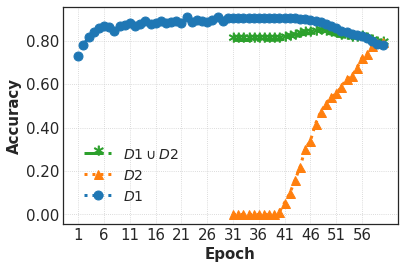

weighted f1 scores
y1 max:  0.9122477946466635
y2 d1 max:  0.9060887234912033
y2 d2 max:  0.9939024390243902
y2 d1&d2 max:  0.8350876801796469


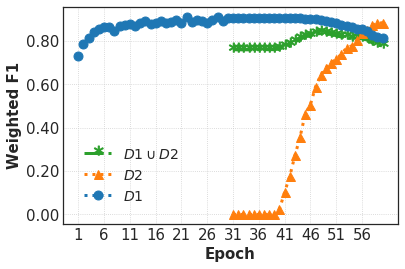

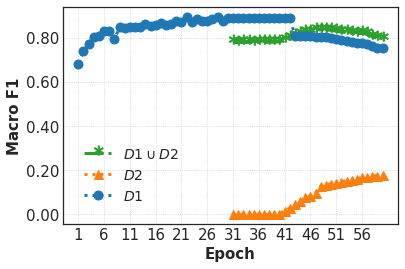

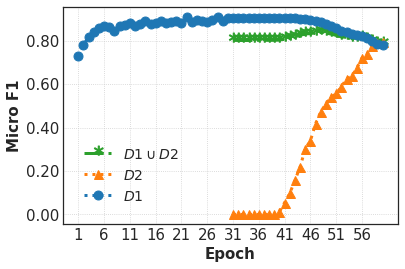

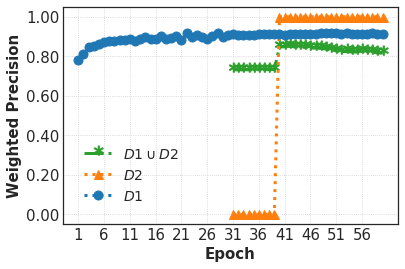

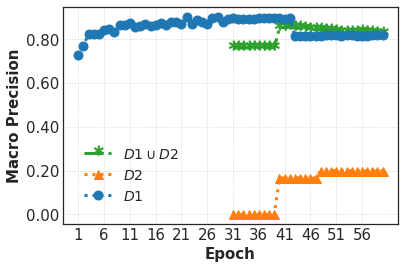

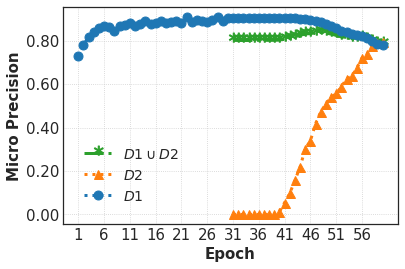

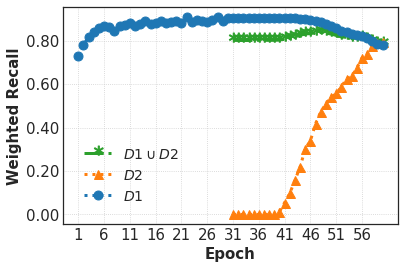

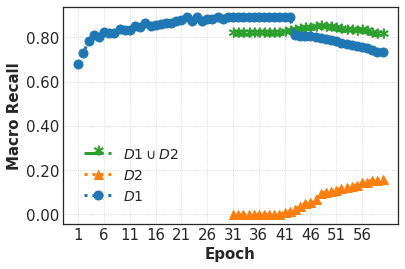

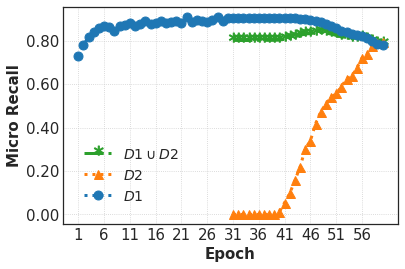

The shape of the train dataset is [[ 0.95774457 -0.80785272 -0.62090393 ... -0.82398156 -0.8817801
   0.59414878]
 [ 0.95774457 -0.80785272 -0.68247287 ... -0.82398156 -0.8817801
   0.63852889]
 [ 0.88395822 -0.80785272 -0.68247287 ... -0.73677349 -0.86303238
   0.59414878]
 ...
 [-0.73934137 -0.37654066 -0.77482628 ...  0.74576359 -0.41308717
   0.46100845]
 [-0.73934137 -0.37654066 -0.74404181 ...  0.74576359 -0.43183489
   0.46100845]
 [-0.70244819 -0.37654066 -0.77482628 ...  0.78936762 -0.43183489
   0.50538856]], and the labels is [[0.]
 [0.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]
The shape of the val dataset is [[-1.85943780e-01 -5.92196690e-01 -6.82472871e-01 ...  2.22515209e-01
  -6.00564342e-01  5.49768669e-01]
 [-1.47791758e-03 -2.46248469e-01 -7.44041811e-01 ... -8.27130148e-02
  -7.31798363e-01  4.16628339e-01]
 [ 2.93667462e-01 -6.79806954e-01 -7.44041811e-01 ... -5.18753334e-01
  -8.63032384e-01  4.61008449e-01]
 ...
 [-9.60700401e-01  1.47899980e+00 -6.20903930e-01 ...  5.277434

  0%|          | 0/11430 [00:00<?, ?it/s]

total data size of train_D1 is 12170
total data size of test_D1 is 1344
total data size of train_D2 is 947
total data size of test_D2 is 112
args fc_lay: 1 fc_units: 32 fc_nl: relu lr: 0.010000 batch: 32

 --> task:          sensor2-class
 --> model:         LSTM([33 X 60]_c11)
 --> hyper-params:  i11430-lr0.01-b32-adam
 --> EWC:           EWC10000000-N
sensor2-class--LSTM([33 X 60]_c11)--i11430-lr0.01-b32-adam--EWC10000000-N


Model-name: "LSTM([33 X 60]_c11)"
----------------------------------------MAIN MODEL----------------------------------------
Classifier(
  (flatten): Flatten()
  (lstm_input_dropout): Dropout(p=0.2)
  (lstm): LSTM(60, 32, batch_first=True)
  (lstm_fc): Linear(in_features=32, out_features=11, bias=True)
)
------------------------------------------------------------------------------------------
--> this network has 12395 parameters (~0.0 million)
      of which: - learnable: 12395 (~0.0 million)
                - fixed: 0 (~0.0 million)
--------------------------

  <SOLVER>   | Task: 1/2 | training loss: 0.67 | training precision: 0.781 |:   3%|▎         | 382/11430 [00:57<1:17:26,  2.38it/s]

Epoch 1 best model saved with weighted f1: 0.7240105197454332


  <SOLVER>   | Task: 1/2 | training loss: 0.384 | training precision: 0.875 |:   7%|▋         | 762/11430 [02:01<24:32,  7.24it/s]  

Epoch 2 best model saved with weighted f1: 0.7418247701867181


  <SOLVER>   | Task: 1/2 | training loss: 0.358 | training precision: 0.844 |:  10%|▉         | 1142/11430 [03:05<19:46,  8.67it/s] 

Epoch 3 best model saved with weighted f1: 0.8030279536352462


  <SOLVER>   | Task: 1/2 | training loss: 0.671 | training precision: 0.75 |:  13%|█▎        | 1525/11430 [04:03<1:07:33,  2.44it/s]

Epoch 4 best model saved with weighted f1: 0.8179723179615725


  <SOLVER>   | Task: 1/2 | training loss: 0.451 | training precision: 0.906 |:  17%|█▋        | 1905/11430 [05:03<36:28,  4.35it/s]  

Epoch 5 best model saved with weighted f1: 0.8259068047668744


  <SOLVER>   | Task: 1/2 | training loss: 0.328 | training precision: 0.906 |:  20%|█▉        | 2285/11430 [05:57<15:29,  9.84it/s]  

Epoch 6 best model saved with weighted f1: 0.829775978014995


  <SOLVER>   | Task: 1/2 | training loss: 0.278 | training precision: 0.906 |:  23%|██▎       | 2668/11430 [06:53<59:39,  2.45it/s]

Epoch 7 best model saved with weighted f1: 0.8375201930888746


  <SOLVER>   | Task: 1/2 | training loss: 0.623 | training precision: 0.812 |:  27%|██▋       | 3049/11430 [07:48<52:04,  2.68it/s]

Epoch 8 best model saved with weighted f1: 0.853224571137362


  <SOLVER>   | Task: 1/2 | training loss: 0.433 | training precision: 0.75 |:  40%|████      | 4573/11430 [11:50<58:56,  1.94it/s]   

Epoch 12 best model saved with weighted f1: 0.8624287221851963


  <SOLVER>   | Task: 1/2 | training loss: 0.572 | training precision: 0.812 |:  47%|████▋     | 5334/11430 [13:56<10:31,  9.65it/s]

Epoch 14 best model saved with weighted f1: 0.8642848152808524


  <SOLVER>   | Task: 1/2 | training loss: 0.276 | training precision: 0.875 |:  53%|█████▎    | 6097/11430 [16:00<39:58,  2.22it/s]

Epoch 16 best model saved with weighted f1: 0.8706095459266662


  <SOLVER>   | Task: 1/2 | training loss: 0.22 | training precision: 0.969 |:  93%|█████████▎| 10669/11430 [29:16<05:35,  2.27it/s]  

Epoch 28 best model saved with weighted f1: 0.8738470462137427


  <SOLVER>   | Task: 1/2 | training loss: 0.354 | training precision: 0.875 |: 100%|██████████| 11430/11430 [31:27<00:00,  6.05it/s] 
  <SOLVER>   | Task: 1/2 | training loss: 2.26 | training precision: 0.188 |:   0%|          | 1/11430 [00:00<23:55,  7.96it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7395833333333334, 0.7395833333333334, 0.7916666666666666, 0.8229166666666666, 0.8229166666666666, 0.8236607142857143, 0.8392857142857143, 0.8549107142857143, 0.8482142857142857, 0.8482142857142857, 0.8370535714285714, 0.8630952380952381, 0.8459821428571429, 0.8623511904761905, 0.8519345238095238, 0.8690476190476191, 0.8415178571428571, 0.8489583333333334, 0.8497023809523809, 0.8563988095238095, 0.8668154761904762, 0.8534226190476191, 0.8467261904761905, 0.8511904761904762, 0.8556547619047619, 0.8638392857142857, 0.8497023809523809, 0.8720238095238095, 0.8385416666666666, 0.8526785714285714], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7395833333333334, 0.7395833333333334, 0.7916666666666666, 0.8229166666666666, 0.8229166666666666, 0.8236607142857143, 0.8392857142857143, 0.8549107142857143, 0.8482142857142857, 0.8482142857142857, 0.8370535714285714, 0.8630952380952381, 0.8459821428571429, 0.86235119047619

  <SOLVER>   | Task: 1/2 | training loss: 0.881 | training precision: 0.719 |:   3%|▎         | 380/11430 [00:55<26:22,  6.98it/s]

Epoch 1 best model saved with weighted f1: 0.7216987023667638


  <SOLVER>   | Task: 1/2 | training loss: 0.489 | training precision: 0.875 |:   7%|▋         | 762/11430 [01:46<17:10, 10.35it/s]

Epoch 2 best model saved with weighted f1: 0.7533599294363191


  <SOLVER>   | Task: 1/2 | training loss: 0.554 | training precision: 0.844 |:  10%|█         | 1144/11430 [02:41<1:17:46,  2.20it/s]

Epoch 3 best model saved with weighted f1: 0.8105922544016053


  <SOLVER>   | Task: 1/2 | training loss: 0.528 | training precision: 0.688 |:  13%|█▎        | 1525/11430 [03:39<1:05:56,  2.50it/s]

Epoch 4 best model saved with weighted f1: 0.849098189551638


  <SOLVER>   | Task: 1/2 | training loss: 0.318 | training precision: 0.938 |:  20%|██        | 2286/11430 [05:27<22:40,  6.72it/s]  

Epoch 6 best model saved with weighted f1: 0.8568743863070034


  <SOLVER>   | Task: 1/2 | training loss: 0.212 | training precision: 0.969 |:  23%|██▎       | 2668/11430 [06:14<57:00,  2.56it/s]  

Epoch 7 best model saved with weighted f1: 0.8685692605350084


  <SOLVER>   | Task: 1/2 | training loss: 0.365 | training precision: 0.844 |:  30%|███       | 3430/11430 [07:57<45:21,  2.94it/s]  

Epoch 9 best model saved with weighted f1: 0.8721042244255234


  <SOLVER>   | Task: 1/2 | training loss: 0.402 | training precision: 0.875 |:  33%|███▎      | 3809/11430 [08:58<15:05,  8.42it/s]

Epoch 10 best model saved with weighted f1: 0.8753998762418275


  <SOLVER>   | Task: 1/2 | training loss: 0.158 | training precision: 0.938 |:  37%|███▋      | 4192/11430 [09:53<25:04,  4.81it/s]

Epoch 11 best model saved with weighted f1: 0.8768727309575128


  <SOLVER>   | Task: 1/2 | training loss: 0.277 | training precision: 0.875 |:  53%|█████▎    | 6097/11430 [14:34<34:07,  2.60it/s]

Epoch 16 best model saved with weighted f1: 0.8810747340654637


  <SOLVER>   | Task: 1/2 | training loss: 0.194 | training precision: 0.938 |:  60%|██████    | 6859/11430 [16:27<18:30,  4.12it/s]

Epoch 18 best model saved with weighted f1: 0.8874807483314532


  <SOLVER>   | Task: 1/2 | training loss: 0.382 | training precision: 0.844 |:  83%|████████▎ | 9525/11430 [23:30<03:37,  8.76it/s] 

Epoch 25 best model saved with weighted f1: 0.8877407918697389


  <SOLVER>   | Task: 1/2 | training loss: 0.156 | training precision: 0.969 |:  93%|█████████▎| 10669/11430 [26:17<05:34,  2.27it/s]

Epoch 28 best model saved with weighted f1: 0.8880498117368057


  <SOLVER>   | Task: 1/2 | training loss: 0.161 | training precision: 0.969 |: 100%|██████████| 11430/11430 [28:06<00:00,  6.78it/s] 
  0%|          | 0/11430 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.7328869047619048, 0.7492559523809523, 0.8043154761904762, 0.8444940476190477, 0.8214285714285714, 0.8541666666666666, 0.8660714285714286, 0.8653273809523809, 0.8690476190476191, 0.8735119047619048, 0.875, 0.8705357142857143, 0.8727678571428571, 0.8668154761904762, 0.8645833333333334, 0.8794642857142857, 0.8794642857142857, 0.8854166666666666, 0.8831845238095238, 0.8757440476190477, 0.8824404761904762, 0.8772321428571429, 0.8772321428571429, 0.8809523809523809, 0.8854166666666666, 0.8809523809523809, 0.8816964285714286, 0.8869047619047619, 0.8846726190476191, 0.8839285714285714], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7328869047619048, 0.7492559523809523, 0.8043154761904762, 0.8444940476190477, 0.8214285714285714, 0.8541666666666666, 0.8660714285714286, 0.8653273809523809, 0.8690476190476191, 0.8735119047619048, 0.875, 0.8705357142857143, 0.8727678571428571, 0.8668154761904762, 0.8645833333333334, 0.

  <SOLVER>   | Task: 1/2 | training loss: 0.597 | training precision: 0.719 |:   3%|▎         | 382/11430 [01:16<56:35,  3.25it/s]  

Epoch 1 best model saved with weighted f1: 0.7167883876418144


  <SOLVER>   | Task: 1/2 | training loss: 0.562 | training precision: 0.75 |:   7%|▋         | 762/11430 [02:25<27:11,  6.54it/s]   

Epoch 2 best model saved with weighted f1: 0.8326822212089573


  <SOLVER>   | Task: 1/2 | training loss: 0.388 | training precision: 0.906 |:  13%|█▎        | 1524/11430 [04:40<24:15,  6.81it/s]  

Epoch 4 best model saved with weighted f1: 0.8370801859866378


  <SOLVER>   | Task: 1/2 | training loss: 0.632 | training precision: 0.812 |:  27%|██▋       | 3048/11430 [09:13<37:27,  3.73it/s]  

Epoch 8 best model saved with weighted f1: 0.8480946735712683


  <SOLVER>   | Task: 1/2 | training loss: 0.244 | training precision: 0.906 |:  30%|███       | 3429/11430 [10:21<20:54,  6.38it/s]  

Epoch 9 best model saved with weighted f1: 0.8730085114322657


  <SOLVER>   | Task: 1/2 | training loss: 0.352 | training precision: 0.875 |:  57%|█████▋    | 6476/11430 [19:34<08:24,  9.83it/s]  

Epoch 17 best model saved with weighted f1: 0.8811907509958627


  <SOLVER>   | Task: 1/2 | training loss: 0.198 | training precision: 0.938 |:  80%|████████  | 9145/11430 [27:58<24:20,  1.56it/s] 

Epoch 24 best model saved with weighted f1: 0.8875593702921171


  <SOLVER>   | Task: 1/2 | training loss: 0.323 | training precision: 0.875 |: 100%|██████████| 11430/11430 [35:31<00:00,  5.36it/s] 
  0%|          | 0/11430 [00:00<?, ?it/s]

Epoch 30 best model saved with weighted f1: 0.8891809682414294
precision_dict:  {'per_task_weighted_rec': [[0.7276785714285714, 0.8311011904761905, 0.8266369047619048, 0.8325892857142857, 0.8132440476190477, 0.8244047619047619, 0.8273809523809523, 0.8444940476190477, 0.8697916666666666, 0.7961309523809523, 0.8571428571428571, 0.8601190476190477, 0.8630952380952381, 0.8623511904761905, 0.8616071428571429, 0.8541666666666666, 0.8787202380952381, 0.875, 0.8608630952380952, 0.8683035714285714, 0.84375, 0.8735119047619048, 0.8757440476190477, 0.8861607142857143, 0.8571428571428571, 0.8735119047619048, 0.8608630952380952, 0.8675595238095238, 0.8779761904761905, 0.8876488095238095], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7276785714285714, 0.8311011904761905, 0.8266369047619048, 0.8325892857142857, 0.8132440476190477, 0.8244047619047619, 0.8273809523809523, 0.8444940476190477, 0.8697916666666666, 0.7961309523809523, 0.8571428571428571, 0.860119047619047

  <SOLVER>   | Task: 1/2 | training loss: 0.935 | training precision: 0.625 |:   3%|▎         | 381/11430 [01:06<29:31,  6.24it/s]  

Epoch 1 best model saved with weighted f1: 0.7131822767976195


  <SOLVER>   | Task: 1/2 | training loss: 0.567 | training precision: 0.75 |:   7%|▋         | 762/11430 [02:14<18:16,  9.73it/s]   

Epoch 2 best model saved with weighted f1: 0.7721002385402598


  <SOLVER>   | Task: 1/2 | training loss: 0.333 | training precision: 0.812 |:  10%|█         | 1143/11430 [03:18<31:14,  5.49it/s]

Epoch 3 best model saved with weighted f1: 0.8082193341508811


  <SOLVER>   | Task: 1/2 | training loss: 0.482 | training precision: 0.844 |:  13%|█▎        | 1525/11430 [04:31<1:43:47,  1.59it/s]

Epoch 4 best model saved with weighted f1: 0.8656355420727722


  <SOLVER>   | Task: 1/2 | training loss: 0.379 | training precision: 0.812 |:  20%|██        | 2287/11430 [06:56<1:38:00,  1.55it/s]

Epoch 6 best model saved with weighted f1: 0.8706721626574423


  <SOLVER>   | Task: 1/2 | training loss: 0.423 | training precision: 0.906 |:  23%|██▎       | 2667/11430 [08:01<31:04,  4.70it/s]  

Epoch 7 best model saved with weighted f1: 0.8803896325880122


  <SOLVER>   | Task: 1/2 | training loss: 0.351 | training precision: 0.875 |:  27%|██▋       | 3049/11430 [09:17<1:25:20,  1.64it/s]

Epoch 8 best model saved with weighted f1: 0.8896688347418408


  <SOLVER>   | Task: 1/2 | training loss: 0.318 | training precision: 0.906 |:  60%|██████    | 6859/11430 [21:04<42:41,  1.78it/s]  

Epoch 18 best model saved with weighted f1: 0.8963690943935376


  <SOLVER>   | Task: 1/2 | training loss: 0.208 | training precision: 0.906 |:  67%|██████▋   | 7620/11430 [23:36<16:41,  3.81it/s] 

Epoch 20 best model saved with weighted f1: 0.8998615769892214


  <SOLVER>   | Task: 1/2 | training loss: 0.23 | training precision: 0.906 |:  77%|███████▋  | 8764/11430 [27:20<25:42,  1.73it/s]  

Epoch 23 best model saved with weighted f1: 0.9039872761364718


  <SOLVER>   | Task: 1/2 | training loss: 0.217 | training precision: 0.906 |:  97%|█████████▋| 11050/11430 [34:46<03:50,  1.65it/s] 

Epoch 29 best model saved with weighted f1: 0.9041801026240929


  <SOLVER>   | Task: 1/2 | training loss: 0.292 | training precision: 0.906 |: 100%|██████████| 11430/11430 [36:11<00:00,  5.26it/s] 
  0%|          | 0/11430 [00:00<?, ?it/s]

Epoch 30 best model saved with weighted f1: 0.9102749309610316
precision_dict:  {'per_task_weighted_rec': [[0.7194940476190477, 0.7775297619047619, 0.7991071428571429, 0.8623511904761905, 0.8400297619047619, 0.8690476190476191, 0.8794642857142857, 0.8883928571428571, 0.8824404761904762, 0.8735119047619048, 0.8720238095238095, 0.8809523809523809, 0.8861607142857143, 0.8831845238095238, 0.8816964285714286, 0.8869047619047619, 0.8861607142857143, 0.8943452380952381, 0.8883928571428571, 0.8965773809523809, 0.8950892857142857, 0.8936011904761905, 0.9017857142857143, 0.8995535714285714, 0.8995535714285714, 0.8861607142857143, 0.8727678571428571, 0.8950892857142857, 0.9017857142857143, 0.9084821428571429], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.7194940476190477, 0.7775297619047619, 0.7991071428571429, 0.8623511904761905, 0.8400297619047619, 0.8690476190476191, 0.8794642857142857, 0.8883928571428571, 0.8824404761904762, 0.8735119047619048, 0.87202380952

  <SOLVER>   | Task: 1/2 | training loss: 0.918 | training precision: 0.625 |:   3%|▎         | 381/11430 [02:22<1:09:54,  2.63it/s]

Epoch 1 best model saved with weighted f1: 0.6709880035026303


  <SOLVER>   | Task: 1/2 | training loss: 0.823 | training precision: 0.781 |:   7%|▋         | 762/11430 [04:49<58:44,  3.03it/s]  

Epoch 2 best model saved with weighted f1: 0.6972454457615517


  <SOLVER>   | Task: 1/2 | training loss: 0.636 | training precision: 0.812 |:  10%|█         | 1143/11430 [07:17<1:15:30,  2.27it/s]

Epoch 3 best model saved with weighted f1: 0.7410210018159533


  <SOLVER>   | Task: 1/2 | training loss: 0.521 | training precision: 0.812 |:  13%|█▎        | 1524/11430 [09:38<53:30,  3.09it/s]  

Epoch 4 best model saved with weighted f1: 0.813550291979775


  <SOLVER>   | Task: 1/2 | training loss: 0.518 | training precision: 0.812 |:  17%|█▋        | 1905/11430 [11:59<53:59,  2.94it/s]  

Epoch 5 best model saved with weighted f1: 0.8270931997185148


  <SOLVER>   | Task: 1/2 | training loss: 0.439 | training precision: 0.812 |:  23%|██▎       | 2667/11430 [16:49<52:00,  2.81it/s]  

Epoch 7 best model saved with weighted f1: 0.8335385964736911


  <SOLVER>   | Task: 1/2 | training loss: 0.386 | training precision: 0.906 |:  27%|██▋       | 3048/11430 [19:08<48:28,  2.88it/s]  

Epoch 8 best model saved with weighted f1: 0.8542930194290208


  <SOLVER>   | Task: 1/2 | training loss: 0.242 | training precision: 0.844 |:  47%|████▋     | 5334/11430 [33:50<32:40,  3.11it/s]  

Epoch 14 best model saved with weighted f1: 0.8568080502870626


  <SOLVER>   | Task: 1/2 | training loss: 0.25 | training precision: 0.906 |:  53%|█████▎    | 6096/11430 [38:58<42:44,  2.08it/s]   

Epoch 16 best model saved with weighted f1: 0.8673720304448092


  <SOLVER>   | Task: 1/2 | training loss: 0.38 | training precision: 0.812 |:  90%|█████████ | 10287/11430 [1:08:37<08:56,  2.13it/s]  

Epoch 27 best model saved with weighted f1: 0.8795375108095956


  <SOLVER>   | Task: 1/2 | training loss: 0.294 | training precision: 0.844 |: 100%|██████████| 11430/11430 [1:16:36<00:00,  2.49it/s] 
  0%|          | 0/11430 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6622023809523809, 0.6956845238095238, 0.7470238095238095, 0.8117559523809523, 0.8199404761904762, 0.7738095238095238, 0.8311011904761905, 0.8504464285714286, 0.8489583333333334, 0.8407738095238095, 0.8497023809523809, 0.8377976190476191, 0.8497023809523809, 0.8549107142857143, 0.8444940476190477, 0.8638392857142857, 0.8474702380952381, 0.8236607142857143, 0.8385416666666666, 0.8616071428571429, 0.7946428571428571, 0.8139880952380952, 0.8616071428571429, 0.8630952380952381, 0.8355654761904762, 0.8608630952380952, 0.8772321428571429, 0.8735119047619048, 0.8296130952380952, 0.8586309523809523], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6622023809523809, 0.6956845238095238, 0.7470238095238095, 0.8117559523809523, 0.8199404761904762, 0.7738095238095238, 0.8311011904761905, 0.8504464285714286, 0.8489583333333334, 0.8407738095238095, 0.8497023809523809, 0.8377976190476191, 0.8497023809523809, 0.85491071428571

  <SOLVER>   | Task: 1/2 | training loss: 0.855 | training precision: 0.656 |:   3%|▎         | 381/11430 [02:15<53:30,  3.44it/s]  

Epoch 1 best model saved with weighted f1: 0.6864742547851024


  <SOLVER>   | Task: 1/2 | training loss: 0.74 | training precision: 0.75 |:   7%|▋         | 762/11430 [04:34<1:03:17,  2.81it/s]  

Epoch 2 best model saved with weighted f1: 0.7149406064134879


  <SOLVER>   | Task: 1/2 | training loss: 0.46 | training precision: 0.844 |:  10%|█         | 1143/11430 [06:48<1:07:27,  2.54it/s] 

Epoch 3 best model saved with weighted f1: 0.7546234844967122


  <SOLVER>   | Task: 1/2 | training loss: 0.422 | training precision: 0.75 |:  13%|█▎        | 1525/11430 [09:01<1:34:56,  1.74it/s] 

Epoch 4 best model saved with weighted f1: 0.7809952959233686


  <SOLVER>   | Task: 1/2 | training loss: 0.497 | training precision: 0.781 |:  17%|█▋        | 1905/11430 [11:10<1:00:15,  2.63it/s]

Epoch 5 best model saved with weighted f1: 0.7949885212292233


  <SOLVER>   | Task: 1/2 | training loss: 0.303 | training precision: 0.875 |:  20%|██        | 2286/11430 [13:20<38:55,  3.91it/s]  

Epoch 6 best model saved with weighted f1: 0.8129834971216807


  <SOLVER>   | Task: 1/2 | training loss: 0.302 | training precision: 0.875 |:  27%|██▋       | 3048/11430 [17:49<55:19,  2.52it/s]  

Epoch 8 best model saved with weighted f1: 0.859216902729883


  <SOLVER>   | Task: 1/2 | training loss: 0.208 | training precision: 0.938 |:  33%|███▎      | 3810/11430 [22:01<27:58,  4.54it/s]  

Epoch 10 best model saved with weighted f1: 0.8698944158835363


  <SOLVER>   | Task: 1/2 | training loss: 0.253 | training precision: 0.906 |:  37%|███▋      | 4191/11430 [24:13<36:43,  3.29it/s]  

Epoch 11 best model saved with weighted f1: 0.874611818263178


  <SOLVER>   | Task: 1/2 | training loss: 0.165 | training precision: 0.969 |:  47%|████▋     | 5334/11430 [31:04<39:06,  2.60it/s]  

Epoch 14 best model saved with weighted f1: 0.8781875396632958


  <SOLVER>   | Task: 1/2 | training loss: 0.302 | training precision: 0.875 |:  57%|█████▋    | 6477/11430 [38:10<40:43,  2.03it/s]  

Epoch 17 best model saved with weighted f1: 0.886322515541415


  <SOLVER>   | Task: 1/2 | training loss: 0.318 | training precision: 0.875 |:  63%|██████▎   | 7239/11430 [43:23<29:04,  2.40it/s]  

Epoch 19 best model saved with weighted f1: 0.8866542328878838


  <SOLVER>   | Task: 1/2 | training loss: 0.307 | training precision: 0.906 |:  70%|███████   | 8001/11430 [48:37<19:19,  2.96it/s]  

Epoch 21 best model saved with weighted f1: 0.8900766612290938


  <SOLVER>   | Task: 1/2 | training loss: 0.185 | training precision: 0.969 |:  80%|████████  | 9144/11430 [56:18<16:48,  2.27it/s]  

Epoch 24 best model saved with weighted f1: 0.8949642900943842


  <SOLVER>   | Task: 1/2 | training loss: 0.251 | training precision: 0.906 |:  87%|████████▋ | 9906/11430 [1:01:35<11:28,  2.21it/s] 

Epoch 26 best model saved with weighted f1: 0.8995459243807072


  <SOLVER>   | Task: 1/2 | training loss: 0.242 | training precision: 0.906 |: 100%|██████████| 11430/11430 [1:12:20<00:00,  2.63it/s] 
  0%|          | 0/11430 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6860119047619048, 0.7165178571428571, 0.7552083333333334, 0.7879464285714286, 0.7953869047619048, 0.8043154761904762, 0.7938988095238095, 0.8578869047619048, 0.8504464285714286, 0.8675595238095238, 0.8735119047619048, 0.8683035714285714, 0.8526785714285714, 0.8779761904761905, 0.8712797619047619, 0.8668154761904762, 0.8846726190476191, 0.8742559523809523, 0.8839285714285714, 0.8727678571428571, 0.8876488095238095, 0.8772321428571429, 0.8846726190476191, 0.8928571428571429, 0.8712797619047619, 0.8973214285714286, 0.8936011904761905, 0.8869047619047619, 0.8839285714285714, 0.8831845238095238], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6860119047619048, 0.7165178571428571, 0.7552083333333334, 0.7879464285714286, 0.7953869047619048, 0.8043154761904762, 0.7938988095238095, 0.8578869047619048, 0.8504464285714286, 0.8675595238095238, 0.8735119047619048, 0.8683035714285714, 0.8526785714285714, 0.87797619047619

  <SOLVER>   | Task: 1/2 | training loss: 1.04 | training precision: 0.5 |:   3%|▎         | 381/11430 [03:25<1:31:31,  2.01it/s]   

Epoch 1 best model saved with weighted f1: 0.6567400746070386


  <SOLVER>   | Task: 1/2 | training loss: 0.523 | training precision: 0.875 |:   7%|▋         | 762/11430 [07:04<1:16:01,  2.34it/s]

Epoch 2 best model saved with weighted f1: 0.7680534869948801


  <SOLVER>   | Task: 1/2 | training loss: 0.486 | training precision: 0.812 |:  10%|█         | 1143/11430 [10:36<57:56,  2.96it/s]  

Epoch 3 best model saved with weighted f1: 0.7930002422729215


  <SOLVER>   | Task: 1/2 | training loss: 0.75 | training precision: 0.719 |:  13%|█▎        | 1524/11430 [14:00<1:34:25,  1.75it/s] 

Epoch 4 best model saved with weighted f1: 0.8142767629421813


  <SOLVER>   | Task: 1/2 | training loss: 0.28 | training precision: 0.938 |:  17%|█▋        | 1905/11430 [17:17<1:47:32,  1.48it/s] 

Epoch 5 best model saved with weighted f1: 0.8384810223239699


  <SOLVER>   | Task: 1/2 | training loss: 0.416 | training precision: 0.906 |:  20%|██        | 2286/11430 [20:35<1:51:49,  1.36it/s]

Epoch 6 best model saved with weighted f1: 0.8468504526860143


  <SOLVER>   | Task: 1/2 | training loss: 0.521 | training precision: 0.844 |:  33%|███▎      | 3810/11430 [34:27<1:05:19,  1.94it/s]

Epoch 10 best model saved with weighted f1: 0.8594768783726524


  <SOLVER>   | Task: 1/2 | training loss: 0.185 | training precision: 0.938 |:  37%|███▋      | 4191/11430 [37:50<1:05:36,  1.84it/s]

Epoch 11 best model saved with weighted f1: 0.8775786641957933


  <SOLVER>   | Task: 1/2 | training loss: 0.211 | training precision: 0.875 |: 100%|██████████| 11430/11430 [1:45:54<00:00,  1.80it/s] 
  0%|          | 0/11430 [00:00<?, ?it/s]

precision_dict:  {'per_task_weighted_rec': [[0.6324404761904762, 0.7477678571428571, 0.7901785714285714, 0.8191964285714286, 0.8400297619047619, 0.8482142857142857, 0.8355654761904762, 0.8184523809523809, 0.8377976190476191, 0.8571428571428571, 0.8742559523809523, 0.8660714285714286, 0.8444940476190477, 0.8601190476190477, 0.8125, 0.8630952380952381, 0.8608630952380952, 0.8675595238095238, 0.8616071428571429, 0.8697916666666666, 0.8645833333333334, 0.8430059523809523, 0.8623511904761905, 0.8556547619047619, 0.8229166666666666, 0.8697916666666666, 0.8645833333333334, 0.8340773809523809, 0.8630952380952381, 0.8541666666666666], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6324404761904762, 0.7477678571428571, 0.7901785714285714, 0.8191964285714286, 0.8400297619047619, 0.8482142857142857, 0.8355654761904762, 0.8184523809523809, 0.8377976190476191, 0.8571428571428571, 0.8742559523809523, 0.8660714285714286, 0.8444940476190477, 0.8601190476190477, 0.8125, 

  <SOLVER>   | Task: 1/2 | training loss: 0.589 | training precision: 0.812 |:   3%|▎         | 381/11430 [03:11<1:38:38,  1.87it/s]

Epoch 1 best model saved with weighted f1: 0.6984964055594755


  <SOLVER>   | Task: 1/2 | training loss: 0.543 | training precision: 0.875 |:   7%|▋         | 762/11430 [06:31<1:16:24,  2.33it/s]

Epoch 2 best model saved with weighted f1: 0.7276669491723086


  <SOLVER>   | Task: 1/2 | training loss: 0.472 | training precision: 0.781 |:  10%|█         | 1143/11430 [09:53<1:47:33,  1.59it/s]

Epoch 3 best model saved with weighted f1: 0.7942818512041302


  <SOLVER>   | Task: 1/2 | training loss: 0.319 | training precision: 0.844 |:  17%|█▋        | 1905/11430 [16:33<59:57,  2.65it/s]  

Epoch 5 best model saved with weighted f1: 0.8560784643535374


  <SOLVER>   | Task: 1/2 | training loss: 0.329 | training precision: 0.844 |:  20%|██        | 2286/11430 [19:51<1:11:02,  2.15it/s]

Epoch 6 best model saved with weighted f1: 0.8640481455351369


  <SOLVER>   | Task: 1/2 | training loss: 0.341 | training precision: 0.844 |:  30%|███       | 3429/11430 [29:42<59:15,  2.25it/s]   

Epoch 9 best model saved with weighted f1: 0.8742543725350194


  <SOLVER>   | Task: 1/2 | training loss: 0.182 | training precision: 0.906 |:  37%|███▋      | 4191/11430 [36:18<1:05:30,  1.84it/s]

Epoch 11 best model saved with weighted f1: 0.8782163479150542


  <SOLVER>   | Task: 1/2 | training loss: 0.464 | training precision: 0.75 |:  43%|████▎     | 4953/11430 [42:52<45:05,  2.39it/s]    

Epoch 13 best model saved with weighted f1: 0.8835956420163162


  <SOLVER>   | Task: 1/2 | training loss: 0.125 | training precision: 1.0 |:  47%|████▋     | 5334/11430 [46:17<46:20,  2.19it/s]     

Epoch 14 best model saved with weighted f1: 0.8854772569258079


  <SOLVER>   | Task: 1/2 | training loss: 0.196 | training precision: 0.906 |:  53%|█████▎    | 6096/11430 [52:37<40:35,  2.19it/s]   

Epoch 16 best model saved with weighted f1: 0.8914949496960654


  <SOLVER>   | Task: 1/2 | training loss: 0.184 | training precision: 0.906 |:  63%|██████▎   | 7239/11430 [1:02:41<44:25,  1.57it/s] 

Epoch 19 best model saved with weighted f1: 0.8938814667372279


  <SOLVER>   | Task: 1/2 | training loss: 0.328 | training precision: 0.844 |:  80%|████████  | 9144/11430 [1:19:03<30:46,  1.24it/s]  

Epoch 24 best model saved with weighted f1: 0.8964505351297378


  <SOLVER>   | Task: 1/2 | training loss: 0.215 | training precision: 0.906 |:  87%|████████▋ | 9906/11430 [1:25:36<10:25,  2.44it/s]  

Epoch 26 best model saved with weighted f1: 0.8976793577253093


  <SOLVER>   | Task: 1/2 | training loss: 0.138 | training precision: 0.969 |:  90%|█████████ | 10287/11430 [1:28:55<11:13,  1.70it/s] 

Epoch 27 best model saved with weighted f1: 0.9006572394202271


  <SOLVER>   | Task: 1/2 | training loss: 0.102 | training precision: 0.969 |: 100%|██████████| 11430/11430 [1:38:50<00:00,  1.93it/s] 


precision_dict:  {'per_task_weighted_rec': [[0.6949404761904762, 0.7388392857142857, 0.7916666666666666, 0.7931547619047619, 0.8541666666666666, 0.8653273809523809, 0.8511904761904762, 0.8444940476190477, 0.8727678571428571, 0.8675595238095238, 0.8690476190476191, 0.8660714285714286, 0.8809523809523809, 0.8846726190476191, 0.8816964285714286, 0.8898809523809523, 0.8675595238095238, 0.8876488095238095, 0.8898809523809523, 0.8876488095238095, 0.8898809523809523, 0.8883928571428571, 0.8869047619047619, 0.8950892857142857, 0.8898809523809523, 0.8958333333333334, 0.8980654761904762, 0.8854166666666666, 0.8891369047619048, 0.8921130952380952], []], 'all_tasks_acc': [], 'all_tasks_macro_prec': [], 'per_task_micro_rec': [[0.6949404761904762, 0.7388392857142857, 0.7916666666666666, 0.7931547619047619, 0.8541666666666666, 0.8653273809523809, 0.8511904761904762, 0.8444940476190477, 0.8727678571428571, 0.8675595238095238, 0.8690476190476191, 0.8660714285714286, 0.8809523809523809, 0.88467261904761

  <SOLVER>   | Task: 2/2 | training loss: 2.46 | training precision: 0.0625 |:   3%|▎         | 30/900 [00:09<04:13,  3.43it/s]

Epoch 2 best model saved with weighted f1: 0.4335664335664336


  <SOLVER>   | Task: 2/2 | training loss: 1.97 | training precision: 0.594 |:   5%|▌         | 45/900 [00:18<04:24,  3.23it/s] 

Epoch 3 best model saved with weighted f1: 0.8085106382978724


  <SOLVER>   | Task: 2/2 | training loss: 1.53 | training precision: 0.719 |:   7%|▋         | 60/900 [00:25<02:53,  4.85it/s]

Epoch 4 best model saved with weighted f1: 0.8629441624365483


  <SOLVER>   | Task: 2/2 | training loss: 1.19 | training precision: 0.781 |:   8%|▊         | 75/900 [00:34<04:53,  2.81it/s]

Epoch 5 best model saved with weighted f1: 0.8965517241379312


  <SOLVER>   | Task: 2/2 | training loss: 0.941 | training precision: 0.875 |:  10%|█         | 91/900 [00:43<09:00,  1.50it/s]

Epoch 6 best model saved with weighted f1: 0.9178743961352657


  <SOLVER>   | Task: 2/2 | training loss: 1.04 | training precision: 0.906 |:  12%|█▏        | 105/900 [00:45<02:34,  5.14it/s] 

Epoch 7 best model saved with weighted f1: 0.948356807511737


  <SOLVER>   | Task: 2/2 | training loss: 0.601 | training precision: 0.969 |:  15%|█▌        | 135/900 [00:57<02:27,  5.20it/s]

Epoch 9 best model saved with weighted f1: 0.9532710280373832


  <SOLVER>   | Task: 2/2 | training loss: 0.704 | training precision: 0.906 |:  17%|█▋        | 151/900 [01:07<16:31,  1.32s/it]

Epoch 10 best model saved with weighted f1: 0.9909909909909909


  <SOLVER>   | Task: 2/2 | training loss: 0.466 | training precision: 1.0 |:  20%|██        | 181/900 [01:21<16:03,  1.34s/it]  

Epoch 12 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.203 | training precision: 1.0 |:  53%|█████▎    | 481/900 [03:41<10:24,  1.49s/it]  

Early stopping on epoch 32


  <SOLVER>   | Task: 2/2 | training loss: 0.216 | training precision: 0.969 |:  55%|█████▌    | 495/900 [03:44<01:39,  4.06it/s]

Early stopping on epoch 33


  <SOLVER>   | Task: 2/2 | training loss: 0.179 | training precision: 1.0 |:  57%|█████▋    | 510/900 [03:51<01:37,  4.01it/s]  

Early stopping on epoch 34


  <SOLVER>   | Task: 2/2 | training loss: 0.162 | training precision: 1.0 |:  58%|█████▊    | 525/900 [04:01<02:00,  3.11it/s] 

Early stopping on epoch 35


  <SOLVER>   | Task: 2/2 | training loss: 0.15 | training precision: 1.0 |:  60%|██████    | 541/900 [04:11<06:09,  1.03s/it] 

Early stopping on epoch 36


  <SOLVER>   | Task: 2/2 | training loss: 0.161 | training precision: 1.0 |:  62%|██████▏   | 555/900 [04:15<01:14,  4.64it/s]  

Early stopping on epoch 37


  <SOLVER>   | Task: 2/2 | training loss: 0.245 | training precision: 0.969 |:  63%|██████▎   | 570/900 [04:20<00:57,  5.78it/s]

Early stopping on epoch 38


  <SOLVER>   | Task: 2/2 | training loss: 0.183 | training precision: 0.969 |:  65%|██████▌   | 585/900 [04:27<01:41,  3.11it/s]

Early stopping on epoch 39


  <SOLVER>   | Task: 2/2 | training loss: 0.158 | training precision: 1.0 |:  67%|██████▋   | 600/900 [04:37<00:52,  5.68it/s]  

Early stopping on epoch 40


  <SOLVER>   | Task: 2/2 | training loss: 0.147 | training precision: 1.0 |:  68%|██████▊   | 615/900 [04:41<01:17,  3.70it/s]  

Early stopping on epoch 41


  <SOLVER>   | Task: 2/2 | training loss: 0.15 | training precision: 1.0 |:  70%|███████   | 631/900 [04:51<02:11,  2.05it/s] 

Early stopping on epoch 42


  <SOLVER>   | Task: 2/2 | training loss: 0.129 | training precision: 1.0 |:  72%|███████▏  | 645/900 [04:52<00:26,  9.70it/s]  

Early stopping on epoch 43


  <SOLVER>   | Task: 2/2 | training loss: 0.173 | training precision: 0.969 |:  73%|███████▎  | 660/900 [04:58<00:50,  4.73it/s]

Early stopping on epoch 44


  <SOLVER>   | Task: 2/2 | training loss: 0.139 | training precision: 1.0 |:  75%|███████▌  | 675/900 [05:04<00:54,  4.13it/s]  

Early stopping on epoch 45


  <SOLVER>   | Task: 2/2 | training loss: 0.124 | training precision: 1.0 |:  77%|███████▋  | 690/900 [05:12<00:50,  4.14it/s]

Early stopping on epoch 46


  <SOLVER>   | Task: 2/2 | training loss: 0.137 | training precision: 1.0 |:  78%|███████▊  | 705/900 [05:20<00:38,  5.02it/s]  

Early stopping on epoch 47


  <SOLVER>   | Task: 2/2 | training loss: 0.146 | training precision: 1.0 |:  80%|████████  | 720/900 [05:27<00:33,  5.44it/s]

Early stopping on epoch 48


  <SOLVER>   | Task: 2/2 | training loss: 0.129 | training precision: 1.0 |:  82%|████████▏ | 735/900 [05:34<00:47,  3.44it/s]  

Early stopping on epoch 49


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  83%|████████▎ | 750/900 [05:41<00:39,  3.75it/s]  

Early stopping on epoch 50


  <SOLVER>   | Task: 2/2 | training loss: 0.113 | training precision: 1.0 |:  85%|████████▌ | 766/900 [05:49<01:13,  1.82it/s]

Early stopping on epoch 51


  <SOLVER>   | Task: 2/2 | training loss: 0.119 | training precision: 1.0 |:  87%|████████▋ | 780/900 [05:52<00:32,  3.69it/s]  

Early stopping on epoch 52


  <SOLVER>   | Task: 2/2 | training loss: 0.13 | training precision: 1.0 |:  88%|████████▊ | 795/900 [06:00<00:21,  4.93it/s]   

Early stopping on epoch 53


  <SOLVER>   | Task: 2/2 | training loss: 0.108 | training precision: 1.0 |:  90%|█████████ | 810/900 [06:05<00:23,  3.87it/s]  

Early stopping on epoch 54


  <SOLVER>   | Task: 2/2 | training loss: 0.0983 | training precision: 1.0 |:  92%|█████████▏| 825/900 [06:12<00:14,  5.24it/s] 

Early stopping on epoch 55


  <SOLVER>   | Task: 2/2 | training loss: 0.112 | training precision: 1.0 |:  93%|█████████▎| 840/900 [06:19<00:10,  5.71it/s] 

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.104 | training precision: 1.0 |:  95%|█████████▌| 856/900 [06:28<00:22,  1.94it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.113 | training precision: 1.0 |:  97%|█████████▋| 870/900 [06:32<00:10,  2.85it/s] 

Early stopping on epoch 58


  <SOLVER>   | Task: 2/2 | training loss: 0.101 | training precision: 1.0 |:  98%|█████████▊| 885/900 [06:40<00:04,  3.66it/s]  

Early stopping on epoch 59


  <SOLVER>   | Task: 2/2 | training loss: 0.0939 | training precision: 1.0 |: 100%|██████████| 900/900 [06:49<00:00,  2.20it/s]

Early stopping on epoch 60
precision_dict:  {'per_task_weighted_rec': [[0.7938988095238095, 0.7790178571428571, 0.7983630952380952, 0.7961309523809523, 0.7715773809523809, 0.7760416666666666, 0.7797619047619048, 0.78125, 0.7805059523809523, 0.7678571428571429, 0.7693452380952381, 0.7462797619047619, 0.7596726190476191, 0.7455357142857143, 0.7529761904761905, 0.7693452380952381, 0.7507440476190477, 0.7559523809523809, 0.7507440476190477, 0.7485119047619048, 0.7648809523809523, 0.7566964285714286, 0.7485119047619048, 0.7559523809523809, 0.75, 0.7559523809523809, 0.7566964285714286, 0.7596726190476191, 0.7604166666666666, 0.7619047619047619, 0.7604166666666666, 0.7522321428571429, 0.7492559523809523, 0.7522321428571429, 0.7559523809523809, 0.7589285714285714, 0.7492559523809523, 0.7507440476190477, 0.7581845238095238, 0.7537202380952381, 0.7559523809523809, 0.7581845238095238, 0.7559523809523809, 0.7544642857142857, 0.7537202380952381, 0.7529761904761905, 0.7514880952380952, 0.75892857142


  <SOLVER>   | Task: 2/2 | training loss: 3.11 | training precision: 0.0938 |:   3%|▎         | 30/900 [00:08<04:54,  2.96it/s]

Epoch 2 best model saved with weighted f1: 0.08547008547008547


  <SOLVER>   | Task: 2/2 | training loss: 2.77 | training precision: 0.438 |:   5%|▌         | 45/900 [00:15<02:16,  6.25it/s] 

Epoch 3 best model saved with weighted f1: 0.6823529411764707


  <SOLVER>   | Task: 2/2 | training loss: 2.3 | training precision: 0.562 |:   7%|▋         | 60/900 [00:21<03:17,  4.24it/s] 

Epoch 4 best model saved with weighted f1: 0.782608695652174


  <SOLVER>   | Task: 2/2 | training loss: 2.05 | training precision: 0.562 |:   8%|▊         | 75/900 [00:28<03:09,  4.34it/s]

Epoch 5 best model saved with weighted f1: 0.8210526315789474


  <SOLVER>   | Task: 2/2 | training loss: 2.13 | training precision: 0.625 |:  10%|█         | 90/900 [00:32<01:51,  7.27it/s]

Epoch 6 best model saved with weighted f1: 0.8571428571428571


  <SOLVER>   | Task: 2/2 | training loss: 1.59 | training precision: 0.812 |:  12%|█▏        | 105/900 [00:39<02:42,  4.88it/s]

Epoch 7 best model saved with weighted f1: 0.8743718592964823


  <SOLVER>   | Task: 2/2 | training loss: 1.54 | training precision: 0.75 |:  13%|█▎        | 121/900 [00:50<16:30,  1.27s/it] 

Epoch 8 best model saved with weighted f1: 0.88


  <SOLVER>   | Task: 2/2 | training loss: 1.05 | training precision: 0.844 |:  15%|█▌        | 135/900 [00:53<02:21,  5.40it/s]

Epoch 9 best model saved with weighted f1: 0.8910891089108911


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.719 |:  17%|█▋        | 150/900 [01:00<03:29,  3.58it/s]

Epoch 10 best model saved with weighted f1: 0.9126213592233009


  <SOLVER>   | Task: 2/2 | training loss: 0.917 | training precision: 0.812 |:  22%|██▏       | 196/900 [01:26<06:35,  1.78it/s]

Epoch 13 best model saved with weighted f1: 0.9282296650717704


  <SOLVER>   | Task: 2/2 | training loss: 0.884 | training precision: 0.875 |:  23%|██▎       | 210/900 [01:30<02:34,  4.46it/s]

Epoch 14 best model saved with weighted f1: 0.9383886255924171


  <SOLVER>   | Task: 2/2 | training loss: 0.737 | training precision: 0.875 |:  25%|██▍       | 224/900 [01:37<01:50,  6.12it/s]

Epoch 15 best model saved with weighted f1: 0.9433962264150945


  <SOLVER>   | Task: 2/2 | training loss: 0.518 | training precision: 0.969 |:  28%|██▊       | 256/900 [01:53<08:15,  1.30it/s]

Epoch 17 best model saved with weighted f1: 0.962962962962963


  <SOLVER>   | Task: 2/2 | training loss: 0.325 | training precision: 1.0 |:  47%|████▋     | 421/900 [03:09<08:42,  1.09s/it]  

Epoch 28 best model saved with weighted f1: 0.9909909909909909


  <SOLVER>   | Task: 2/2 | training loss: 0.258 | training precision: 0.969 |:  60%|██████    | 540/900 [03:58<01:37,  3.68it/s]

Epoch 36 best model saved with weighted f1: 0.9955156950672646


  <SOLVER>   | Task: 2/2 | training loss: 0.164 | training precision: 1.0 |:  93%|█████████▎| 840/900 [06:15<00:14,  4.10it/s]  

Early stopping on epoch 56


  <SOLVER>   | Task: 2/2 | training loss: 0.179 | training precision: 1.0 |:  95%|█████████▌| 855/900 [06:21<00:07,  5.66it/s]  

Early stopping on epoch 57


  <SOLVER>   | Task: 2/2 | training loss: 0.145 | training precision: 1.0 |:  97%|█████████▋| 871/900 [06:33<00:25,  1.13it/s]  

Epoch 58 best model saved with weighted f1: 1.0


  <SOLVER>   | Task: 2/2 | training loss: 0.145 | training precision: 1.0 |: 100%|██████████| 900/900 [06:46<00:00,  2.21it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8273809523809523, 0.8534226190476191, 0.8638392857142857, 0.8645833333333334, 0.8556547619047619, 0.8422619047619048, 0.8422619047619048, 0.8377976190476191, 0.8444940476190477, 0.8370535714285714, 0.8452380952380952, 0.8370535714285714, 0.8444940476190477, 0.8340773809523809, 0.8415178571428571, 0.8355654761904762, 0.8459821428571429, 0.8363095238095238, 0.8377976190476191, 0.8377976190476191, 0.8355654761904762, 0.8355654761904762, 0.8333333333333334, 0.8162202380952381, 0.8251488095238095, 0.8125, 0.8095238095238095, 0.8028273809523809, 0.8154761904761905, 0.796875, 0.8005952380952381, 0.7894345238095238, 0.796875, 0.7849702380952381, 0.7991071428571429, 0.7819940476190477, 0.7924107142857143, 0.7924107142857143, 0.7849702380952381, 0.7901785714285714, 0.7775297619047619, 0.7879464285714286, 0.7797619047619048, 0.7797619047619048, 0.7819940476190477, 0.7775297619047619, 0.7730654761904762, 0.7775297619047619, 0.7790178571428571, 0.77306

  <SOLVER>   | Task: 2/2 | training loss: 3.15 | training precision: 0.281 |:   5%|▌         | 45/900 [00:16<02:50,  5.03it/s] 

Epoch 3 best model saved with weighted f1: 0.5641025641025641


  <SOLVER>   | Task: 2/2 | training loss: 2.55 | training precision: 0.531 |:   7%|▋         | 61/900 [00:26<14:25,  1.03s/it]

Epoch 4 best model saved with weighted f1: 0.7272727272727273


  <SOLVER>   | Task: 2/2 | training loss: 2.55 | training precision: 0.375 |:   8%|▊         | 75/900 [00:31<04:57,  2.77it/s]

Epoch 5 best model saved with weighted f1: 0.8085106382978724


  <SOLVER>   | Task: 2/2 | training loss: 2.54 | training precision: 0.594 |:  10%|█         | 90/900 [00:38<02:31,  5.34it/s]

Epoch 6 best model saved with weighted f1: 0.839378238341969


  <SOLVER>   | Task: 2/2 | training loss: 1.89 | training precision: 0.75 |:  12%|█▏        | 105/900 [00:46<04:19,  3.06it/s] 

Epoch 7 best model saved with weighted f1: 0.8512820512820513


  <SOLVER>   | Task: 2/2 | training loss: 1.88 | training precision: 0.688 |:  13%|█▎        | 121/900 [01:00<18:22,  1.42s/it]

Epoch 8 best model saved with weighted f1: 0.8629441624365483


  <SOLVER>   | Task: 2/2 | training loss: 1.56 | training precision: 0.656 |:  17%|█▋        | 150/900 [01:10<02:51,  4.38it/s]

Epoch 10 best model saved with weighted f1: 0.8910891089108911


  <SOLVER>   | Task: 2/2 | training loss: 1.16 | training precision: 0.812 |:  20%|██        | 180/900 [01:25<02:26,  4.93it/s] 

Epoch 12 best model saved with weighted f1: 0.8965517241379312


  <SOLVER>   | Task: 2/2 | training loss: 0.907 | training precision: 0.875 |:  22%|██▏       | 195/900 [01:34<02:15,  5.19it/s]

Epoch 13 best model saved with weighted f1: 0.9126213592233009


  <SOLVER>   | Task: 2/2 | training loss: 0.882 | training precision: 0.844 |:  25%|██▌       | 225/900 [01:51<01:59,  5.66it/s]

Epoch 15 best model saved with weighted f1: 0.9178743961352657


  <SOLVER>   | Task: 2/2 | training loss: 0.874 | training precision: 0.812 |:  27%|██▋       | 240/900 [01:58<02:47,  3.93it/s]

Epoch 16 best model saved with weighted f1: 0.9282296650717704


  <SOLVER>   | Task: 2/2 | training loss: 0.865 | training precision: 0.781 |:  28%|██▊       | 255/900 [02:05<02:12,  4.85it/s]

Epoch 17 best model saved with weighted f1: 0.9333333333333333


  <SOLVER>   | Task: 2/2 | training loss: 0.66 | training precision: 0.938 |:  32%|███▏      | 285/900 [02:22<02:45,  3.72it/s] 

Epoch 19 best model saved with weighted f1: 0.9433962264150945


  <SOLVER>   | Task: 2/2 | training loss: 0.723 | training precision: 0.844 |:  33%|███▎      | 299/900 [02:30<03:06,  3.23it/s]

Epoch 20 best model saved with weighted f1: 0.948356807511737


  <SOLVER>   | Task: 2/2 | training loss: 0.587 | training precision: 0.875 |:  40%|████      | 360/900 [02:56<01:53,  4.75it/s]

Epoch 24 best model saved with weighted f1: 0.9581395348837208


  <SOLVER>   | Task: 2/2 | training loss: 0.366 | training precision: 1.0 |:  47%|████▋     | 420/900 [03:21<01:28,  5.43it/s]  

Epoch 28 best model saved with weighted f1: 0.962962962962963


  <SOLVER>   | Task: 2/2 | training loss: 0.272 | training precision: 1.0 |:  60%|██████    | 541/900 [04:18<05:49,  1.03it/s]  

Epoch 36 best model saved with weighted f1: 0.9864253393665159


  <SOLVER>   | Task: 2/2 | training loss: 0.246 | training precision: 0.969 |:  93%|█████████▎| 841/900 [06:39<01:40,  1.70s/it]

Epoch 56 best model saved with weighted f1: 0.9955156950672646


  <SOLVER>   | Task: 2/2 | training loss: 0.186 | training precision: 1.0 |: 100%|██████████| 900/900 [07:09<00:00,  2.10it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.8348214285714286, 0.8720238095238095, 0.8705357142857143, 0.8757440476190477, 0.8697916666666666, 0.8556547619047619, 0.8571428571428571, 0.8526785714285714, 0.859375, 0.8482142857142857, 0.8497023809523809, 0.8459821428571429, 0.8623511904761905, 0.8392857142857143, 0.8623511904761905, 0.8586309523809523, 0.8638392857142857, 0.8526785714285714, 0.8630952380952381, 0.859375, 0.8526785714285714, 0.8571428571428571, 0.8534226190476191, 0.8363095238095238, 0.8452380952380952, 0.8407738095238095, 0.8325892857142857, 0.8273809523809523, 0.828125, 0.8244047619047619, 0.8110119047619048, 0.7953869047619048, 0.8110119047619048, 0.7931547619047619, 0.8139880952380952, 0.7983630952380952, 0.8028273809523809, 0.796875, 0.8005952380952381, 0.7946428571428571, 0.7857142857142857, 0.7872023809523809, 0.78125, 0.7864583333333334, 0.7857142857142857, 0.7827380952380952, 0.7819940476190477, 0.7819940476190477, 0.7827380952380952, 0.7767857142857143, 0.7752

  <SOLVER>   | Task: 2/2 | training loss: 4.46 | training precision: 0.0312 |:  10%|█         | 90/900 [00:37<04:34,  2.95it/s]

Epoch 6 best model saved with weighted f1: 0.27692307692307694


  <SOLVER>   | Task: 2/2 | training loss: 3.74 | training precision: 0.188 |:  12%|█▏        | 105/900 [00:44<03:38,  3.64it/s] 

Epoch 7 best model saved with weighted f1: 0.4


  <SOLVER>   | Task: 2/2 | training loss: 3.72 | training precision: 0.25 |:  13%|█▎        | 121/900 [00:56<25:09,  1.94s/it]  

Epoch 8 best model saved with weighted f1: 0.5732484076433121


  <SOLVER>   | Task: 2/2 | training loss: 2.71 | training precision: 0.562 |:  15%|█▍        | 134/900 [00:59<02:42,  4.71it/s]

Epoch 9 best model saved with weighted f1: 0.6586826347305389


  <SOLVER>   | Task: 2/2 | training loss: 2.61 | training precision: 0.281 |:  18%|█▊        | 165/900 [01:17<03:00,  4.07it/s]

Epoch 11 best model saved with weighted f1: 0.6666666666666666


  <SOLVER>   | Task: 2/2 | training loss: 2.7 | training precision: 0.5 |:  20%|██        | 181/900 [01:27<08:00,  1.50it/s]   

Epoch 12 best model saved with weighted f1: 0.7692307692307693


  <SOLVER>   | Task: 2/2 | training loss: 2.43 | training precision: 0.5 |:  22%|██▏       | 194/900 [01:30<02:32,  4.64it/s]  

Epoch 13 best model saved with weighted f1: 0.7759562841530053


  <SOLVER>   | Task: 2/2 | training loss: 2.14 | training precision: 0.625 |:  25%|██▌       | 226/900 [01:48<10:16,  1.09it/s]

Epoch 15 best model saved with weighted f1: 0.782608695652174


  <SOLVER>   | Task: 2/2 | training loss: 1.73 | training precision: 0.781 |:  30%|███       | 271/900 [02:08<14:05,  1.34s/it]

Epoch 18 best model saved with weighted f1: 0.8148148148148148


  <SOLVER>   | Task: 2/2 | training loss: 1.48 | training precision: 0.781 |:  33%|███▎      | 301/900 [02:24<12:26,  1.25s/it]

Epoch 20 best model saved with weighted f1: 0.8629441624365483


  <SOLVER>   | Task: 2/2 | training loss: 1.15 | training precision: 0.906 |:  38%|███▊      | 345/900 [02:39<01:43,  5.36it/s]

Epoch 23 best model saved with weighted f1: 0.8686868686868687


  <SOLVER>   | Task: 2/2 | training loss: 1.15 | training precision: 0.844 |:  40%|████      | 361/900 [02:49<09:13,  1.03s/it]

Epoch 24 best model saved with weighted f1: 0.8910891089108911


  <SOLVER>   | Task: 2/2 | training loss: 1.06 | training precision: 0.875 |:  47%|████▋     | 421/900 [03:12<06:03,  1.32it/s] 

Epoch 28 best model saved with weighted f1: 0.9073170731707317


  <SOLVER>   | Task: 2/2 | training loss: 0.909 | training precision: 0.969 |:  52%|█████▏    | 465/900 [03:31<02:09,  3.36it/s]

Epoch 31 best model saved with weighted f1: 0.9178743961352657


  <SOLVER>   | Task: 2/2 | training loss: 0.847 | training precision: 0.875 |:  58%|█████▊    | 525/900 [04:05<01:42,  3.67it/s]

Epoch 35 best model saved with weighted f1: 0.923076923076923


  <SOLVER>   | Task: 2/2 | training loss: 0.696 | training precision: 0.938 |:  60%|██████    | 541/900 [04:17<07:22,  1.23s/it]

Epoch 36 best model saved with weighted f1: 0.9383886255924171


  <SOLVER>   | Task: 2/2 | training loss: 0.496 | training precision: 0.938 |:  77%|███████▋  | 690/900 [05:24<01:00,  3.47it/s]

Epoch 46 best model saved with weighted f1: 0.9433962264150945


  <SOLVER>   | Task: 2/2 | training loss: 0.376 | training precision: 0.969 |:  82%|████████▏ | 736/900 [05:52<03:08,  1.15s/it]

Epoch 49 best model saved with weighted f1: 0.9581395348837208


  <SOLVER>   | Task: 2/2 | training loss: 0.464 | training precision: 0.938 |:  88%|████████▊ | 795/900 [06:17<00:15,  6.69it/s]

Epoch 53 best model saved with weighted f1: 0.962962962962963


  <SOLVER>   | Task: 2/2 | training loss: 0.285 | training precision: 1.0 |:  93%|█████████▎| 840/900 [06:38<00:13,  4.34it/s]  

Epoch 56 best model saved with weighted f1: 0.9724770642201834


  <SOLVER>   | Task: 2/2 | training loss: 0.403 | training precision: 0.938 |:  97%|█████████▋| 870/900 [06:51<00:06,  4.75it/s]

Epoch 58 best model saved with weighted f1: 0.9771689497716896


  <SOLVER>   | Task: 2/2 | training loss: 0.251 | training precision: 1.0 |: 100%|██████████| 900/900 [07:09<00:00,  2.10it/s]  


precision_dict:  {'per_task_weighted_rec': [[0.9010416666666666, 0.9017857142857143, 0.9055059523809523, 0.9025297619047619, 0.8973214285714286, 0.8965773809523809, 0.8943452380952381, 0.8943452380952381, 0.8928571428571429, 0.8958333333333334, 0.8943452380952381, 0.8883928571428571, 0.8928571428571429, 0.8958333333333334, 0.8958333333333334, 0.8988095238095238, 0.8958333333333334, 0.8876488095238095, 0.8891369047619048, 0.8824404761904762, 0.8824404761904762, 0.8742559523809523, 0.8787202380952381, 0.8742559523809523, 0.8720238095238095, 0.8720238095238095, 0.8668154761904762, 0.8660714285714286, 0.8697916666666666, 0.8638392857142857, 0.8563988095238095, 0.8549107142857143, 0.8497023809523809, 0.8452380952380952, 0.8385416666666666, 0.8348214285714286, 0.8251488095238095, 0.8258928571428571, 0.8303571428571429, 0.8229166666666666, 0.8236607142857143, 0.8184523809523809, 0.8177083333333334, 0.8177083333333334, 0.8191964285714286, 0.8117559523809523, 0.8102678571428571, 0.8095238095238

  <SOLVER>   | Task: 2/2 | training loss: 4.68 | training precision: 0.0 |:  22%|██▏       | 195/900 [01:23<02:50,  4.13it/s]   

Epoch 13 best model saved with weighted f1: 0.017699115044247787


  <SOLVER>   | Task: 2/2 | training loss: 4.63 | training precision: 0.0 |:  23%|██▎       | 210/900 [01:31<03:14,  3.55it/s]   

Epoch 14 best model saved with weighted f1: 0.05217391304347826


  <SOLVER>   | Task: 2/2 | training loss: 3.68 | training precision: 0.0938 |:  27%|██▋       | 241/900 [01:44<06:16,  1.75it/s]

Epoch 16 best model saved with weighted f1: 0.0689655172413793


  <SOLVER>   | Task: 2/2 | training loss: 3.1 | training precision: 0.0938 |:  28%|██▊       | 255/900 [01:48<02:51,  3.77it/s] 

Epoch 17 best model saved with weighted f1: 0.08547008547008547


  <SOLVER>   | Task: 2/2 | training loss: 2.97 | training precision: 0.0625 |:  30%|███       | 270/900 [01:53<03:46,  2.78it/s]

Epoch 18 best model saved with weighted f1: 0.10169491525423728


  <SOLVER>   | Task: 2/2 | training loss: 3.09 | training precision: 0.0312 |:  32%|███▏      | 285/900 [02:00<03:25,  3.00it/s]

Epoch 19 best model saved with weighted f1: 0.13333333333333333


  <SOLVER>   | Task: 2/2 | training loss: 2.72 | training precision: 0.0938 |:  33%|███▎      | 299/900 [02:06<01:32,  6.53it/s]

Epoch 20 best model saved with weighted f1: 0.17886178861788618


  <SOLVER>   | Task: 2/2 | training loss: 2.48 | training precision: 0.219 |:  35%|███▌      | 316/900 [02:14<03:54,  2.49it/s] 

Epoch 21 best model saved with weighted f1: 0.25


  <SOLVER>   | Task: 2/2 | training loss: 2.13 | training precision: 0.25 |:  37%|███▋      | 330/900 [02:16<02:06,  4.50it/s]  

Epoch 22 best model saved with weighted f1: 0.27692307692307694


  <SOLVER>   | Task: 2/2 | training loss: 1.95 | training precision: 0.281 |:  38%|███▊      | 345/900 [02:26<02:37,  3.53it/s] 

Epoch 23 best model saved with weighted f1: 0.30303030303030304


  <SOLVER>   | Task: 2/2 | training loss: 1.64 | training precision: 0.406 |:  40%|████      | 361/900 [02:36<08:00,  1.12it/s]

Epoch 24 best model saved with weighted f1: 0.3157894736842105


  <SOLVER>   | Task: 2/2 | training loss: 1.68 | training precision: 0.5 |:  42%|████▏     | 375/900 [02:39<02:35,  3.38it/s]  

Epoch 25 best model saved with weighted f1: 0.35294117647058826


  <SOLVER>   | Task: 2/2 | training loss: 1.51 | training precision: 0.562 |:  43%|████▎     | 390/900 [02:46<02:40,  3.17it/s]

Epoch 26 best model saved with weighted f1: 0.3884892086330935


  <SOLVER>   | Task: 2/2 | training loss: 1.28 | training precision: 0.562 |:  45%|████▌     | 405/900 [02:51<01:35,  5.19it/s]

Epoch 27 best model saved with weighted f1: 0.4


  <SOLVER>   | Task: 2/2 | training loss: 1.06 | training precision: 0.688 |:  48%|████▊     | 435/900 [03:07<01:45,  4.39it/s]

Epoch 29 best model saved with weighted f1: 0.4113475177304965


  <SOLVER>   | Task: 2/2 | training loss: 1.03 | training precision: 0.719 |:  50%|████▉     | 449/900 [03:11<01:06,  6.82it/s]

Epoch 30 best model saved with weighted f1: 0.4335664335664336


  <SOLVER>   | Task: 2/2 | training loss: 0.975 | training precision: 0.719 |:  52%|█████▏    | 465/900 [03:19<02:01,  3.59it/s]

Epoch 31 best model saved with weighted f1: 0.4864864864864865


  <SOLVER>   | Task: 2/2 | training loss: 0.733 | training precision: 0.812 |:  53%|█████▎    | 481/900 [03:29<07:00,  1.00s/it]

Epoch 32 best model saved with weighted f1: 0.5165562913907285


  <SOLVER>   | Task: 2/2 | training loss: 0.884 | training precision: 0.656 |:  55%|█████▌    | 496/900 [03:36<07:45,  1.15s/it]

Epoch 33 best model saved with weighted f1: 0.6424242424242425


  <SOLVER>   | Task: 2/2 | training loss: 0.835 | training precision: 0.688 |:  57%|█████▋    | 510/900 [03:39<01:14,  5.26it/s]

Epoch 34 best model saved with weighted f1: 0.7624309392265195


  <SOLVER>   | Task: 2/2 | training loss: 0.693 | training precision: 0.844 |:  58%|█████▊    | 526/900 [03:50<06:54,  1.11s/it]

Epoch 35 best model saved with weighted f1: 0.8855721393034826


  <SOLVER>   | Task: 2/2 | training loss: 0.72 | training precision: 0.875 |:  60%|██████    | 540/900 [03:52<01:11,  5.04it/s] 

Epoch 36 best model saved with weighted f1: 0.9282296650717704


  <SOLVER>   | Task: 2/2 | training loss: 0.594 | training precision: 1.0 |:  62%|██████▏   | 556/900 [04:01<06:20,  1.11s/it]  

Epoch 37 best model saved with weighted f1: 0.9532710280373832


  <SOLVER>   | Task: 2/2 | training loss: 0.637 | training precision: 0.969 |:  63%|██████▎   | 570/900 [04:04<00:53,  6.13it/s]

Epoch 38 best model saved with weighted f1: 0.9724770642201834


  <SOLVER>   | Task: 2/2 | training loss: 0.721 | training precision: 0.875 |:  65%|██████▍   | 584/900 [04:11<01:24,  3.73it/s]

Epoch 39 best model saved with weighted f1: 0.9771689497716896


  <SOLVER>   | Task: 2/2 | training loss: 0.375 | training precision: 0.969 |:  75%|███████▌  | 675/900 [04:55<00:51,  4.36it/s]

Epoch 45 best model saved with weighted f1: 0.9818181818181818


  <SOLVER>   | Task: 2/2 | training loss: 0.176 | training precision: 1.0 |:  93%|█████████▎| 840/900 [06:15<00:18,  3.29it/s]  

Epoch 56 best model saved with weighted f1: 0.9864253393665159


  <SOLVER>   | Task: 2/2 | training loss: 0.265 | training precision: 0.969 |:  95%|█████████▌| 855/900 [06:22<00:06,  6.49it/s]

Epoch 57 best model saved with weighted f1: 0.9909909909909909


  <SOLVER>   | Task: 2/2 | training loss: 0.214 | training precision: 0.969 |: 100%|██████████| 900/900 [06:49<00:00,  2.20it/s]

Epoch 60 best model saved with weighted f1: 0.9955156950672646
precision_dict:  {'per_task_weighted_rec': [[0.9092261904761905, 0.9084821428571429, 0.9084821428571429, 0.9084821428571429, 0.9084821428571429, 0.9084821428571429, 0.9084821428571429, 0.9084821428571429, 0.9084821428571429, 0.9092261904761905, 0.9084821428571429, 0.9084821428571429, 0.9084821428571429, 0.9077380952380952, 0.9092261904761905, 0.9092261904761905, 0.9092261904761905, 0.9092261904761905, 0.9092261904761905, 0.9092261904761905, 0.9077380952380952, 0.9040178571428571, 0.9025297619047619, 0.9002976190476191, 0.8973214285714286, 0.8950892857142857, 0.8913690476190477, 0.8898809523809523, 0.8869047619047619, 0.8869047619047619, 0.8839285714285714, 0.8839285714285714, 0.8831845238095238, 0.8772321428571429, 0.8697916666666666, 0.8571428571428571, 0.8444940476190477, 0.8325892857142857, 0.8184523809523809, 0.8162202380952381, 0.8125, 0.8087797619047619, 0.8020833333333334, 0.7961309523809523, 0.7931547619047619, 0.78


  <SOLVER>   | Task: 2/2 | training loss: 5.97 | training precision: 0.0 |:  23%|██▎       | 211/900 [01:29<07:07,  1.61it/s]   

Epoch 14 best model saved with weighted f1: 0.017699115044247787


  <SOLVER>   | Task: 2/2 | training loss: 5.32 | training precision: 0.0312 |:  25%|██▌       | 226/900 [01:34<10:02,  1.12it/s]

Epoch 15 best model saved with weighted f1: 0.05217391304347826


  <SOLVER>   | Task: 2/2 | training loss: 4.29 | training precision: 0.0312 |:  28%|██▊       | 255/900 [01:43<03:10,  3.39it/s]

Epoch 17 best model saved with weighted f1: 0.08547008547008547


  <SOLVER>   | Task: 2/2 | training loss: 4.61 | training precision: 0.0312 |:  30%|███       | 271/900 [01:54<16:37,  1.59s/it]

Epoch 18 best model saved with weighted f1: 0.10169491525423728


  <SOLVER>   | Task: 2/2 | training loss: 4.25 | training precision: 0.0312 |:  32%|███▏      | 285/900 [01:57<02:48,  3.65it/s]

Epoch 19 best model saved with weighted f1: 0.11764705882352941


  <SOLVER>   | Task: 2/2 | training loss: 3.61 | training precision: 0.0312 |:  33%|███▎      | 300/900 [02:05<02:14,  4.47it/s]

Epoch 20 best model saved with weighted f1: 0.13333333333333333


  <SOLVER>   | Task: 2/2 | training loss: 2.85 | training precision: 0.125 |:  35%|███▌      | 315/900 [02:13<02:08,  4.57it/s] 

Epoch 21 best model saved with weighted f1: 0.17886178861788618


  <SOLVER>   | Task: 2/2 | training loss: 3.03 | training precision: 0.0938 |:  37%|███▋      | 330/900 [02:20<01:45,  5.42it/s]

Epoch 22 best model saved with weighted f1: 0.208


  <SOLVER>   | Task: 2/2 | training loss: 3.01 | training precision: 0.0625 |:  38%|███▊      | 345/900 [02:26<02:02,  4.53it/s]

Epoch 23 best model saved with weighted f1: 0.22222222222222218


  <SOLVER>   | Task: 2/2 | training loss: 2.34 | training precision: 0.156 |:  40%|████      | 360/900 [02:34<02:31,  3.56it/s] 

Epoch 24 best model saved with weighted f1: 0.23622047244094488


  <SOLVER>   | Task: 2/2 | training loss: 1.83 | training precision: 0.219 |:  43%|████▎     | 391/900 [02:53<10:33,  1.24s/it] 

Epoch 26 best model saved with weighted f1: 0.27692307692307694


  <SOLVER>   | Task: 2/2 | training loss: 1.61 | training precision: 0.25 |:  45%|████▍     | 404/900 [02:56<01:40,  4.93it/s] 

Epoch 27 best model saved with weighted f1: 0.3157894736842105


  <SOLVER>   | Task: 2/2 | training loss: 1.49 | training precision: 0.219 |:  47%|████▋     | 420/900 [03:01<01:00,  7.88it/s]

Epoch 28 best model saved with weighted f1: 0.34074074074074073


  <SOLVER>   | Task: 2/2 | training loss: 1.13 | training precision: 0.375 |:  50%|█████     | 450/900 [03:16<01:24,  5.32it/s]

Epoch 30 best model saved with weighted f1: 0.35294117647058826


  <SOLVER>   | Task: 2/2 | training loss: 1.12 | training precision: 0.25 |:  52%|█████▏    | 465/900 [03:23<01:59,  3.64it/s] 

Epoch 31 best model saved with weighted f1: 0.3884892086330935


  <SOLVER>   | Task: 2/2 | training loss: 0.952 | training precision: 0.375 |:  53%|█████▎    | 480/900 [03:32<01:36,  4.33it/s]

Epoch 32 best model saved with weighted f1: 0.4551724137931034


  <SOLVER>   | Task: 2/2 | training loss: 0.8 | training precision: 0.469 |:  55%|█████▌    | 495/900 [03:37<01:34,  4.29it/s]  

Epoch 33 best model saved with weighted f1: 0.47619047619047616


  <SOLVER>   | Task: 2/2 | training loss: 0.724 | training precision: 0.5 |:  57%|█████▋    | 510/900 [03:43<01:03,  6.18it/s]  

Epoch 34 best model saved with weighted f1: 0.5911949685534591


  <SOLVER>   | Task: 2/2 | training loss: 0.739 | training precision: 0.594 |:  58%|█████▊    | 525/900 [03:51<00:59,  6.28it/s]

Epoch 35 best model saved with weighted f1: 0.8272251308900523


  <SOLVER>   | Task: 2/2 | training loss: 0.613 | training precision: 0.75 |:  60%|██████    | 540/900 [03:59<02:07,  2.82it/s] 

Epoch 36 best model saved with weighted f1: 0.9073170731707317


  <SOLVER>   | Task: 2/2 | training loss: 0.554 | training precision: 0.844 |:  62%|██████▏   | 555/900 [04:06<01:37,  3.52it/s]

Epoch 37 best model saved with weighted f1: 0.9433962264150945


  <SOLVER>   | Task: 2/2 | training loss: 0.509 | training precision: 0.969 |:  63%|██████▎   | 570/900 [04:13<01:22,  4.02it/s]

Epoch 38 best model saved with weighted f1: 0.9771689497716896


  <SOLVER>   | Task: 2/2 | training loss: 0.647 | training precision: 0.906 |:  65%|██████▌   | 585/900 [04:21<01:19,  3.98it/s]

Epoch 39 best model saved with weighted f1: 0.9818181818181818


  <SOLVER>   | Task: 2/2 | training loss: 0.307 | training precision: 0.844 |:  88%|████████▊ | 795/900 [05:57<00:17,  6.02it/s]

Epoch 53 best model saved with weighted f1: 0.9864253393665159


  <SOLVER>   | Task: 2/2 | training loss: 0.104 | training precision: 1.0 |:  93%|█████████▎| 840/900 [06:18<00:21,  2.83it/s]  

Epoch 56 best model saved with weighted f1: 0.9909909909909909


  <SOLVER>   | Task: 2/2 | training loss: 0.103 | training precision: 1.0 |:  94%|█████████▍| 850/900 [06:25<00:15,  3.22it/s]  

In [ ]:
##### n_tasks #####
num_tasks = 2
precision_dict_list = [{} for i in range(num_tasks)]
arg = MyArgs()
arg.set_params_dataset(dataset='skoda', tasks=num_tasks, 
                       experiment='sensor', scenario='class', cls_type='lstm', seed=0)
epoch = 30
for class_D2_l in class_D2_list:

    # load dataset
    # Prepare data for chosen experiment
    arg.class_D2_l = class_D2_l
    (train_datasets,test_datasets,test_total_dataset),config,classes_per_task,num_classes_per_task_l=get_multitask_experiment(
        name=experiment, scenario=scenario, tasks=num_tasks, data_dir=arg.d_dir,
        verbose=True, exception=True if arg.seed == 0 else False, dataset=arg.dataset, class_D2_l=class_D2_l)
    
    test_datasets.append(test_total_dataset)
    arg.config = config
    arg.classes_per_task = classes_per_task
    arg.num_classes_per_task_l = num_classes_per_task_l
    arg.D1orD2 = 1

    args_D1 = {}
    acc_D1_max = -0.1
    for fc_lay in fc_lay_l:
        for fc_units in fc_units_l:
            for fc_nl in fc_nl_l:
                for lr in lr_l:
                    for batch in batch_l:
                        # setup args for experiment D1
                        print("args fc_lay: %d fc_units: %d fc_nl: %s lr: %f batch: %d" % (fc_lay, fc_units, fc_nl, lr, batch))
                        iter_per_epoch = int(len(train_datasets[0])/batch+1)
                        total_iters = iter_per_epoch * epoch
                        arg.set_params_train(total_iters)
                        arg.set_params_eval(iter_per_epoch)
                        arg.set_params_D1(fc_lay, fc_units, fc_nl, lr, batch)
                        model,precision_dict,precision_dict_exemplars=run_D1orD2(arg, train_datasets, test_datasets, test_total_dataset, None)
                        acc_D1_temp = np.max(precision_dict['per_task_weighted_f1'][0])
                        # compare with the best accuracy, store the arguments to args_D1 and store the best model
                        if acc_D1_temp > acc_D1_max:
                            acc_D1_max = acc_D1_temp
                            args_D1['fc_lay'] = fc_lay
                            args_D1['fc_units'] = fc_units
                            args_D1['fc_nl'] = fc_nl
                            args_D1['lr'] = lr
                            args_D1['batch'] = batch
                            model_D1 = copy.deepcopy(model)
                            precision_dict_list[0] = precision_dict
    print('saved_model epoch: ', model_D1.epoch)
    print("args_D1: ", args_D1)
    print("acc_D1_max: ", acc_D1_max)

    arg.D1orD2 = 2
    args_D2 = {}
    acc_D1_D2_max = -0.1
    for lr2 in lr2_l:
        for ewc_lambda in ewc_lambda_l:
            for batch in batch_l:
                print("args lr2: %f ewc_lambda: %d batch: %d" %(lr2, ewc_lambda, batch))
                iter_per_epoch = int(len(train_datasets[1])/batch+1)
                total_iters = iter_per_epoch * epoch
                arg.set_params_train(total_iters)
                arg.set_params_eval(int(iter_per_epoch/2))
                arg.set_params_D2_ewc(lr2, ewc_lambda, batch)
                # train on D1 with args_D1 or load model_D1
                model = copy.deepcopy(model_D1)
                # train on D2
                model,precision_dict,precision_dict_exemplars=run_D1orD2(arg, train_datasets, test_datasets, test_total_dataset, model)
                # calculate the best accuracy on D1 U D2, D2, D1
                acc_D1_D2_temp = np.max(precision_dict['all_tasks_weighted_f1'])
                # compare the best accuracy on D1 U D2, D2, D1 // store the arguments to args_D2 and store the best model
                if acc_D1_D2_temp > acc_D1_D2_max:
                    acc_D1_D2_max = acc_D1_D2_temp
                    args_D2['lr2'] = lr2
                    args_D2['ewc_lambda'] = ewc_lambda
                    args_D2['batch'] = batch
                    model_D2 = copy.deepcopy(model)
                    precision_dict_list[1] = precision_dict
    print("")
    print("=======================================")
    print("============ All Finished =============")
    print("=======================================")
    print('saved_model epoch: ', model_D2.epoch)
    print("args_D1: ", args_D1)
    print("acc_D1_max: ", acc_D1_max)
    print("args_D2: ", args_D2)
    print("acc_D1_D2_max: ", acc_D1_D2_max)
    plot_all_metrics(precision_dict_list, epoch)